In [1]:
import cv2
import torch
from torch import optim
from torch.autograd.functional import jacobian
from PIL import Image
import OpenEXR, Imath
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def construct_xy(H, W, cuda=False):
    xy = torch.zeros(2, H, W)
    if cuda:
        xy = xy.cuda()
    xy[0] = torch.arange(W).reshape(1, W).repeat((H, 1)) # x
    xy[1] = torch.arange(H-1, -1, -1).reshape(H, 1).repeat((1, W)) # y
    return xy

In [3]:
def dist_to_line_2d(xy, c1, c2):
    '''
    Input:
        xy: (2, H, W) torch tensor - xy(h, w) is the coordinate
        c1: (2,) torch tensor - (x,y) of one end
        c2: (2,) torch tensor - (x,y) of another end
    '''
    _, H, W = xy.shape
    xy_c1 = xy - c1.reshape(2,1,1)
    c12 = (c2 - c1).reshape(2,1,1)
    c12_length = c12.norm()
    c12 = c12/c12_length
    closest_dist = torch.clamp(torch.clamp(torch.sum(xy_c1 * c12, dim=0), min=0), max=c12_length)
    closest_pt = c1.reshape(2,1,1) + closest_dist * c12
    dist = torch.norm(xy - closest_pt, dim = 0)
    return dist

In [9]:
def q_to_c_2d(q, H, W, cuda=False):
    l = 20
    n = q.shape[0]-1
    c = torch.zeros((n,2))
    if cuda:
        c = c.cuda()
    c[0, 0] = q[0]
    c[0, 1] = q[1]
    for i in range(1, n):
        c[i, 0] = c[i-1, 0] + l*torch.cos(q[i+1])
        c[i, 1] = c[i-1, 1] + l*torch.sin(q[i+1])
#     print(c)
    return c

In [5]:
def render(q, H, W):
    sigma = 3
    c = q_to_c_2d(q, H, W)
    xy = construct_xy(H, W)
    prev_dist = dist_to_line_2d(xy.clone(), c[0], c[1])
    for i in range(c.shape[0]-1):
        dist = torch.minimum(dist_to_line_2d(xy.clone(), c[i], c[i+1]), prev_dist)
        prev_dist = dist
#     dist = torch.exp(-dist * dist/(sigma**2))
    dist = dist * dist
    return dist

In [6]:
def loss_fn(q, H, W, mask):
    dist = render(q, H, W)
#     plt.imshow(dist[mask].detach().numpy())
#     print(dist[mask].detach().numpy())
#     plt.show()
    return torch.sum(dist[mask])#+torch.sum(-dist[~mask])

In [7]:
def exr_to_np(path):
    y_resolution = 540
    x_resolution = 810
    pt = Imath.PixelType(Imath.PixelType.FLOAT)
    
    rgb_exr = OpenEXR.InputFile(path)
    rgb_dw = rgb_exr.header()['dataWindow']
    rgb_size = (rgb_dw.max.x - rgb_dw.min.x + 1, rgb_dw.max.y - rgb_dw.min.y + 1)
    r_str = rgb_exr.channel('R', pt)
    g_str = rgb_exr.channel('G', pt)
    b_str = rgb_exr.channel('B', pt)
    rgb_img = np.zeros((y_resolution, x_resolution, 3))
    r_ch = Image.frombytes("F", rgb_size, r_str)
    g_ch = Image.frombytes("F", rgb_size, g_str)
    b_ch = Image.frombytes("F", rgb_size, b_str)
    rgb_img[: ,:, 2] = np.array(r_ch.getdata()).reshape(y_resolution, x_resolution)
    rgb_img[: ,:, 1] = np.array(g_ch.getdata()).reshape(y_resolution, x_resolution)
    rgb_img[: ,:, 0] = np.array(b_ch.getdata()).reshape(y_resolution, x_resolution)
    min_val = rgb_img.min()
    max_val = rgb_img.max() 
    rgb_img = ((rgb_img - min_val)/(max_val - min_val) * 255.0).astype(np.uint8)
    return rgb_img

In [12]:
class tracker:
    def __init__(self, H, W, cuda=False):
        self.H = H
        self.W = W
        self.cuda = cuda
        
    def set_obs(self, mask, rgb_np=None, subsample=False):
        if subsample:
            N = mask.nonzero().shape[0]
            n = 100
            rand_idx = np.random.choice(N, n)
            sub = torch.zeros_like(mask)
            sub[mask.nonzero()[rand_idx][:, 0], mask.nonzero()[rand_idx][:, 1]] = True
            self.mask = sub
            if self.cuda:
                self.mask = sub.cuda()
        else:
            self.mask = mask
            if self.cuda:
                self.mask = mask.cuda()
        self.rgb_np = rgb_np
        
    def set_init(self, q):
        self.q = q
        if self.cuda:
            self.q = q.cuda()
        
    def dist_fn(self, q):
        sigma = 3
        c = q_to_c_2d(q, self.H, self.W, cuda=self.cuda)
        xy = construct_xy(self.H, self.W, cuda=self.cuda)
        prev_dist = dist_to_line_2d(xy.clone(), c[0], c[1])
        for i in range(c.shape[0]-1):
            dist = torch.minimum(dist_to_line_2d(xy.clone(), c[i], c[i+1]), prev_dist)
            prev_dist = dist
#         dist = torch.exp(-dist * dist/(sigma**2))
        dist = dist[self.mask]
        return dist
        
    def step(self):
        # fwd
        prev_q = self.q.clone()
        changed = False
        step_size = 0.5/self.mask.sum()
        weight_decay = 0.9
        step = 0
        print('---- optimize translation ----')
        while((((prev_q-self.q).norm().item() > 0.5) or not changed) and step < 10):
            prev_q = self.q.clone()
            q_grad = self.q.clone().detach().requires_grad_(True)
            loss = loss_fn(q_grad, H, W, mask)
            print('loss:', loss)
            loss.backward()
            grad = q_grad.grad.clone().detach()
            grad[2:] = 0
            self.q = q_grad.clone().detach()
            self.q -= grad * step_size
            step_size *= weight_decay
            print(self.q)
            print(grad)
            changed = True
            step += 1

        changed = False
        step_size = 10**-5
        weight_decay = 0.9
        step = 0
        print('---- optimize rotation ----')
        while((((prev_q-self.q).norm().item() > 0.5) or not changed) and step < 10):
            prev_q = self.q.clone()
            q_grad = self.q.clone().detach().requires_grad_(True)
            loss = loss_fn(q_grad, H, W, mask)
            loss.backward()
            grad = q_grad.grad.clone().detach()
            self.q = q_grad.clone().detach()
            self.q -= grad * step_size
            step_size *= weight_decay
            print(self.q)
            print(grad)
            changed = True
            step += 1
    
    def gauss_step(self):
        print('---- optimize translation ----')
        curr_norm = float('Inf')
        while True:
            prev_norm = curr_norm
            J=jacobian(self.dist_fn, self.q)
            dist = self.dist_fn(self.q)
            curr_norm = dist.norm()
            print(self.q)
            print(dist.norm())
            if curr_norm >= prev_norm:
                self.q = prev_q
                break
            prev_q = self.q.clone()
            try:
                delta_q = torch.mm(torch.mm(torch.mm(J.t(), J).inverse(), J.t()), dist.unsqueeze(1)).squeeze()
                delta_q[2:] = 0
            except:
                delta_q = torch.mm(torch.mm(torch.mm(J.t(), J).pinverse(), J.t()), dist.unsqueeze(1)).squeeze()
                delta_q[2:] = 0
            self.q -= delta_q
        
        print('---- optimize rotation ----')
        curr_norm = float('Inf')
        while True:
            prev_norm = curr_norm
            J=jacobian(self.dist_fn, self.q)
            dist = self.dist_fn(self.q)
            curr_norm = dist.norm()
            print(self.q)
            print(dist.norm())
            if curr_norm >= prev_norm:
                self.q = prev_q
                break
            prev_q = self.q.clone()
            try:
                delta_q = torch.mm(torch.mm(torch.mm(J.t(), J).inverse(), J.t()), dist.unsqueeze(1)).squeeze()
            except:
                delta_q = torch.mm(torch.mm(torch.mm(J.t(), J).pinverse(), J.t()), dist.unsqueeze(1)).squeeze()
            self.q -= delta_q
    
    def lm_step(self):
        pass
            
    def vis(self, save_dir=None, idx=0):
        if self.rgb_np is not None:
            vis_img = self.rgb_np.copy()
        else:
            vis_img = np.zeros((self.H, self.W))

        radius = 3
        color = (255, 0, 0)
        thickness = 2

        c = q_to_c_2d(self.q, self.H, self.W)
        for i in range(c.shape[0]):
            vis_img = cv2.circle(vis_img, (int(c[i][0]), self.H-int(c[i][1])), radius, color, thickness)
        plt.imshow(vis_img)
        plt.show()
        if save_dir is not None:
            plt.savefig(save_dir+"frame_"+'{0:03d}'.format(i)+".png")

In [331]:
# gradient descent sanity check
H = 540
W = 810
simple_tracker = tracker(H, W,cuda=True)
q = torch.zeros((12,))
q[0] = 180
q[1] = 360
simple_tracker.set_init(q)
mask = torch.zeros((H, W), dtype=bool)
mask[200:205, 200:300] = True
simple_tracker.set_obs(mask)
simple_tracker.step()

---- optimize translation ----
loss: tensor(277850., grad_fn=<SumBackward0>)
tensor([181.9000, 337.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000], device='cuda:0')
tensor([-1900., 23000.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.], device='cuda:0')
loss: tensor(10078.9102, grad_fn=<SumBackward0>)
tensor([183.2932, 337.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000], device='cuda:0')
tensor([-1548.0012,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000],
       device='cuda:0')
loss: tensor(8088.1084, grad_fn=<SumBackward0>)
tensor([184.3568, 337.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000], device='cuda:0')
tensor([-1313.0859,     0.0000,     0.0000,     0

In [337]:
# gauss-newton method sanity check
H = 540
W = 810
simple_tracker = tracker(H, W,cuda=True)
q = torch.zeros((12,))
q[0] = 180
q[1] = 360
simple_tracker.set_init(q)
mask = torch.zeros((H, W), dtype=bool)
mask[200:205, 200:300] = True
simple_tracker.set_obs(mask)
simple_tracker.gauss_step()

tensor([180., 360.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       device='cuda:0')
tensor(527.1148, device='cuda:0')
tensor([196.5423, 353.2531,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000], device='cuda:0')
tensor(364.8612, device='cuda:0')
tensor([197.1821, 336.9990,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000], device='cuda:0')
tensor(31.9354, device='cuda:0')
tensor([199.5660, 337.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000], device='cuda:0')
tensor(31.6228, device='cuda:0')
tensor([199.5660, 337.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000], device='cuda:0')
tensor(31.6228, device='cuda:0')


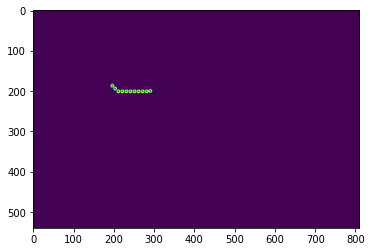

In [325]:
simple_tracker.vis()

---- optimize translation ----
tensor([40.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0')
tensor(19336.9043, device='cuda:0')
tensor([ 39.6616, 263.6688,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
       device='cuda:0')
tensor(321.0519, device='cuda:0')
tensor([ 44.7473, 263.6867,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
       device='cuda:0')
tensor(317.7969, device='cuda:0')
tensor([ 41.7113, 263.5351,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
       d

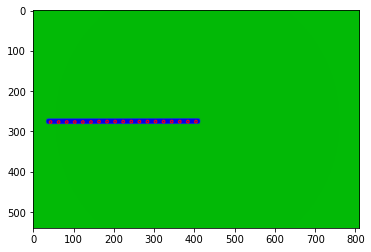

---- optimize translation ----
tensor([ 4.3128e+01,  2.6371e+02, -1.4500e-02,  5.6423e-03, -2.3496e-03,
         6.0376e-04,  8.7571e-03,  2.3805e-02,  2.4808e-04,  1.7896e-02,
        -1.7891e-04, -1.1336e-03,  1.1195e-03, -1.1613e-03,  1.7990e-03,
        -3.6279e-03,  7.5457e-03, -1.4655e-02,  2.5724e-02, -4.0412e-02],
       device='cuda:0')
tensor(312.9376, device='cuda:0')
tensor([ 4.2698e+01,  2.6348e+02, -1.4500e-02,  5.6423e-03, -2.3496e-03,
         6.0376e-04,  8.7571e-03,  2.3805e-02,  2.4808e-04,  1.7896e-02,
        -1.7891e-04, -1.1336e-03,  1.1195e-03, -1.1613e-03,  1.7990e-03,
        -3.6279e-03,  7.5457e-03, -1.4655e-02,  2.5724e-02, -4.0412e-02],
       device='cuda:0')
tensor(313.4482, device='cuda:0')
---- optimize rotation ----
tensor([ 4.3128e+01,  2.6371e+02, -1.4500e-02,  5.6423e-03, -2.3496e-03,
         6.0376e-04,  8.7571e-03,  2.3805e-02,  2.4808e-04,  1.7896e-02,
        -1.7891e-04, -1.1336e-03,  1.1195e-03, -1.1613e-03,  1.7990e-03,
        -3.6279e-03,

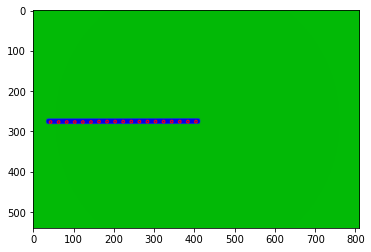

---- optimize translation ----
tensor([ 4.3128e+01,  2.6371e+02, -1.4500e-02,  5.6423e-03, -2.3496e-03,
         6.0376e-04,  8.7571e-03,  2.3805e-02,  2.4808e-04,  1.7896e-02,
        -1.7891e-04, -1.1336e-03,  1.1195e-03, -1.1613e-03,  1.7990e-03,
        -3.6279e-03,  7.5457e-03, -1.4655e-02,  2.5724e-02, -4.0412e-02],
       device='cuda:0')
tensor(329.1721, device='cuda:0')
tensor([ 5.0953e+01,  2.6347e+02, -1.4500e-02,  5.6423e-03, -2.3496e-03,
         6.0376e-04,  8.7571e-03,  2.3805e-02,  2.4808e-04,  1.7896e-02,
        -1.7891e-04, -1.1336e-03,  1.1195e-03, -1.1613e-03,  1.7990e-03,
        -3.6279e-03,  7.5457e-03, -1.4655e-02,  2.5724e-02, -4.0412e-02],
       device='cuda:0')
tensor(317.2996, device='cuda:0')
tensor([ 4.7250e+01,  2.6358e+02, -1.4500e-02,  5.6423e-03, -2.3496e-03,
         6.0376e-04,  8.7571e-03,  2.3805e-02,  2.4808e-04,  1.7896e-02,
        -1.7891e-04, -1.1336e-03,  1.1195e-03, -1.1613e-03,  1.7990e-03,
        -3.6279e-03,  7.5457e-03, -1.4655e-02,  

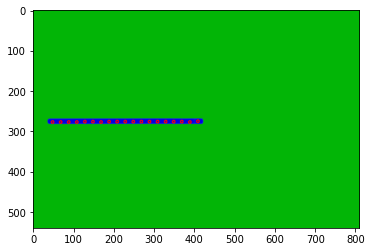

---- optimize translation ----
tensor([ 4.8636e+01,  2.6349e+02,  6.4264e-03, -1.3795e-02,  2.9897e-02,
         4.1961e-03,  4.3607e-03, -1.3289e-02,  1.1117e-02,  1.0275e-02,
         1.3676e-02, -2.4830e-03, -9.3216e-04,  2.3967e-03, -4.2048e-03,
         7.1904e-03, -1.0155e-02,  5.3718e-04, -3.4989e-02,  7.6273e-02],
       device='cuda:0')
tensor(336.8323, device='cuda:0')
tensor([ 6.1167e+01,  2.6400e+02,  6.4264e-03, -1.3795e-02,  2.9897e-02,
         4.1961e-03,  4.3607e-03, -1.3289e-02,  1.1117e-02,  1.0275e-02,
         1.3676e-02, -2.4830e-03, -9.3216e-04,  2.3967e-03, -4.2048e-03,
         7.1904e-03, -1.0155e-02,  5.3718e-04, -3.4989e-02,  7.6273e-02],
       device='cuda:0')
tensor(300.4366, device='cuda:0')
tensor([ 5.6667e+01,  2.6343e+02,  6.4264e-03, -1.3795e-02,  2.9897e-02,
         4.1961e-03,  4.3607e-03, -1.3289e-02,  1.1117e-02,  1.0275e-02,
         1.3676e-02, -2.4830e-03, -9.3216e-04,  2.3967e-03, -4.2048e-03,
         7.1904e-03, -1.0155e-02,  5.3718e-04, -

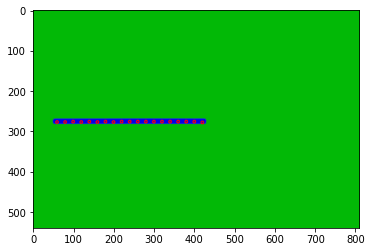

---- optimize translation ----
tensor([ 5.9518e+01,  2.6391e+02, -3.4976e-02,  4.1426e-02, -9.9620e-03,
         1.1447e-02, -8.4657e-03,  9.1817e-03, -8.3376e-03,  2.7377e-02,
         1.9928e-03, -1.0175e-03,  1.4711e-03, -2.1542e-03,  2.4683e-03,
        -9.8217e-03,  1.6591e-02, -3.1926e-02,  2.4583e-02, -9.2035e-02],
       device='cuda:0')
tensor(320.8461, device='cuda:0')
tensor([ 6.5833e+01,  2.6300e+02, -3.4976e-02,  4.1426e-02, -9.9620e-03,
         1.1447e-02, -8.4657e-03,  9.1817e-03, -8.3376e-03,  2.7377e-02,
         1.9928e-03, -1.0175e-03,  1.4711e-03, -2.1542e-03,  2.4683e-03,
        -9.8217e-03,  1.6591e-02, -3.1926e-02,  2.4583e-02, -9.2035e-02],
       device='cuda:0')
tensor(316.8488, device='cuda:0')
tensor([ 6.2584e+01,  2.6379e+02, -3.4976e-02,  4.1426e-02, -9.9620e-03,
         1.1447e-02, -8.4657e-03,  9.1817e-03, -8.3376e-03,  2.7377e-02,
         1.9928e-03, -1.0175e-03,  1.4711e-03, -2.1542e-03,  2.4683e-03,
        -9.8217e-03,  1.6591e-02, -3.1926e-02,  

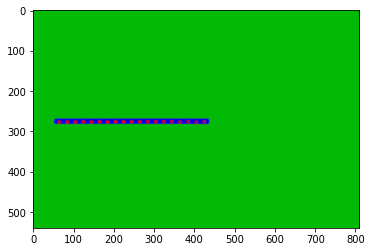

---- optimize translation ----
tensor([ 6.4381e+01,  2.6310e+02,  4.4145e-02, -4.3284e-02,  4.5699e-02,
        -7.3532e-03,  1.3051e-02, -1.4977e-02,  1.8521e-02,  8.7556e-03,
         6.3889e-03, -1.5991e-04, -2.0579e-03,  3.7420e-03, -6.7702e-03,
        -2.2784e-03, -3.9497e-02,  4.4344e-02, -1.0167e-01,  1.1737e-01],
       device='cuda:0')
tensor(336.2187, device='cuda:0')
tensor([ 7.2320e+01,  2.6475e+02,  4.4145e-02, -4.3284e-02,  4.5699e-02,
        -7.3532e-03,  1.3051e-02, -1.4977e-02,  1.8521e-02,  8.7556e-03,
         6.3889e-03, -1.5991e-04, -2.0579e-03,  3.7420e-03, -6.7702e-03,
        -2.2784e-03, -3.9497e-02,  4.4344e-02, -1.0167e-01,  1.1737e-01],
       device='cuda:0')
tensor(340.0745, device='cuda:0')
---- optimize rotation ----
tensor([ 6.4381e+01,  2.6310e+02,  4.4145e-02, -4.3284e-02,  4.5699e-02,
        -7.3532e-03,  1.3051e-02, -1.4977e-02,  1.8521e-02,  8.7556e-03,
         6.3889e-03, -1.5991e-04, -2.0579e-03,  3.7420e-03, -6.7702e-03,
        -2.2784e-03,

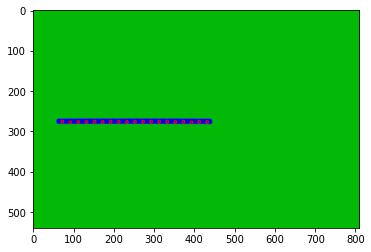

---- optimize translation ----
tensor([ 7.2320e+01,  2.6475e+02, -8.9781e-02,  3.9287e-02,  8.1042e-03,
         1.1916e-02, -1.3996e-02,  1.1659e-02,  3.3957e-03, -9.4049e-03,
         2.7820e-02, -3.9320e-03,  6.7454e-03, -2.9379e-02,  6.4432e-03,
        -2.9846e-02,  3.8654e-02, -9.4366e-02,  1.0031e-01, -5.3337e-02],
       device='cuda:0')
tensor(332.9403, device='cuda:0')
tensor([ 7.8829e+01,  2.6167e+02, -8.9781e-02,  3.9287e-02,  8.1042e-03,
         1.1916e-02, -1.3996e-02,  1.1659e-02,  3.3957e-03, -9.4049e-03,
         2.7820e-02, -3.9320e-03,  6.7454e-03, -2.9379e-02,  6.4432e-03,
        -2.9846e-02,  3.8654e-02, -9.4366e-02,  1.0031e-01, -5.3337e-02],
       device='cuda:0')
tensor(380.2842, device='cuda:0')
---- optimize rotation ----
tensor([ 7.2320e+01,  2.6475e+02, -8.9781e-02,  3.9287e-02,  8.1042e-03,
         1.1916e-02, -1.3996e-02,  1.1659e-02,  3.3957e-03, -9.4049e-03,
         2.7820e-02, -3.9320e-03,  6.7454e-03, -2.9379e-02,  6.4432e-03,
        -2.9846e-02,

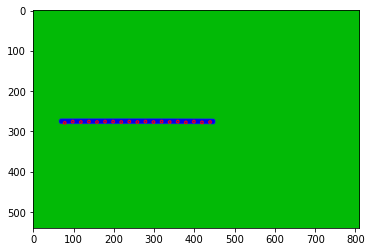

---- optimize translation ----
tensor([ 7.8829e+01,  2.6167e+02,  1.2225e-01, -3.1890e-02,  3.9133e-02,
        -2.1964e-02,  1.5009e-02, -2.5649e-03, -1.0108e-02,  2.8044e-02,
        -2.3858e-02,  2.2493e-02, -3.9606e-02,  3.2090e-02, -3.9282e-02,
         3.6286e-02, -9.2405e-02,  1.1409e-01, -8.2212e-02,  2.9963e-02],
       device='cuda:0')
tensor(342.3258, device='cuda:0')
tensor([ 8.5499e+01,  2.6666e+02,  1.2225e-01, -3.1890e-02,  3.9133e-02,
        -2.1964e-02,  1.5009e-02, -2.5649e-03, -1.0108e-02,  2.8044e-02,
        -2.3858e-02,  2.2493e-02, -3.9606e-02,  3.2090e-02, -3.9282e-02,
         3.6286e-02, -9.2405e-02,  1.1409e-01, -8.2212e-02,  2.9963e-02],
       device='cuda:0')
tensor(481.3767, device='cuda:0')
---- optimize rotation ----
tensor([ 7.8829e+01,  2.6167e+02,  1.2225e-01, -3.1890e-02,  3.9133e-02,
        -2.1964e-02,  1.5009e-02, -2.5649e-03, -1.0108e-02,  2.8044e-02,
        -2.3858e-02,  2.2493e-02, -3.9606e-02,  3.2090e-02, -3.9282e-02,
         3.6286e-02,

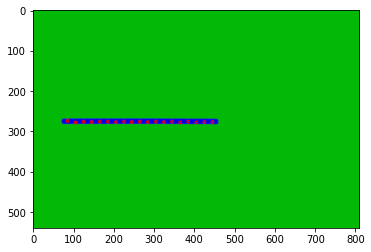

---- optimize translation ----
tensor([ 8.5499e+01,  2.6666e+02, -2.0461e-01,  7.8496e-02, -1.7467e-02,
         1.3954e-02, -3.6607e-03, -1.1478e-02,  2.7169e-02, -3.3241e-02,
         3.2838e-02, -4.2153e-02,  4.8570e-02, -6.7697e-02,  4.8800e-02,
        -8.7890e-02,  1.2094e-01, -9.9790e-02,  4.4835e-02, -7.7777e-03],
       device='cuda:0')
tensor(357.9975, device='cuda:0')
tensor([ 9.2142e+01,  2.5932e+02, -2.0461e-01,  7.8496e-02, -1.7467e-02,
         1.3954e-02, -3.6607e-03, -1.1478e-02,  2.7169e-02, -3.3241e-02,
         3.2838e-02, -4.2153e-02,  4.8570e-02, -6.7697e-02,  4.8800e-02,
        -8.7890e-02,  1.2094e-01, -9.9790e-02,  4.4835e-02, -7.7777e-03],
       device='cuda:0')
tensor(614.1664, device='cuda:0')
---- optimize rotation ----
tensor([ 8.5499e+01,  2.6666e+02, -2.0461e-01,  7.8496e-02, -1.7467e-02,
         1.3954e-02, -3.6607e-03, -1.1478e-02,  2.7169e-02, -3.3241e-02,
         3.2838e-02, -4.2153e-02,  4.8570e-02, -6.7697e-02,  4.8800e-02,
        -8.7890e-02,

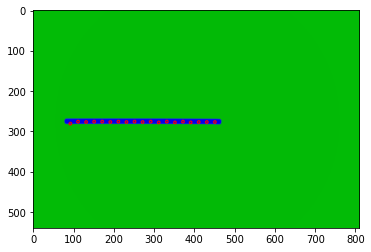

---- optimize translation ----
tensor([ 9.2142e+01,  2.5932e+02,  2.5565e-01, -2.0571e-02,  1.0072e-02,
         2.0841e-04, -1.4154e-02,  2.7750e-02, -3.5200e-02,  3.6954e-02,
        -4.1206e-02,  4.2362e-02, -8.3887e-02,  6.9811e-02, -8.4578e-02,
         1.1780e-01, -1.0396e-01,  4.4767e-02,  5.1527e-03, -2.3581e-02],
       device='cuda:0')
tensor(369.2770, device='cuda:0')
tensor([ 9.9786e+01,  2.6904e+02,  2.5565e-01, -2.0571e-02,  1.0072e-02,
         2.0841e-04, -1.4154e-02,  2.7750e-02, -3.5200e-02,  3.6954e-02,
        -4.1206e-02,  4.2362e-02, -8.3887e-02,  6.9811e-02, -8.4578e-02,
         1.1780e-01, -1.0396e-01,  4.4767e-02,  5.1527e-03, -2.3581e-02],
       device='cuda:0')
tensor(775.7733, device='cuda:0')
---- optimize rotation ----
tensor([ 9.2142e+01,  2.5932e+02,  2.5565e-01, -2.0571e-02,  1.0072e-02,
         2.0841e-04, -1.4154e-02,  2.7750e-02, -3.5200e-02,  3.6954e-02,
        -4.1206e-02,  4.2362e-02, -8.3887e-02,  6.9811e-02, -8.4578e-02,
         1.1780e-01,

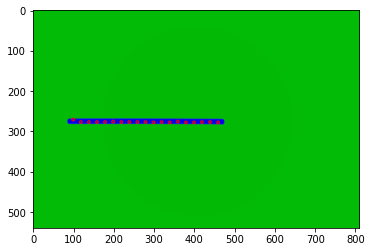

---- optimize translation ----
tensor([ 9.9786e+01,  2.6904e+02, -2.8645e-01,  1.4230e-02,  1.3056e-02,
        -1.9359e-02,  2.5636e-02, -2.6848e-02,  2.3727e-02, -2.1206e-02,
        -2.9150e-04, -4.4998e-02,  4.7701e-02, -4.4920e-02,  6.5536e-02,
        -5.2292e-02, -3.3613e-03,  4.4524e-02, -3.9190e-02, -6.8857e-03],
       device='cuda:0')
tensor(366.8110, device='cuda:0')
tensor([ 1.0808e+02,  2.5728e+02, -2.8645e-01,  1.4230e-02,  1.3056e-02,
        -1.9359e-02,  2.5636e-02, -2.6848e-02,  2.3727e-02, -2.1206e-02,
        -2.9150e-04, -4.4998e-02,  4.7701e-02, -4.4920e-02,  6.5536e-02,
        -5.2292e-02, -3.3613e-03,  4.4524e-02, -3.9190e-02, -6.8857e-03],
       device='cuda:0')
tensor(906.9457, device='cuda:0')
---- optimize rotation ----
tensor([ 9.9786e+01,  2.6904e+02, -2.8645e-01,  1.4230e-02,  1.3056e-02,
        -1.9359e-02,  2.5636e-02, -2.6848e-02,  2.3727e-02, -2.1206e-02,
        -2.9150e-04, -4.4998e-02,  4.7701e-02, -4.4920e-02,  6.5536e-02,
        -5.2292e-02,

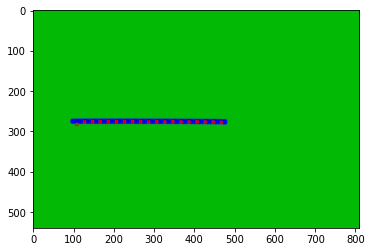

---- optimize translation ----
tensor([ 1.0808e+02,  2.5728e+02,  3.2442e-01,  5.4687e-02, -3.4909e-02,
         2.3425e-02, -1.7890e-02,  1.1063e-02, -3.7767e-03, -1.0340e-02,
        -4.4141e-02,  4.5855e-02, -2.8062e-02,  2.9079e-02, -1.4202e-02,
        -3.4648e-02,  6.2716e-02, -3.9105e-02, -1.1455e-03, -3.7554e-02],
       device='cuda:0')
tensor(370.6080, device='cuda:0')
tensor([ 1.1606e+02,  2.7052e+02,  3.2442e-01,  5.4687e-02, -3.4909e-02,
         2.3425e-02, -1.7890e-02,  1.1063e-02, -3.7767e-03, -1.0340e-02,
        -4.4141e-02,  4.5855e-02, -2.8062e-02,  2.9079e-02, -1.4202e-02,
        -3.4648e-02,  6.2716e-02, -3.9105e-02, -1.1455e-03, -3.7554e-02],
       device='cuda:0')
tensor(1027.4869, device='cuda:0')
---- optimize rotation ----
tensor([ 1.0808e+02,  2.5728e+02,  3.2442e-01,  5.4687e-02, -3.4909e-02,
         2.3425e-02, -1.7890e-02,  1.1063e-02, -3.7767e-03, -1.0340e-02,
        -4.4141e-02,  4.5855e-02, -2.8062e-02,  2.9079e-02, -1.4202e-02,
        -3.4648e-02

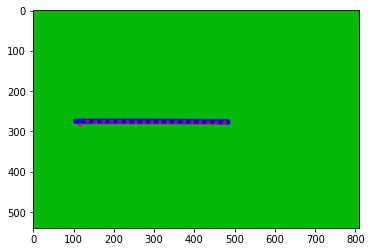

---- optimize translation ----
tensor([ 1.1607e+02,  2.5686e+02,  4.4330e-01, -7.9315e-02,  2.3749e-02,
        -5.6117e-03, -1.0835e-02, -1.7501e-02, -5.5156e-03,  1.8173e-02,
        -9.8255e-03, -4.4687e-03,  1.3922e-02, -2.6519e-02,  3.3837e-02,
        -2.0925e-02,  3.7613e-03, -3.9785e-02, -2.1208e-02,  2.4781e-02],
       device='cuda:0')
tensor(377.5144, device='cuda:0')
tensor([ 1.2175e+02,  2.7160e+02,  4.4330e-01, -7.9315e-02,  2.3749e-02,
        -5.6117e-03, -1.0835e-02, -1.7501e-02, -5.5156e-03,  1.8173e-02,
        -9.8255e-03, -4.4687e-03,  1.3922e-02, -2.6519e-02,  3.3837e-02,
        -2.0925e-02,  3.7613e-03, -3.9785e-02, -2.1208e-02,  2.4781e-02],
       device='cuda:0')
tensor(1129.0239, device='cuda:0')
---- optimize rotation ----
tensor([ 1.1607e+02,  2.5686e+02,  4.4330e-01, -7.9315e-02,  2.3749e-02,
        -5.6117e-03, -1.0835e-02, -1.7501e-02, -5.5156e-03,  1.8173e-02,
        -9.8255e-03, -4.4687e-03,  1.3922e-02, -2.6519e-02,  3.3837e-02,
        -2.0925e-02

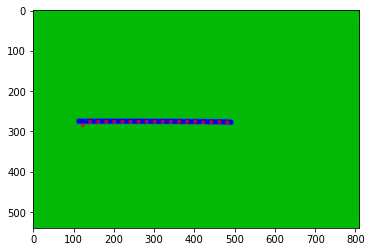

---- optimize translation ----
tensor([ 1.2360e+02,  2.5594e+02,  4.2287e-01,  3.0378e-02,  1.0943e-02,
        -4.6296e-02,  3.7313e-03,  1.1247e-02, -2.0688e-03, -1.2279e-02,
         1.2519e-02, -5.8251e-03, -7.5460e-04,  8.1098e-03, -1.1084e-02,
         8.2561e-03, -6.9012e-02,  1.8686e-02,  4.8207e-03, -1.9238e-02],
       device='cuda:0')
tensor(379.9392, device='cuda:0')
tensor([ 1.3030e+02,  2.7132e+02,  4.2287e-01,  3.0378e-02,  1.0943e-02,
        -4.6296e-02,  3.7313e-03,  1.1247e-02, -2.0688e-03, -1.2279e-02,
         1.2519e-02, -5.8251e-03, -7.5460e-04,  8.1098e-03, -1.1084e-02,
         8.2561e-03, -6.9012e-02,  1.8686e-02,  4.8207e-03, -1.9238e-02],
       device='cuda:0')
tensor(1199.5216, device='cuda:0')
---- optimize rotation ----
tensor([ 1.2360e+02,  2.5594e+02,  4.2287e-01,  3.0378e-02,  1.0943e-02,
        -4.6296e-02,  3.7313e-03,  1.1247e-02, -2.0688e-03, -1.2279e-02,
         1.2519e-02, -5.8251e-03, -7.5460e-04,  8.1098e-03, -1.1084e-02,
         8.2561e-03

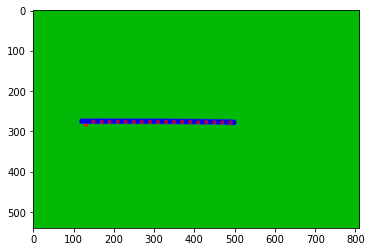

---- optimize translation ----
tensor([ 1.3156e+02,  2.5670e+02,  4.1871e-01, -5.5290e-02,  9.6744e-04,
         2.6065e-02, -3.0568e-02,  1.9828e-03,  4.5345e-03,  1.7258e-03,
        -7.2389e-03,  8.7954e-03, -9.3711e-03,  1.2543e-02, -2.0012e-02,
        -4.9245e-02,  2.4888e-02, -1.4198e-02, -7.5582e-03, -2.8151e-02],
       device='cuda:0')
tensor(376.7618, device='cuda:0')
tensor([ 1.3743e+02,  2.7184e+02,  4.1871e-01, -5.5290e-02,  9.6744e-04,
         2.6065e-02, -3.0568e-02,  1.9828e-03,  4.5345e-03,  1.7258e-03,
        -7.2389e-03,  8.7954e-03, -9.3711e-03,  1.2543e-02, -2.0012e-02,
        -4.9245e-02,  2.4888e-02, -1.4198e-02, -7.5582e-03, -2.8151e-02],
       device='cuda:0')
tensor(1166.3285, device='cuda:0')
---- optimize rotation ----
tensor([ 1.3156e+02,  2.5670e+02,  4.1871e-01, -5.5290e-02,  9.6744e-04,
         2.6065e-02, -3.0568e-02,  1.9828e-03,  4.5345e-03,  1.7258e-03,
        -7.2389e-03,  8.7954e-03, -9.3711e-03,  1.2543e-02, -2.0012e-02,
        -4.9245e-02

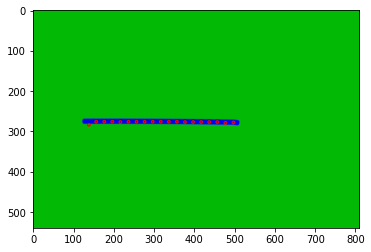

---- optimize translation ----
tensor([ 1.3862e+02,  2.5622e+02,  4.0860e-01, -4.3629e-03,  1.8688e-02,
        -2.5414e-02,  2.2089e-02, -5.8846e-03, -5.7032e-03,  5.1203e-03,
        -6.9962e-04, -3.6413e-03,  1.1754e-02, -2.6568e-02, -4.0478e-02,
         1.7462e-02, -1.1880e-02,  3.6965e-03, -7.2347e-02,  2.3235e-02],
       device='cuda:0')
tensor(381.7675, device='cuda:0')
tensor([ 1.4515e+02,  2.7133e+02,  4.0860e-01, -4.3629e-03,  1.8688e-02,
        -2.5414e-02,  2.2089e-02, -5.8846e-03, -5.7032e-03,  5.1203e-03,
        -6.9962e-04, -3.6413e-03,  1.1754e-02, -2.6568e-02, -4.0478e-02,
         1.7462e-02, -1.1880e-02,  3.6965e-03, -7.2347e-02,  2.3235e-02],
       device='cuda:0')
tensor(1189.2178, device='cuda:0')
---- optimize rotation ----
tensor([ 1.3862e+02,  2.5622e+02,  4.0860e-01, -4.3629e-03,  1.8688e-02,
        -2.5414e-02,  2.2089e-02, -5.8846e-03, -5.7032e-03,  5.1203e-03,
        -6.9962e-04, -3.6413e-03,  1.1754e-02, -2.6568e-02, -4.0478e-02,
         1.7462e-02

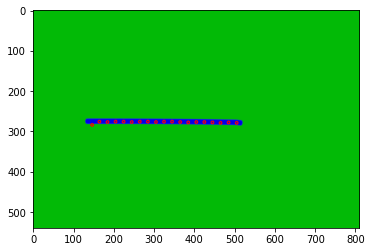

---- optimize translation ----
tensor([ 1.4628e+02,  2.5624e+02,  4.0382e-01, -1.8491e-02,  1.8357e-02,
         3.3266e-04, -8.7138e-03,  5.3305e-03,  1.8129e-03, -4.9659e-03,
         3.2022e-03,  4.4004e-03, -1.9180e-02, -3.8952e-02,  5.4127e-03,
         4.1162e-03, -1.8680e-02, -4.8244e-02,  2.0510e-02, -2.9933e-02],
       device='cuda:0')
tensor(381.2112, device='cuda:0')
tensor([ 1.5292e+02,  2.7156e+02,  4.0382e-01, -1.8491e-02,  1.8357e-02,
         3.3266e-04, -8.7138e-03,  5.3305e-03,  1.8129e-03, -4.9659e-03,
         3.2022e-03,  4.4004e-03, -1.9180e-02, -3.8952e-02,  5.4127e-03,
         4.1162e-03, -1.8680e-02, -4.8244e-02,  2.0510e-02, -2.9933e-02],
       device='cuda:0')
tensor(1190.7107, device='cuda:0')
---- optimize rotation ----
tensor([ 1.4628e+02,  2.5624e+02,  4.0382e-01, -1.8491e-02,  1.8357e-02,
         3.3266e-04, -8.7138e-03,  5.3305e-03,  1.8129e-03, -4.9659e-03,
         3.2022e-03,  4.4004e-03, -1.9180e-02, -3.8952e-02,  5.4127e-03,
         4.1162e-03

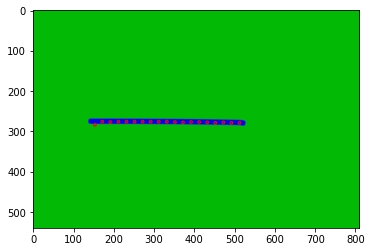

---- optimize translation ----
tensor([ 1.5374e+02,  2.5603e+02,  4.2521e-01, -1.4855e-02,  7.9441e-03,
        -4.6067e-03,  7.4637e-03, -6.2668e-03,  1.5900e-03,  1.3892e-03,
         2.3198e-03, -1.3497e-02, -4.7475e-02,  1.3486e-02, -1.9426e-03,
        -1.2416e-02, -4.7436e-02,  1.5286e-02, -1.6583e-02, -4.0677e-02],
       device='cuda:0')
tensor(381.7084, device='cuda:0')
tensor([ 1.5995e+02,  2.7159e+02,  4.2521e-01, -1.4855e-02,  7.9441e-03,
        -4.6067e-03,  7.4637e-03, -6.2668e-03,  1.5900e-03,  1.3892e-03,
         2.3198e-03, -1.3497e-02, -4.7475e-02,  1.3486e-02, -1.9426e-03,
        -1.2416e-02, -4.7436e-02,  1.5286e-02, -1.6583e-02, -4.0677e-02],
       device='cuda:0')
tensor(1213.1888, device='cuda:0')
---- optimize rotation ----
tensor([ 1.5374e+02,  2.5603e+02,  4.2521e-01, -1.4855e-02,  7.9441e-03,
        -4.6067e-03,  7.4637e-03, -6.2668e-03,  1.5900e-03,  1.3892e-03,
         2.3198e-03, -1.3497e-02, -4.7475e-02,  1.3486e-02, -1.9426e-03,
        -1.2416e-02

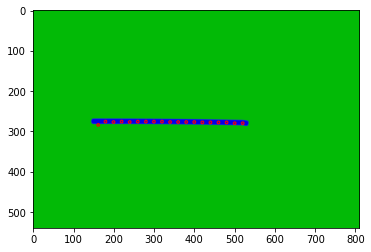

---- optimize translation ----
tensor([ 1.6110e+02,  2.5618e+02,  4.0591e-01, -1.6035e-02,  2.3617e-02,
        -1.2111e-02,  2.9230e-03,  1.4394e-03, -1.7716e-03,  3.5997e-03,
        -9.3192e-03, -4.3702e-02,  3.9274e-03, -2.3393e-03, -4.6073e-03,
        -4.5651e-02, -5.0322e-04,  6.7543e-03, -6.5130e-02,  2.3841e-03],
       device='cuda:0')
tensor(377.6322, device='cuda:0')
tensor([ 1.6751e+02,  2.7131e+02,  4.0591e-01, -1.6035e-02,  2.3617e-02,
        -1.2111e-02,  2.9230e-03,  1.4394e-03, -1.7716e-03,  3.5997e-03,
        -9.3192e-03, -4.3702e-02,  3.9274e-03, -2.3393e-03, -4.6073e-03,
        -4.5651e-02, -5.0322e-04,  6.7543e-03, -6.5130e-02,  2.3841e-03],
       device='cuda:0')
tensor(1181.6283, device='cuda:0')
---- optimize rotation ----
tensor([ 1.6110e+02,  2.5618e+02,  4.0591e-01, -1.6035e-02,  2.3617e-02,
        -1.2111e-02,  2.9230e-03,  1.4394e-03, -1.7716e-03,  3.5997e-03,
        -9.3192e-03, -4.3702e-02,  3.9274e-03, -2.3393e-03, -4.6073e-03,
        -4.5651e-02

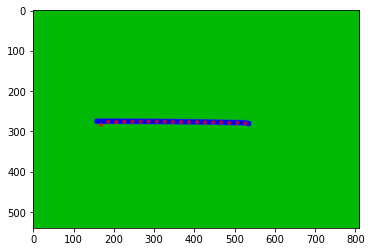

---- optimize translation ----
tensor([ 1.6837e+02,  2.5636e+02,  3.9910e-01, -1.3232e-02,  1.2364e-02,
        -3.4769e-03,  2.2792e-03, -2.6351e-03,  2.7737e-03, -3.2086e-04,
        -4.4872e-02, -7.2068e-03,  2.9614e-03,  1.8138e-03, -4.6736e-02,
        -5.4200e-03,  2.7695e-03, -5.7424e-02,  6.8911e-03, -5.6072e-02],
       device='cuda:0')
tensor(367.9408, device='cuda:0')
tensor([ 1.7415e+02,  2.7092e+02,  3.9910e-01, -1.3232e-02,  1.2364e-02,
        -3.4769e-03,  2.2792e-03, -2.6351e-03,  2.7737e-03, -3.2086e-04,
        -4.4872e-02, -7.2068e-03,  2.9614e-03,  1.8138e-03, -4.6736e-02,
        -5.4200e-03,  2.7695e-03, -5.7424e-02,  6.8911e-03, -5.6072e-02],
       device='cuda:0')
tensor(1146.5834, device='cuda:0')
---- optimize rotation ----
tensor([ 1.6837e+02,  2.5636e+02,  3.9910e-01, -1.3232e-02,  1.2364e-02,
        -3.4769e-03,  2.2792e-03, -2.6351e-03,  2.7737e-03, -3.2086e-04,
        -4.4872e-02, -7.2068e-03,  2.9614e-03,  1.8138e-03, -4.6736e-02,
        -5.4200e-03

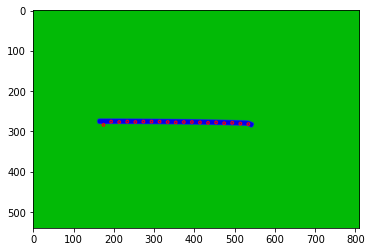

---- optimize translation ----
tensor([ 1.7474e+02,  2.5687e+02,  3.7905e-01, -2.2963e-02,  1.3088e-02,
        -4.9262e-03,  1.6828e-03,  4.9207e-04,  2.0277e-03, -3.0241e-02,
        -2.6175e-02,  7.5139e-03, -1.5790e-03, -2.9082e-02, -2.4454e-02,
         5.9930e-03, -5.6273e-02,  1.1119e-02, -7.2401e-02, -7.0034e-02],
       device='cuda:0')
tensor(361.9153, device='cuda:0')
tensor([ 1.8074e+02,  2.7061e+02,  3.7905e-01, -2.2963e-02,  1.3088e-02,
        -4.9262e-03,  1.6828e-03,  4.9207e-04,  2.0277e-03, -3.0241e-02,
        -2.6175e-02,  7.5139e-03, -1.5790e-03, -2.9082e-02, -2.4454e-02,
         5.9930e-03, -5.6273e-02,  1.1119e-02, -7.2401e-02, -7.0034e-02],
       device='cuda:0')
tensor(1089.3175, device='cuda:0')
---- optimize rotation ----
tensor([ 1.7474e+02,  2.5687e+02,  3.7905e-01, -2.2963e-02,  1.3088e-02,
        -4.9262e-03,  1.6828e-03,  4.9207e-04,  2.0277e-03, -3.0241e-02,
        -2.6175e-02,  7.5139e-03, -1.5790e-03, -2.9082e-02, -2.4454e-02,
         5.9930e-03

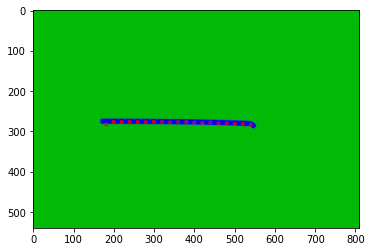

---- optimize translation ----
tensor([ 1.8137e+02,  2.5706e+02,  3.7291e-01, -2.6583e-02,  1.0877e-02,
        -4.0020e-03,  1.6419e-03,  9.8294e-04, -9.9021e-03, -4.6160e-02,
         7.4429e-03,  1.3280e-03, -2.2657e-02, -3.6131e-02,  8.4993e-03,
        -5.3378e-02, -1.0347e-02, -4.9534e-02, -2.5348e-02, -1.5115e-01],
       device='cuda:0')
tensor(358.9871, device='cuda:0')
tensor([ 1.8737e+02,  2.7051e+02,  3.7291e-01, -2.6583e-02,  1.0877e-02,
        -4.0020e-03,  1.6419e-03,  9.8294e-04, -9.9021e-03, -4.6160e-02,
         7.4429e-03,  1.3280e-03, -2.2657e-02, -3.6131e-02,  8.4993e-03,
        -5.3378e-02, -1.0347e-02, -4.9534e-02, -2.5348e-02, -1.5115e-01],
       device='cuda:0')
tensor(1068.6361, device='cuda:0')
---- optimize rotation ----
tensor([ 1.8137e+02,  2.5706e+02,  3.7291e-01, -2.6583e-02,  1.0877e-02,
        -4.0020e-03,  1.6419e-03,  9.8294e-04, -9.9021e-03, -4.6160e-02,
         7.4429e-03,  1.3280e-03, -2.2657e-02, -3.6131e-02,  8.4993e-03,
        -5.3378e-02

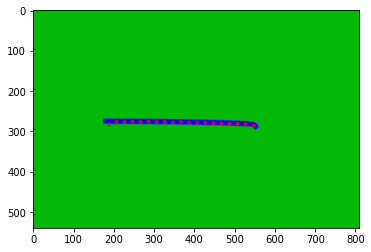

---- optimize translation ----
tensor([ 1.8799e+02,  2.5713e+02,  3.7093e-01, -2.9183e-02,  1.3522e-02,
        -6.5246e-03,  3.9978e-03, -1.7306e-03, -4.0964e-02, -1.0979e-02,
         7.9312e-03, -1.9721e-02, -4.0242e-02,  8.2025e-03, -5.6675e-02,
        -7.6147e-03, -4.7573e-02, -4.1438e-02, -4.1738e-02, -1.8890e-01],
       device='cuda:0')
tensor(357.2397, device='cuda:0')
tensor([ 1.9402e+02,  2.7037e+02,  3.7093e-01, -2.9183e-02,  1.3522e-02,
        -6.5246e-03,  3.9978e-03, -1.7306e-03, -4.0964e-02, -1.0979e-02,
         7.9312e-03, -1.9721e-02, -4.0242e-02,  8.2025e-03, -5.6675e-02,
        -7.6147e-03, -4.7573e-02, -4.1438e-02, -4.1738e-02, -1.8890e-01],
       device='cuda:0')
tensor(1056.1005, device='cuda:0')
---- optimize rotation ----
tensor([ 1.8799e+02,  2.5713e+02,  3.7093e-01, -2.9183e-02,  1.3522e-02,
        -6.5246e-03,  3.9978e-03, -1.7306e-03, -4.0964e-02, -1.0979e-02,
         7.9312e-03, -1.9721e-02, -4.0242e-02,  8.2025e-03, -5.6675e-02,
        -7.6147e-03

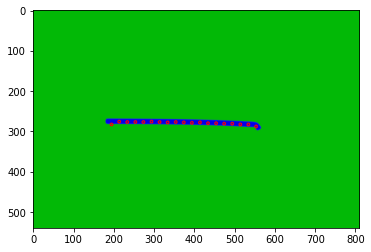

---- optimize translation ----
tensor([ 1.9447e+02,  2.5736e+02,  3.6138e-01, -3.1958e-02,  1.0087e-02,
        -2.7287e-03,  3.5206e-03, -2.6354e-02, -3.0327e-02,  9.9058e-03,
        -1.3649e-02, -4.3398e-02,  4.5147e-03, -5.3361e-02, -9.1000e-03,
        -5.4944e-02, -3.0618e-02, -6.5755e-02, -3.5298e-02, -2.3678e-01],
       device='cuda:0')
tensor(355.8678, device='cuda:0')
tensor([ 2.0038e+02,  2.7017e+02,  3.6138e-01, -3.1958e-02,  1.0087e-02,
        -2.7287e-03,  3.5206e-03, -2.6354e-02, -3.0327e-02,  9.9058e-03,
        -1.3649e-02, -4.3398e-02,  4.5147e-03, -5.3361e-02, -9.1000e-03,
        -5.4944e-02, -3.0618e-02, -6.5755e-02, -3.5298e-02, -2.3678e-01],
       device='cuda:0')
tensor(1030.1892, device='cuda:0')
---- optimize rotation ----
tensor([ 1.9447e+02,  2.5736e+02,  3.6138e-01, -3.1958e-02,  1.0087e-02,
        -2.7287e-03,  3.5206e-03, -2.6354e-02, -3.0327e-02,  9.9058e-03,
        -1.3649e-02, -4.3398e-02,  4.5147e-03, -5.3361e-02, -9.1000e-03,
        -5.4944e-02

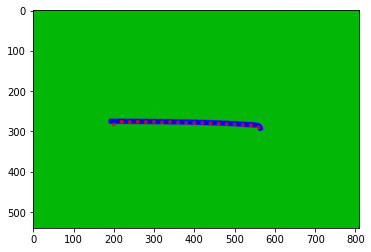

---- optimize translation ----
tensor([ 2.0092e+02,  2.5733e+02,  3.6480e-01, -3.5247e-02,  1.2146e-02,
        -3.6621e-03, -4.8070e-03, -4.8148e-02,  7.4879e-03, -4.3551e-03,
        -4.8265e-02,  1.2163e-03, -4.7334e-02, -1.9209e-02, -4.5146e-02,
        -4.5348e-02, -4.6383e-02, -7.2704e-02, -4.5594e-02, -2.7212e-01],
       device='cuda:0')
tensor(354.3096, device='cuda:0')
tensor([ 2.0694e+02,  2.6997e+02,  3.6480e-01, -3.5247e-02,  1.2146e-02,
        -3.6621e-03, -4.8070e-03, -4.8148e-02,  7.4879e-03, -4.3551e-03,
        -4.8265e-02,  1.2163e-03, -4.7334e-02, -1.9209e-02, -4.5146e-02,
        -4.5348e-02, -4.6383e-02, -7.2704e-02, -4.5594e-02, -2.7212e-01],
       device='cuda:0')
tensor(1018.0596, device='cuda:0')
---- optimize rotation ----
tensor([ 2.0092e+02,  2.5733e+02,  3.6480e-01, -3.5247e-02,  1.2146e-02,
        -3.6621e-03, -4.8070e-03, -4.8148e-02,  7.4879e-03, -4.3551e-03,
        -4.8265e-02,  1.2163e-03, -4.7334e-02, -1.9209e-02, -4.5146e-02,
        -4.5348e-02

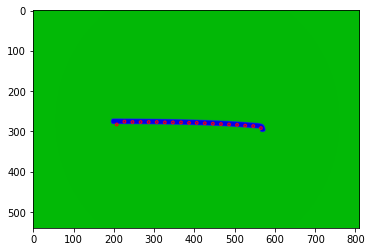

---- optimize translation ----
tensor([ 2.0717e+02,  2.5790e+02,  3.3465e-01, -3.8014e-02,  1.0499e-02,
        -1.2869e-03, -4.0631e-02, -9.6588e-03,  2.3031e-03, -4.0864e-02,
        -9.2886e-03, -4.0644e-02, -2.2627e-02, -5.0028e-02, -3.8686e-02,
        -6.1254e-02, -4.6441e-02, -9.2743e-02, -4.4775e-02, -2.9886e-01],
       device='cuda:0')
tensor(352.0348, device='cuda:0')
tensor([ 2.1382e+02,  2.6948e+02,  3.3465e-01, -3.8014e-02,  1.0499e-02,
        -1.2869e-03, -4.0631e-02, -9.6588e-03,  2.3031e-03, -4.0864e-02,
        -9.2886e-03, -4.0644e-02, -2.2627e-02, -5.0028e-02, -3.8686e-02,
        -6.1254e-02, -4.6441e-02, -9.2743e-02, -4.4775e-02, -2.9886e-01],
       device='cuda:0')
tensor(951.2271, device='cuda:0')
---- optimize rotation ----
tensor([ 2.0717e+02,  2.5790e+02,  3.3465e-01, -3.8014e-02,  1.0499e-02,
        -1.2869e-03, -4.0631e-02, -9.6588e-03,  2.3031e-03, -4.0864e-02,
        -9.2886e-03, -4.0644e-02, -2.2627e-02, -5.0028e-02, -3.8686e-02,
        -6.1254e-02,

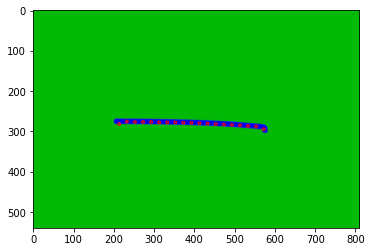

---- optimize translation ----
tensor([ 2.1361e+02,  2.5845e+02,  3.1311e-01, -4.8446e-02,  1.0676e-02,
        -2.0793e-02, -3.5474e-02,  8.5704e-03, -3.0555e-02, -2.4265e-02,
        -2.8416e-02, -3.2449e-02, -4.2514e-02, -4.6058e-02, -5.3738e-02,
        -6.6308e-02, -5.9805e-02, -1.0384e-01, -5.0282e-02, -3.3350e-01],
       device='cuda:0')
tensor(349.4948, device='cuda:0')
tensor([ 2.2048e+02,  2.6886e+02,  3.1311e-01, -4.8446e-02,  1.0676e-02,
        -2.0793e-02, -3.5474e-02,  8.5704e-03, -3.0555e-02, -2.4265e-02,
        -2.8416e-02, -3.2449e-02, -4.2514e-02, -4.6058e-02, -5.3738e-02,
        -6.6308e-02, -5.9805e-02, -1.0384e-01, -5.0282e-02, -3.3350e-01],
       device='cuda:0')
tensor(876.2069, device='cuda:0')
---- optimize rotation ----
tensor([ 2.1361e+02,  2.5845e+02,  3.1311e-01, -4.8446e-02,  1.0676e-02,
        -2.0793e-02, -3.5474e-02,  8.5704e-03, -3.0555e-02, -2.4265e-02,
        -2.8416e-02, -3.2449e-02, -4.2514e-02, -4.6058e-02, -5.3738e-02,
        -6.6308e-02,

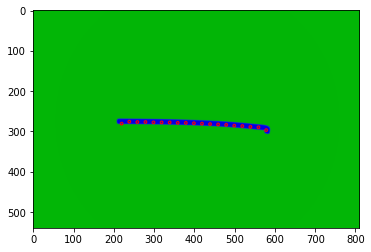

---- optimize translation ----
tensor([ 2.1974e+02,  2.5921e+02,  2.7745e-01, -5.4386e-02,  4.5368e-03,
        -4.3640e-02, -5.7822e-04, -1.7445e-02, -3.4790e-02, -1.9986e-02,
        -3.8048e-02, -4.2342e-02, -4.4294e-02, -5.9437e-02, -5.5096e-02,
        -8.5190e-02, -6.1459e-02, -1.2530e-01, -5.3215e-02, -3.4980e-01],
       device='cuda:0')
tensor(313.8100, device='cuda:0')
tensor([ 2.1998e+02,  2.6447e+02,  2.7745e-01, -5.4386e-02,  4.5368e-03,
        -4.3640e-02, -5.7822e-04, -1.7445e-02, -3.4790e-02, -1.9986e-02,
        -3.8048e-02, -4.2342e-02, -4.4294e-02, -5.9437e-02, -5.5096e-02,
        -8.5190e-02, -6.1459e-02, -1.2530e-01, -5.3215e-02, -3.4980e-01],
       device='cuda:0')
tensor(526.5812, device='cuda:0')
---- optimize rotation ----
tensor([ 2.1974e+02,  2.5921e+02,  2.7745e-01, -5.4386e-02,  4.5368e-03,
        -4.3640e-02, -5.7822e-04, -1.7445e-02, -3.4790e-02, -1.9986e-02,
        -3.8048e-02, -4.2342e-02, -4.4294e-02, -5.9437e-02, -5.5096e-02,
        -8.5190e-02,

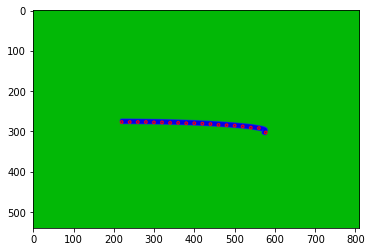

---- optimize translation ----
tensor([ 2.1995e+02,  2.6364e+02, -8.5388e-03,  1.7723e-03,  1.1383e-03,
        -5.7158e-02,  1.4781e-02, -3.6757e-02, -2.0466e-02, -3.9664e-02,
        -3.0346e-02, -4.7308e-02, -5.1999e-02, -6.0168e-02, -6.5820e-02,
        -7.8939e-02, -7.9611e-02, -1.2960e-01, -6.7263e-02, -5.7255e-01],
       device='cuda:0')
tensor(309.8811, device='cuda:0')
tensor([ 2.2151e+02,  2.6360e+02, -8.5388e-03,  1.7723e-03,  1.1383e-03,
        -5.7158e-02,  1.4781e-02, -3.6757e-02, -2.0466e-02, -3.9664e-02,
        -3.0346e-02, -4.7308e-02, -5.1999e-02, -6.0168e-02, -6.5820e-02,
        -7.8939e-02, -7.9611e-02, -1.2960e-01, -6.7263e-02, -5.7255e-01],
       device='cuda:0')
tensor(315.0887, device='cuda:0')
---- optimize rotation ----
tensor([ 2.1995e+02,  2.6364e+02, -8.5388e-03,  1.7723e-03,  1.1383e-03,
        -5.7158e-02,  1.4781e-02, -3.6757e-02, -2.0466e-02, -3.9664e-02,
        -3.0346e-02, -4.7308e-02, -5.1999e-02, -6.0168e-02, -6.5820e-02,
        -7.8939e-02,

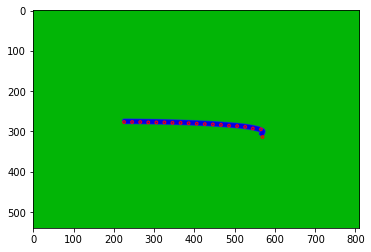

---- optimize translation ----
tensor([ 2.2551e+02,  2.6356e+02, -5.7185e-03,  9.5465e-03, -3.3160e-02,
        -3.0959e-02,  1.2750e-02, -5.8544e-02, -6.8115e-03, -4.6706e-02,
        -3.9402e-02, -4.8386e-02, -5.6535e-02, -6.1491e-02, -7.3581e-02,
        -8.2602e-02, -9.5176e-02, -2.0782e-01, -6.4490e-02, -1.3641e+00],
       device='cuda:0')
tensor(299.9518, device='cuda:0')
tensor([ 2.2477e+02,  2.6368e+02, -5.7185e-03,  9.5465e-03, -3.3160e-02,
        -3.0959e-02,  1.2750e-02, -5.8544e-02, -6.8115e-03, -4.6706e-02,
        -3.9402e-02, -4.8386e-02, -5.6535e-02, -6.1491e-02, -7.3581e-02,
        -8.2602e-02, -9.5176e-02, -2.0782e-01, -6.4490e-02, -1.3641e+00],
       device='cuda:0')
tensor(296.9015, device='cuda:0')
tensor([ 2.2467e+02,  2.6368e+02, -5.7185e-03,  9.5465e-03, -3.3160e-02,
        -3.0959e-02,  1.2750e-02, -5.8544e-02, -6.8115e-03, -4.6706e-02,
        -3.9402e-02, -4.8386e-02, -5.6535e-02, -6.1491e-02, -7.3581e-02,
        -8.2602e-02, -9.5176e-02, -2.0782e-01, -

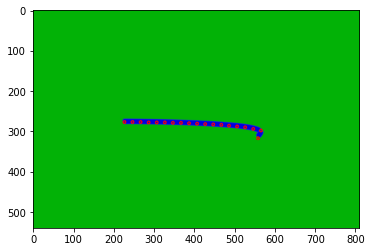

---- optimize translation ----
tensor([ 2.2624e+02,  2.6365e+02, -1.2064e-02,  1.2093e-02, -3.5087e-02,
        -2.9136e-02,  9.7248e-03, -5.7044e-02, -8.7219e-03, -4.7516e-02,
        -4.0214e-02, -4.8736e-02, -5.5834e-02, -6.6587e-02, -7.0570e-02,
        -8.7258e-02, -1.1636e-01, -1.9087e-01, -2.2222e-01, -1.9452e+00],
       device='cuda:0')
tensor(291.6622, device='cuda:0')
tensor([ 2.2377e+02,  2.6360e+02, -1.2064e-02,  1.2093e-02, -3.5087e-02,
        -2.9136e-02,  9.7248e-03, -5.7044e-02, -8.7219e-03, -4.7516e-02,
        -4.0214e-02, -4.8736e-02, -5.5834e-02, -6.6587e-02, -7.0570e-02,
        -8.7258e-02, -1.1636e-01, -1.9087e-01, -2.2222e-01, -1.9452e+00],
       device='cuda:0')
tensor(284.1218, device='cuda:0')
tensor([ 2.2420e+02,  2.6360e+02, -1.2064e-02,  1.2093e-02, -3.5087e-02,
        -2.9136e-02,  9.7248e-03, -5.7044e-02, -8.7219e-03, -4.7516e-02,
        -4.0214e-02, -4.8736e-02, -5.5834e-02, -6.6587e-02, -7.0570e-02,
        -8.7258e-02, -1.1636e-01, -1.9087e-01, -

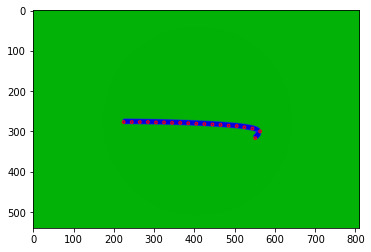

---- optimize translation ----
tensor([ 2.2439e+02,  2.6359e+02, -8.1796e-03,  1.0727e-02, -2.7061e-02,
        -4.1282e-02,  2.2384e-02, -6.7501e-02,  1.3409e-03, -5.3150e-02,
        -3.6107e-02, -5.0054e-02, -5.5541e-02, -6.2978e-02, -7.5804e-02,
        -7.6410e-02, -1.2852e-01, -1.4893e-01, -3.7022e-01, -2.1759e+00],
       device='cuda:0')
tensor(291.6395, device='cuda:0')
tensor([ 2.2294e+02,  2.6361e+02, -8.1796e-03,  1.0727e-02, -2.7061e-02,
        -4.1282e-02,  2.2384e-02, -6.7501e-02,  1.3409e-03, -5.3150e-02,
        -3.6107e-02, -5.0054e-02, -5.5541e-02, -6.2978e-02, -7.5804e-02,
        -7.6410e-02, -1.2852e-01, -1.4893e-01, -3.7022e-01, -2.1759e+00],
       device='cuda:0')
tensor(286.9998, device='cuda:0')
tensor([ 2.2274e+02,  2.6361e+02, -8.1796e-03,  1.0727e-02, -2.7061e-02,
        -4.1282e-02,  2.2384e-02, -6.7501e-02,  1.3409e-03, -5.3150e-02,
        -3.6107e-02, -5.0054e-02, -5.5541e-02, -6.2978e-02, -7.5804e-02,
        -7.6410e-02, -1.2852e-01, -1.4893e-01, -

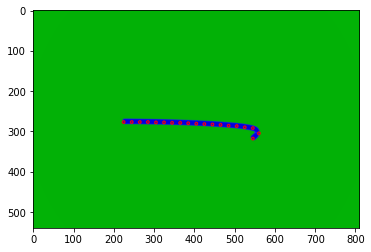

---- optimize translation ----
tensor([ 2.2483e+02,  2.6358e+02, -7.6785e-03,  1.0694e-02, -2.8984e-02,
        -3.8350e-02,  1.9431e-02, -6.5150e-02, -9.0319e-04, -5.1725e-02,
        -3.7071e-02, -4.9790e-02, -5.6249e-02, -6.1678e-02, -8.0622e-02,
        -6.6733e-02, -1.5716e-01, -7.7443e-02, -7.2098e-01, -2.4263e+00],
       device='cuda:0')
tensor(294.5729, device='cuda:0')
tensor([ 2.2248e+02,  2.6362e+02, -7.6785e-03,  1.0694e-02, -2.8984e-02,
        -3.8350e-02,  1.9431e-02, -6.5150e-02, -9.0319e-04, -5.1725e-02,
        -3.7071e-02, -4.9790e-02, -5.6249e-02, -6.1678e-02, -8.0622e-02,
        -6.6733e-02, -1.5716e-01, -7.7443e-02, -7.2098e-01, -2.4263e+00],
       device='cuda:0')
tensor(286.4734, device='cuda:0')
tensor([ 2.2227e+02,  2.6362e+02, -7.6785e-03,  1.0694e-02, -2.8984e-02,
        -3.8350e-02,  1.9431e-02, -6.5150e-02, -9.0319e-04, -5.1725e-02,
        -3.7071e-02, -4.9790e-02, -5.6249e-02, -6.1678e-02, -8.0622e-02,
        -6.6733e-02, -1.5716e-01, -7.7443e-02, -

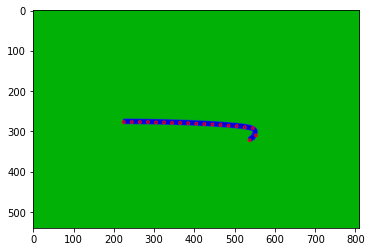

---- optimize translation ----
tensor([ 2.2476e+02,  2.6359e+02, -8.0246e-03,  1.0955e-02, -2.8805e-02,
        -3.8948e-02,  2.0067e-02, -6.4986e-02, -3.3044e-03, -4.9284e-02,
        -3.9814e-02, -4.7149e-02, -5.8033e-02, -5.9932e-02, -8.2409e-02,
        -6.7064e-02, -1.6229e-01, -5.9998e-02, -1.1338e+00, -2.5150e+00],
       device='cuda:0')
tensor(293.0096, device='cuda:0')
tensor([ 2.2379e+02,  2.6364e+02, -8.0246e-03,  1.0955e-02, -2.8805e-02,
        -3.8948e-02,  2.0067e-02, -6.4986e-02, -3.3044e-03, -4.9284e-02,
        -3.9814e-02, -4.7149e-02, -5.8033e-02, -5.9932e-02, -8.2409e-02,
        -6.7064e-02, -1.6229e-01, -5.9998e-02, -1.1338e+00, -2.5150e+00],
       device='cuda:0')
tensor(289.1191, device='cuda:0')
tensor([ 2.2386e+02,  2.6364e+02, -8.0246e-03,  1.0955e-02, -2.8805e-02,
        -3.8948e-02,  2.0067e-02, -6.4986e-02, -3.3044e-03, -4.9284e-02,
        -3.9814e-02, -4.7149e-02, -5.8033e-02, -5.9932e-02, -8.2409e-02,
        -6.7064e-02, -1.6229e-01, -5.9998e-02, -

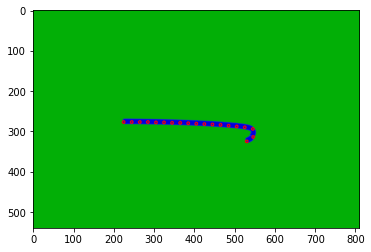

---- optimize translation ----
tensor([ 2.2493e+02,  2.6363e+02, -1.0999e-02,  1.2143e-02, -3.0001e-02,
        -3.7746e-02,  1.9126e-02, -6.4409e-02, -3.8393e-03, -4.9184e-02,
        -3.9251e-02, -4.9469e-02, -5.7819e-02, -5.9038e-02, -7.9212e-02,
        -8.2318e-02, -1.2956e-01, -2.0403e-01, -1.4834e+00, -2.5545e+00],
       device='cuda:0')
tensor(293.5588, device='cuda:0')
tensor([ 2.2379e+02,  2.6366e+02, -1.0999e-02,  1.2143e-02, -3.0001e-02,
        -3.7746e-02,  1.9126e-02, -6.4409e-02, -3.8393e-03, -4.9184e-02,
        -3.9251e-02, -4.9469e-02, -5.7819e-02, -5.9038e-02, -7.9212e-02,
        -8.2318e-02, -1.2956e-01, -2.0403e-01, -1.4834e+00, -2.5545e+00],
       device='cuda:0')
tensor(288.5033, device='cuda:0')
tensor([ 2.2405e+02,  2.6366e+02, -1.0999e-02,  1.2143e-02, -3.0001e-02,
        -3.7746e-02,  1.9126e-02, -6.4409e-02, -3.8393e-03, -4.9184e-02,
        -3.9251e-02, -4.9469e-02, -5.7819e-02, -5.9038e-02, -7.9212e-02,
        -8.2318e-02, -1.2956e-01, -2.0403e-01, -

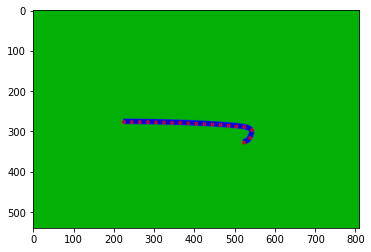

---- optimize translation ----
tensor([ 2.2434e+02,  2.6366e+02, -1.2878e-02,  1.2577e-02, -2.7305e-02,
        -4.2168e-02,  2.3693e-02, -6.8144e-02, -2.0702e-04, -5.1592e-02,
        -3.7627e-02, -5.0219e-02, -5.5831e-02, -6.3863e-02, -7.0711e-02,
        -9.8082e-02, -8.8415e-02, -3.8871e-01, -1.7481e+00, -2.5122e+00],
       device='cuda:0')
tensor(293.6788, device='cuda:0')
tensor([ 2.2387e+02,  2.6366e+02, -1.2878e-02,  1.2577e-02, -2.7305e-02,
        -4.2168e-02,  2.3693e-02, -6.8144e-02, -2.0702e-04, -5.1592e-02,
        -3.7627e-02, -5.0219e-02, -5.5831e-02, -6.3863e-02, -7.0711e-02,
        -9.8082e-02, -8.8415e-02, -3.8871e-01, -1.7481e+00, -2.5122e+00],
       device='cuda:0')
tensor(291.1900, device='cuda:0')
tensor([ 2.2386e+02,  2.6367e+02, -1.2878e-02,  1.2577e-02, -2.7305e-02,
        -4.2168e-02,  2.3693e-02, -6.8144e-02, -2.0702e-04, -5.1592e-02,
        -3.7627e-02, -5.0219e-02, -5.5831e-02, -6.3863e-02, -7.0711e-02,
        -9.8082e-02, -8.8415e-02, -3.8871e-01, -

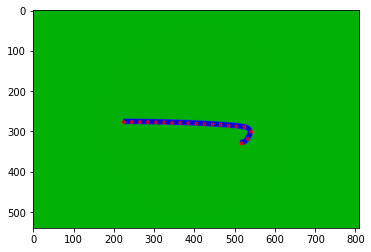

---- optimize translation ----
tensor([ 2.2432e+02,  2.6366e+02, -1.2915e-02,  1.2585e-02, -2.7232e-02,
        -4.2268e-02,  2.3768e-02, -6.8179e-02, -1.6211e-04, -5.1637e-02,
        -3.7526e-02, -5.0459e-02, -5.5146e-02, -6.5668e-02, -6.6735e-02,
        -1.1334e-01, -5.1717e-02, -6.1504e-01, -1.9529e+00, -2.5462e+00],
       device='cuda:0')
tensor(296.7620, device='cuda:0')
tensor([ 2.2441e+02,  2.6366e+02, -1.2915e-02,  1.2585e-02, -2.7232e-02,
        -4.2268e-02,  2.3768e-02, -6.8179e-02, -1.6211e-04, -5.1637e-02,
        -3.7526e-02, -5.0459e-02, -5.5146e-02, -6.5668e-02, -6.6735e-02,
        -1.1334e-01, -5.1717e-02, -6.1504e-01, -1.9529e+00, -2.5462e+00],
       device='cuda:0')
tensor(297.3602, device='cuda:0')
---- optimize rotation ----
tensor([ 2.2432e+02,  2.6366e+02, -1.2915e-02,  1.2585e-02, -2.7232e-02,
        -4.2268e-02,  2.3768e-02, -6.8179e-02, -1.6211e-04, -5.1637e-02,
        -3.7526e-02, -5.0459e-02, -5.5146e-02, -6.5668e-02, -6.6735e-02,
        -1.1334e-01,

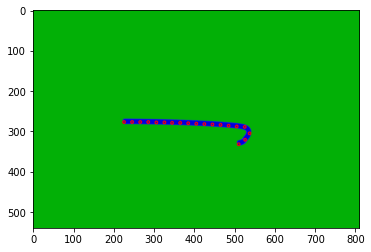

---- optimize translation ----
tensor([ 2.2504e+02,  2.6364e+02, -1.1791e-02,  1.2586e-02, -3.0875e-02,
        -3.6215e-02,  1.6101e-02, -6.1754e-02, -6.5027e-03, -4.5647e-02,
        -4.2376e-02, -4.8219e-02, -5.5491e-02, -6.7649e-02, -6.3047e-02,
        -1.2514e-01, -4.1553e-02, -9.0658e-01, -2.1505e+00, -2.5805e+00],
       device='cuda:0')
tensor(298.4116, device='cuda:0')
tensor([ 2.2459e+02,  2.6360e+02, -1.1791e-02,  1.2586e-02, -3.0875e-02,
        -3.6215e-02,  1.6101e-02, -6.1754e-02, -6.5027e-03, -4.5647e-02,
        -4.2376e-02, -4.8219e-02, -5.5491e-02, -6.7649e-02, -6.3047e-02,
        -1.2514e-01, -4.1553e-02, -9.0658e-01, -2.1505e+00, -2.5805e+00],
       device='cuda:0')
tensor(295.5287, device='cuda:0')
tensor([ 2.2462e+02,  2.6361e+02, -1.1791e-02,  1.2586e-02, -3.0875e-02,
        -3.6215e-02,  1.6101e-02, -6.1754e-02, -6.5027e-03, -4.5647e-02,
        -4.2376e-02, -4.8219e-02, -5.5491e-02, -6.7649e-02, -6.3047e-02,
        -1.2514e-01, -4.1553e-02, -9.0658e-01, -

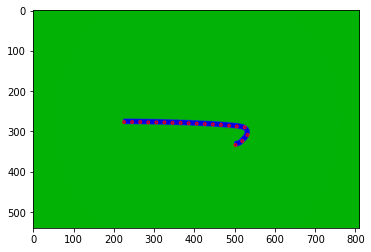

---- optimize translation ----
tensor([ 2.2534e+02,  2.6359e+02, -8.6171e-03,  1.2593e-02, -3.6304e-02,
        -2.9507e-02,  1.0827e-02, -5.7120e-02, -1.8771e-02, -3.1686e-02,
        -5.2735e-02, -4.1508e-02, -5.6752e-02, -6.8448e-02, -6.6292e-02,
        -1.1980e-01, -8.8975e-02, -1.2096e+00, -2.2898e+00, -2.6036e+00],
       device='cuda:0')
tensor(298.2793, device='cuda:0')
tensor([ 2.2505e+02,  2.6359e+02, -8.6171e-03,  1.2593e-02, -3.6304e-02,
        -2.9507e-02,  1.0827e-02, -5.7120e-02, -1.8771e-02, -3.1686e-02,
        -5.2735e-02, -4.1508e-02, -5.6752e-02, -6.8448e-02, -6.6292e-02,
        -1.1980e-01, -8.8975e-02, -1.2096e+00, -2.2898e+00, -2.6036e+00],
       device='cuda:0')
tensor(296.3543, device='cuda:0')
tensor([ 2.2511e+02,  2.6358e+02, -8.6171e-03,  1.2593e-02, -3.6304e-02,
        -2.9507e-02,  1.0827e-02, -5.7120e-02, -1.8771e-02, -3.1686e-02,
        -5.2735e-02, -4.1508e-02, -5.6752e-02, -6.8448e-02, -6.6292e-02,
        -1.1980e-01, -8.8975e-02, -1.2096e+00, -

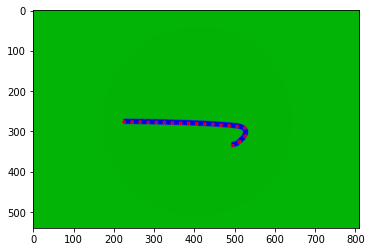

---- optimize translation ----
tensor([ 2.2565e+02,  2.6358e+02, -8.1962e-03,  1.3867e-02, -4.1462e-02,
        -2.2482e-02,  1.2050e-03, -4.9411e-02, -2.3535e-02, -2.9813e-02,
        -5.3533e-02, -3.4722e-02, -6.5892e-02, -6.7708e-02, -6.7584e-02,
        -1.0735e-01, -2.0374e-01, -1.5172e+00, -2.3613e+00, -2.6366e+00],
       device='cuda:0')
tensor(298.9641, device='cuda:0')
tensor([ 2.2523e+02,  2.6360e+02, -8.1962e-03,  1.3867e-02, -4.1462e-02,
        -2.2482e-02,  1.2050e-03, -4.9411e-02, -2.3535e-02, -2.9813e-02,
        -5.3533e-02, -3.4722e-02, -6.5892e-02, -6.7708e-02, -6.7584e-02,
        -1.0735e-01, -2.0374e-01, -1.5172e+00, -2.3613e+00, -2.6366e+00],
       device='cuda:0')
tensor(296.0103, device='cuda:0')
tensor([ 2.2536e+02,  2.6360e+02, -8.1962e-03,  1.3867e-02, -4.1462e-02,
        -2.2482e-02,  1.2050e-03, -4.9411e-02, -2.3535e-02, -2.9813e-02,
        -5.3533e-02, -3.4722e-02, -6.5892e-02, -6.7708e-02, -6.7584e-02,
        -1.0735e-01, -2.0374e-01, -1.5172e+00, -

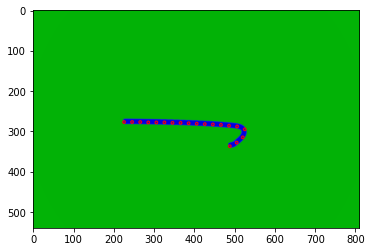

---- optimize translation ----
tensor([ 2.2582e+02,  2.6359e+02, -9.3500e-03,  1.4449e-02, -4.2149e-02,
        -2.2789e-02,  4.8603e-03, -5.2943e-02, -1.9972e-02, -3.5462e-02,
        -4.8074e-02, -4.0305e-02, -6.4202e-02, -6.3783e-02, -7.8904e-02,
        -8.5687e-02, -3.7733e-01, -1.8026e+00, -2.3890e+00, -2.6689e+00],
       device='cuda:0')
tensor(299.7620, device='cuda:0')
tensor([ 2.2514e+02,  2.6359e+02, -9.3500e-03,  1.4449e-02, -4.2149e-02,
        -2.2789e-02,  4.8603e-03, -5.2943e-02, -1.9972e-02, -3.5462e-02,
        -4.8074e-02, -4.0305e-02, -6.4202e-02, -6.3783e-02, -7.8904e-02,
        -8.5687e-02, -3.7733e-01, -1.8026e+00, -2.3890e+00, -2.6689e+00],
       device='cuda:0')
tensor(295.2951, device='cuda:0')
tensor([ 2.2539e+02,  2.6359e+02, -9.3500e-03,  1.4449e-02, -4.2149e-02,
        -2.2789e-02,  4.8603e-03, -5.2943e-02, -1.9972e-02, -3.5462e-02,
        -4.8074e-02, -4.0305e-02, -6.4202e-02, -6.3783e-02, -7.8904e-02,
        -8.5687e-02, -3.7733e-01, -1.8026e+00, -

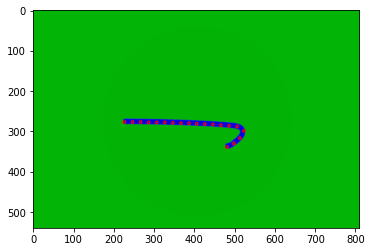

---- optimize translation ----
tensor([ 2.2608e+02,  2.6357e+02, -8.1370e-03,  1.4739e-02, -4.5736e-02,
        -1.8536e-02,  1.9588e-03, -5.0817e-02, -2.6523e-02, -2.8733e-02,
        -5.0581e-02, -3.7815e-02, -6.9763e-02, -6.0952e-02, -8.7865e-02,
        -6.7385e-02, -6.1530e-01, -2.0440e+00, -2.4182e+00, -2.6787e+00],
       device='cuda:0')
tensor(301.5151, device='cuda:0')
tensor([ 2.2516e+02,  2.6361e+02, -8.1370e-03,  1.4739e-02, -4.5736e-02,
        -1.8536e-02,  1.9588e-03, -5.0817e-02, -2.6523e-02, -2.8733e-02,
        -5.0581e-02, -3.7815e-02, -6.9763e-02, -6.0952e-02, -8.7865e-02,
        -6.7385e-02, -6.1530e-01, -2.0440e+00, -2.4182e+00, -2.6787e+00],
       device='cuda:0')
tensor(295.2014, device='cuda:0')
tensor([ 2.2544e+02,  2.6360e+02, -8.1370e-03,  1.4739e-02, -4.5736e-02,
        -1.8536e-02,  1.9588e-03, -5.0817e-02, -2.6523e-02, -2.8733e-02,
        -5.0581e-02, -3.7815e-02, -6.9763e-02, -6.0952e-02, -8.7865e-02,
        -6.7385e-02, -6.1530e-01, -2.0440e+00, -

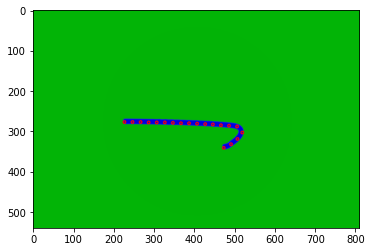

---- optimize translation ----
tensor([ 2.2613e+02,  2.6360e+02, -1.0195e-02,  1.6894e-02, -4.8238e-02,
        -1.7025e-02,  1.5843e-03, -5.1386e-02, -2.3654e-02, -3.1876e-02,
        -4.9451e-02, -3.8361e-02, -7.3862e-02, -5.6498e-02, -9.4994e-02,
        -6.4327e-02, -8.9724e-01, -2.2193e+00, -2.4356e+00, -2.6915e+00],
       device='cuda:0')
tensor(301.5463, device='cuda:0')
tensor([ 2.2559e+02,  2.6366e+02, -1.0195e-02,  1.6894e-02, -4.8238e-02,
        -1.7025e-02,  1.5843e-03, -5.1386e-02, -2.3654e-02, -3.1876e-02,
        -4.9451e-02, -3.8361e-02, -7.3862e-02, -5.6498e-02, -9.4994e-02,
        -6.4327e-02, -8.9724e-01, -2.2193e+00, -2.4356e+00, -2.6915e+00],
       device='cuda:0')
tensor(297.5640, device='cuda:0')
tensor([ 2.2564e+02,  2.6366e+02, -1.0195e-02,  1.6894e-02, -4.8238e-02,
        -1.7025e-02,  1.5843e-03, -5.1386e-02, -2.3654e-02, -3.1876e-02,
        -4.9451e-02, -3.8361e-02, -7.3862e-02, -5.6498e-02, -9.4994e-02,
        -6.4327e-02, -8.9724e-01, -2.2193e+00, -

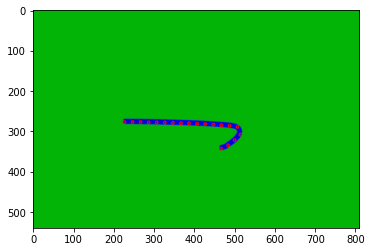

---- optimize translation ----
tensor([ 2.2664e+02,  2.6364e+02, -1.3214e-02,  1.8900e-02, -5.2375e-02,
        -1.2280e-02, -2.5862e-03, -4.8316e-02, -2.6157e-02, -3.0706e-02,
        -4.9744e-02, -3.9008e-02, -7.3557e-02, -5.8584e-02, -9.1387e-02,
        -1.1554e-01, -1.2224e+00, -2.3396e+00, -2.4573e+00, -2.7042e+00],
       device='cuda:0')
tensor(301.5036, device='cuda:0')
tensor([ 2.2617e+02,  2.6364e+02, -1.3214e-02,  1.8900e-02, -5.2375e-02,
        -1.2280e-02, -2.5862e-03, -4.8316e-02, -2.6157e-02, -3.0706e-02,
        -4.9744e-02, -3.9008e-02, -7.3557e-02, -5.8584e-02, -9.1387e-02,
        -1.1554e-01, -1.2224e+00, -2.3396e+00, -2.4573e+00, -2.7042e+00],
       device='cuda:0')
tensor(298.0038, device='cuda:0')
tensor([ 2.2626e+02,  2.6364e+02, -1.3214e-02,  1.8900e-02, -5.2375e-02,
        -1.2280e-02, -2.5862e-03, -4.8316e-02, -2.6157e-02, -3.0706e-02,
        -4.9744e-02, -3.9008e-02, -7.3557e-02, -5.8584e-02, -9.1387e-02,
        -1.1554e-01, -1.2224e+00, -2.3396e+00, -

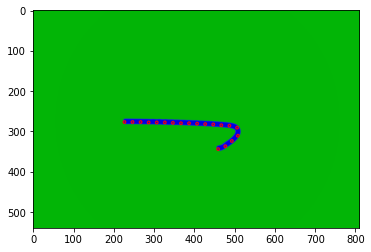

---- optimize translation ----
tensor([ 2.2676e+02,  2.6362e+02, -1.1820e-02,  1.7824e-02, -4.8743e-02,
        -1.4536e-02, -2.6045e-03, -4.8733e-02, -2.7130e-02, -2.9906e-02,
        -5.0796e-02, -4.2070e-02, -6.7345e-02, -6.5006e-02, -8.1193e-02,
        -2.2645e-01, -1.5124e+00, -2.3978e+00, -2.4838e+00, -2.7340e+00],
       device='cuda:0')
tensor(301.6928, device='cuda:0')
tensor([ 2.2620e+02,  2.6359e+02, -1.1820e-02,  1.7824e-02, -4.8743e-02,
        -1.4536e-02, -2.6045e-03, -4.8733e-02, -2.7130e-02, -2.9906e-02,
        -5.0796e-02, -4.2070e-02, -6.7345e-02, -6.5006e-02, -8.1193e-02,
        -2.2645e-01, -1.5124e+00, -2.3978e+00, -2.4838e+00, -2.7340e+00],
       device='cuda:0')
tensor(297.5646, device='cuda:0')
tensor([ 2.2637e+02,  2.6358e+02, -1.1820e-02,  1.7824e-02, -4.8743e-02,
        -1.4536e-02, -2.6045e-03, -4.8733e-02, -2.7130e-02, -2.9906e-02,
        -5.0796e-02, -4.2070e-02, -6.7345e-02, -6.5006e-02, -8.1193e-02,
        -2.2645e-01, -1.5124e+00, -2.3978e+00, -

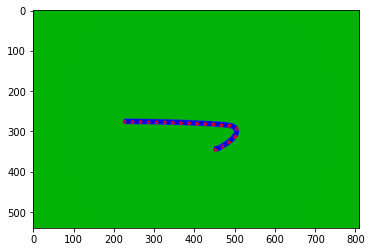

---- optimize translation ----
tensor([ 2.2682e+02,  2.6357e+02, -7.8155e-03,  1.5209e-02, -4.2641e-02,
        -1.9574e-02, -2.6967e-03, -4.7535e-02, -3.0492e-02, -2.6746e-02,
        -5.1334e-02, -4.1362e-02, -6.6654e-02, -7.4852e-02, -6.2960e-02,
        -4.0990e-01, -1.7781e+00, -2.4316e+00, -2.5238e+00, -2.7387e+00],
       device='cuda:0')
tensor(302.0331, device='cuda:0')
tensor([ 2.2627e+02,  2.6360e+02, -7.8155e-03,  1.5209e-02, -4.2641e-02,
        -1.9574e-02, -2.6967e-03, -4.7535e-02, -3.0492e-02, -2.6746e-02,
        -5.1334e-02, -4.1362e-02, -6.6654e-02, -7.4852e-02, -6.2960e-02,
        -4.0990e-01, -1.7781e+00, -2.4316e+00, -2.5238e+00, -2.7387e+00],
       device='cuda:0')
tensor(297.6676, device='cuda:0')
tensor([ 2.2634e+02,  2.6360e+02, -7.8155e-03,  1.5209e-02, -4.2641e-02,
        -1.9574e-02, -2.6967e-03, -4.7535e-02, -3.0492e-02, -2.6746e-02,
        -5.1334e-02, -4.1362e-02, -6.6654e-02, -7.4852e-02, -6.2960e-02,
        -4.0990e-01, -1.7781e+00, -2.4316e+00, -

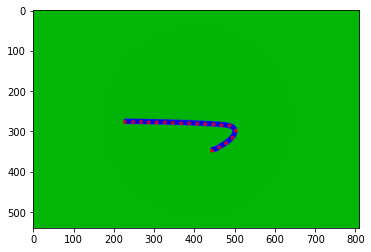

---- optimize translation ----
tensor([ 2.2700e+02,  2.6359e+02, -8.2756e-03,  1.2372e-02, -4.3033e-02,
        -1.8613e-02, -1.9616e-03, -4.6784e-02, -3.3511e-02, -2.0594e-02,
        -5.9309e-02, -3.8301e-02, -7.0351e-02, -7.6505e-02, -5.7460e-02,
        -6.5045e-01, -2.0122e+00, -2.4510e+00, -2.5670e+00, -2.7369e+00],
       device='cuda:0')
tensor(302.0840, device='cuda:0')
tensor([ 2.2632e+02,  2.6360e+02, -8.2756e-03,  1.2372e-02, -4.3033e-02,
        -1.8613e-02, -1.9616e-03, -4.6784e-02, -3.3511e-02, -2.0594e-02,
        -5.9309e-02, -3.8301e-02, -7.0351e-02, -7.6505e-02, -5.7460e-02,
        -6.5045e-01, -2.0122e+00, -2.4510e+00, -2.5670e+00, -2.7369e+00],
       device='cuda:0')
tensor(296.6918, device='cuda:0')
tensor([ 2.2637e+02,  2.6359e+02, -8.2756e-03,  1.2372e-02, -4.3033e-02,
        -1.8613e-02, -1.9616e-03, -4.6784e-02, -3.3511e-02, -2.0594e-02,
        -5.9309e-02, -3.8301e-02, -7.0351e-02, -7.6505e-02, -5.7460e-02,
        -6.5045e-01, -2.0122e+00, -2.4510e+00, -

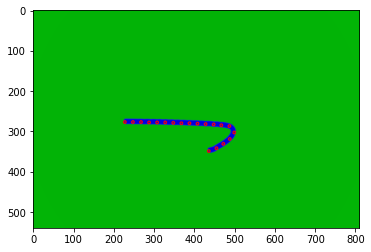

---- optimize translation ----
tensor([ 2.2720e+02,  2.6358e+02, -6.5788e-03,  7.1467e-03, -3.5682e-02,
        -2.3116e-02, -1.1956e-03, -4.6146e-02, -3.4357e-02, -2.0504e-02,
        -6.0458e-02, -3.6071e-02, -6.8451e-02, -8.8080e-02, -7.5738e-02,
        -9.3359e-01, -2.1839e+00, -2.4890e+00, -2.5837e+00, -2.7575e+00],
       device='cuda:0')
tensor(300.6544, device='cuda:0')
tensor([ 2.2716e+02,  2.6357e+02, -6.5788e-03,  7.1467e-03, -3.5682e-02,
        -2.3116e-02, -1.1956e-03, -4.6146e-02, -3.4357e-02, -2.0504e-02,
        -6.0458e-02, -3.6071e-02, -6.8451e-02, -8.8080e-02, -7.5738e-02,
        -9.3359e-01, -2.1839e+00, -2.4890e+00, -2.5837e+00, -2.7575e+00],
       device='cuda:0')
tensor(300.3239, device='cuda:0')
tensor([ 2.2718e+02,  2.6357e+02, -6.5788e-03,  7.1467e-03, -3.5682e-02,
        -2.3116e-02, -1.1956e-03, -4.6146e-02, -3.4357e-02, -2.0504e-02,
        -6.0458e-02, -3.6071e-02, -6.8451e-02, -8.8080e-02, -7.5738e-02,
        -9.3359e-01, -2.1839e+00, -2.4890e+00, -

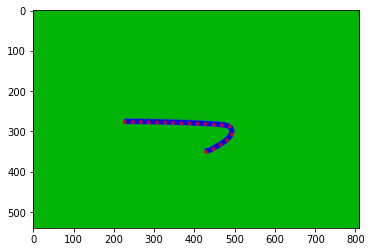

---- optimize translation ----
tensor([ 2.2788e+02,  2.6356e+02, -3.6332e-03,  5.0627e-04, -3.7668e-02,
        -1.3100e-02, -9.6254e-03, -3.9847e-02, -3.7674e-02, -1.9419e-02,
        -6.1154e-02, -3.5555e-02, -7.0826e-02, -8.3666e-02, -1.2276e-01,
        -1.2514e+00, -2.2957e+00, -2.5140e+00, -2.6034e+00, -2.7610e+00],
       device='cuda:0')
tensor(300.5709, device='cuda:0')
tensor([ 2.2759e+02,  2.6356e+02, -3.6332e-03,  5.0627e-04, -3.7668e-02,
        -1.3100e-02, -9.6254e-03, -3.9847e-02, -3.7674e-02, -1.9419e-02,
        -6.1154e-02, -3.5555e-02, -7.0826e-02, -8.3666e-02, -1.2276e-01,
        -1.2514e+00, -2.2957e+00, -2.5140e+00, -2.6034e+00, -2.7610e+00],
       device='cuda:0')
tensor(298.2187, device='cuda:0')
tensor([ 2.2767e+02,  2.6356e+02, -3.6332e-03,  5.0627e-04, -3.7668e-02,
        -1.3100e-02, -9.6254e-03, -3.9847e-02, -3.7674e-02, -1.9419e-02,
        -6.1154e-02, -3.5555e-02, -7.0826e-02, -8.3666e-02, -1.2276e-01,
        -1.2514e+00, -2.2957e+00, -2.5140e+00, -

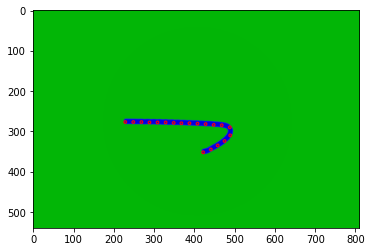

---- optimize translation ----
tensor([ 2.2804e+02,  2.6356e+02, -3.6047e-03,  4.5375e-04, -3.8187e-02,
        -1.2204e-02, -1.0533e-02, -3.9391e-02, -3.7525e-02, -2.1117e-02,
        -5.5859e-02, -4.3002e-02, -6.8857e-02, -7.3214e-02, -2.3275e-01,
        -1.5203e+00, -2.3525e+00, -2.5493e+00, -2.6142e+00, -2.7656e+00],
       device='cuda:0')
tensor(303.6515, device='cuda:0')
tensor([ 2.2790e+02,  2.6355e+02, -3.6047e-03,  4.5375e-04, -3.8187e-02,
        -1.2204e-02, -1.0533e-02, -3.9391e-02, -3.7525e-02, -2.1117e-02,
        -5.5859e-02, -4.3002e-02, -6.8857e-02, -7.3214e-02, -2.3275e-01,
        -1.5203e+00, -2.3525e+00, -2.5493e+00, -2.6142e+00, -2.7656e+00],
       device='cuda:0')
tensor(302.4986, device='cuda:0')
tensor([ 2.2791e+02,  2.6356e+02, -3.6047e-03,  4.5375e-04, -3.8187e-02,
        -1.2204e-02, -1.0533e-02, -3.9391e-02, -3.7525e-02, -2.1117e-02,
        -5.5859e-02, -4.3002e-02, -6.8857e-02, -7.3214e-02, -2.3275e-01,
        -1.5203e+00, -2.3525e+00, -2.5493e+00, -

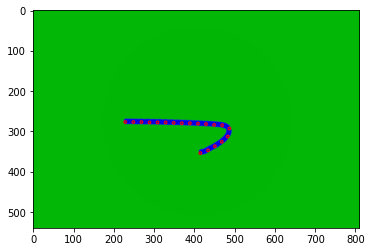

---- optimize translation ----
tensor([ 2.2836e+02,  2.6355e+02, -2.4499e-03, -2.2800e-03, -3.7208e-02,
        -1.0463e-02, -1.2697e-02, -3.7792e-02, -3.8563e-02, -2.0618e-02,
        -5.7327e-02, -4.2919e-02, -7.1066e-02, -5.7293e-02, -4.2301e-01,
        -1.7832e+00, -2.3966e+00, -2.5751e+00, -2.6309e+00, -2.7686e+00],
       device='cuda:0')
tensor(305.1079, device='cuda:0')
tensor([ 2.2787e+02,  2.6355e+02, -2.4499e-03, -2.2800e-03, -3.7208e-02,
        -1.0463e-02, -1.2697e-02, -3.7792e-02, -3.8563e-02, -2.0618e-02,
        -5.7327e-02, -4.2919e-02, -7.1066e-02, -5.7293e-02, -4.2301e-01,
        -1.7832e+00, -2.3966e+00, -2.5751e+00, -2.6309e+00, -2.7686e+00],
       device='cuda:0')
tensor(300.8891, device='cuda:0')
tensor([ 2.2794e+02,  2.6356e+02, -2.4499e-03, -2.2800e-03, -3.7208e-02,
        -1.0463e-02, -1.2697e-02, -3.7792e-02, -3.8563e-02, -2.0618e-02,
        -5.7327e-02, -4.2919e-02, -7.1066e-02, -5.7293e-02, -4.2301e-01,
        -1.7832e+00, -2.3966e+00, -2.5751e+00, -

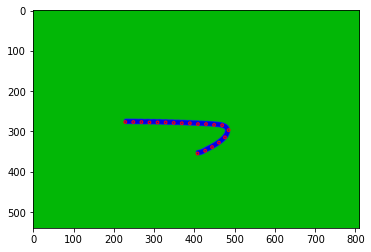

---- optimize translation ----
tensor([ 2.2850e+02,  2.6355e+02, -2.8789e-03, -1.0815e-03, -3.9535e-02,
        -8.1235e-03, -1.3012e-02, -3.8506e-02, -3.7950e-02, -1.8911e-02,
        -6.8528e-02, -3.2192e-02, -8.0692e-02, -4.7968e-02, -6.5419e-01,
        -2.0027e+00, -2.4242e+00, -2.6014e+00, -2.6359e+00, -2.7773e+00],
       device='cuda:0')
tensor(305.2733, device='cuda:0')
tensor([ 2.2810e+02,  2.6353e+02, -2.8789e-03, -1.0815e-03, -3.9535e-02,
        -8.1235e-03, -1.3012e-02, -3.8506e-02, -3.7950e-02, -1.8911e-02,
        -6.8528e-02, -3.2192e-02, -8.0692e-02, -4.7968e-02, -6.5419e-01,
        -2.0027e+00, -2.4242e+00, -2.6014e+00, -2.6359e+00, -2.7773e+00],
       device='cuda:0')
tensor(301.9856, device='cuda:0')
tensor([ 2.2828e+02,  2.6354e+02, -2.8789e-03, -1.0815e-03, -3.9535e-02,
        -8.1235e-03, -1.3012e-02, -3.8506e-02, -3.7950e-02, -1.8911e-02,
        -6.8528e-02, -3.2192e-02, -8.0692e-02, -4.7968e-02, -6.5419e-01,
        -2.0027e+00, -2.4242e+00, -2.6014e+00, -

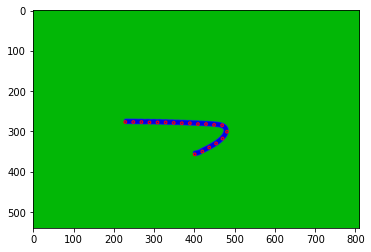

---- optimize translation ----
tensor([ 2.2883e+02,  2.6353e+02, -1.4629e-03, -2.1057e-03, -3.9674e-02,
        -6.8469e-03, -1.4923e-02, -3.7114e-02, -3.8709e-02, -1.9044e-02,
        -6.8375e-02, -3.3854e-02, -8.5425e-02, -5.3307e-02, -9.3131e-01,
        -2.1676e+00, -2.4485e+00, -2.6246e+00, -2.6300e+00, -2.7946e+00],
       device='cuda:0')
tensor(306.5680, device='cuda:0')
tensor([ 2.2859e+02,  2.6353e+02, -1.4629e-03, -2.1057e-03, -3.9674e-02,
        -6.8469e-03, -1.4923e-02, -3.7114e-02, -3.8709e-02, -1.9044e-02,
        -6.8375e-02, -3.3854e-02, -8.5425e-02, -5.3307e-02, -9.3131e-01,
        -2.1676e+00, -2.4485e+00, -2.6246e+00, -2.6300e+00, -2.7946e+00],
       device='cuda:0')
tensor(304.4372, device='cuda:0')
tensor([ 2.2860e+02,  2.6353e+02, -1.4629e-03, -2.1057e-03, -3.9674e-02,
        -6.8469e-03, -1.4923e-02, -3.7114e-02, -3.8709e-02, -1.9044e-02,
        -6.8375e-02, -3.3854e-02, -8.5425e-02, -5.3307e-02, -9.3131e-01,
        -2.1676e+00, -2.4485e+00, -2.6246e+00, -

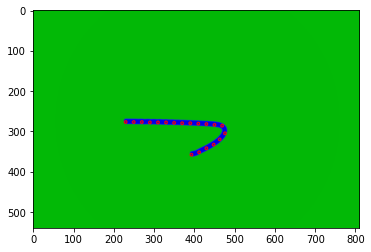

---- optimize translation ----
tensor([ 2.2919e+02,  2.6353e+02, -1.0680e-03, -3.0802e-03, -3.9364e-02,
        -6.5464e-03, -1.4197e-02, -3.8326e-02, -3.7928e-02, -2.2485e-02,
        -5.9192e-02, -4.3508e-02, -7.6473e-02, -1.2069e-01, -1.2188e+00,
        -2.2799e+00, -2.4773e+00, -2.6374e+00, -2.6530e+00, -2.8014e+00],
       device='cuda:0')
tensor(308.3369, device='cuda:0')
tensor([ 2.2892e+02,  2.6353e+02, -1.0680e-03, -3.0802e-03, -3.9364e-02,
        -6.5464e-03, -1.4197e-02, -3.8326e-02, -3.7928e-02, -2.2485e-02,
        -5.9192e-02, -4.3508e-02, -7.6473e-02, -1.2069e-01, -1.2188e+00,
        -2.2799e+00, -2.4773e+00, -2.6374e+00, -2.6530e+00, -2.8014e+00],
       device='cuda:0')
tensor(305.7859, device='cuda:0')
tensor([ 2.2901e+02,  2.6353e+02, -1.0680e-03, -3.0802e-03, -3.9364e-02,
        -6.5464e-03, -1.4197e-02, -3.8326e-02, -3.7928e-02, -2.2485e-02,
        -5.9192e-02, -4.3508e-02, -7.6473e-02, -1.2069e-01, -1.2188e+00,
        -2.2799e+00, -2.4773e+00, -2.6374e+00, -

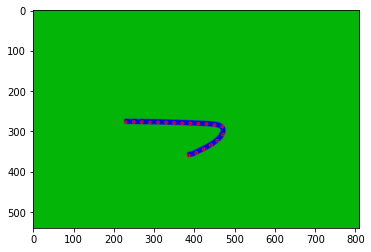

---- optimize translation ----
tensor([ 2.2935e+02,  2.6353e+02, -9.3017e-04, -3.3754e-03, -3.9673e-02,
        -5.1033e-03, -1.7692e-02, -3.5935e-02, -3.4645e-02, -3.2178e-02,
        -4.8174e-02, -5.3672e-02, -6.0617e-02, -2.3640e-01, -1.4936e+00,
        -2.3415e+00, -2.5133e+00, -2.6472e+00, -2.6828e+00, -2.7870e+00],
       device='cuda:0')
tensor(307.3471, device='cuda:0')
tensor([ 2.2889e+02,  2.6353e+02, -9.3017e-04, -3.3754e-03, -3.9673e-02,
        -5.1033e-03, -1.7692e-02, -3.5935e-02, -3.4645e-02, -3.2178e-02,
        -4.8174e-02, -5.3672e-02, -6.0617e-02, -2.3640e-01, -1.4936e+00,
        -2.3415e+00, -2.5133e+00, -2.6472e+00, -2.6828e+00, -2.7870e+00],
       device='cuda:0')
tensor(303.2461, device='cuda:0')
tensor([ 2.2905e+02,  2.6353e+02, -9.3017e-04, -3.3754e-03, -3.9673e-02,
        -5.1033e-03, -1.7692e-02, -3.5935e-02, -3.4645e-02, -3.2178e-02,
        -4.8174e-02, -5.3672e-02, -6.0617e-02, -2.3640e-01, -1.4936e+00,
        -2.3415e+00, -2.5133e+00, -2.6472e+00, -

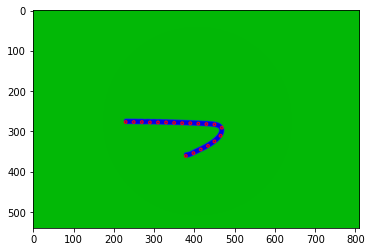

---- optimize translation ----
tensor([ 2.2935e+02,  2.6353e+02, -8.7235e-04, -3.4873e-03, -3.9386e-02,
        -5.9222e-03, -1.5189e-02, -3.8209e-02, -3.3446e-02, -3.5405e-02,
        -4.4186e-02, -5.9365e-02, -4.8233e-02, -4.1009e-01, -1.7364e+00,
        -2.3800e+00, -2.5449e+00, -2.6692e+00, -2.6815e+00, -2.7923e+00],
       device='cuda:0')
tensor(310.1038, device='cuda:0')
tensor([ 2.2890e+02,  2.6353e+02, -8.7235e-04, -3.4873e-03, -3.9386e-02,
        -5.9222e-03, -1.5189e-02, -3.8209e-02, -3.3446e-02, -3.5405e-02,
        -4.4186e-02, -5.9365e-02, -4.8233e-02, -4.1009e-01, -1.7364e+00,
        -2.3800e+00, -2.5449e+00, -2.6692e+00, -2.6815e+00, -2.7923e+00],
       device='cuda:0')
tensor(305.8565, device='cuda:0')
tensor([ 2.2911e+02,  2.6353e+02, -8.7235e-04, -3.4873e-03, -3.9386e-02,
        -5.9222e-03, -1.5189e-02, -3.8209e-02, -3.3446e-02, -3.5405e-02,
        -4.4186e-02, -5.9365e-02, -4.8233e-02, -4.1009e-01, -1.7364e+00,
        -2.3800e+00, -2.5449e+00, -2.6692e+00, -

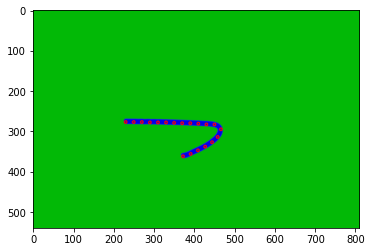

---- optimize translation ----
tensor([ 2.2951e+02,  2.6352e+02, -3.8286e-04, -5.0023e-03, -3.7876e-02,
        -5.1147e-03, -2.0844e-02, -3.3364e-02, -3.5513e-02, -3.4390e-02,
        -4.1519e-02, -6.9684e-02, -3.6621e-02, -6.3969e-01, -1.9517e+00,
        -2.4174e+00, -2.5681e+00, -2.6862e+00, -2.6764e+00, -2.8098e+00],
       device='cuda:0')
tensor(308.6429, device='cuda:0')
tensor([ 2.2918e+02,  2.6352e+02, -3.8286e-04, -5.0023e-03, -3.7876e-02,
        -5.1147e-03, -2.0844e-02, -3.3364e-02, -3.5513e-02, -3.4390e-02,
        -4.1519e-02, -6.9684e-02, -3.6621e-02, -6.3969e-01, -1.9517e+00,
        -2.4174e+00, -2.5681e+00, -2.6862e+00, -2.6764e+00, -2.8098e+00],
       device='cuda:0')
tensor(305.5520, device='cuda:0')
tensor([ 2.2930e+02,  2.6353e+02, -3.8286e-04, -5.0023e-03, -3.7876e-02,
        -5.1147e-03, -2.0844e-02, -3.3364e-02, -3.5513e-02, -3.4390e-02,
        -4.1519e-02, -6.9684e-02, -3.6621e-02, -6.3969e-01, -1.9517e+00,
        -2.4174e+00, -2.5681e+00, -2.6862e+00, -

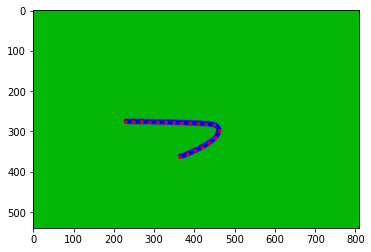

---- optimize translation ----
tensor([ 2.2983e+02,  2.6352e+02, -2.2390e-04, -5.4416e-03, -4.0136e-02,
        -7.8288e-04, -2.6799e-02, -2.7774e-02, -3.8069e-02, -3.3401e-02,
        -4.3692e-02, -6.8806e-02, -5.7698e-02, -9.0056e-01, -2.1219e+00,
        -2.4446e+00, -2.5964e+00, -2.6890e+00, -2.6973e+00, -2.8075e+00],
       device='cuda:0')
tensor(309.9404, device='cuda:0')
tensor([ 2.2942e+02,  2.6349e+02, -2.2390e-04, -5.4416e-03, -4.0136e-02,
        -7.8288e-04, -2.6799e-02, -2.7774e-02, -3.8069e-02, -3.3401e-02,
        -4.3692e-02, -6.8806e-02, -5.7698e-02, -9.0056e-01, -2.1219e+00,
        -2.4446e+00, -2.5964e+00, -2.6890e+00, -2.6973e+00, -2.8075e+00],
       device='cuda:0')
tensor(306.1447, device='cuda:0')
tensor([ 2.2954e+02,  2.6350e+02, -2.2390e-04, -5.4416e-03, -4.0136e-02,
        -7.8288e-04, -2.6799e-02, -2.7774e-02, -3.8069e-02, -3.3401e-02,
        -4.3692e-02, -6.8806e-02, -5.7698e-02, -9.0056e-01, -2.1219e+00,
        -2.4446e+00, -2.5964e+00, -2.6890e+00, -

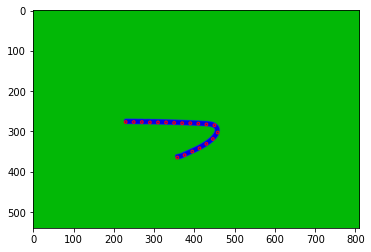

---- optimize translation ----
tensor([ 2.2993e+02,  2.6350e+02,  8.3594e-04, -2.7143e-03, -4.3934e-02,
         1.5769e-03, -3.0122e-02, -2.5287e-02, -3.8075e-02, -3.5599e-02,
        -4.2375e-02, -6.5285e-02, -1.1330e-01, -1.1682e+00, -2.2392e+00,
        -2.4710e+00, -2.6126e+00, -2.7005e+00, -2.7033e+00, -2.8073e+00],
       device='cuda:0')
tensor(310.7944, device='cuda:0')
tensor([ 2.2974e+02,  2.6350e+02,  8.3594e-04, -2.7143e-03, -4.3934e-02,
         1.5769e-03, -3.0122e-02, -2.5287e-02, -3.8075e-02, -3.5599e-02,
        -4.2375e-02, -6.5285e-02, -1.1330e-01, -1.1682e+00, -2.2392e+00,
        -2.4710e+00, -2.6126e+00, -2.7005e+00, -2.7033e+00, -2.8073e+00],
       device='cuda:0')
tensor(308.8202, device='cuda:0')
tensor([ 2.2986e+02,  2.6350e+02,  8.3594e-04, -2.7143e-03, -4.3934e-02,
         1.5769e-03, -3.0122e-02, -2.5287e-02, -3.8075e-02, -3.5599e-02,
        -4.2375e-02, -6.5285e-02, -1.1330e-01, -1.1682e+00, -2.2392e+00,
        -2.4710e+00, -2.6126e+00, -2.7005e+00, -

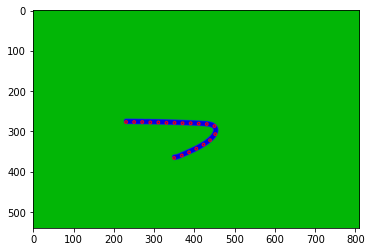

---- optimize translation ----
tensor([ 2.3018e+02,  2.6350e+02, -3.9198e-04,  1.3812e-03, -5.1203e-02,
         7.1602e-03, -3.4660e-02, -2.1560e-02, -3.9912e-02, -3.3369e-02,
        -4.9314e-02, -5.2244e-02, -2.3095e-01, -1.4478e+00, -2.3108e+00,
        -2.5142e+00, -2.6249e+00, -2.7151e+00, -2.7031e+00, -2.8182e+00],
       device='cuda:0')
tensor(310.1775, device='cuda:0')
tensor([ 2.2994e+02,  2.6360e+02, -3.9198e-04,  1.3812e-03, -5.1203e-02,
         7.1602e-03, -3.4660e-02, -2.1560e-02, -3.9912e-02, -3.3369e-02,
        -4.9314e-02, -5.2244e-02, -2.3095e-01, -1.4478e+00, -2.3108e+00,
        -2.5142e+00, -2.6249e+00, -2.7151e+00, -2.7031e+00, -2.8182e+00],
       device='cuda:0')
tensor(307.2283, device='cuda:0')
tensor([ 2.2999e+02,  2.6358e+02, -3.9198e-04,  1.3812e-03, -5.1203e-02,
         7.1602e-03, -3.4660e-02, -2.1560e-02, -3.9912e-02, -3.3369e-02,
        -4.9314e-02, -5.2244e-02, -2.3095e-01, -1.4478e+00, -2.3108e+00,
        -2.5142e+00, -2.6249e+00, -2.7151e+00, -

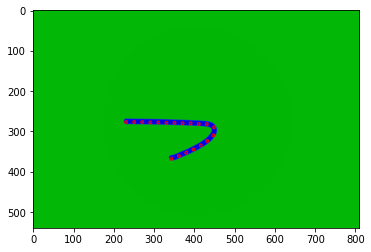

---- optimize translation ----
tensor([ 2.3032e+02,  2.6358e+02, -5.6057e-03,  2.6262e-03, -5.1624e-02,
         7.6599e-03, -3.5425e-02, -2.0974e-02, -4.0041e-02, -3.4248e-02,
        -5.3231e-02, -4.0514e-02, -3.9848e-01, -1.6906e+00, -2.3655e+00,
        -2.5341e+00, -2.6553e+00, -2.7020e+00, -2.7222e+00, -2.8236e+00],
       device='cuda:0')
tensor(310.5672, device='cuda:0')
tensor([ 2.2995e+02,  2.6359e+02, -5.6057e-03,  2.6262e-03, -5.1624e-02,
         7.6599e-03, -3.5425e-02, -2.0974e-02, -4.0041e-02, -3.4248e-02,
        -5.3231e-02, -4.0514e-02, -3.9848e-01, -1.6906e+00, -2.3655e+00,
        -2.5341e+00, -2.6553e+00, -2.7020e+00, -2.7222e+00, -2.8236e+00],
       device='cuda:0')
tensor(306.8076, device='cuda:0')
tensor([ 2.3008e+02,  2.6359e+02, -5.6057e-03,  2.6262e-03, -5.1624e-02,
         7.6599e-03, -3.5425e-02, -2.0974e-02, -4.0041e-02, -3.4248e-02,
        -5.3231e-02, -4.0514e-02, -3.9848e-01, -1.6906e+00, -2.3655e+00,
        -2.5341e+00, -2.6553e+00, -2.7020e+00, -

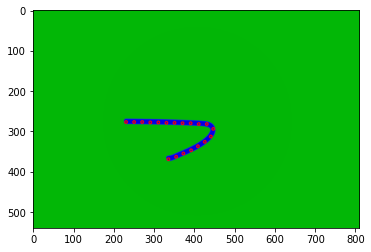

---- optimize translation ----
tensor([ 2.3045e+02,  2.6358e+02, -6.0312e-03,  4.3507e-03, -5.4714e-02,
         9.7718e-03, -3.6117e-02, -2.1248e-02, -4.1059e-02, -3.1458e-02,
        -5.9359e-02, -3.4242e-02, -6.1436e-01, -1.9019e+00, -2.4025e+00,
        -2.5640e+00, -2.6487e+00, -2.7296e+00, -2.7255e+00, -2.8179e+00],
       device='cuda:0')
tensor(313.5869, device='cuda:0')
tensor([ 2.3008e+02,  2.6355e+02, -6.0312e-03,  4.3507e-03, -5.4714e-02,
         9.7718e-03, -3.6117e-02, -2.1248e-02, -4.1059e-02, -3.1458e-02,
        -5.9359e-02, -3.4242e-02, -6.1436e-01, -1.9019e+00, -2.4025e+00,
        -2.5640e+00, -2.6487e+00, -2.7296e+00, -2.7255e+00, -2.8179e+00],
       device='cuda:0')
tensor(309.9706, device='cuda:0')
tensor([ 2.3028e+02,  2.6356e+02, -6.0312e-03,  4.3507e-03, -5.4714e-02,
         9.7718e-03, -3.6117e-02, -2.1248e-02, -4.1059e-02, -3.1458e-02,
        -5.9359e-02, -3.4242e-02, -6.1436e-01, -1.9019e+00, -2.4025e+00,
        -2.5640e+00, -2.6487e+00, -2.7296e+00, -

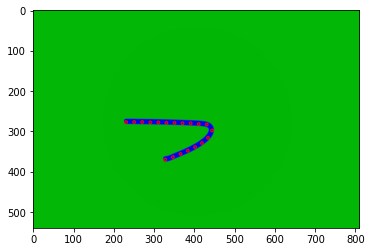

---- optimize translation ----
tensor([ 2.3077e+02,  2.6355e+02, -3.8562e-03,  4.6275e-03, -5.7079e-02,
         1.2087e-02, -3.7848e-02, -2.0284e-02, -4.2893e-02, -2.9858e-02,
        -6.0011e-02, -5.7343e-02, -8.7647e-01, -2.0827e+00, -2.4334e+00,
        -2.5865e+00, -2.6673e+00, -2.7343e+00, -2.7325e+00, -2.8297e+00],
       device='cuda:0')
tensor(312.5376, device='cuda:0')
tensor([ 2.3057e+02,  2.6355e+02, -3.8562e-03,  4.6275e-03, -5.7079e-02,
         1.2087e-02, -3.7848e-02, -2.0284e-02, -4.2893e-02, -2.9858e-02,
        -6.0011e-02, -5.7343e-02, -8.7647e-01, -2.0827e+00, -2.4334e+00,
        -2.5865e+00, -2.6673e+00, -2.7343e+00, -2.7325e+00, -2.8297e+00],
       device='cuda:0')
tensor(310.4413, device='cuda:0')
tensor([ 2.3068e+02,  2.6355e+02, -3.8562e-03,  4.6275e-03, -5.7079e-02,
         1.2087e-02, -3.7848e-02, -2.0284e-02, -4.2893e-02, -2.9858e-02,
        -6.0011e-02, -5.7343e-02, -8.7647e-01, -2.0827e+00, -2.4334e+00,
        -2.5865e+00, -2.6673e+00, -2.7343e+00, -

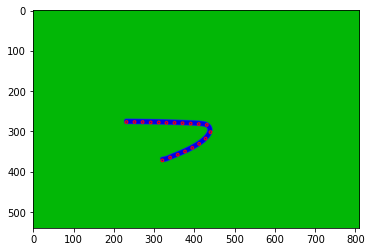

---- optimize translation ----
tensor([ 2.3104e+02,  2.6354e+02, -3.3336e-03,  3.3119e-03, -5.5891e-02,
         1.1548e-02, -3.8115e-02, -2.0103e-02, -4.2560e-02, -3.2662e-02,
        -5.8146e-02, -1.1056e-01, -1.1336e+00, -2.2050e+00, -2.4666e+00,
        -2.6072e+00, -2.6799e+00, -2.7392e+00, -2.7411e+00, -2.8244e+00],
       device='cuda:0')
tensor(315.1047, device='cuda:0')
tensor([ 2.3086e+02,  2.6355e+02, -3.3336e-03,  3.3119e-03, -5.5891e-02,
         1.1548e-02, -3.8115e-02, -2.0103e-02, -4.2560e-02, -3.2662e-02,
        -5.8146e-02, -1.1056e-01, -1.1336e+00, -2.2050e+00, -2.4666e+00,
        -2.6072e+00, -2.6799e+00, -2.7392e+00, -2.7411e+00, -2.8244e+00],
       device='cuda:0')
tensor(313.0863, device='cuda:0')
tensor([ 2.3092e+02,  2.6355e+02, -3.3336e-03,  3.3119e-03, -5.5891e-02,
         1.1548e-02, -3.8115e-02, -2.0103e-02, -4.2560e-02, -3.2662e-02,
        -5.8146e-02, -1.1056e-01, -1.1336e+00, -2.2050e+00, -2.4666e+00,
        -2.6072e+00, -2.6799e+00, -2.7392e+00, -

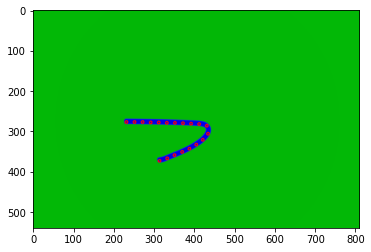

---- optimize translation ----
tensor([ 2.3127e+02,  2.6355e+02, -3.6309e-03,  4.4871e-03, -5.6906e-02,
         1.1703e-02, -3.8800e-02, -1.9943e-02, -4.1233e-02, -3.9183e-02,
        -4.5812e-02, -2.2735e-01, -1.4032e+00, -2.2962e+00, -2.4945e+00,
        -2.6239e+00, -2.6930e+00, -2.7458e+00, -2.7444e+00, -2.8382e+00],
       device='cuda:0')
tensor(314.2241, device='cuda:0')
tensor([ 2.3128e+02,  2.6350e+02, -3.6309e-03,  4.4871e-03, -5.6906e-02,
         1.1703e-02, -3.8800e-02, -1.9943e-02, -4.1233e-02, -3.9183e-02,
        -4.5812e-02, -2.2735e-01, -1.4032e+00, -2.2962e+00, -2.4945e+00,
        -2.6239e+00, -2.6930e+00, -2.7458e+00, -2.7444e+00, -2.8382e+00],
       device='cuda:0')
tensor(314.7859, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3127e+02,  2.6355e+02, -3.6309e-03,  4.4871e-03, -5.6906e-02,
         1.1703e-02, -3.8800e-02, -1.9943e-02, -4.1233e-02, -3.9183e-02,
        -4.5812e-02, -2.2735e-01, -1.4032e+00, -2.2962e+00, -2.4945e+00,
        -2.6239e+00,

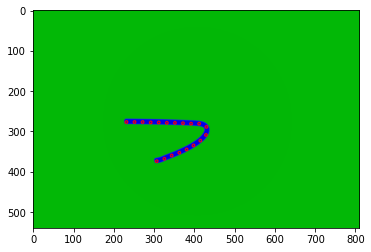

---- optimize translation ----
tensor([ 2.3163e+02,  2.6350e+02, -8.6607e-04,  3.1899e-03, -5.7078e-02,
         1.3389e-02, -4.3008e-02, -1.6414e-02, -4.1574e-02, -4.2773e-02,
        -3.7965e-02, -3.9492e-01, -1.6608e+00, -2.3536e+00, -2.5284e+00,
        -2.6322e+00, -2.7081e+00, -2.7566e+00, -2.7466e+00, -2.8363e+00],
       device='cuda:0')
tensor(314.7837, device='cuda:0')
tensor([ 2.3130e+02,  2.6351e+02, -8.6607e-04,  3.1899e-03, -5.7078e-02,
         1.3389e-02, -4.3008e-02, -1.6414e-02, -4.1574e-02, -4.2773e-02,
        -3.7965e-02, -3.9492e-01, -1.6608e+00, -2.3536e+00, -2.5284e+00,
        -2.6322e+00, -2.7081e+00, -2.7566e+00, -2.7466e+00, -2.8363e+00],
       device='cuda:0')
tensor(311.1762, device='cuda:0')
tensor([ 2.3143e+02,  2.6351e+02, -8.6607e-04,  3.1899e-03, -5.7078e-02,
         1.3389e-02, -4.3008e-02, -1.6414e-02, -4.1574e-02, -4.2773e-02,
        -3.7965e-02, -3.9492e-01, -1.6608e+00, -2.3536e+00, -2.5284e+00,
        -2.6322e+00, -2.7081e+00, -2.7566e+00, -

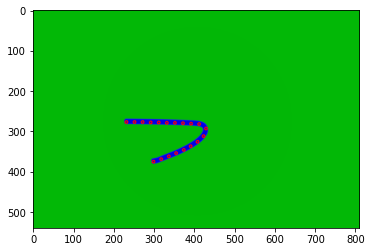

---- optimize translation ----
tensor([ 2.3181e+02,  2.6350e+02, -6.0577e-04,  2.2345e-03, -5.7673e-02,
         1.5029e-02, -4.3680e-02, -1.7172e-02, -4.0850e-02, -4.7658e-02,
        -3.6766e-02, -6.0775e-01, -1.8765e+00, -2.3946e+00, -2.5531e+00,
        -2.6535e+00, -2.7103e+00, -2.7622e+00, -2.7552e+00, -2.8379e+00],
       device='cuda:0')
tensor(315.7321, device='cuda:0')
tensor([ 2.3152e+02,  2.6360e+02, -6.0577e-04,  2.2345e-03, -5.7673e-02,
         1.5029e-02, -4.3680e-02, -1.7172e-02, -4.0850e-02, -4.7658e-02,
        -3.6766e-02, -6.0775e-01, -1.8765e+00, -2.3946e+00, -2.5531e+00,
        -2.6535e+00, -2.7103e+00, -2.7622e+00, -2.7552e+00, -2.8379e+00],
       device='cuda:0')
tensor(311.8301, device='cuda:0')
tensor([ 2.3164e+02,  2.6358e+02, -6.0577e-04,  2.2345e-03, -5.7673e-02,
         1.5029e-02, -4.3680e-02, -1.7172e-02, -4.0850e-02, -4.7658e-02,
        -3.6766e-02, -6.0775e-01, -1.8765e+00, -2.3946e+00, -2.5531e+00,
        -2.6535e+00, -2.7103e+00, -2.7622e+00, -

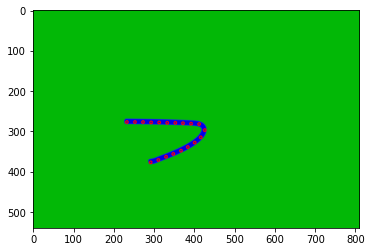

---- optimize translation ----
tensor([ 2.3207e+02,  2.6358e+02, -4.9850e-03,  2.4501e-03, -5.7110e-02,
         1.4583e-02, -4.5201e-02, -1.5623e-02, -4.2126e-02, -4.6602e-02,
        -5.2819e-02, -8.5452e-01, -2.0499e+00, -2.4259e+00, -2.5783e+00,
        -2.6705e+00, -2.7103e+00, -2.7683e+00, -2.7594e+00, -2.8461e+00],
       device='cuda:0')
tensor(316.6838, device='cuda:0')
tensor([ 2.3195e+02,  2.6353e+02, -4.9850e-03,  2.4501e-03, -5.7110e-02,
         1.4583e-02, -4.5201e-02, -1.5623e-02, -4.2126e-02, -4.6602e-02,
        -5.2819e-02, -8.5452e-01, -2.0499e+00, -2.4259e+00, -2.5783e+00,
        -2.6705e+00, -2.7103e+00, -2.7683e+00, -2.7594e+00, -2.8461e+00],
       device='cuda:0')
tensor(315.7156, device='cuda:0')
tensor([ 2.3203e+02,  2.6355e+02, -4.9850e-03,  2.4501e-03, -5.7110e-02,
         1.4583e-02, -4.5201e-02, -1.5623e-02, -4.2126e-02, -4.6602e-02,
        -5.2819e-02, -8.5452e-01, -2.0499e+00, -2.4259e+00, -2.5783e+00,
        -2.6705e+00, -2.7103e+00, -2.7683e+00, -

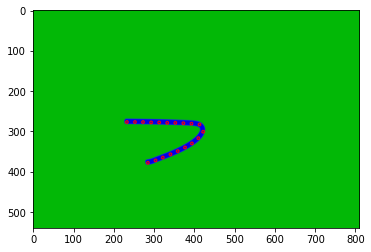

---- optimize translation ----
tensor([ 2.3239e+02,  2.6354e+02, -2.5780e-03,  9.6980e-04, -5.6483e-02,
         1.4846e-02, -4.6235e-02, -1.4472e-02, -4.4665e-02, -4.2046e-02,
        -1.1867e-01, -1.1118e+00, -2.1942e+00, -2.4521e+00, -2.5968e+00,
        -2.6764e+00, -2.7298e+00, -2.7698e+00, -2.7635e+00, -2.8452e+00],
       device='cuda:0')
tensor(316.1133, device='cuda:0')
tensor([ 2.3228e+02,  2.6354e+02, -2.5780e-03,  9.6980e-04, -5.6483e-02,
         1.4846e-02, -4.6235e-02, -1.4472e-02, -4.4665e-02, -4.2046e-02,
        -1.1867e-01, -1.1118e+00, -2.1942e+00, -2.4521e+00, -2.5968e+00,
        -2.6764e+00, -2.7298e+00, -2.7698e+00, -2.7635e+00, -2.8452e+00],
       device='cuda:0')
tensor(314.9137, device='cuda:0')
tensor([ 2.3233e+02,  2.6354e+02, -2.5780e-03,  9.6980e-04, -5.6483e-02,
         1.4846e-02, -4.6235e-02, -1.4472e-02, -4.4665e-02, -4.2046e-02,
        -1.1867e-01, -1.1118e+00, -2.1942e+00, -2.4521e+00, -2.5968e+00,
        -2.6764e+00, -2.7298e+00, -2.7698e+00, -

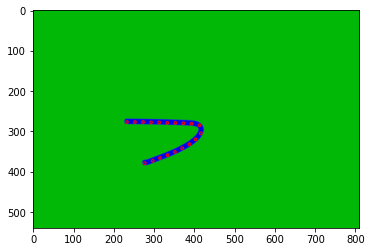

---- optimize translation ----
tensor([ 2.3266e+02,  2.6354e+02, -1.6599e-03, -2.3234e-03, -5.3513e-02,
         1.3982e-02, -4.6292e-02, -1.3797e-02, -4.7824e-02, -3.6702e-02,
        -2.2571e-01, -1.3764e+00, -2.2827e+00, -2.4846e+00, -2.6173e+00,
        -2.6859e+00, -2.7384e+00, -2.7751e+00, -2.7678e+00, -2.8460e+00],
       device='cuda:0')
tensor(317.6666, device='cuda:0')
tensor([ 2.3244e+02,  2.6354e+02, -1.6599e-03, -2.3234e-03, -5.3513e-02,
         1.3982e-02, -4.6292e-02, -1.3797e-02, -4.7824e-02, -3.6702e-02,
        -2.2571e-01, -1.3764e+00, -2.2827e+00, -2.4846e+00, -2.6173e+00,
        -2.6859e+00, -2.7384e+00, -2.7751e+00, -2.7678e+00, -2.8460e+00],
       device='cuda:0')
tensor(315.0506, device='cuda:0')
tensor([ 2.3256e+02,  2.6354e+02, -1.6599e-03, -2.3234e-03, -5.3513e-02,
         1.3982e-02, -4.6292e-02, -1.3797e-02, -4.7824e-02, -3.6702e-02,
        -2.2571e-01, -1.3764e+00, -2.2827e+00, -2.4846e+00, -2.6173e+00,
        -2.6859e+00, -2.7384e+00, -2.7751e+00, -

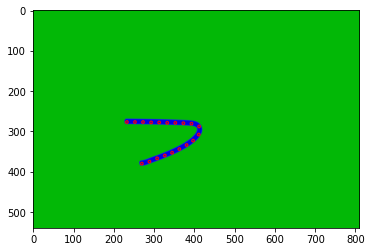

---- optimize translation ----
tensor([ 2.3279e+02,  2.6354e+02, -1.6005e-03, -2.5832e-03, -5.3561e-02,
         1.4674e-02, -4.9153e-02, -1.0272e-02, -5.2206e-02, -2.8233e-02,
        -3.8499e-01, -1.6228e+00, -2.3363e+00, -2.5208e+00, -2.6352e+00,
        -2.6919e+00, -2.7418e+00, -2.7837e+00, -2.7718e+00, -2.8511e+00],
       device='cuda:0')
tensor(316.6489, device='cuda:0')
tensor([ 2.3277e+02,  2.6349e+02, -1.6005e-03, -2.5832e-03, -5.3561e-02,
         1.4674e-02, -4.9153e-02, -1.0272e-02, -5.2206e-02, -2.8233e-02,
        -3.8499e-01, -1.6228e+00, -2.3363e+00, -2.5208e+00, -2.6352e+00,
        -2.6919e+00, -2.7418e+00, -2.7837e+00, -2.7718e+00, -2.8511e+00],
       device='cuda:0')
tensor(316.8355, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3279e+02,  2.6354e+02, -1.6005e-03, -2.5832e-03, -5.3561e-02,
         1.4674e-02, -4.9153e-02, -1.0272e-02, -5.2206e-02, -2.8233e-02,
        -3.8499e-01, -1.6228e+00, -2.3363e+00, -2.5208e+00, -2.6352e+00,
        -2.6919e+00,

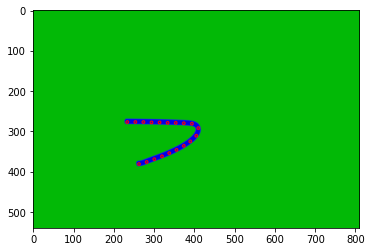

---- optimize translation ----
tensor([ 2.3315e+02,  2.6350e+02,  1.0572e-03, -4.1844e-03, -5.2944e-02,
         1.4842e-02, -4.9574e-02, -1.1512e-02, -5.4383e-02, -2.8061e-02,
        -5.8675e-01, -1.8456e+00, -2.3809e+00, -2.5448e+00, -2.6399e+00,
        -2.7121e+00, -2.7457e+00, -2.7904e+00, -2.7763e+00, -2.8535e+00],
       device='cuda:0')
tensor(319.6278, device='cuda:0')
tensor([ 2.3290e+02,  2.6350e+02,  1.0572e-03, -4.1844e-03, -5.2944e-02,
         1.4842e-02, -4.9574e-02, -1.1512e-02, -5.4383e-02, -2.8061e-02,
        -5.8675e-01, -1.8456e+00, -2.3809e+00, -2.5448e+00, -2.6399e+00,
        -2.7121e+00, -2.7457e+00, -2.7904e+00, -2.7763e+00, -2.8535e+00],
       device='cuda:0')
tensor(316.6513, device='cuda:0')
tensor([ 2.3300e+02,  2.6350e+02,  1.0572e-03, -4.1844e-03, -5.2944e-02,
         1.4842e-02, -4.9574e-02, -1.1512e-02, -5.4383e-02, -2.8061e-02,
        -5.8675e-01, -1.8456e+00, -2.3809e+00, -2.5448e+00, -2.6399e+00,
        -2.7121e+00, -2.7457e+00, -2.7904e+00, -

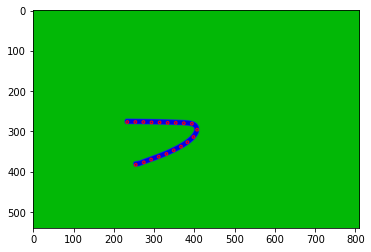

---- optimize translation ----
tensor([ 2.3346e+02,  2.6350e+02,  1.2824e-03, -5.2857e-03, -5.1917e-02,
         1.4392e-02, -4.9829e-02, -1.1324e-02, -5.5255e-02, -4.9020e-02,
        -8.3586e-01, -2.0260e+00, -2.4195e+00, -2.5689e+00, -2.6537e+00,
        -2.7220e+00, -2.7543e+00, -2.7928e+00, -2.7807e+00, -2.8605e+00],
       device='cuda:0')
tensor(319.3549, device='cuda:0')
tensor([ 2.3331e+02,  2.6359e+02,  1.2824e-03, -5.2857e-03, -5.1917e-02,
         1.4392e-02, -4.9829e-02, -1.1324e-02, -5.5255e-02, -4.9020e-02,
        -8.3586e-01, -2.0260e+00, -2.4195e+00, -2.5689e+00, -2.6537e+00,
        -2.7220e+00, -2.7543e+00, -2.7928e+00, -2.7807e+00, -2.8605e+00],
       device='cuda:0')
tensor(316.8841, device='cuda:0')
tensor([ 2.3339e+02,  2.6356e+02,  1.2824e-03, -5.2857e-03, -5.1917e-02,
         1.4392e-02, -4.9829e-02, -1.1324e-02, -5.5255e-02, -4.9020e-02,
        -8.3586e-01, -2.0260e+00, -2.4195e+00, -2.5689e+00, -2.6537e+00,
        -2.7220e+00, -2.7543e+00, -2.7928e+00, -

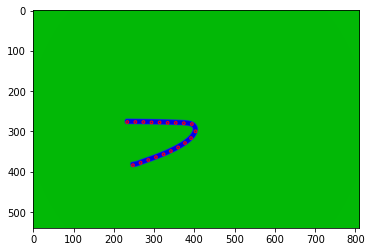

---- optimize translation ----
tensor([ 2.3380e+02,  2.6356e+02, -2.6155e-03, -5.7563e-03, -5.0426e-02,
         1.2647e-02, -4.9541e-02, -1.2504e-02, -5.1455e-02, -1.0965e-01,
        -1.0904e+00, -2.1642e+00, -2.4499e+00, -2.5918e+00, -2.6716e+00,
        -2.7221e+00, -2.7625e+00, -2.7987e+00, -2.7839e+00, -2.8598e+00],
       device='cuda:0')
tensor(320.6607, device='cuda:0')
tensor([ 2.3388e+02,  2.6352e+02, -2.6155e-03, -5.7563e-03, -5.0426e-02,
         1.2647e-02, -4.9541e-02, -1.2504e-02, -5.1455e-02, -1.0965e-01,
        -1.0904e+00, -2.1642e+00, -2.4499e+00, -2.5918e+00, -2.6716e+00,
        -2.7221e+00, -2.7625e+00, -2.7987e+00, -2.7839e+00, -2.8598e+00],
       device='cuda:0')
tensor(321.9978, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3380e+02,  2.6356e+02, -2.6155e-03, -5.7563e-03, -5.0426e-02,
         1.2647e-02, -4.9541e-02, -1.2504e-02, -5.1455e-02, -1.0965e-01,
        -1.0904e+00, -2.1642e+00, -2.4499e+00, -2.5918e+00, -2.6716e+00,
        -2.7221e+00,

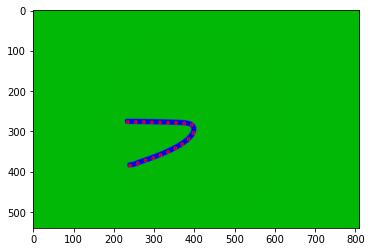

---- optimize translation ----
tensor([ 2.3421e+02,  2.6353e+02, -3.6132e-04, -7.7463e-03, -4.8816e-02,
         1.1636e-02, -4.8834e-02, -1.5335e-02, -4.6756e-02, -2.1485e-01,
        -1.3594e+00, -2.2623e+00, -2.4828e+00, -2.6107e+00, -2.6813e+00,
        -2.7316e+00, -2.7691e+00, -2.8022e+00, -2.7884e+00, -2.8615e+00],
       device='cuda:0')
tensor(320.6070, device='cuda:0')
tensor([ 2.3397e+02,  2.6353e+02, -3.6132e-04, -7.7463e-03, -4.8816e-02,
         1.1636e-02, -4.8834e-02, -1.5335e-02, -4.6756e-02, -2.1485e-01,
        -1.3594e+00, -2.2623e+00, -2.4828e+00, -2.6107e+00, -2.6813e+00,
        -2.7316e+00, -2.7691e+00, -2.8022e+00, -2.7884e+00, -2.8615e+00],
       device='cuda:0')
tensor(317.8064, device='cuda:0')
tensor([ 2.3411e+02,  2.6353e+02, -3.6132e-04, -7.7463e-03, -4.8816e-02,
         1.1636e-02, -4.8834e-02, -1.5335e-02, -4.6756e-02, -2.1485e-01,
        -1.3594e+00, -2.2623e+00, -2.4828e+00, -2.6107e+00, -2.6813e+00,
        -2.7316e+00, -2.7691e+00, -2.8022e+00, -

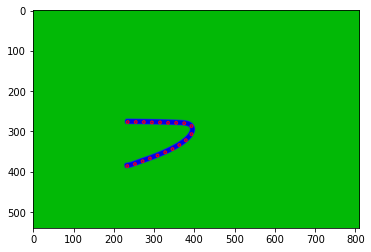

---- optimize translation ----
tensor([ 2.3437e+02,  2.6353e+02, -7.1707e-06, -9.2044e-03, -4.8421e-02,
         1.2326e-02, -4.8249e-02, -1.9834e-02, -3.8374e-02, -3.7382e-01,
        -1.5963e+00, -2.3325e+00, -2.5122e+00, -2.6193e+00, -2.6961e+00,
        -2.7426e+00, -2.7710e+00, -2.8062e+00, -2.7914e+00, -2.8646e+00],
       device='cuda:0')
tensor(320.4988, device='cuda:0')
tensor([ 2.3426e+02,  2.6348e+02, -7.1707e-06, -9.2044e-03, -4.8421e-02,
         1.2326e-02, -4.8249e-02, -1.9834e-02, -3.8374e-02, -3.7382e-01,
        -1.5963e+00, -2.3325e+00, -2.5122e+00, -2.6193e+00, -2.6961e+00,
        -2.7426e+00, -2.7710e+00, -2.8062e+00, -2.7914e+00, -2.8646e+00],
       device='cuda:0')
tensor(319.7040, device='cuda:0')
tensor([ 2.3433e+02,  2.6350e+02, -7.1707e-06, -9.2044e-03, -4.8421e-02,
         1.2326e-02, -4.8249e-02, -1.9834e-02, -3.8374e-02, -3.7382e-01,
        -1.5963e+00, -2.3325e+00, -2.5122e+00, -2.6193e+00, -2.6961e+00,
        -2.7426e+00, -2.7710e+00, -2.8062e+00, -

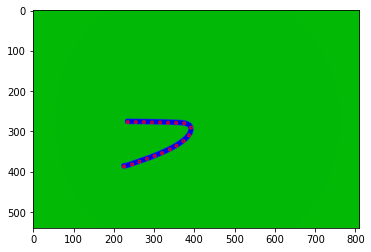

---- optimize translation ----
tensor([ 2.3463e+02,  2.6349e+02,  2.3829e-03, -1.0415e-02, -4.8028e-02,
         1.2438e-02, -4.9623e-02, -2.0892e-02, -3.9993e-02, -5.7098e-01,
        -1.8213e+00, -2.3706e+00, -2.5395e+00, -2.6420e+00, -2.6995e+00,
        -2.7474e+00, -2.7787e+00, -2.8094e+00, -2.7952e+00, -2.8671e+00],
       device='cuda:0')
tensor(322.7010, device='cuda:0')
tensor([ 2.3433e+02,  2.6349e+02,  2.3829e-03, -1.0415e-02, -4.8028e-02,
         1.2438e-02, -4.9623e-02, -2.0892e-02, -3.9993e-02, -5.7098e-01,
        -1.8213e+00, -2.3706e+00, -2.5395e+00, -2.6420e+00, -2.6995e+00,
        -2.7474e+00, -2.7787e+00, -2.8094e+00, -2.7952e+00, -2.8671e+00],
       device='cuda:0')
tensor(319.1623, device='cuda:0')
tensor([ 2.3443e+02,  2.6349e+02,  2.3829e-03, -1.0415e-02, -4.8028e-02,
         1.2438e-02, -4.9623e-02, -2.0892e-02, -3.9993e-02, -5.7098e-01,
        -1.8213e+00, -2.3706e+00, -2.5395e+00, -2.6420e+00, -2.6995e+00,
        -2.7474e+00, -2.7787e+00, -2.8094e+00, -

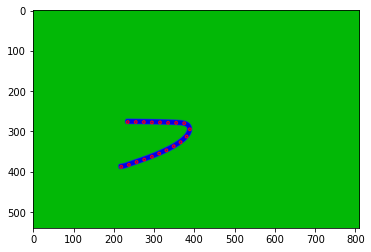

---- optimize translation ----
tensor([ 2.3489e+02,  2.6349e+02,  2.5806e-03, -1.1495e-02, -4.6807e-02,
         1.1450e-02, -4.8448e-02, -2.5303e-02, -5.5613e-02, -8.1151e-01,
        -2.0001e+00, -2.4095e+00, -2.5646e+00, -2.6584e+00, -2.7052e+00,
        -2.7512e+00, -2.7881e+00, -2.8077e+00, -2.7999e+00, -2.8742e+00],
       device='cuda:0')
tensor(321.5771, device='cuda:0')
tensor([ 2.3481e+02,  2.6358e+02,  2.5806e-03, -1.1495e-02, -4.6807e-02,
         1.1450e-02, -4.8448e-02, -2.5303e-02, -5.5613e-02, -8.1151e-01,
        -2.0001e+00, -2.4095e+00, -2.5646e+00, -2.6584e+00, -2.7052e+00,
        -2.7512e+00, -2.7881e+00, -2.8077e+00, -2.7999e+00, -2.8742e+00],
       device='cuda:0')
tensor(319.8700, device='cuda:0')
tensor([ 2.3479e+02,  2.6355e+02,  2.5806e-03, -1.1495e-02, -4.6807e-02,
         1.1450e-02, -4.8448e-02, -2.5303e-02, -5.5613e-02, -8.1151e-01,
        -2.0001e+00, -2.4095e+00, -2.5646e+00, -2.6584e+00, -2.7052e+00,
        -2.7512e+00, -2.7881e+00, -2.8077e+00, -

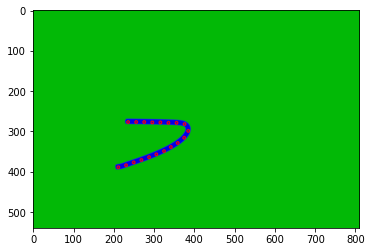

---- optimize translation ----
tensor([ 2.3524e+02,  2.6355e+02, -7.0773e-04, -1.4264e-02, -4.3044e-02,
         8.9254e-03, -4.7855e-02, -2.4534e-02, -1.1026e-01, -1.0590e+00,
        -2.1422e+00, -2.4444e+00, -2.5827e+00, -2.6611e+00, -2.7261e+00,
        -2.7579e+00, -2.7865e+00, -2.8129e+00, -2.8119e+00, -2.8716e+00],
       device='cuda:0')
tensor(324.0475, device='cuda:0')
tensor([ 2.3537e+02,  2.6351e+02, -7.0773e-04, -1.4264e-02, -4.3044e-02,
         8.9254e-03, -4.7855e-02, -2.4534e-02, -1.1026e-01, -1.0590e+00,
        -2.1422e+00, -2.4444e+00, -2.5827e+00, -2.6611e+00, -2.7261e+00,
        -2.7579e+00, -2.7865e+00, -2.8129e+00, -2.8119e+00, -2.8716e+00],
       device='cuda:0')
tensor(326.1201, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3524e+02,  2.6355e+02, -7.0773e-04, -1.4264e-02, -4.3044e-02,
         8.9254e-03, -4.7855e-02, -2.4534e-02, -1.1026e-01, -1.0590e+00,
        -2.1422e+00, -2.4444e+00, -2.5827e+00, -2.6611e+00, -2.7261e+00,
        -2.7579e+00,

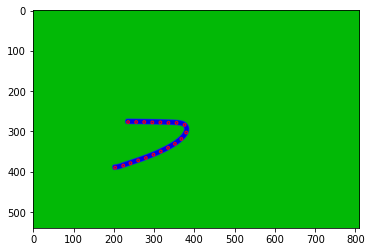

---- optimize translation ----
tensor([ 2.3573e+02,  2.6352e+02,  1.4488e-03, -1.6656e-02, -4.0696e-02,
         7.4631e-03, -4.8484e-02, -1.9192e-02, -2.1916e-01, -1.3298e+00,
        -2.2466e+00, -2.4774e+00, -2.6049e+00, -2.6768e+00, -2.7290e+00,
        -2.7676e+00, -2.7915e+00, -2.8232e+00, -2.8081e+00, -2.8829e+00],
       device='cuda:0')
tensor(324.7548, device='cuda:0')
tensor([ 2.3562e+02,  2.6352e+02,  1.4488e-03, -1.6656e-02, -4.0696e-02,
         7.4631e-03, -4.8484e-02, -1.9192e-02, -2.1916e-01, -1.3298e+00,
        -2.2466e+00, -2.4774e+00, -2.6049e+00, -2.6768e+00, -2.7290e+00,
        -2.7676e+00, -2.7915e+00, -2.8232e+00, -2.8081e+00, -2.8829e+00],
       device='cuda:0')
tensor(323.3811, device='cuda:0')
tensor([ 2.3567e+02,  2.6352e+02,  1.4488e-03, -1.6656e-02, -4.0696e-02,
         7.4631e-03, -4.8484e-02, -1.9192e-02, -2.1916e-01, -1.3298e+00,
        -2.2466e+00, -2.4774e+00, -2.6049e+00, -2.6768e+00, -2.7290e+00,
        -2.7676e+00, -2.7915e+00, -2.8232e+00, -

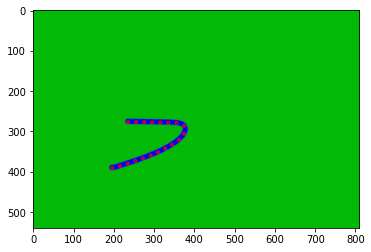

---- optimize translation ----
tensor([ 2.3597e+02,  2.6352e+02,  1.8682e-03, -1.8965e-02, -3.8847e-02,
         7.0151e-03, -5.0472e-02, -1.6115e-02, -3.6755e-01, -1.5694e+00,
        -2.3180e+00, -2.5068e+00, -2.6225e+00, -2.6870e+00, -2.7331e+00,
        -2.7744e+00, -2.8030e+00, -2.8243e+00, -2.8085e+00, -2.8837e+00],
       device='cuda:0')
tensor(324.2210, device='cuda:0')
tensor([ 2.3587e+02,  2.6347e+02,  1.8682e-03, -1.8965e-02, -3.8847e-02,
         7.0151e-03, -5.0472e-02, -1.6115e-02, -3.6755e-01, -1.5694e+00,
        -2.3180e+00, -2.5068e+00, -2.6225e+00, -2.6870e+00, -2.7331e+00,
        -2.7744e+00, -2.8030e+00, -2.8243e+00, -2.8085e+00, -2.8837e+00],
       device='cuda:0')
tensor(323.4735, device='cuda:0')
tensor([ 2.3593e+02,  2.6349e+02,  1.8682e-03, -1.8965e-02, -3.8847e-02,
         7.0151e-03, -5.0472e-02, -1.6115e-02, -3.6755e-01, -1.5694e+00,
        -2.3180e+00, -2.5068e+00, -2.6225e+00, -2.6870e+00, -2.7331e+00,
        -2.7744e+00, -2.8030e+00, -2.8243e+00, -

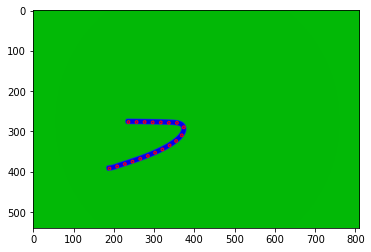

---- optimize translation ----
tensor([ 2.3627e+02,  2.6349e+02,  3.8066e-03, -1.8885e-02, -3.9028e-02,
         6.8093e-03, -5.2407e-02, -1.9366e-02, -5.6143e-01, -1.7940e+00,
        -2.3640e+00, -2.5343e+00, -2.6303e+00, -2.7033e+00, -2.7454e+00,
        -2.7774e+00, -2.8022e+00, -2.8325e+00, -2.8111e+00, -2.8869e+00],
       device='cuda:0')
tensor(326.1363, device='cuda:0')
tensor([ 2.3606e+02,  2.6348e+02,  3.8066e-03, -1.8885e-02, -3.9028e-02,
         6.8093e-03, -5.2407e-02, -1.9366e-02, -5.6143e-01, -1.7940e+00,
        -2.3640e+00, -2.5343e+00, -2.6303e+00, -2.7033e+00, -2.7454e+00,
        -2.7774e+00, -2.8022e+00, -2.8325e+00, -2.8111e+00, -2.8869e+00],
       device='cuda:0')
tensor(323.6660, device='cuda:0')
tensor([ 2.3617e+02,  2.6349e+02,  3.8066e-03, -1.8885e-02, -3.9028e-02,
         6.8093e-03, -5.2407e-02, -1.9366e-02, -5.6143e-01, -1.7940e+00,
        -2.3640e+00, -2.5343e+00, -2.6303e+00, -2.7033e+00, -2.7454e+00,
        -2.7774e+00, -2.8022e+00, -2.8325e+00, -

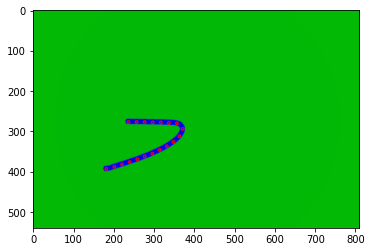

---- optimize translation ----
tensor([ 2.3653e+02,  2.6349e+02,  3.8886e-03, -1.9882e-02, -3.7520e-02,
         3.8060e-03, -5.0551e-02, -4.3430e-02, -7.9032e-01, -1.9765e+00,
        -2.4013e+00, -2.5604e+00, -2.6509e+00, -2.7072e+00, -2.7515e+00,
        -2.7848e+00, -2.8051e+00, -2.8377e+00, -2.8155e+00, -2.8881e+00],
       device='cuda:0')
tensor(326.3979, device='cuda:0')
tensor([ 2.3659e+02,  2.6354e+02,  3.8886e-03, -1.9882e-02, -3.7520e-02,
         3.8060e-03, -5.0551e-02, -4.3430e-02, -7.9032e-01, -1.9765e+00,
        -2.4013e+00, -2.5604e+00, -2.6509e+00, -2.7072e+00, -2.7515e+00,
        -2.7848e+00, -2.8051e+00, -2.8377e+00, -2.8155e+00, -2.8881e+00],
       device='cuda:0')
tensor(326.5355, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3653e+02,  2.6349e+02,  3.8886e-03, -1.9882e-02, -3.7520e-02,
         3.8060e-03, -5.0551e-02, -4.3430e-02, -7.9032e-01, -1.9765e+00,
        -2.4013e+00, -2.5604e+00, -2.6509e+00, -2.7072e+00, -2.7515e+00,
        -2.7848e+00,

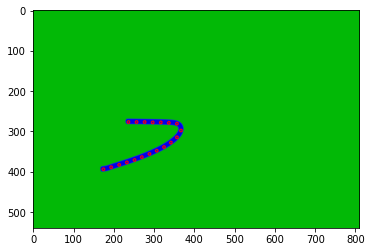

---- optimize translation ----
tensor([ 2.3699e+02,  2.6352e+02,  1.9362e-03, -2.0946e-02, -3.5897e-02,
         2.1910e-03, -4.8076e-02, -9.3480e-02, -1.0408e+00, -2.1271e+00,
        -2.4330e+00, -2.5805e+00, -2.6682e+00, -2.7101e+00, -2.7590e+00,
        -2.7891e+00, -2.8149e+00, -2.8328e+00, -2.8252e+00, -2.8848e+00],
       device='cuda:0')
tensor(328.7155, device='cuda:0')
tensor([ 2.3691e+02,  2.6352e+02,  1.9362e-03, -2.0946e-02, -3.5897e-02,
         2.1910e-03, -4.8076e-02, -9.3480e-02, -1.0408e+00, -2.1271e+00,
        -2.4330e+00, -2.5805e+00, -2.6682e+00, -2.7101e+00, -2.7590e+00,
        -2.7891e+00, -2.8149e+00, -2.8328e+00, -2.8252e+00, -2.8848e+00],
       device='cuda:0')
tensor(327.7782, device='cuda:0')
tensor([ 2.3695e+02,  2.6352e+02,  1.9362e-03, -2.0946e-02, -3.5897e-02,
         2.1910e-03, -4.8076e-02, -9.3480e-02, -1.0408e+00, -2.1271e+00,
        -2.4330e+00, -2.5805e+00, -2.6682e+00, -2.7101e+00, -2.7590e+00,
        -2.7891e+00, -2.8149e+00, -2.8328e+00, -

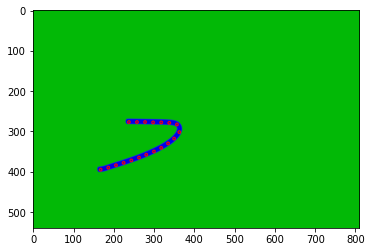

---- optimize translation ----
tensor([ 2.3735e+02,  2.6352e+02,  2.2277e-03, -2.3634e-02, -3.2659e-02,
        -2.3476e-03, -4.1700e-02, -1.9984e-01, -1.2981e+00, -2.2370e+00,
        -2.4695e+00, -2.5973e+00, -2.6753e+00, -2.7291e+00, -2.7649e+00,
        -2.7971e+00, -2.8192e+00, -2.8318e+00, -2.8306e+00, -2.8857e+00],
       device='cuda:0')
tensor(327.2671, device='cuda:0')
tensor([ 2.3727e+02,  2.6347e+02,  2.2277e-03, -2.3634e-02, -3.2659e-02,
        -2.3476e-03, -4.1700e-02, -1.9984e-01, -1.2981e+00, -2.2370e+00,
        -2.4695e+00, -2.5973e+00, -2.6753e+00, -2.7291e+00, -2.7649e+00,
        -2.7971e+00, -2.8192e+00, -2.8318e+00, -2.8306e+00, -2.8857e+00],
       device='cuda:0')
tensor(326.8967, device='cuda:0')
tensor([ 2.3731e+02,  2.6349e+02,  2.2277e-03, -2.3634e-02, -3.2659e-02,
        -2.3476e-03, -4.1700e-02, -1.9984e-01, -1.2981e+00, -2.2370e+00,
        -2.4695e+00, -2.5973e+00, -2.6753e+00, -2.7291e+00, -2.7649e+00,
        -2.7971e+00, -2.8192e+00, -2.8318e+00, -

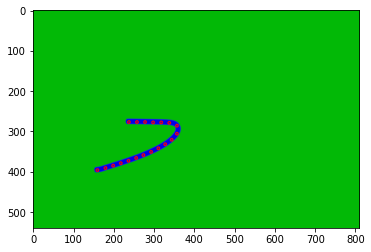

---- optimize translation ----
tensor([ 2.3763e+02,  2.6349e+02,  4.2944e-03, -2.5043e-02, -3.1163e-02,
        -6.1224e-03, -3.6183e-02, -3.4662e-01, -1.5425e+00, -2.3049e+00,
        -2.5027e+00, -2.6185e+00, -2.6870e+00, -2.7327e+00, -2.7765e+00,
        -2.7925e+00, -2.8234e+00, -2.8415e+00, -2.8306e+00, -2.8892e+00],
       device='cuda:0')
tensor(329.5122, device='cuda:0')
tensor([ 2.3763e+02,  2.6348e+02,  4.2944e-03, -2.5043e-02, -3.1163e-02,
        -6.1224e-03, -3.6183e-02, -3.4662e-01, -1.5425e+00, -2.3049e+00,
        -2.5027e+00, -2.6185e+00, -2.6870e+00, -2.7327e+00, -2.7765e+00,
        -2.7925e+00, -2.8234e+00, -2.8415e+00, -2.8306e+00, -2.8892e+00],
       device='cuda:0')
tensor(329.5208, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3763e+02,  2.6349e+02,  4.2944e-03, -2.5043e-02, -3.1163e-02,
        -6.1224e-03, -3.6183e-02, -3.4662e-01, -1.5425e+00, -2.3049e+00,
        -2.5027e+00, -2.6185e+00, -2.6870e+00, -2.7327e+00, -2.7765e+00,
        -2.7925e+00,

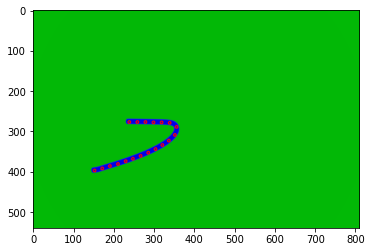

---- optimize translation ----
tensor([ 2.3804e+02,  2.6349e+02,  4.3009e-03, -2.7801e-02, -2.7603e-02,
        -9.4844e-03, -3.9451e-02, -5.3946e-01, -1.7731e+00, -2.3571e+00,
        -2.5314e+00, -2.6406e+00, -2.6888e+00, -2.7454e+00, -2.7754e+00,
        -2.8032e+00, -2.8248e+00, -2.8460e+00, -2.8333e+00, -2.8983e+00],
       device='cuda:0')
tensor(328.7509, device='cuda:0')
tensor([ 2.3786e+02,  2.6353e+02,  4.3009e-03, -2.7801e-02, -2.7603e-02,
        -9.4844e-03, -3.9451e-02, -5.3946e-01, -1.7731e+00, -2.3571e+00,
        -2.5314e+00, -2.6406e+00, -2.6888e+00, -2.7454e+00, -2.7754e+00,
        -2.8032e+00, -2.8248e+00, -2.8460e+00, -2.8333e+00, -2.8983e+00],
       device='cuda:0')
tensor(326.0492, device='cuda:0')
tensor([ 2.3793e+02,  2.6351e+02,  4.3009e-03, -2.7801e-02, -2.7603e-02,
        -9.4844e-03, -3.9451e-02, -5.3946e-01, -1.7731e+00, -2.3571e+00,
        -2.5314e+00, -2.6406e+00, -2.6888e+00, -2.7454e+00, -2.7754e+00,
        -2.8032e+00, -2.8248e+00, -2.8460e+00, -

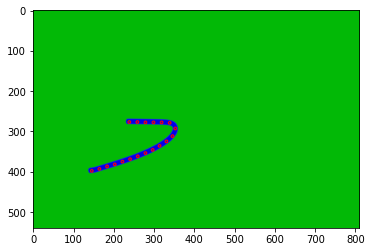

---- optimize translation ----
tensor([ 2.3840e+02,  2.6352e+02,  2.4347e-03, -2.8522e-02, -2.6082e-02,
        -1.3119e-02, -5.7509e-02, -7.6650e-01, -1.9582e+00, -2.4017e+00,
        -2.5577e+00, -2.6404e+00, -2.7108e+00, -2.7512e+00, -2.7813e+00,
        -2.8136e+00, -2.8243e+00, -2.8518e+00, -2.8382e+00, -2.9004e+00],
       device='cuda:0')
tensor(332.2909, device='cuda:0')
tensor([ 2.3837e+02,  2.6354e+02,  2.4347e-03, -2.8522e-02, -2.6082e-02,
        -1.3119e-02, -5.7509e-02, -7.6650e-01, -1.9582e+00, -2.4017e+00,
        -2.5577e+00, -2.6404e+00, -2.7108e+00, -2.7512e+00, -2.7813e+00,
        -2.8136e+00, -2.8243e+00, -2.8518e+00, -2.8382e+00, -2.9004e+00],
       device='cuda:0')
tensor(331.8015, device='cuda:0')
tensor([ 2.3838e+02,  2.6353e+02,  2.4347e-03, -2.8522e-02, -2.6082e-02,
        -1.3119e-02, -5.7509e-02, -7.6650e-01, -1.9582e+00, -2.4017e+00,
        -2.5577e+00, -2.6404e+00, -2.7108e+00, -2.7512e+00, -2.7813e+00,
        -2.8136e+00, -2.8243e+00, -2.8518e+00, -

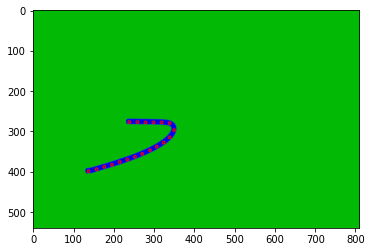

---- optimize translation ----
tensor([ 2.3876e+02,  2.6353e+02,  1.9602e-03, -2.9548e-02, -2.4419e-02,
        -1.4863e-02, -1.0195e-01, -1.0144e+00, -2.1082e+00, -2.4325e+00,
        -2.5778e+00, -2.6593e+00, -2.7155e+00, -2.7582e+00, -2.7900e+00,
        -2.8192e+00, -2.8280e+00, -2.8533e+00, -2.8445e+00, -2.9041e+00],
       device='cuda:0')
tensor(330.9579, device='cuda:0')
tensor([ 2.3900e+02,  2.6346e+02,  1.9602e-03, -2.9548e-02, -2.4419e-02,
        -1.4863e-02, -1.0195e-01, -1.0144e+00, -2.1082e+00, -2.4325e+00,
        -2.5778e+00, -2.6593e+00, -2.7155e+00, -2.7582e+00, -2.7900e+00,
        -2.8192e+00, -2.8280e+00, -2.8533e+00, -2.8445e+00, -2.9041e+00],
       device='cuda:0')
tensor(334.9294, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3876e+02,  2.6353e+02,  1.9602e-03, -2.9548e-02, -2.4419e-02,
        -1.4863e-02, -1.0195e-01, -1.0144e+00, -2.1082e+00, -2.4325e+00,
        -2.5778e+00, -2.6593e+00, -2.7155e+00, -2.7582e+00, -2.7900e+00,
        -2.8192e+00,

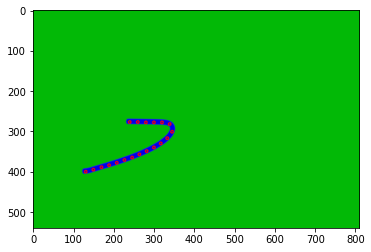

---- optimize translation ----
tensor([ 2.3937e+02,  2.6349e+02,  4.2161e-03, -3.4399e-02, -2.0066e-02,
        -1.6447e-02, -1.9825e-01, -1.2770e+00, -2.2268e+00, -2.4646e+00,
        -2.6026e+00, -2.6743e+00, -2.7198e+00, -2.7664e+00, -2.7962e+00,
        -2.8174e+00, -2.8411e+00, -2.8544e+00, -2.8490e+00, -2.9035e+00],
       device='cuda:0')
tensor(332.4423, device='cuda:0')
tensor([ 2.3926e+02,  2.6349e+02,  4.2161e-03, -3.4399e-02, -2.0066e-02,
        -1.6447e-02, -1.9825e-01, -1.2770e+00, -2.2268e+00, -2.4646e+00,
        -2.6026e+00, -2.6743e+00, -2.7198e+00, -2.7664e+00, -2.7962e+00,
        -2.8174e+00, -2.8411e+00, -2.8544e+00, -2.8490e+00, -2.9035e+00],
       device='cuda:0')
tensor(331.0006, device='cuda:0')
tensor([ 2.3930e+02,  2.6349e+02,  4.2161e-03, -3.4399e-02, -2.0066e-02,
        -1.6447e-02, -1.9825e-01, -1.2770e+00, -2.2268e+00, -2.4646e+00,
        -2.6026e+00, -2.6743e+00, -2.7198e+00, -2.7664e+00, -2.7962e+00,
        -2.8174e+00, -2.8411e+00, -2.8544e+00, -

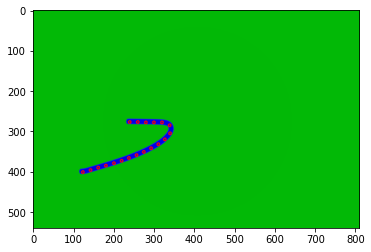

---- optimize translation ----
tensor([ 2.3962e+02,  2.6349e+02,  4.0952e-03, -3.3288e-02, -2.1485e-02,
        -1.5784e-02, -3.4067e-01, -1.5201e+00, -2.2976e+00, -2.5032e+00,
        -2.6116e+00, -2.6868e+00, -2.7356e+00, -2.7733e+00, -2.7961e+00,
        -2.8258e+00, -2.8430e+00, -2.8604e+00, -2.8517e+00, -2.9054e+00],
       device='cuda:0')
tensor(332.7315, device='cuda:0')
tensor([ 2.3962e+02,  2.6354e+02,  4.0952e-03, -3.3288e-02, -2.1485e-02,
        -1.5784e-02, -3.4067e-01, -1.5201e+00, -2.2976e+00, -2.5032e+00,
        -2.6116e+00, -2.6868e+00, -2.7356e+00, -2.7733e+00, -2.7961e+00,
        -2.8258e+00, -2.8430e+00, -2.8604e+00, -2.8517e+00, -2.9054e+00],
       device='cuda:0')
tensor(332.0468, device='cuda:0')
tensor([ 2.3962e+02,  2.6351e+02,  4.0952e-03, -3.3288e-02, -2.1485e-02,
        -1.5784e-02, -3.4067e-01, -1.5201e+00, -2.2976e+00, -2.5032e+00,
        -2.6116e+00, -2.6868e+00, -2.7356e+00, -2.7733e+00, -2.7961e+00,
        -2.8258e+00, -2.8430e+00, -2.8604e+00, -

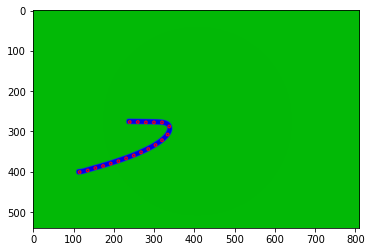

---- optimize translation ----
tensor([ 2.3992e+02,  2.6352e+02,  2.4256e-03, -3.3710e-02, -2.1711e-02,
        -1.9007e-02, -5.2173e-01, -1.7452e+00, -2.3491e+00, -2.5305e+00,
        -2.6284e+00, -2.6959e+00, -2.7451e+00, -2.7779e+00, -2.8023e+00,
        -2.8307e+00, -2.8450e+00, -2.8629e+00, -2.8554e+00, -2.9095e+00],
       device='cuda:0')
tensor(334.4156, device='cuda:0')
tensor([ 2.3985e+02,  2.6352e+02,  2.4256e-03, -3.3710e-02, -2.1711e-02,
        -1.9007e-02, -5.2173e-01, -1.7452e+00, -2.3491e+00, -2.5305e+00,
        -2.6284e+00, -2.6959e+00, -2.7451e+00, -2.7779e+00, -2.8023e+00,
        -2.8307e+00, -2.8450e+00, -2.8629e+00, -2.8554e+00, -2.9095e+00],
       device='cuda:0')
tensor(333.4659, device='cuda:0')
tensor([ 2.3988e+02,  2.6352e+02,  2.4256e-03, -3.3710e-02, -2.1711e-02,
        -1.9007e-02, -5.2173e-01, -1.7452e+00, -2.3491e+00, -2.5305e+00,
        -2.6284e+00, -2.6959e+00, -2.7451e+00, -2.7779e+00, -2.8023e+00,
        -2.8307e+00, -2.8450e+00, -2.8629e+00, -

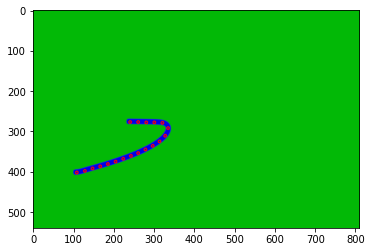

---- optimize translation ----
tensor([ 2.4028e+02,  2.6353e+02,  1.4907e-03, -3.3718e-02, -2.1708e-02,
        -3.7881e-02, -7.4199e-01, -1.9340e+00, -2.3923e+00, -2.5540e+00,
        -2.6523e+00, -2.6999e+00, -2.7524e+00, -2.7842e+00, -2.8083e+00,
        -2.8341e+00, -2.8485e+00, -2.8654e+00, -2.8574e+00, -2.9139e+00],
       device='cuda:0')
tensor(335.0953, device='cuda:0')
tensor([ 2.4042e+02,  2.6347e+02,  1.4907e-03, -3.3718e-02, -2.1708e-02,
        -3.7881e-02, -7.4199e-01, -1.9340e+00, -2.3923e+00, -2.5540e+00,
        -2.6523e+00, -2.6999e+00, -2.7524e+00, -2.7842e+00, -2.8083e+00,
        -2.8341e+00, -2.8485e+00, -2.8654e+00, -2.8574e+00, -2.9139e+00],
       device='cuda:0')
tensor(337.6002, device='cuda:0')
---- optimize rotation ----
tensor([ 2.4028e+02,  2.6353e+02,  1.4907e-03, -3.3718e-02, -2.1708e-02,
        -3.7881e-02, -7.4199e-01, -1.9340e+00, -2.3923e+00, -2.5540e+00,
        -2.6523e+00, -2.6999e+00, -2.7524e+00, -2.7842e+00, -2.8083e+00,
        -2.8341e+00,

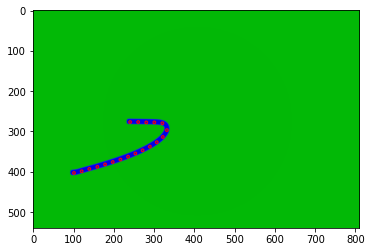

---- optimize translation ----
tensor([ 2.4090e+02,  2.6348e+02,  3.6698e-03, -3.7175e-02, -1.6219e-02,
        -9.2190e-02, -9.9879e-01, -2.0942e+00, -2.4318e+00, -2.5796e+00,
        -2.6560e+00, -2.7206e+00, -2.7601e+00, -2.7897e+00, -2.8157e+00,
        -2.8352e+00, -2.8541e+00, -2.8667e+00, -2.8595e+00, -2.9173e+00],
       device='cuda:0')
tensor(335.1275, device='cuda:0')
tensor([ 2.4110e+02,  2.6354e+02,  3.6698e-03, -3.7175e-02, -1.6219e-02,
        -9.2190e-02, -9.9879e-01, -2.0942e+00, -2.4318e+00, -2.5796e+00,
        -2.6560e+00, -2.7206e+00, -2.7601e+00, -2.7897e+00, -2.8157e+00,
        -2.8352e+00, -2.8541e+00, -2.8667e+00, -2.8595e+00, -2.9173e+00],
       device='cuda:0')
tensor(336.9611, device='cuda:0')
---- optimize rotation ----
tensor([ 2.4090e+02,  2.6348e+02,  3.6698e-03, -3.7175e-02, -1.6219e-02,
        -9.2190e-02, -9.9879e-01, -2.0942e+00, -2.4318e+00, -2.5796e+00,
        -2.6560e+00, -2.7206e+00, -2.7601e+00, -2.7897e+00, -2.8157e+00,
        -2.8352e+00,

tensor([ 2.4143e+02,  2.6350e+02,  2.7718e-03, -4.0430e-02, -1.0924e-02,
        -1.8431e-01, -1.2510e+00, -2.2119e+00, -2.4671e+00, -2.5988e+00,
        -2.6695e+00, -2.7305e+00, -2.7640e+00, -2.7987e+00, -2.8202e+00,
        -2.8363e+00, -2.8583e+00, -2.8703e+00, -2.8636e+00, -2.9200e+00],
       device='cuda:0')
tensor(303.6903, device='cuda:0')
tensor([ 2.4143e+02,  2.6354e+02, -4.0358e-04, -3.7849e-02, -1.3592e-02,
        -1.8095e-01, -1.2531e+00, -2.2089e+00, -2.4687e+00, -2.5977e+00,
        -2.6700e+00, -2.7302e+00, -2.7642e+00, -2.7987e+00, -2.8201e+00,
        -2.8365e+00, -2.8580e+00, -2.8708e+00, -2.8628e+00, -2.9213e+00],
       device='cuda:0')
tensor(303.6903, device='cuda:0')


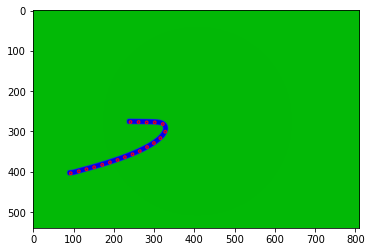

---- optimize translation ----
tensor([ 2.4143e+02,  2.6350e+02,  2.7718e-03, -4.0430e-02, -1.0924e-02,
        -1.8431e-01, -1.2510e+00, -2.2119e+00, -2.4671e+00, -2.5988e+00,
        -2.6695e+00, -2.7305e+00, -2.7640e+00, -2.7987e+00, -2.8202e+00,
        -2.8363e+00, -2.8583e+00, -2.8703e+00, -2.8636e+00, -2.9200e+00],
       device='cuda:0')
tensor(338.5460, device='cuda:0')
tensor([ 2.4138e+02,  2.6353e+02,  2.7718e-03, -4.0430e-02, -1.0924e-02,
        -1.8431e-01, -1.2510e+00, -2.2119e+00, -2.4671e+00, -2.5988e+00,
        -2.6695e+00, -2.7305e+00, -2.7640e+00, -2.7987e+00, -2.8202e+00,
        -2.8363e+00, -2.8583e+00, -2.8703e+00, -2.8636e+00, -2.9200e+00],
       device='cuda:0')
tensor(337.4847, device='cuda:0')
tensor([ 2.4140e+02,  2.6352e+02,  2.7718e-03, -4.0430e-02, -1.0924e-02,
        -1.8431e-01, -1.2510e+00, -2.2119e+00, -2.4671e+00, -2.5988e+00,
        -2.6695e+00, -2.7305e+00, -2.7640e+00, -2.7987e+00, -2.8202e+00,
        -2.8363e+00, -2.8583e+00, -2.8703e+00, -

tensor([ 2.4175e+02,  2.6354e+02, -9.2620e-04, -3.7589e-02, -1.5506e-02,
        -3.1863e-01, -1.4987e+00, -2.2931e+00, -2.5010e+00, -2.6162e+00,
        -2.6845e+00, -2.7338e+00, -2.7734e+00, -2.8070e+00, -2.8201e+00,
        -2.8409e+00, -2.8631e+00, -2.8776e+00, -2.8691e+00, -2.9320e+00],
       device='cuda:0')
tensor(305.2443, device='cuda:0')
tensor([ 2.4175e+02,  2.6351e+02,  2.2158e-03, -4.0290e-02, -1.2558e-02,
        -3.2216e-01, -1.4963e+00, -2.2959e+00, -2.4995e+00, -2.6171e+00,
        -2.6840e+00, -2.7340e+00, -2.7734e+00, -2.8069e+00, -2.8204e+00,
        -2.8404e+00, -2.8639e+00, -2.8763e+00, -2.8711e+00, -2.9289e+00],
       device='cuda:0')
tensor(305.2442, device='cuda:0')
tensor([ 2.4175e+02,  2.6354e+02, -8.1609e-04, -3.7696e-02, -1.5373e-02,
        -3.1882e-01, -1.4986e+00, -2.2932e+00, -2.5009e+00, -2.6162e+00,
        -2.6844e+00, -2.7338e+00, -2.7734e+00, -2.8070e+00, -2.8201e+00,
        -2.8408e+00, -2.8632e+00, -2.8775e+00, -2.8693e+00, -2.9316e+00],
     

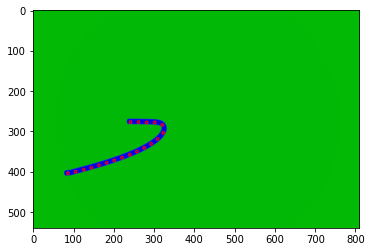

---- optimize translation ----
tensor([ 2.4175e+02,  2.6351e+02,  2.1071e-03, -4.0187e-02, -1.2686e-02,
        -3.2199e-01, -1.4964e+00, -2.2958e+00, -2.4996e+00, -2.6170e+00,
        -2.6841e+00, -2.7340e+00, -2.7734e+00, -2.8070e+00, -2.8203e+00,
        -2.8405e+00, -2.8638e+00, -2.8765e+00, -2.8709e+00, -2.9292e+00],
       device='cuda:0')
tensor(336.3270, device='cuda:0')
tensor([ 2.4183e+02,  2.6348e+02,  2.1071e-03, -4.0187e-02, -1.2686e-02,
        -3.2199e-01, -1.4964e+00, -2.2958e+00, -2.4996e+00, -2.6170e+00,
        -2.6841e+00, -2.7340e+00, -2.7734e+00, -2.8070e+00, -2.8203e+00,
        -2.8405e+00, -2.8638e+00, -2.8765e+00, -2.8709e+00, -2.9292e+00],
       device='cuda:0')
tensor(337.7640, device='cuda:0')
---- optimize rotation ----
tensor([ 2.4175e+02,  2.6351e+02,  2.1071e-03, -4.0187e-02, -1.2686e-02,
        -3.2199e-01, -1.4964e+00, -2.2958e+00, -2.4996e+00, -2.6170e+00,
        -2.6841e+00, -2.7340e+00, -2.7734e+00, -2.8070e+00, -2.8203e+00,
        -2.8405e+00,

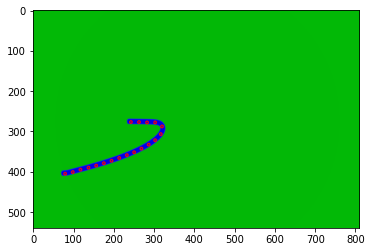

---- optimize translation ----
tensor([ 2.4212e+02,  2.6348e+02,  3.4420e-03, -4.0609e-02, -1.5366e-02,
        -5.0004e-01, -1.7237e+00, -2.3469e+00, -2.5300e+00, -2.6278e+00,
        -2.7007e+00, -2.7438e+00, -2.7792e+00, -2.8056e+00, -2.8320e+00,
        -2.8498e+00, -2.8664e+00, -2.8831e+00, -2.8733e+00, -2.9325e+00],
       device='cuda:0')
tensor(339.2869, device='cuda:0')
tensor([ 2.4213e+02,  2.6350e+02,  3.4420e-03, -4.0609e-02, -1.5366e-02,
        -5.0004e-01, -1.7237e+00, -2.3469e+00, -2.5300e+00, -2.6278e+00,
        -2.7007e+00, -2.7438e+00, -2.7792e+00, -2.8056e+00, -2.8320e+00,
        -2.8498e+00, -2.8664e+00, -2.8831e+00, -2.8733e+00, -2.9325e+00],
       device='cuda:0')
tensor(339.1955, device='cuda:0')
tensor([ 2.4213e+02,  2.6349e+02,  3.4420e-03, -4.0609e-02, -1.5366e-02,
        -5.0004e-01, -1.7237e+00, -2.3469e+00, -2.5300e+00, -2.6278e+00,
        -2.7007e+00, -2.7438e+00, -2.7792e+00, -2.8056e+00, -2.8320e+00,
        -2.8498e+00, -2.8664e+00, -2.8831e+00, -

tensor([ 2.4252e+02,  2.6339e+02,  1.0152e-02, -4.7812e-02, -2.2315e-02,
        -7.2376e-01, -1.9135e+00, -2.3969e+00, -2.5491e+00, -2.6476e+00,
        -2.7071e+00, -2.7533e+00, -2.7862e+00, -2.8110e+00, -2.8359e+00,
        -2.8558e+00, -2.8724e+00, -2.8886e+00, -2.8744e+00, -2.9504e+00],
       device='cuda:0')
tensor(306.6650, device='cuda:0')
tensor([ 2.4257e+02,  2.6360e+02, -8.5021e-03, -3.1598e-02, -4.0547e-02,
        -7.1023e-01, -1.9315e+00, -2.3831e+00, -2.5578e+00, -2.6418e+00,
        -2.7108e+00, -2.7507e+00, -2.7881e+00, -2.8093e+00, -2.8378e+00,
        -2.8534e+00, -2.8758e+00, -2.8836e+00, -2.8819e+00, -2.9390e+00],
       device='cuda:0')
tensor(306.6633, device='cuda:0')
tensor([ 2.4251e+02,  2.6340e+02,  9.6600e-03, -4.7422e-02, -2.2422e-02,
        -7.2288e-01, -1.9136e+00, -2.3962e+00, -2.5493e+00, -2.6473e+00,
        -2.7072e+00, -2.7532e+00, -2.7862e+00, -2.8109e+00, -2.8360e+00,
        -2.8557e+00, -2.8726e+00, -2.8883e+00, -2.8749e+00, -2.9496e+00],
     

tensor([ 2.4253e+02,  2.6344e+02,  6.1180e-03, -4.4374e-02, -2.5897e-02,
        -7.2065e-01, -1.9170e+00, -2.3936e+00, -2.5510e+00, -2.6462e+00,
        -2.7079e+00, -2.7527e+00, -2.7867e+00, -2.8105e+00, -2.8366e+00,
        -2.8549e+00, -2.8737e+00, -2.8867e+00, -2.8773e+00, -2.9460e+00],
       device='cuda:0')
tensor(306.6503, device='cuda:0')
tensor([ 2.4256e+02,  2.6356e+02, -4.5797e-03, -3.4933e-02, -3.6825e-02,
        -7.1299e-01, -1.9277e+00, -2.3860e+00, -2.5559e+00, -2.6431e+00,
        -2.7099e+00, -2.7513e+00, -2.7876e+00, -2.8098e+00, -2.8372e+00,
        -2.8542e+00, -2.8746e+00, -2.8853e+00, -2.8792e+00, -2.9431e+00],
       device='cuda:0')
tensor(306.6500, device='cuda:0')
tensor([ 2.4253e+02,  2.6344e+02,  5.8736e-03, -4.4159e-02, -2.6136e-02,
        -7.2050e-01, -1.9172e+00, -2.3935e+00, -2.5511e+00, -2.6461e+00,
        -2.7080e+00, -2.7526e+00, -2.7867e+00, -2.8104e+00, -2.8366e+00,
        -2.8549e+00, -2.8737e+00, -2.8866e+00, -2.8775e+00, -2.9458e+00],
     

tensor([ 2.4254e+02,  2.6346e+02,  3.9317e-03, -4.2453e-02, -2.8102e-02,
        -7.1920e-01, -1.9191e+00, -2.3921e+00, -2.5520e+00, -2.6456e+00,
        -2.7083e+00, -2.7524e+00, -2.7869e+00, -2.8103e+00, -2.8368e+00,
        -2.8547e+00, -2.8740e+00, -2.8861e+00, -2.8782e+00, -2.9448e+00],
       device='cuda:0')
tensor(306.6465, device='cuda:0')
tensor([ 2.4255e+02,  2.6353e+02, -2.4453e-03, -3.6798e-02, -3.4678e-02,
        -7.1443e-01, -1.9255e+00, -2.3874e+00, -2.5549e+00, -2.6437e+00,
        -2.7095e+00, -2.7516e+00, -2.7874e+00, -2.8099e+00, -2.8370e+00,
        -2.8545e+00, -2.8742e+00, -2.8859e+00, -2.8785e+00, -2.9443e+00],
       device='cuda:0')
tensor(306.6463, device='cuda:0')
tensor([ 2.4254e+02,  2.6346e+02,  3.8034e-03, -4.2341e-02, -2.8231e-02,
        -7.1912e-01, -1.9192e+00, -2.3920e+00, -2.5521e+00, -2.6455e+00,
        -2.7084e+00, -2.7524e+00, -2.7869e+00, -2.8103e+00, -2.8368e+00,
        -2.8546e+00, -2.8741e+00, -2.8861e+00, -2.8782e+00, -2.9447e+00],
     

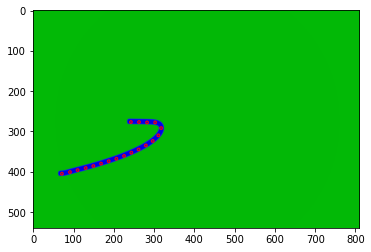

---- optimize translation ----
tensor([ 2.4255e+02,  2.6353e+02, -2.3198e-03, -3.6911e-02, -3.4548e-02,
        -7.1452e-01, -1.9254e+00, -2.3875e+00, -2.5549e+00, -2.6437e+00,
        -2.7095e+00, -2.7516e+00, -2.7874e+00, -2.8100e+00, -2.8370e+00,
        -2.8545e+00, -2.8742e+00, -2.8859e+00, -2.8784e+00, -2.9444e+00],
       device='cuda:0')
tensor(339.8111, device='cuda:0')
tensor([ 2.4245e+02,  2.6350e+02, -2.3198e-03, -3.6911e-02, -3.4548e-02,
        -7.1452e-01, -1.9254e+00, -2.3875e+00, -2.5549e+00, -2.6437e+00,
        -2.7095e+00, -2.7516e+00, -2.7874e+00, -2.8100e+00, -2.8370e+00,
        -2.8545e+00, -2.8742e+00, -2.8859e+00, -2.8784e+00, -2.9444e+00],
       device='cuda:0')
tensor(338.7858, device='cuda:0')
tensor([ 2.4250e+02,  2.6352e+02, -2.3198e-03, -3.6911e-02, -3.4548e-02,
        -7.1452e-01, -1.9254e+00, -2.3875e+00, -2.5549e+00, -2.6437e+00,
        -2.7095e+00, -2.7516e+00, -2.7874e+00, -2.8100e+00, -2.8370e+00,
        -2.8545e+00, -2.8742e+00, -2.8859e+00, -

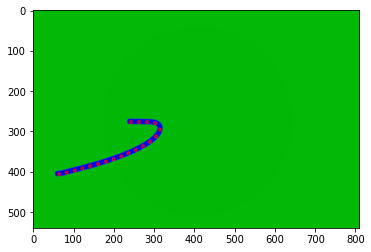

---- optimize translation ----
tensor([ 2.4297e+02,  2.6375e+02, -2.4008e-02, -1.2085e-02, -1.1016e-01,
        -9.3475e-01, -2.1140e+00, -2.4073e+00, -2.5912e+00, -2.6538e+00,
        -2.7193e+00, -2.7588e+00, -2.7952e+00, -2.8178e+00, -2.8414e+00,
        -2.8597e+00, -2.8768e+00, -2.8907e+00, -2.8865e+00, -2.9266e+00],
       device='cuda:0')
tensor(339.3884, device='cuda:0')
tensor([ 2.4303e+02,  2.6326e+02, -2.4008e-02, -1.2085e-02, -1.1016e-01,
        -9.3475e-01, -2.1140e+00, -2.4073e+00, -2.5912e+00, -2.6538e+00,
        -2.7193e+00, -2.7588e+00, -2.7952e+00, -2.8178e+00, -2.8414e+00,
        -2.8597e+00, -2.8768e+00, -2.8907e+00, -2.8865e+00, -2.9266e+00],
       device='cuda:0')
tensor(347.7903, device='cuda:0')
---- optimize rotation ----
tensor([ 2.4297e+02,  2.6375e+02, -2.4008e-02, -1.2085e-02, -1.1016e-01,
        -9.3475e-01, -2.1140e+00, -2.4073e+00, -2.5912e+00, -2.6538e+00,
        -2.7193e+00, -2.7588e+00, -2.7952e+00, -2.8178e+00, -2.8414e+00,
        -2.8597e+00,

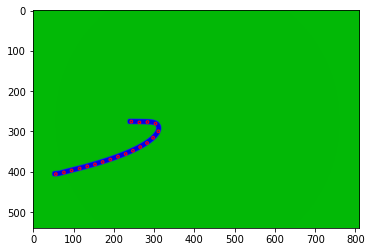

---- optimize translation ----
tensor([ 2.4348e+02,  2.6407e+02, -5.3568e-02,  1.2423e-02, -2.1074e-01,
        -1.1910e+00, -2.2509e+00, -2.4365e+00, -2.6130e+00, -2.6661e+00,
        -2.7339e+00, -2.7671e+00, -2.8048e+00, -2.8229e+00, -2.8471e+00,
        -2.8614e+00, -2.8857e+00, -2.8860e+00, -2.8973e+00, -2.9275e+00],
       device='cuda:0')
tensor(337.0151, device='cuda:0')
tensor([ 2.4365e+02,  2.6300e+02, -5.3568e-02,  1.2423e-02, -2.1074e-01,
        -1.1910e+00, -2.2509e+00, -2.4365e+00, -2.6130e+00, -2.6661e+00,
        -2.7339e+00, -2.7671e+00, -2.8048e+00, -2.8229e+00, -2.8471e+00,
        -2.8614e+00, -2.8857e+00, -2.8860e+00, -2.8973e+00, -2.9275e+00],
       device='cuda:0')
tensor(358.2575, device='cuda:0')
---- optimize rotation ----
tensor([ 2.4348e+02,  2.6407e+02, -5.3568e-02,  1.2423e-02, -2.1074e-01,
        -1.1910e+00, -2.2509e+00, -2.4365e+00, -2.6130e+00, -2.6661e+00,
        -2.7339e+00, -2.7671e+00, -2.8048e+00, -2.8229e+00, -2.8471e+00,
        -2.8614e+00,

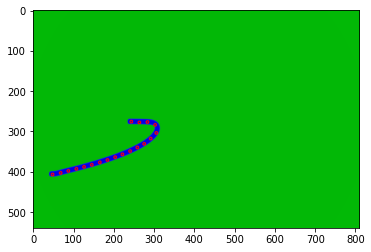

---- optimize translation ----
tensor([ 2.4382e+02,  2.6443e+02, -8.5022e-02,  3.1339e-02, -3.5085e-01,
        -1.4443e+00, -2.3343e+00, -2.4772e+00, -2.6298e+00, -2.6806e+00,
        -2.7450e+00, -2.7735e+00, -2.8152e+00, -2.8242e+00, -2.8517e+00,
        -2.8673e+00, -2.8887e+00, -2.8866e+00, -2.9049e+00, -2.9226e+00],
       device='cuda:0')
tensor(335.2493, device='cuda:0')
tensor([ 2.4431e+02,  2.6260e+02, -8.5022e-02,  3.1339e-02, -3.5085e-01,
        -1.4443e+00, -2.3343e+00, -2.4772e+00, -2.6298e+00, -2.6806e+00,
        -2.7450e+00, -2.7735e+00, -2.8152e+00, -2.8242e+00, -2.8517e+00,
        -2.8673e+00, -2.8887e+00, -2.8866e+00, -2.9049e+00, -2.9226e+00],
       device='cuda:0')
tensor(382.1720, device='cuda:0')
---- optimize rotation ----
tensor([ 2.4382e+02,  2.6443e+02, -8.5022e-02,  3.1339e-02, -3.5085e-01,
        -1.4443e+00, -2.3343e+00, -2.4772e+00, -2.6298e+00, -2.6806e+00,
        -2.7450e+00, -2.7735e+00, -2.8152e+00, -2.8242e+00, -2.8517e+00,
        -2.8673e+00,

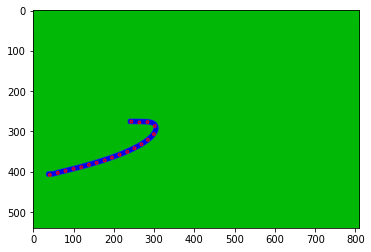

---- optimize translation ----
tensor([ 2.4383e+02,  2.6433e+02, -7.9060e-02,  3.4684e-02, -5.2232e-01,
        -1.6439e+00, -2.3979e+00, -2.5035e+00, -2.6508e+00, -2.6891e+00,
        -2.7554e+00, -2.7808e+00, -2.8183e+00, -2.8293e+00, -2.8595e+00,
        -2.8694e+00, -2.8973e+00, -2.8884e+00, -2.9071e+00, -2.9137e+00],
       device='cuda:0')
tensor(335.2938, device='cuda:0')
tensor([ 2.4501e+02,  2.6262e+02, -7.9060e-02,  3.4684e-02, -5.2232e-01,
        -1.6439e+00, -2.3979e+00, -2.5035e+00, -2.6508e+00, -2.6891e+00,
        -2.7554e+00, -2.7808e+00, -2.8183e+00, -2.8293e+00, -2.8595e+00,
        -2.8694e+00, -2.8973e+00, -2.8884e+00, -2.9071e+00, -2.9137e+00],
       device='cuda:0')
tensor(388.2928, device='cuda:0')
---- optimize rotation ----
tensor([ 2.4383e+02,  2.6433e+02, -7.9060e-02,  3.4684e-02, -5.2232e-01,
        -1.6439e+00, -2.3979e+00, -2.5035e+00, -2.6508e+00, -2.6891e+00,
        -2.7554e+00, -2.7808e+00, -2.8183e+00, -2.8293e+00, -2.8595e+00,
        -2.8694e+00,

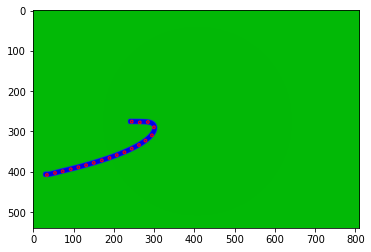

---- optimize translation ----
tensor([ 2.4425e+02,  2.6434e+02, -8.4591e-02,  3.9263e-02, -7.3414e-01,
        -1.8226e+00, -2.4511e+00, -2.5260e+00, -2.6661e+00, -2.7042e+00,
        -2.7602e+00, -2.7893e+00, -2.8215e+00, -2.8369e+00, -2.8635e+00,
        -2.8726e+00, -2.8999e+00, -2.8904e+00, -2.9165e+00, -2.8916e+00],
       device='cuda:0')
tensor(304.5417, device='cuda:0')
tensor([ 2.4310e+02,  2.6309e+02, -8.4591e-02,  3.9263e-02, -7.3414e-01,
        -1.8226e+00, -2.4511e+00, -2.5260e+00, -2.6661e+00, -2.7042e+00,
        -2.7602e+00, -2.7893e+00, -2.8215e+00, -2.8369e+00, -2.8635e+00,
        -2.8726e+00, -2.8999e+00, -2.8904e+00, -2.9165e+00, -2.8916e+00],
       device='cuda:0')
tensor(313.9153, device='cuda:0')
---- optimize rotation ----
tensor([ 2.4425e+02,  2.6434e+02, -8.4591e-02,  3.9263e-02, -7.3414e-01,
        -1.8226e+00, -2.4511e+00, -2.5260e+00, -2.6661e+00, -2.7042e+00,
        -2.7602e+00, -2.7893e+00, -2.8215e+00, -2.8369e+00, -2.8635e+00,
        -2.8726e+00,

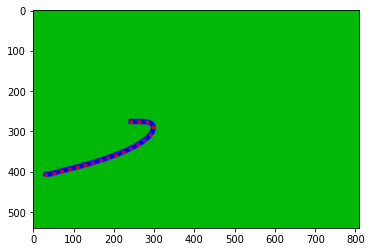

---- optimize translation ----
tensor([ 2.4312e+02,  2.6357e+02, -1.2728e-02, -2.1799e-02, -6.9089e-01,
        -1.9395e+00, -2.3910e+00, -2.5526e+00, -2.6432e+00, -2.7133e+00,
        -2.7545e+00, -2.7930e+00, -2.8194e+00, -2.8360e+00, -2.8585e+00,
        -2.8757e+00, -2.8875e+00, -2.8995e+00, -2.8651e+00, -2.9522e+00],
       device='cuda:0')
tensor(296.4572, device='cuda:0')
tensor([ 2.4200e+02,  2.6358e+02, -1.2728e-02, -2.1799e-02, -6.9089e-01,
        -1.9395e+00, -2.3910e+00, -2.5526e+00, -2.6432e+00, -2.7133e+00,
        -2.7545e+00, -2.7930e+00, -2.8194e+00, -2.8360e+00, -2.8585e+00,
        -2.8757e+00, -2.8875e+00, -2.8995e+00, -2.8651e+00, -2.9522e+00],
       device='cuda:0')
tensor(291.5549, device='cuda:0')
tensor([ 2.4214e+02,  2.6355e+02, -1.2728e-02, -2.1799e-02, -6.9089e-01,
        -1.9395e+00, -2.3910e+00, -2.5526e+00, -2.6432e+00, -2.7133e+00,
        -2.7545e+00, -2.7930e+00, -2.8194e+00, -2.8360e+00, -2.8585e+00,
        -2.8757e+00, -2.8875e+00, -2.8995e+00, -

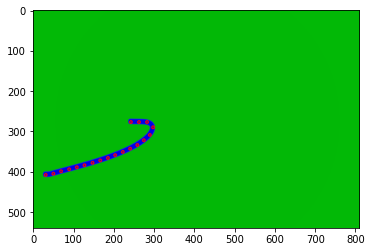

---- optimize translation ----
tensor([ 2.4201e+02,  2.6356e+02, -1.4541e-02, -6.8527e-03, -7.0724e-01,
        -1.9707e+00, -2.3914e+00, -2.5515e+00, -2.6465e+00, -2.7073e+00,
        -2.7566e+00, -2.7860e+00, -2.8178e+00, -2.8375e+00, -2.8602e+00,
        -2.8726e+00, -2.8753e+00, -2.8882e+00, -2.8599e+00, -2.9671e+00],
       device='cuda:0')
tensor(288.7032, device='cuda:0')
tensor([ 2.4142e+02,  2.6359e+02, -1.4541e-02, -6.8527e-03, -7.0724e-01,
        -1.9707e+00, -2.3914e+00, -2.5515e+00, -2.6465e+00, -2.7073e+00,
        -2.7566e+00, -2.7860e+00, -2.8178e+00, -2.8375e+00, -2.8602e+00,
        -2.8726e+00, -2.8753e+00, -2.8882e+00, -2.8599e+00, -2.9671e+00],
       device='cuda:0')
tensor(287.7458, device='cuda:0')
tensor([ 2.4139e+02,  2.6357e+02, -1.4541e-02, -6.8527e-03, -7.0724e-01,
        -1.9707e+00, -2.3914e+00, -2.5515e+00, -2.6465e+00, -2.7073e+00,
        -2.7566e+00, -2.7860e+00, -2.8178e+00, -2.8375e+00, -2.8602e+00,
        -2.8726e+00, -2.8753e+00, -2.8882e+00, -

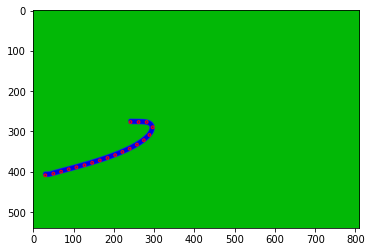

---- optimize translation ----
tensor([ 2.4139e+02,  2.6357e+02, -1.6422e-02, -5.7548e-03, -7.0020e-01,
        -1.9846e+00, -2.3808e+00, -2.5578e+00, -2.6399e+00, -2.7128e+00,
        -2.7548e+00, -2.7856e+00, -2.8176e+00, -2.8367e+00, -2.8612e+00,
        -2.8649e+00, -2.8742e+00, -2.8865e+00, -2.8584e+00, -2.9694e+00],
       device='cuda:0')
tensor(286.4979, device='cuda:0')
tensor([ 2.4096e+02,  2.6355e+02, -1.6422e-02, -5.7548e-03, -7.0020e-01,
        -1.9846e+00, -2.3808e+00, -2.5578e+00, -2.6399e+00, -2.7128e+00,
        -2.7548e+00, -2.7856e+00, -2.8176e+00, -2.8367e+00, -2.8612e+00,
        -2.8649e+00, -2.8742e+00, -2.8865e+00, -2.8584e+00, -2.9694e+00],
       device='cuda:0')
tensor(286.0672, device='cuda:0')
tensor([ 2.4103e+02,  2.6354e+02, -1.6422e-02, -5.7548e-03, -7.0020e-01,
        -1.9846e+00, -2.3808e+00, -2.5578e+00, -2.6399e+00, -2.7128e+00,
        -2.7548e+00, -2.7856e+00, -2.8176e+00, -2.8367e+00, -2.8612e+00,
        -2.8649e+00, -2.8742e+00, -2.8865e+00, -

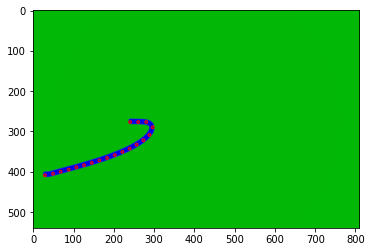

---- optimize translation ----
tensor([ 2.4099e+02,  2.6354e+02, -1.3913e-02, -4.1308e-03, -7.0261e-01,
        -1.9870e+00, -2.3882e+00, -2.5495e+00, -2.6415e+00, -2.7138e+00,
        -2.7522e+00, -2.7911e+00, -2.8210e+00, -2.8272e+00, -2.8628e+00,
        -2.8622e+00, -2.8727e+00, -2.8873e+00, -2.8536e+00, -2.9740e+00],
       device='cuda:0')
tensor(286.2933, device='cuda:0')
tensor([ 2.4079e+02,  2.6355e+02, -1.3913e-02, -4.1308e-03, -7.0261e-01,
        -1.9870e+00, -2.3882e+00, -2.5495e+00, -2.6415e+00, -2.7138e+00,
        -2.7522e+00, -2.7911e+00, -2.8210e+00, -2.8272e+00, -2.8628e+00,
        -2.8622e+00, -2.8727e+00, -2.8873e+00, -2.8536e+00, -2.9740e+00],
       device='cuda:0')
tensor(286.1855, device='cuda:0')
tensor([ 2.4078e+02,  2.6354e+02, -1.3913e-02, -4.1308e-03, -7.0261e-01,
        -1.9870e+00, -2.3882e+00, -2.5495e+00, -2.6415e+00, -2.7138e+00,
        -2.7522e+00, -2.7911e+00, -2.8210e+00, -2.8272e+00, -2.8628e+00,
        -2.8622e+00, -2.8727e+00, -2.8873e+00, -

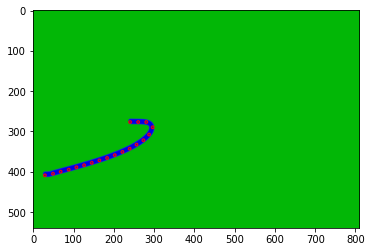

---- optimize translation ----
tensor([ 2.4080e+02,  2.6355e+02, -1.4528e-02, -5.9262e-03, -6.9556e-01,
        -1.9973e+00, -2.3798e+00, -2.5565e+00, -2.6388e+00, -2.7124e+00,
        -2.7543e+00, -2.7851e+00, -2.8172e+00, -2.8376e+00, -2.8521e+00,
        -2.8667e+00, -2.8720e+00, -2.8859e+00, -2.8526e+00, -2.9762e+00],
       device='cuda:0')
tensor(285.5656, device='cuda:0')
tensor([ 2.4070e+02,  2.6360e+02, -1.4528e-02, -5.9262e-03, -6.9556e-01,
        -1.9973e+00, -2.3798e+00, -2.5565e+00, -2.6388e+00, -2.7124e+00,
        -2.7543e+00, -2.7851e+00, -2.8172e+00, -2.8376e+00, -2.8521e+00,
        -2.8667e+00, -2.8720e+00, -2.8859e+00, -2.8526e+00, -2.9762e+00],
       device='cuda:0')
tensor(285.5195, device='cuda:0')
tensor([ 2.4072e+02,  2.6359e+02, -1.4528e-02, -5.9262e-03, -6.9556e-01,
        -1.9973e+00, -2.3798e+00, -2.5565e+00, -2.6388e+00, -2.7124e+00,
        -2.7543e+00, -2.7851e+00, -2.8172e+00, -2.8376e+00, -2.8521e+00,
        -2.8667e+00, -2.8720e+00, -2.8859e+00, -

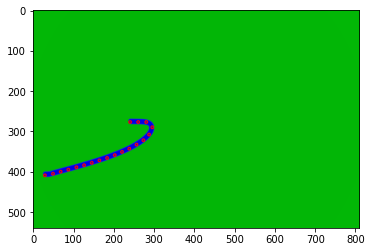

---- optimize translation ----
tensor([ 2.4071e+02,  2.6359e+02, -1.8659e-02, -2.4035e-04, -7.0373e-01,
        -1.9952e+00, -2.3837e+00, -2.5536e+00, -2.6509e+00, -2.7014e+00,
        -2.7547e+00, -2.7883e+00, -2.8125e+00, -2.8433e+00, -2.8503e+00,
        -2.8666e+00, -2.8688e+00, -2.8875e+00, -2.8493e+00, -2.9793e+00],
       device='cuda:0')
tensor(283.6095, device='cuda:0')
tensor([ 2.4053e+02,  2.6358e+02, -1.8659e-02, -2.4035e-04, -7.0373e-01,
        -1.9952e+00, -2.3837e+00, -2.5536e+00, -2.6509e+00, -2.7014e+00,
        -2.7547e+00, -2.7883e+00, -2.8125e+00, -2.8433e+00, -2.8503e+00,
        -2.8666e+00, -2.8688e+00, -2.8875e+00, -2.8493e+00, -2.9793e+00],
       device='cuda:0')
tensor(283.5477, device='cuda:0')
tensor([ 2.4051e+02,  2.6358e+02, -1.8659e-02, -2.4035e-04, -7.0373e-01,
        -1.9952e+00, -2.3837e+00, -2.5536e+00, -2.6509e+00, -2.7014e+00,
        -2.7547e+00, -2.7883e+00, -2.8125e+00, -2.8433e+00, -2.8503e+00,
        -2.8666e+00, -2.8688e+00, -2.8875e+00, -

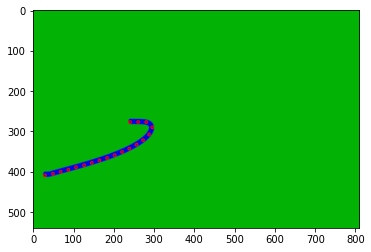

---- optimize translation ----
tensor([ 2.4050e+02,  2.6358e+02, -1.7686e-02,  3.2562e-03, -7.0235e-01,
        -1.9961e+00, -2.3837e+00, -2.5473e+00, -2.6483e+00, -2.7061e+00,
        -2.7557e+00, -2.7888e+00, -2.8148e+00, -2.8359e+00, -2.8534e+00,
        -2.8653e+00, -2.8679e+00, -2.8870e+00, -2.8482e+00, -2.9828e+00],
       device='cuda:0')
tensor(283.8015, device='cuda:0')
tensor([ 2.4047e+02,  2.6359e+02, -1.7686e-02,  3.2562e-03, -7.0235e-01,
        -1.9961e+00, -2.3837e+00, -2.5473e+00, -2.6483e+00, -2.7061e+00,
        -2.7557e+00, -2.7888e+00, -2.8148e+00, -2.8359e+00, -2.8534e+00,
        -2.8653e+00, -2.8679e+00, -2.8870e+00, -2.8482e+00, -2.9828e+00],
       device='cuda:0')
tensor(283.7865, device='cuda:0')
tensor([ 2.4046e+02,  2.6358e+02, -1.7686e-02,  3.2562e-03, -7.0235e-01,
        -1.9961e+00, -2.3837e+00, -2.5473e+00, -2.6483e+00, -2.7061e+00,
        -2.7557e+00, -2.7888e+00, -2.8148e+00, -2.8359e+00, -2.8534e+00,
        -2.8653e+00, -2.8679e+00, -2.8870e+00, -

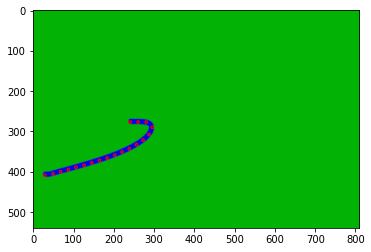

---- optimize translation ----
tensor([ 2.4045e+02,  2.6359e+02, -1.9568e-02,  4.0457e-03, -6.9759e-01,
        -1.9999e+00, -2.3810e+00, -2.5522e+00, -2.6387e+00, -2.7132e+00,
        -2.7518e+00, -2.7887e+00, -2.8215e+00, -2.8288e+00, -2.8540e+00,
        -2.8639e+00, -2.8691e+00, -2.8875e+00, -2.8454e+00, -2.9839e+00],
       device='cuda:0')
tensor(283.7252, device='cuda:0')
tensor([ 2.4031e+02,  2.6359e+02, -1.9568e-02,  4.0457e-03, -6.9759e-01,
        -1.9999e+00, -2.3810e+00, -2.5522e+00, -2.6387e+00, -2.7132e+00,
        -2.7518e+00, -2.7887e+00, -2.8215e+00, -2.8288e+00, -2.8540e+00,
        -2.8639e+00, -2.8691e+00, -2.8875e+00, -2.8454e+00, -2.9839e+00],
       device='cuda:0')
tensor(283.7098, device='cuda:0')
tensor([ 2.4035e+02,  2.6358e+02, -1.9568e-02,  4.0457e-03, -6.9759e-01,
        -1.9999e+00, -2.3810e+00, -2.5522e+00, -2.6387e+00, -2.7132e+00,
        -2.7518e+00, -2.7887e+00, -2.8215e+00, -2.8288e+00, -2.8540e+00,
        -2.8639e+00, -2.8691e+00, -2.8875e+00, -

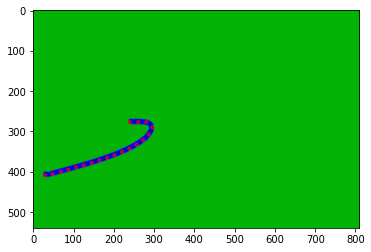

---- optimize translation ----
tensor([ 2.4035e+02,  2.6358e+02, -1.8075e-02, -3.5568e-05, -7.0077e-01,
        -2.0025e+00, -2.3814e+00, -2.5545e+00, -2.6361e+00, -2.7161e+00,
        -2.7516e+00, -2.7885e+00, -2.8179e+00, -2.8337e+00, -2.8511e+00,
        -2.8650e+00, -2.8687e+00, -2.8880e+00, -2.8445e+00, -2.9863e+00],
       device='cuda:0')
tensor(283.7932, device='cuda:0')
tensor([ 2.4010e+02,  2.6362e+02, -1.8075e-02, -3.5568e-05, -7.0077e-01,
        -2.0025e+00, -2.3814e+00, -2.5545e+00, -2.6361e+00, -2.7161e+00,
        -2.7516e+00, -2.7885e+00, -2.8179e+00, -2.8337e+00, -2.8511e+00,
        -2.8650e+00, -2.8687e+00, -2.8880e+00, -2.8445e+00, -2.9863e+00],
       device='cuda:0')
tensor(283.5945, device='cuda:0')
tensor([ 2.4009e+02,  2.6361e+02, -1.8075e-02, -3.5568e-05, -7.0077e-01,
        -2.0025e+00, -2.3814e+00, -2.5545e+00, -2.6361e+00, -2.7161e+00,
        -2.7516e+00, -2.7885e+00, -2.8179e+00, -2.8337e+00, -2.8511e+00,
        -2.8650e+00, -2.8687e+00, -2.8880e+00, -

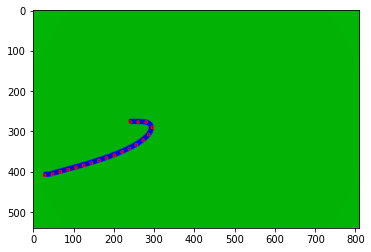

---- optimize translation ----
tensor([ 2.4009e+02,  2.6361e+02, -1.9630e-02,  9.3805e-05, -7.0027e-01,
        -2.0121e+00, -2.3765e+00, -2.5515e+00, -2.6525e+00, -2.6981e+00,
        -2.7551e+00, -2.7923e+00, -2.8085e+00, -2.8425e+00, -2.8426e+00,
        -2.8691e+00, -2.8664e+00, -2.8879e+00, -2.8435e+00, -2.9894e+00],
       device='cuda:0')
tensor(283.4123, device='cuda:0')
tensor([ 2.4012e+02,  2.6361e+02, -1.9630e-02,  9.3805e-05, -7.0027e-01,
        -2.0121e+00, -2.3765e+00, -2.5515e+00, -2.6525e+00, -2.6981e+00,
        -2.7551e+00, -2.7923e+00, -2.8085e+00, -2.8425e+00, -2.8426e+00,
        -2.8691e+00, -2.8664e+00, -2.8879e+00, -2.8435e+00, -2.9894e+00],
       device='cuda:0')
tensor(283.4152, device='cuda:0')
---- optimize rotation ----
tensor([ 2.4009e+02,  2.6361e+02, -1.9630e-02,  9.3805e-05, -7.0027e-01,
        -2.0121e+00, -2.3765e+00, -2.5515e+00, -2.6525e+00, -2.6981e+00,
        -2.7551e+00, -2.7923e+00, -2.8085e+00, -2.8425e+00, -2.8426e+00,
        -2.8691e+00,

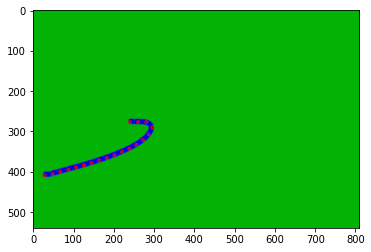

---- optimize translation ----
tensor([ 2.4011e+02,  2.6361e+02, -2.0103e-02,  1.4343e-03, -7.0085e-01,
        -2.0128e+00, -2.3765e+00, -2.5533e+00, -2.6480e+00, -2.7035e+00,
        -2.7543e+00, -2.7913e+00, -2.8115e+00, -2.8398e+00, -2.8416e+00,
        -2.8685e+00, -2.8667e+00, -2.8882e+00, -2.8423e+00, -2.9899e+00],
       device='cuda:0')
tensor(283.0555, device='cuda:0')
tensor([ 2.4002e+02,  2.6362e+02, -2.0103e-02,  1.4343e-03, -7.0085e-01,
        -2.0128e+00, -2.3765e+00, -2.5533e+00, -2.6480e+00, -2.7035e+00,
        -2.7543e+00, -2.7913e+00, -2.8115e+00, -2.8398e+00, -2.8416e+00,
        -2.8685e+00, -2.8667e+00, -2.8882e+00, -2.8423e+00, -2.9899e+00],
       device='cuda:0')
tensor(283.0521, device='cuda:0')
tensor([ 2.4006e+02,  2.6361e+02, -2.0103e-02,  1.4343e-03, -7.0085e-01,
        -2.0128e+00, -2.3765e+00, -2.5533e+00, -2.6480e+00, -2.7035e+00,
        -2.7543e+00, -2.7913e+00, -2.8115e+00, -2.8398e+00, -2.8416e+00,
        -2.8685e+00, -2.8667e+00, -2.8882e+00, -

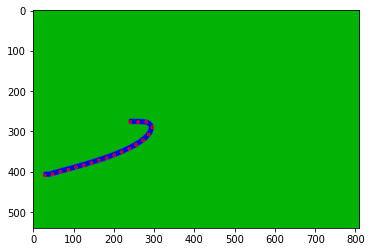

---- optimize translation ----
tensor([ 2.4005e+02,  2.6361e+02, -2.0232e-02,  1.9268e-03, -7.0168e-01,
        -2.0143e+00, -2.3746e+00, -2.5547e+00, -2.6431e+00, -2.7090e+00,
        -2.7488e+00, -2.7969e+00, -2.8101e+00, -2.8375e+00, -2.8491e+00,
        -2.8628e+00, -2.8662e+00, -2.8886e+00, -2.8417e+00, -2.9910e+00],
       device='cuda:0')
tensor(282.5482, device='cuda:0')
tensor([ 2.3993e+02,  2.6362e+02, -2.0232e-02,  1.9268e-03, -7.0168e-01,
        -2.0143e+00, -2.3746e+00, -2.5547e+00, -2.6431e+00, -2.7090e+00,
        -2.7488e+00, -2.7969e+00, -2.8101e+00, -2.8375e+00, -2.8491e+00,
        -2.8628e+00, -2.8662e+00, -2.8886e+00, -2.8417e+00, -2.9910e+00],
       device='cuda:0')
tensor(282.5344, device='cuda:0')
tensor([ 2.3991e+02,  2.6362e+02, -2.0232e-02,  1.9268e-03, -7.0168e-01,
        -2.0143e+00, -2.3746e+00, -2.5547e+00, -2.6431e+00, -2.7090e+00,
        -2.7488e+00, -2.7969e+00, -2.8101e+00, -2.8375e+00, -2.8491e+00,
        -2.8628e+00, -2.8662e+00, -2.8886e+00, -

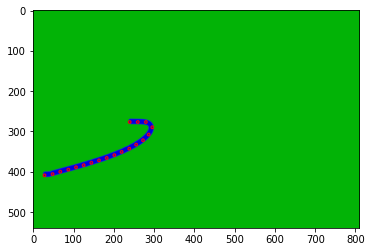

---- optimize translation ----
tensor([ 2.3990e+02,  2.6362e+02, -2.1418e-02,  6.1283e-03, -6.9861e-01,
        -2.0098e+00, -2.3786e+00, -2.5468e+00, -2.6467e+00, -2.7049e+00,
        -2.7540e+00, -2.7916e+00, -2.8128e+00, -2.8380e+00, -2.8475e+00,
        -2.8610e+00, -2.8689e+00, -2.8859e+00, -2.8426e+00, -2.9907e+00],
       device='cuda:0')
tensor(282.2180, device='cuda:0')
tensor([ 2.3976e+02,  2.6370e+02, -2.1418e-02,  6.1283e-03, -6.9861e-01,
        -2.0098e+00, -2.3786e+00, -2.5468e+00, -2.6467e+00, -2.7049e+00,
        -2.7540e+00, -2.7916e+00, -2.8128e+00, -2.8380e+00, -2.8475e+00,
        -2.8610e+00, -2.8689e+00, -2.8859e+00, -2.8426e+00, -2.9907e+00],
       device='cuda:0')
tensor(282.1613, device='cuda:0')
tensor([ 2.3977e+02,  2.6368e+02, -2.1418e-02,  6.1283e-03, -6.9861e-01,
        -2.0098e+00, -2.3786e+00, -2.5468e+00, -2.6467e+00, -2.7049e+00,
        -2.7540e+00, -2.7916e+00, -2.8128e+00, -2.8380e+00, -2.8475e+00,
        -2.8610e+00, -2.8689e+00, -2.8859e+00, -

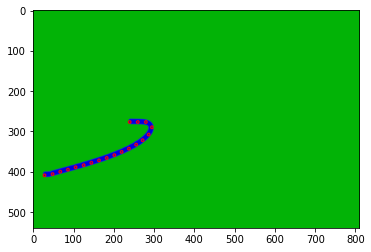

---- optimize translation ----
tensor([ 2.3975e+02,  2.6369e+02, -2.6718e-02,  7.0876e-03, -7.0292e-01,
        -2.0171e+00, -2.3734e+00, -2.5543e+00, -2.6450e+00, -2.7080e+00,
        -2.7496e+00, -2.7865e+00, -2.8229e+00, -2.8236e+00, -2.8562e+00,
        -2.8583e+00, -2.8697e+00, -2.8865e+00, -2.8399e+00, -2.9955e+00],
       device='cuda:0')
tensor(282.6680, device='cuda:0')
tensor([ 2.3965e+02,  2.6369e+02, -2.6718e-02,  7.0876e-03, -7.0292e-01,
        -2.0171e+00, -2.3734e+00, -2.5543e+00, -2.6450e+00, -2.7080e+00,
        -2.7496e+00, -2.7865e+00, -2.8229e+00, -2.8236e+00, -2.8562e+00,
        -2.8583e+00, -2.8697e+00, -2.8865e+00, -2.8399e+00, -2.9955e+00],
       device='cuda:0')
tensor(282.6430, device='cuda:0')
tensor([ 2.3967e+02,  2.6368e+02, -2.6718e-02,  7.0876e-03, -7.0292e-01,
        -2.0171e+00, -2.3734e+00, -2.5543e+00, -2.6450e+00, -2.7080e+00,
        -2.7496e+00, -2.7865e+00, -2.8229e+00, -2.8236e+00, -2.8562e+00,
        -2.8583e+00, -2.8697e+00, -2.8865e+00, -

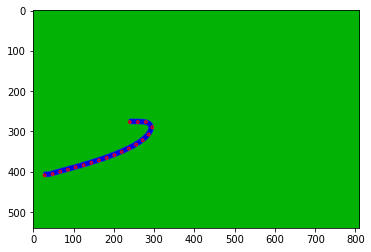

---- optimize translation ----
tensor([ 2.3966e+02,  2.6368e+02, -2.3988e-02, -2.8105e-04, -6.9525e-01,
        -2.0247e+00, -2.3766e+00, -2.5506e+00, -2.6412e+00, -2.7081e+00,
        -2.7511e+00, -2.7885e+00, -2.8161e+00, -2.8276e+00, -2.8537e+00,
        -2.8607e+00, -2.8719e+00, -2.8817e+00, -2.8413e+00, -2.9960e+00],
       device='cuda:0')
tensor(282.3683, device='cuda:0')
tensor([ 2.3951e+02,  2.6362e+02, -2.3988e-02, -2.8105e-04, -6.9525e-01,
        -2.0247e+00, -2.3766e+00, -2.5506e+00, -2.6412e+00, -2.7081e+00,
        -2.7511e+00, -2.7885e+00, -2.8161e+00, -2.8276e+00, -2.8537e+00,
        -2.8607e+00, -2.8719e+00, -2.8817e+00, -2.8413e+00, -2.9960e+00],
       device='cuda:0')
tensor(282.3660, device='cuda:0')
tensor([ 2.3948e+02,  2.6362e+02, -2.3988e-02, -2.8105e-04, -6.9525e-01,
        -2.0247e+00, -2.3766e+00, -2.5506e+00, -2.6412e+00, -2.7081e+00,
        -2.7511e+00, -2.7885e+00, -2.8161e+00, -2.8276e+00, -2.8537e+00,
        -2.8607e+00, -2.8719e+00, -2.8817e+00, -

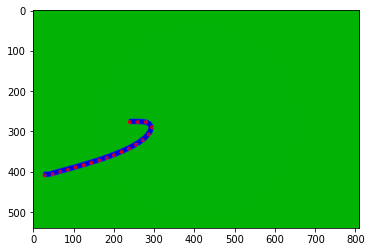

---- optimize translation ----
tensor([ 2.3947e+02,  2.6361e+02, -1.8697e-02,  2.6571e-04, -6.9517e-01,
        -2.0172e+00, -2.3774e+00, -2.5546e+00, -2.6393e+00, -2.7026e+00,
        -2.7604e+00, -2.7794e+00, -2.8169e+00, -2.8326e+00, -2.8510e+00,
        -2.8623e+00, -2.8697e+00, -2.8813e+00, -2.8433e+00, -2.9949e+00],
       device='cuda:0')
tensor(282.3342, device='cuda:0')
tensor([ 2.3942e+02,  2.6363e+02, -1.8697e-02,  2.6571e-04, -6.9517e-01,
        -2.0172e+00, -2.3774e+00, -2.5546e+00, -2.6393e+00, -2.7026e+00,
        -2.7604e+00, -2.7794e+00, -2.8169e+00, -2.8326e+00, -2.8510e+00,
        -2.8623e+00, -2.8697e+00, -2.8813e+00, -2.8433e+00, -2.9949e+00],
       device='cuda:0')
tensor(282.3274, device='cuda:0')
tensor([ 2.3941e+02,  2.6362e+02, -1.8697e-02,  2.6571e-04, -6.9517e-01,
        -2.0172e+00, -2.3774e+00, -2.5546e+00, -2.6393e+00, -2.7026e+00,
        -2.7604e+00, -2.7794e+00, -2.8169e+00, -2.8326e+00, -2.8510e+00,
        -2.8623e+00, -2.8697e+00, -2.8813e+00, -

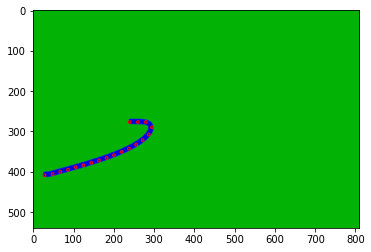

---- optimize translation ----
tensor([ 2.3942e+02,  2.6363e+02, -2.1326e-02,  3.3993e-03, -6.9528e-01,
        -2.0198e+00, -2.3713e+00, -2.5569e+00, -2.6397e+00, -2.7014e+00,
        -2.7608e+00, -2.7847e+00, -2.8169e+00, -2.8294e+00, -2.8535e+00,
        -2.8541e+00, -2.8734e+00, -2.8816e+00, -2.8407e+00, -2.9977e+00],
       device='cuda:0')
tensor(282.0232, device='cuda:0')
tensor([ 2.3937e+02,  2.6363e+02, -2.1326e-02,  3.3993e-03, -6.9528e-01,
        -2.0198e+00, -2.3713e+00, -2.5569e+00, -2.6397e+00, -2.7014e+00,
        -2.7608e+00, -2.7847e+00, -2.8169e+00, -2.8294e+00, -2.8535e+00,
        -2.8541e+00, -2.8734e+00, -2.8816e+00, -2.8407e+00, -2.9977e+00],
       device='cuda:0')
tensor(282.0191, device='cuda:0')
tensor([ 2.3932e+02,  2.6363e+02, -2.1326e-02,  3.3993e-03, -6.9528e-01,
        -2.0198e+00, -2.3713e+00, -2.5569e+00, -2.6397e+00, -2.7014e+00,
        -2.7608e+00, -2.7847e+00, -2.8169e+00, -2.8294e+00, -2.8535e+00,
        -2.8541e+00, -2.8734e+00, -2.8816e+00, -

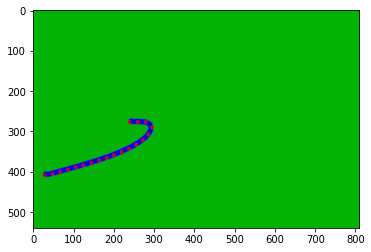

---- optimize translation ----
tensor([ 2.3935e+02,  2.6363e+02, -2.0464e-02,  6.6628e-04, -6.9102e-01,
        -2.0243e+00, -2.3639e+00, -2.5598e+00, -2.6374e+00, -2.7088e+00,
        -2.7548e+00, -2.7841e+00, -2.8210e+00, -2.8283e+00, -2.8497e+00,
        -2.8598e+00, -2.8629e+00, -2.8902e+00, -2.8378e+00, -2.9989e+00],
       device='cuda:0')
tensor(280.7290, device='cuda:0')
tensor([ 2.3924e+02,  2.6364e+02, -2.0464e-02,  6.6628e-04, -6.9102e-01,
        -2.0243e+00, -2.3639e+00, -2.5598e+00, -2.6374e+00, -2.7088e+00,
        -2.7548e+00, -2.7841e+00, -2.8210e+00, -2.8283e+00, -2.8497e+00,
        -2.8598e+00, -2.8629e+00, -2.8902e+00, -2.8378e+00, -2.9989e+00],
       device='cuda:0')
tensor(280.6880, device='cuda:0')
tensor([ 2.3923e+02,  2.6364e+02, -2.0464e-02,  6.6628e-04, -6.9102e-01,
        -2.0243e+00, -2.3639e+00, -2.5598e+00, -2.6374e+00, -2.7088e+00,
        -2.7548e+00, -2.7841e+00, -2.8210e+00, -2.8283e+00, -2.8497e+00,
        -2.8598e+00, -2.8629e+00, -2.8902e+00, -

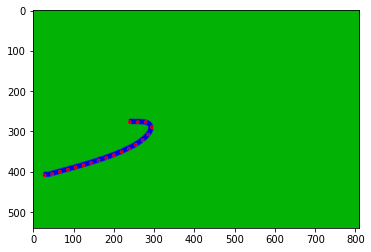

---- optimize translation ----
tensor([ 2.3923e+02,  2.6364e+02, -2.2985e-02,  3.5889e-03, -6.9425e-01,
        -2.0215e+00, -2.3796e+00, -2.5435e+00, -2.6462e+00, -2.7021e+00,
        -2.7575e+00, -2.7890e+00, -2.8096e+00, -2.8410e+00, -2.8387e+00,
        -2.8652e+00, -2.8600e+00, -2.8931e+00, -2.8339e+00, -3.0028e+00],
       device='cuda:0')
tensor(280.7299, device='cuda:0')
tensor([ 2.3911e+02,  2.6365e+02, -2.2985e-02,  3.5889e-03, -6.9425e-01,
        -2.0215e+00, -2.3796e+00, -2.5435e+00, -2.6462e+00, -2.7021e+00,
        -2.7575e+00, -2.7890e+00, -2.8096e+00, -2.8410e+00, -2.8387e+00,
        -2.8652e+00, -2.8600e+00, -2.8931e+00, -2.8339e+00, -3.0028e+00],
       device='cuda:0')
tensor(280.7248, device='cuda:0')
tensor([ 2.3913e+02,  2.6365e+02, -2.2985e-02,  3.5889e-03, -6.9425e-01,
        -2.0215e+00, -2.3796e+00, -2.5435e+00, -2.6462e+00, -2.7021e+00,
        -2.7575e+00, -2.7890e+00, -2.8096e+00, -2.8410e+00, -2.8387e+00,
        -2.8652e+00, -2.8600e+00, -2.8931e+00, -

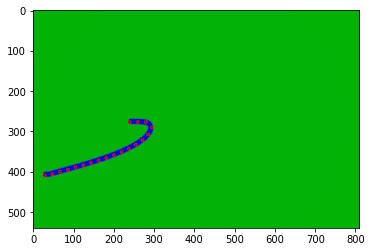

---- optimize translation ----
tensor([ 2.3912e+02,  2.6365e+02, -2.4245e-02,  7.0710e-03, -6.9179e-01,
        -2.0174e+00, -2.3782e+00, -2.5471e+00, -2.6414e+00, -2.7067e+00,
        -2.7567e+00, -2.7841e+00, -2.8167e+00, -2.8270e+00, -2.8521e+00,
        -2.8581e+00, -2.8683e+00, -2.8841e+00, -2.8382e+00, -2.9999e+00],
       device='cuda:0')
tensor(280.4772, device='cuda:0')
tensor([ 2.3905e+02,  2.6366e+02, -2.4245e-02,  7.0710e-03, -6.9179e-01,
        -2.0174e+00, -2.3782e+00, -2.5471e+00, -2.6414e+00, -2.7067e+00,
        -2.7567e+00, -2.7841e+00, -2.8167e+00, -2.8270e+00, -2.8521e+00,
        -2.8581e+00, -2.8683e+00, -2.8841e+00, -2.8382e+00, -2.9999e+00],
       device='cuda:0')
tensor(280.4602, device='cuda:0')
tensor([ 2.3904e+02,  2.6366e+02, -2.4245e-02,  7.0710e-03, -6.9179e-01,
        -2.0174e+00, -2.3782e+00, -2.5471e+00, -2.6414e+00, -2.7067e+00,
        -2.7567e+00, -2.7841e+00, -2.8167e+00, -2.8270e+00, -2.8521e+00,
        -2.8581e+00, -2.8683e+00, -2.8841e+00, -

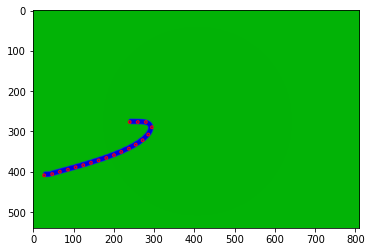

---- optimize translation ----
tensor([ 2.3906e+02,  2.6366e+02, -2.4675e-02,  8.2421e-03, -6.9819e-01,
        -2.0210e+00, -2.3735e+00, -2.5547e+00, -2.6385e+00, -2.7088e+00,
        -2.7507e+00, -2.7901e+00, -2.8131e+00, -2.8262e+00, -2.8563e+00,
        -2.8565e+00, -2.8654e+00, -2.8881e+00, -2.8352e+00, -3.0037e+00],
       device='cuda:0')
tensor(281.2622, device='cuda:0')
tensor([ 2.3910e+02,  2.6364e+02, -2.4675e-02,  8.2421e-03, -6.9819e-01,
        -2.0210e+00, -2.3735e+00, -2.5547e+00, -2.6385e+00, -2.7088e+00,
        -2.7507e+00, -2.7901e+00, -2.8131e+00, -2.8262e+00, -2.8563e+00,
        -2.8565e+00, -2.8654e+00, -2.8881e+00, -2.8352e+00, -3.0037e+00],
       device='cuda:0')
tensor(281.2882, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3906e+02,  2.6366e+02, -2.4675e-02,  8.2421e-03, -6.9819e-01,
        -2.0210e+00, -2.3735e+00, -2.5547e+00, -2.6385e+00, -2.7088e+00,
        -2.7507e+00, -2.7901e+00, -2.8131e+00, -2.8262e+00, -2.8563e+00,
        -2.8565e+00,

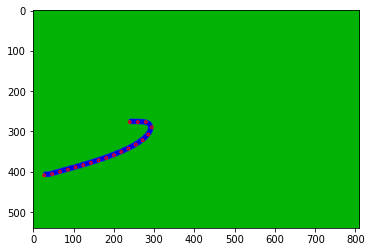

---- optimize translation ----
tensor([ 2.3907e+02,  2.6364e+02, -2.3919e-02,  5.5995e-03, -6.9794e-01,
        -2.0310e+00, -2.3735e+00, -2.5464e+00, -2.6483e+00, -2.6995e+00,
        -2.7593e+00, -2.7815e+00, -2.8155e+00, -2.8342e+00, -2.8477e+00,
        -2.8617e+00, -2.8585e+00, -2.8927e+00, -2.8333e+00, -3.0059e+00],
       device='cuda:0')
tensor(281.4008, device='cuda:0')
tensor([ 2.3897e+02,  2.6364e+02, -2.3919e-02,  5.5995e-03, -6.9794e-01,
        -2.0310e+00, -2.3735e+00, -2.5464e+00, -2.6483e+00, -2.6995e+00,
        -2.7593e+00, -2.7815e+00, -2.8155e+00, -2.8342e+00, -2.8477e+00,
        -2.8617e+00, -2.8585e+00, -2.8927e+00, -2.8333e+00, -3.0059e+00],
       device='cuda:0')
tensor(281.3883, device='cuda:0')
tensor([ 2.3900e+02,  2.6363e+02, -2.3919e-02,  5.5995e-03, -6.9794e-01,
        -2.0310e+00, -2.3735e+00, -2.5464e+00, -2.6483e+00, -2.6995e+00,
        -2.7593e+00, -2.7815e+00, -2.8155e+00, -2.8342e+00, -2.8477e+00,
        -2.8617e+00, -2.8585e+00, -2.8927e+00, -

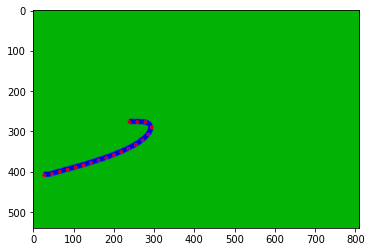

---- optimize translation ----
tensor([ 2.3899e+02,  2.6363e+02, -2.2923e-02,  3.1444e-03, -6.9882e-01,
        -2.0330e+00, -2.3702e+00, -2.5507e+00, -2.6457e+00, -2.7069e+00,
        -2.7528e+00, -2.7853e+00, -2.8145e+00, -2.8319e+00, -2.8474e+00,
        -2.8615e+00, -2.8592e+00, -2.8936e+00, -2.8303e+00, -3.0091e+00],
       device='cuda:0')
tensor(280.7968, device='cuda:0')
tensor([ 2.3896e+02,  2.6362e+02, -2.2923e-02,  3.1444e-03, -6.9882e-01,
        -2.0330e+00, -2.3702e+00, -2.5507e+00, -2.6457e+00, -2.7069e+00,
        -2.7528e+00, -2.7853e+00, -2.8145e+00, -2.8319e+00, -2.8474e+00,
        -2.8615e+00, -2.8592e+00, -2.8936e+00, -2.8303e+00, -3.0091e+00],
       device='cuda:0')
tensor(280.7961, device='cuda:0')
tensor([ 2.3896e+02,  2.6362e+02, -2.2923e-02,  3.1444e-03, -6.9882e-01,
        -2.0330e+00, -2.3702e+00, -2.5507e+00, -2.6457e+00, -2.7069e+00,
        -2.7528e+00, -2.7853e+00, -2.8145e+00, -2.8319e+00, -2.8474e+00,
        -2.8615e+00, -2.8592e+00, -2.8936e+00, -

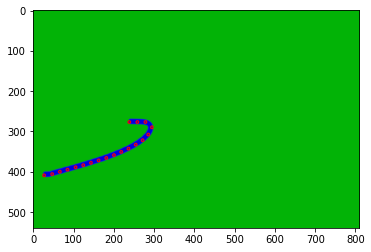

---- optimize translation ----
tensor([ 2.3896e+02,  2.6361e+02, -1.9805e-02, -2.8310e-04, -6.9590e-01,
        -2.0355e+00, -2.3698e+00, -2.5544e+00, -2.6426e+00, -2.7026e+00,
        -2.7566e+00, -2.7846e+00, -2.8133e+00, -2.8330e+00, -2.8492e+00,
        -2.8571e+00, -2.8643e+00, -2.8858e+00, -2.8372e+00, -3.0055e+00],
       device='cuda:0')
tensor(281.3061, device='cuda:0')
tensor([ 2.3876e+02,  2.6364e+02, -1.9805e-02, -2.8310e-04, -6.9590e-01,
        -2.0355e+00, -2.3698e+00, -2.5544e+00, -2.6426e+00, -2.7026e+00,
        -2.7566e+00, -2.7846e+00, -2.8133e+00, -2.8330e+00, -2.8492e+00,
        -2.8571e+00, -2.8643e+00, -2.8858e+00, -2.8372e+00, -3.0055e+00],
       device='cuda:0')
tensor(281.2747, device='cuda:0')
tensor([ 2.3872e+02,  2.6364e+02, -1.9805e-02, -2.8310e-04, -6.9590e-01,
        -2.0355e+00, -2.3698e+00, -2.5544e+00, -2.6426e+00, -2.7026e+00,
        -2.7566e+00, -2.7846e+00, -2.8133e+00, -2.8330e+00, -2.8492e+00,
        -2.8571e+00, -2.8643e+00, -2.8858e+00, -

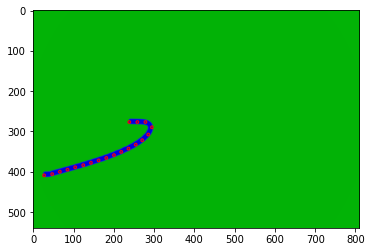

---- optimize translation ----
tensor([ 2.3873e+02,  2.6364e+02, -2.4072e-02,  2.2208e-03, -6.9355e-01,
        -2.0341e+00, -2.3697e+00, -2.5546e+00, -2.6422e+00, -2.7060e+00,
        -2.7501e+00, -2.7848e+00, -2.8143e+00, -2.8328e+00, -2.8474e+00,
        -2.8612e+00, -2.8603e+00, -2.8883e+00, -2.8360e+00, -3.0062e+00],
       device='cuda:0')
tensor(280.6591, device='cuda:0')
tensor([ 2.3868e+02,  2.6365e+02, -2.4072e-02,  2.2208e-03, -6.9355e-01,
        -2.0341e+00, -2.3697e+00, -2.5546e+00, -2.6422e+00, -2.7060e+00,
        -2.7501e+00, -2.7848e+00, -2.8143e+00, -2.8328e+00, -2.8474e+00,
        -2.8612e+00, -2.8603e+00, -2.8883e+00, -2.8360e+00, -3.0062e+00],
       device='cuda:0')
tensor(280.6444, device='cuda:0')
tensor([ 2.3869e+02,  2.6365e+02, -2.4072e-02,  2.2208e-03, -6.9355e-01,
        -2.0341e+00, -2.3697e+00, -2.5546e+00, -2.6422e+00, -2.7060e+00,
        -2.7501e+00, -2.7848e+00, -2.8143e+00, -2.8328e+00, -2.8474e+00,
        -2.8612e+00, -2.8603e+00, -2.8883e+00, -

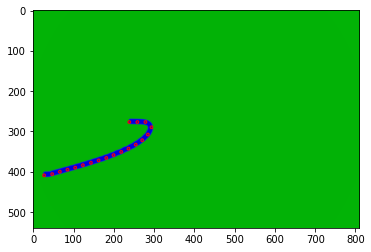

---- optimize translation ----
tensor([ 2.3868e+02,  2.6365e+02, -2.4474e-02,  3.0250e-03, -6.9810e-01,
        -2.0374e+00, -2.3729e+00, -2.5508e+00, -2.6414e+00, -2.7132e+00,
        -2.7447e+00, -2.7843e+00, -2.8113e+00, -2.8362e+00, -2.8474e+00,
        -2.8586e+00, -2.8615e+00, -2.8885e+00, -2.8358e+00, -3.0090e+00],
       device='cuda:0')
tensor(280.0710, device='cuda:0')
tensor([ 2.3852e+02,  2.6366e+02, -2.4474e-02,  3.0250e-03, -6.9810e-01,
        -2.0374e+00, -2.3729e+00, -2.5508e+00, -2.6414e+00, -2.7132e+00,
        -2.7447e+00, -2.7843e+00, -2.8113e+00, -2.8362e+00, -2.8474e+00,
        -2.8586e+00, -2.8615e+00, -2.8885e+00, -2.8358e+00, -3.0090e+00],
       device='cuda:0')
tensor(280.0818, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3868e+02,  2.6365e+02, -2.4474e-02,  3.0250e-03, -6.9810e-01,
        -2.0374e+00, -2.3729e+00, -2.5508e+00, -2.6414e+00, -2.7132e+00,
        -2.7447e+00, -2.7843e+00, -2.8113e+00, -2.8362e+00, -2.8474e+00,
        -2.8586e+00,

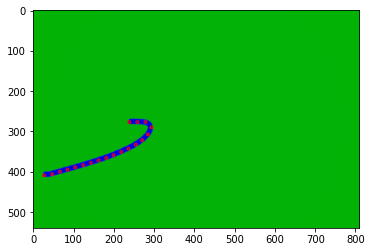

---- optimize translation ----
tensor([ 2.3843e+02,  2.6366e+02, -2.5471e-02,  7.0495e-03, -6.9028e-01,
        -2.0307e+00, -2.3686e+00, -2.5491e+00, -2.6406e+00, -2.7122e+00,
        -2.7494e+00, -2.7800e+00, -2.8151e+00, -2.8303e+00, -2.8505e+00,
        -2.8600e+00, -2.8557e+00, -2.8944e+00, -2.8309e+00, -3.0119e+00],
       device='cuda:0')
tensor(279.7693, device='cuda:0')
tensor([ 2.3842e+02,  2.6372e+02, -2.5471e-02,  7.0495e-03, -6.9028e-01,
        -2.0307e+00, -2.3686e+00, -2.5491e+00, -2.6406e+00, -2.7122e+00,
        -2.7494e+00, -2.7800e+00, -2.8151e+00, -2.8303e+00, -2.8505e+00,
        -2.8600e+00, -2.8557e+00, -2.8944e+00, -2.8309e+00, -3.0119e+00],
       device='cuda:0')
tensor(279.7684, device='cuda:0')
tensor([ 2.3838e+02,  2.6371e+02, -2.5471e-02,  7.0495e-03, -6.9028e-01,
        -2.0307e+00, -2.3686e+00, -2.5491e+00, -2.6406e+00, -2.7122e+00,
        -2.7494e+00, -2.7800e+00, -2.8151e+00, -2.8303e+00, -2.8505e+00,
        -2.8600e+00, -2.8557e+00, -2.8944e+00, -

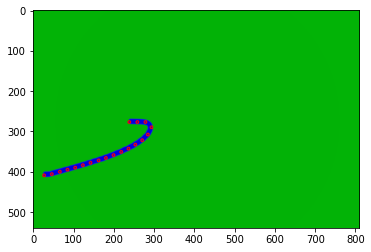

---- optimize translation ----
tensor([ 2.3844e+02,  2.6374e+02, -3.4178e-02,  1.3860e-02, -6.9908e-01,
        -2.0372e+00, -2.3612e+00, -2.5558e+00, -2.6396e+00, -2.7112e+00,
        -2.7531e+00, -2.7781e+00, -2.8143e+00, -2.8330e+00, -2.8484e+00,
        -2.8599e+00, -2.8623e+00, -2.8881e+00, -2.8295e+00, -3.0150e+00],
       device='cuda:0')
tensor(279.8759, device='cuda:0')
tensor([ 2.3859e+02,  2.6392e+02, -3.4178e-02,  1.3860e-02, -6.9908e-01,
        -2.0372e+00, -2.3612e+00, -2.5558e+00, -2.6396e+00, -2.7112e+00,
        -2.7531e+00, -2.7781e+00, -2.8143e+00, -2.8330e+00, -2.8484e+00,
        -2.8599e+00, -2.8623e+00, -2.8881e+00, -2.8295e+00, -3.0150e+00],
       device='cuda:0')
tensor(280.2002, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3844e+02,  2.6374e+02, -3.4178e-02,  1.3860e-02, -6.9908e-01,
        -2.0372e+00, -2.3612e+00, -2.5558e+00, -2.6396e+00, -2.7112e+00,
        -2.7531e+00, -2.7781e+00, -2.8143e+00, -2.8330e+00, -2.8484e+00,
        -2.8599e+00,

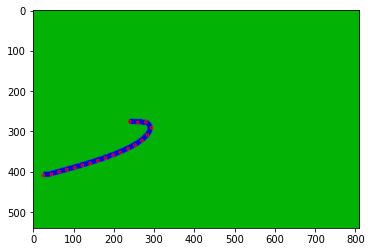

---- optimize translation ----
tensor([ 2.3919e+02,  2.6402e+02, -8.6832e-02,  4.5351e-02, -7.8012e-01,
        -2.0690e+00, -2.3723e+00, -2.5665e+00, -2.6463e+00, -2.7141e+00,
        -2.7551e+00, -2.7876e+00, -2.8098e+00, -2.8359e+00, -2.8419e+00,
        -2.8598e+00, -2.8673e+00, -2.8892e+00, -2.8240e+00, -3.0385e+00],
       device='cuda:0')
tensor(278.9135, device='cuda:0')
tensor([ 2.3933e+02,  2.6395e+02, -8.6832e-02,  4.5351e-02, -7.8012e-01,
        -2.0690e+00, -2.3723e+00, -2.5665e+00, -2.6463e+00, -2.7141e+00,
        -2.7551e+00, -2.7876e+00, -2.8098e+00, -2.8359e+00, -2.8419e+00,
        -2.8598e+00, -2.8673e+00, -2.8892e+00, -2.8240e+00, -3.0385e+00],
       device='cuda:0')
tensor(279.0902, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3919e+02,  2.6402e+02, -8.6832e-02,  4.5351e-02, -7.8012e-01,
        -2.0690e+00, -2.3723e+00, -2.5665e+00, -2.6463e+00, -2.7141e+00,
        -2.7551e+00, -2.7876e+00, -2.8098e+00, -2.8359e+00, -2.8419e+00,
        -2.8598e+00,

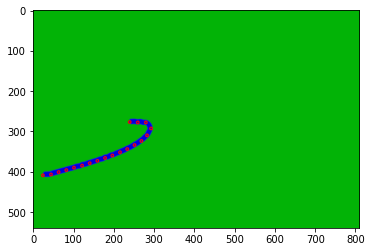

---- optimize translation ----
tensor([ 2.3992e+02,  2.6386e+02, -7.6175e-02,  2.3629e-02, -8.5543e-01,
        -2.1088e+00, -2.3860e+00, -2.5720e+00, -2.6504e+00, -2.7225e+00,
        -2.7534e+00, -2.7935e+00, -2.8056e+00, -2.8479e+00, -2.8308e+00,
        -2.8681e+00, -2.8610e+00, -2.8917e+00, -2.8229e+00, -3.0621e+00],
       device='cuda:0')
tensor(278.9501, device='cuda:0')
tensor([ 2.3990e+02,  2.6392e+02, -7.6175e-02,  2.3629e-02, -8.5543e-01,
        -2.1088e+00, -2.3860e+00, -2.5720e+00, -2.6504e+00, -2.7225e+00,
        -2.7534e+00, -2.7935e+00, -2.8056e+00, -2.8479e+00, -2.8308e+00,
        -2.8681e+00, -2.8610e+00, -2.8917e+00, -2.8229e+00, -3.0621e+00],
       device='cuda:0')
tensor(278.9738, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3992e+02,  2.6386e+02, -7.6175e-02,  2.3629e-02, -8.5543e-01,
        -2.1088e+00, -2.3860e+00, -2.5720e+00, -2.6504e+00, -2.7225e+00,
        -2.7534e+00, -2.7935e+00, -2.8056e+00, -2.8479e+00, -2.8308e+00,
        -2.8681e+00,

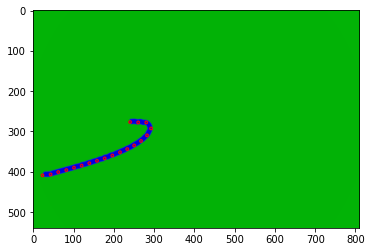

---- optimize translation ----
tensor([ 2.4012e+02,  2.6392e+02, -8.3955e-02,  2.8258e-02, -8.8089e-01,
        -2.1108e+00, -2.3956e+00, -2.5690e+00, -2.6590e+00, -2.7151e+00,
        -2.7592e+00, -2.7877e+00, -2.8177e+00, -2.8326e+00, -2.8440e+00,
        -2.8614e+00, -2.8645e+00, -2.8931e+00, -2.8185e+00, -3.0729e+00],
       device='cuda:0')
tensor(278.7773, device='cuda:0')
tensor([ 2.4007e+02,  2.6393e+02, -8.3955e-02,  2.8258e-02, -8.8089e-01,
        -2.1108e+00, -2.3956e+00, -2.5690e+00, -2.6590e+00, -2.7151e+00,
        -2.7592e+00, -2.7877e+00, -2.8177e+00, -2.8326e+00, -2.8440e+00,
        -2.8614e+00, -2.8645e+00, -2.8931e+00, -2.8185e+00, -3.0729e+00],
       device='cuda:0')
tensor(278.7631, device='cuda:0')
tensor([ 2.4009e+02,  2.6392e+02, -8.3955e-02,  2.8258e-02, -8.8089e-01,
        -2.1108e+00, -2.3956e+00, -2.5690e+00, -2.6590e+00, -2.7151e+00,
        -2.7592e+00, -2.7877e+00, -2.8177e+00, -2.8326e+00, -2.8440e+00,
        -2.8614e+00, -2.8645e+00, -2.8931e+00, -

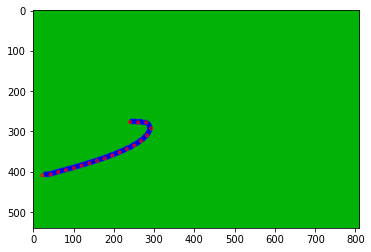

---- optimize translation ----
tensor([ 2.4022e+02,  2.6391e+02, -8.4052e-02,  2.9336e-02, -9.0247e-01,
        -2.1142e+00, -2.4006e+00, -2.5730e+00, -2.6537e+00, -2.7206e+00,
        -2.7542e+00, -2.7923e+00, -2.8139e+00, -2.8359e+00, -2.8387e+00,
        -2.8658e+00, -2.8667e+00, -2.8905e+00, -2.8204e+00, -3.0779e+00],
       device='cuda:0')
tensor(278.7228, device='cuda:0')
tensor([ 2.4014e+02,  2.6392e+02, -8.4052e-02,  2.9336e-02, -9.0247e-01,
        -2.1142e+00, -2.4006e+00, -2.5730e+00, -2.6537e+00, -2.7206e+00,
        -2.7542e+00, -2.7923e+00, -2.8139e+00, -2.8359e+00, -2.8387e+00,
        -2.8658e+00, -2.8667e+00, -2.8905e+00, -2.8204e+00, -3.0779e+00],
       device='cuda:0')
tensor(278.7142, device='cuda:0')
tensor([ 2.4018e+02,  2.6391e+02, -8.4052e-02,  2.9336e-02, -9.0247e-01,
        -2.1142e+00, -2.4006e+00, -2.5730e+00, -2.6537e+00, -2.7206e+00,
        -2.7542e+00, -2.7923e+00, -2.8139e+00, -2.8359e+00, -2.8387e+00,
        -2.8658e+00, -2.8667e+00, -2.8905e+00, -

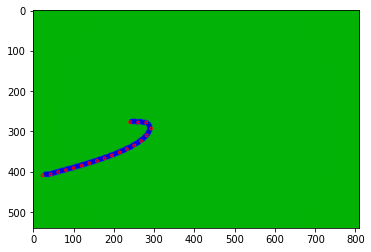

---- optimize translation ----
tensor([ 2.4019e+02,  2.6390e+02, -8.0262e-02,  2.1684e-02, -9.0350e-01,
        -2.1258e+00, -2.3944e+00, -2.5766e+00, -2.6513e+00, -2.7200e+00,
        -2.7564e+00, -2.7894e+00, -2.8154e+00, -2.8307e+00, -2.8523e+00,
        -2.8523e+00, -2.8714e+00, -2.8933e+00, -2.8166e+00, -3.0835e+00],
       device='cuda:0')
tensor(279.2076, device='cuda:0')
tensor([ 2.4014e+02,  2.6390e+02, -8.0262e-02,  2.1684e-02, -9.0350e-01,
        -2.1258e+00, -2.3944e+00, -2.5766e+00, -2.6513e+00, -2.7200e+00,
        -2.7564e+00, -2.7894e+00, -2.8154e+00, -2.8307e+00, -2.8523e+00,
        -2.8523e+00, -2.8714e+00, -2.8933e+00, -2.8166e+00, -3.0835e+00],
       device='cuda:0')
tensor(279.2047, device='cuda:0')
tensor([ 2.4018e+02,  2.6389e+02, -8.0262e-02,  2.1684e-02, -9.0350e-01,
        -2.1258e+00, -2.3944e+00, -2.5766e+00, -2.6513e+00, -2.7200e+00,
        -2.7564e+00, -2.7894e+00, -2.8154e+00, -2.8307e+00, -2.8523e+00,
        -2.8523e+00, -2.8714e+00, -2.8933e+00, -

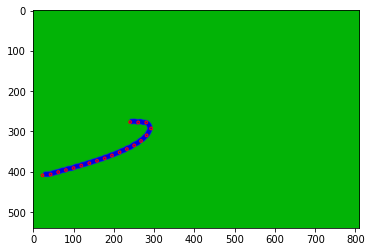

---- optimize translation ----
tensor([ 2.4017e+02,  2.6389e+02, -7.8657e-02,  2.2816e-02, -9.0598e-01,
        -2.1265e+00, -2.3897e+00, -2.5795e+00, -2.6499e+00, -2.7233e+00,
        -2.7542e+00, -2.7913e+00, -2.8164e+00, -2.8284e+00, -2.8534e+00,
        -2.8497e+00, -2.8736e+00, -2.8912e+00, -2.8186e+00, -3.0816e+00],
       device='cuda:0')
tensor(278.9190, device='cuda:0')
tensor([ 2.4016e+02,  2.6390e+02, -7.8657e-02,  2.2816e-02, -9.0598e-01,
        -2.1265e+00, -2.3897e+00, -2.5795e+00, -2.6499e+00, -2.7233e+00,
        -2.7542e+00, -2.7913e+00, -2.8164e+00, -2.8284e+00, -2.8534e+00,
        -2.8497e+00, -2.8736e+00, -2.8912e+00, -2.8186e+00, -3.0816e+00],
       device='cuda:0')
tensor(278.9168, device='cuda:0')
tensor([ 2.4017e+02,  2.6390e+02, -7.8657e-02,  2.2816e-02, -9.0598e-01,
        -2.1265e+00, -2.3897e+00, -2.5795e+00, -2.6499e+00, -2.7233e+00,
        -2.7542e+00, -2.7913e+00, -2.8164e+00, -2.8284e+00, -2.8534e+00,
        -2.8497e+00, -2.8736e+00, -2.8912e+00, -

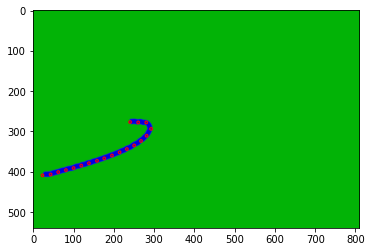

---- optimize translation ----
tensor([ 2.4023e+02,  2.6391e+02, -8.4486e-02,  3.0491e-02, -9.1871e-01,
        -2.1230e+00, -2.3906e+00, -2.5870e+00, -2.6464e+00, -2.7216e+00,
        -2.7596e+00, -2.7903e+00, -2.8140e+00, -2.8308e+00, -2.8541e+00,
        -2.8426e+00, -2.8799e+00, -2.8860e+00, -2.8232e+00, -3.0821e+00],
       device='cuda:0')
tensor(278.6348, device='cuda:0')
tensor([ 2.4021e+02,  2.6392e+02, -8.4486e-02,  3.0491e-02, -9.1871e-01,
        -2.1230e+00, -2.3906e+00, -2.5870e+00, -2.6464e+00, -2.7216e+00,
        -2.7596e+00, -2.7903e+00, -2.8140e+00, -2.8308e+00, -2.8541e+00,
        -2.8426e+00, -2.8799e+00, -2.8860e+00, -2.8232e+00, -3.0821e+00],
       device='cuda:0')
tensor(278.6325, device='cuda:0')
tensor([ 2.4022e+02,  2.6392e+02, -8.4486e-02,  3.0491e-02, -9.1871e-01,
        -2.1230e+00, -2.3906e+00, -2.5870e+00, -2.6464e+00, -2.7216e+00,
        -2.7596e+00, -2.7903e+00, -2.8140e+00, -2.8308e+00, -2.8541e+00,
        -2.8426e+00, -2.8799e+00, -2.8860e+00, -

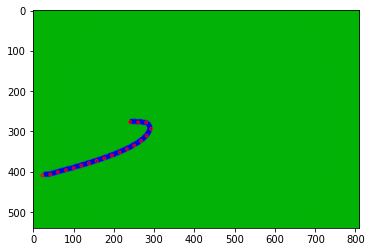

---- optimize translation ----
tensor([ 2.4023e+02,  2.6392e+02, -8.4922e-02,  3.1522e-02, -9.2260e-01,
        -2.1202e+00, -2.3957e+00, -2.5807e+00, -2.6570e+00, -2.7208e+00,
        -2.7508e+00, -2.8005e+00, -2.8045e+00, -2.8375e+00, -2.8492e+00,
        -2.8452e+00, -2.8806e+00, -2.8862e+00, -2.8207e+00, -3.0840e+00],
       device='cuda:0')
tensor(280.7786, device='cuda:0')
tensor([ 2.3948e+02,  2.6402e+02, -8.4922e-02,  3.1522e-02, -9.2260e-01,
        -2.1202e+00, -2.3957e+00, -2.5807e+00, -2.6570e+00, -2.7208e+00,
        -2.7508e+00, -2.8005e+00, -2.8045e+00, -2.8375e+00, -2.8492e+00,
        -2.8452e+00, -2.8806e+00, -2.8862e+00, -2.8207e+00, -3.0840e+00],
       device='cuda:0')
tensor(278.6727, device='cuda:0')
tensor([ 2.3951e+02,  2.6399e+02, -8.4922e-02,  3.1522e-02, -9.2260e-01,
        -2.1202e+00, -2.3957e+00, -2.5807e+00, -2.6570e+00, -2.7208e+00,
        -2.7508e+00, -2.8005e+00, -2.8045e+00, -2.8375e+00, -2.8492e+00,
        -2.8452e+00, -2.8806e+00, -2.8862e+00, -

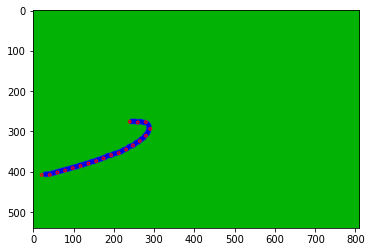

---- optimize translation ----
tensor([ 2.3967e+02,  2.6402e+02, -9.3482e-02,  4.8831e-02, -9.9288e-01,
        -2.1480e+00, -2.4043e+00, -2.5680e+00, -2.6545e+00, -2.6518e+00,
        -2.8629e+00, -2.7631e+00, -2.7855e+00, -2.8377e+00, -2.8435e+00,
        -2.8609e+00, -2.8643e+00, -2.8961e+00, -2.8103e+00, -3.1477e+00],
       device='cuda:0')
tensor(279.0300, device='cuda:0')
tensor([ 2.3908e+02,  2.6410e+02, -9.3482e-02,  4.8831e-02, -9.9288e-01,
        -2.1480e+00, -2.4043e+00, -2.5680e+00, -2.6545e+00, -2.6518e+00,
        -2.8629e+00, -2.7631e+00, -2.7855e+00, -2.8377e+00, -2.8435e+00,
        -2.8609e+00, -2.8643e+00, -2.8961e+00, -2.8103e+00, -3.1477e+00],
       device='cuda:0')
tensor(278.8235, device='cuda:0')
tensor([ 2.3912e+02,  2.6406e+02, -9.3482e-02,  4.8831e-02, -9.9288e-01,
        -2.1480e+00, -2.4043e+00, -2.5680e+00, -2.6545e+00, -2.6518e+00,
        -2.8629e+00, -2.7631e+00, -2.7855e+00, -2.8377e+00, -2.8435e+00,
        -2.8609e+00, -2.8643e+00, -2.8961e+00, -

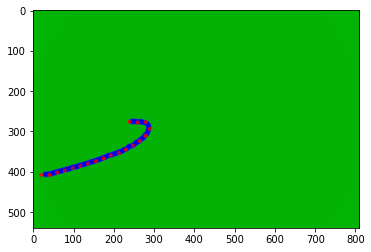

---- optimize translation ----
tensor([ 2.3910e+02,  2.6405e+02, -8.9605e-02,  4.0606e-02, -9.9292e-01,
        -2.1682e+00, -2.3895e+00, -2.5586e+00, -2.6538e+00, -2.6559e+00,
        -2.8633e+00, -2.7709e+00, -2.7711e+00, -2.8436e+00, -2.8481e+00,
        -2.8554e+00, -2.8663e+00, -2.8933e+00, -2.8077e+00, -3.1753e+00],
       device='cuda:0')
tensor(278.0864, device='cuda:0')
tensor([ 2.3903e+02,  2.6406e+02, -8.9605e-02,  4.0606e-02, -9.9292e-01,
        -2.1682e+00, -2.3895e+00, -2.5586e+00, -2.6538e+00, -2.6559e+00,
        -2.8633e+00, -2.7709e+00, -2.7711e+00, -2.8436e+00, -2.8481e+00,
        -2.8554e+00, -2.8663e+00, -2.8933e+00, -2.8077e+00, -3.1753e+00],
       device='cuda:0')
tensor(278.0800, device='cuda:0')
tensor([ 2.3905e+02,  2.6405e+02, -8.9605e-02,  4.0606e-02, -9.9292e-01,
        -2.1682e+00, -2.3895e+00, -2.5586e+00, -2.6538e+00, -2.6559e+00,
        -2.8633e+00, -2.7709e+00, -2.7711e+00, -2.8436e+00, -2.8481e+00,
        -2.8554e+00, -2.8663e+00, -2.8933e+00, -

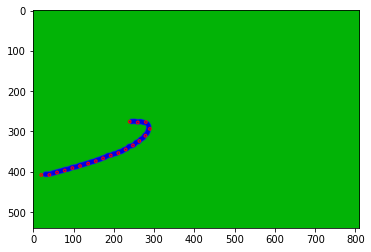

---- optimize translation ----
tensor([ 2.3913e+02,  2.6406e+02, -9.2589e-02,  4.5194e-02, -1.0083e+00,
        -2.1636e+00, -2.3945e+00, -2.5583e+00, -2.6525e+00, -2.6592e+00,
        -2.8618e+00, -2.7721e+00, -2.7731e+00, -2.8440e+00, -2.8455e+00,
        -2.8580e+00, -2.8623e+00, -2.8974e+00, -2.8074e+00, -3.1813e+00],
       device='cuda:0')
tensor(277.4015, device='cuda:0')
tensor([ 2.3910e+02,  2.6406e+02, -9.2589e-02,  4.5194e-02, -1.0083e+00,
        -2.1636e+00, -2.3945e+00, -2.5583e+00, -2.6525e+00, -2.6592e+00,
        -2.8618e+00, -2.7721e+00, -2.7731e+00, -2.8440e+00, -2.8455e+00,
        -2.8580e+00, -2.8623e+00, -2.8974e+00, -2.8074e+00, -3.1813e+00],
       device='cuda:0')
tensor(277.4027, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3913e+02,  2.6406e+02, -9.2589e-02,  4.5194e-02, -1.0083e+00,
        -2.1636e+00, -2.3945e+00, -2.5583e+00, -2.6525e+00, -2.6592e+00,
        -2.8618e+00, -2.7721e+00, -2.7731e+00, -2.8440e+00, -2.8455e+00,
        -2.8580e+00,

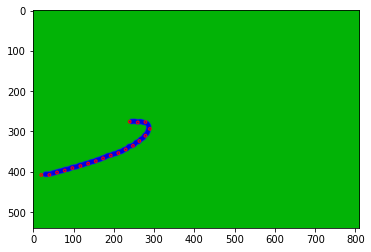

---- optimize translation ----
tensor([ 2.3910e+02,  2.6407e+02, -9.3923e-02,  4.7753e-02, -1.0078e+00,
        -2.1605e+00, -2.3975e+00, -2.5550e+00, -2.6533e+00, -2.6602e+00,
        -2.8583e+00, -2.7773e+00, -2.7713e+00, -2.8442e+00, -2.8388e+00,
        -2.8739e+00, -2.8470e+00, -2.9026e+00, -2.8060e+00, -3.1833e+00],
       device='cuda:0')
tensor(277.3861, device='cuda:0')
tensor([ 2.3906e+02,  2.6408e+02, -9.3923e-02,  4.7753e-02, -1.0078e+00,
        -2.1605e+00, -2.3975e+00, -2.5550e+00, -2.6533e+00, -2.6602e+00,
        -2.8583e+00, -2.7773e+00, -2.7713e+00, -2.8442e+00, -2.8388e+00,
        -2.8739e+00, -2.8470e+00, -2.9026e+00, -2.8060e+00, -3.1833e+00],
       device='cuda:0')
tensor(277.3848, device='cuda:0')
tensor([ 2.3908e+02,  2.6408e+02, -9.3923e-02,  4.7753e-02, -1.0078e+00,
        -2.1605e+00, -2.3975e+00, -2.5550e+00, -2.6533e+00, -2.6602e+00,
        -2.8583e+00, -2.7773e+00, -2.7713e+00, -2.8442e+00, -2.8388e+00,
        -2.8739e+00, -2.8470e+00, -2.9026e+00, -

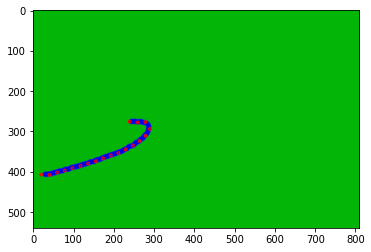

---- optimize translation ----
tensor([ 2.3910e+02,  2.6407e+02, -9.2111e-02,  4.6072e-02, -1.0087e+00,
        -2.1608e+00, -2.3943e+00, -2.5606e+00, -2.6455e+00, -2.6703e+00,
        -2.8452e+00, -2.7931e+00, -2.7711e+00, -2.8444e+00, -2.8204e+00,
        -2.9045e+00, -2.8156e+00, -2.9222e+00, -2.7912e+00, -3.1923e+00],
       device='cuda:0')
tensor(277.9565, device='cuda:0')
tensor([ 2.3911e+02,  2.6406e+02, -9.2111e-02,  4.6072e-02, -1.0087e+00,
        -2.1608e+00, -2.3943e+00, -2.5606e+00, -2.6455e+00, -2.6703e+00,
        -2.8452e+00, -2.7931e+00, -2.7711e+00, -2.8444e+00, -2.8204e+00,
        -2.9045e+00, -2.8156e+00, -2.9222e+00, -2.7912e+00, -3.1923e+00],
       device='cuda:0')
tensor(277.9574, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3910e+02,  2.6407e+02, -9.2111e-02,  4.6072e-02, -1.0087e+00,
        -2.1608e+00, -2.3943e+00, -2.5606e+00, -2.6455e+00, -2.6703e+00,
        -2.8452e+00, -2.7931e+00, -2.7711e+00, -2.8444e+00, -2.8204e+00,
        -2.9045e+00,

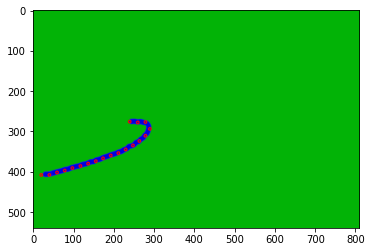

---- optimize translation ----
tensor([ 2.3910e+02,  2.6407e+02, -9.4625e-02,  4.9144e-02, -1.0089e+00,
        -2.1599e+00, -2.3939e+00, -2.5624e+00, -2.6463e+00, -2.6662e+00,
        -2.8501e+00, -2.7837e+00, -2.7829e+00, -2.8344e+00, -2.8273e+00,
        -2.9004e+00, -2.8233e+00, -2.9094e+00, -2.8049e+00, -3.1836e+00],
       device='cuda:0')
tensor(277.3067, device='cuda:0')
tensor([ 2.3913e+02,  2.6407e+02, -9.4625e-02,  4.9144e-02, -1.0089e+00,
        -2.1599e+00, -2.3939e+00, -2.5624e+00, -2.6463e+00, -2.6662e+00,
        -2.8501e+00, -2.7837e+00, -2.7829e+00, -2.8344e+00, -2.8273e+00,
        -2.9004e+00, -2.8233e+00, -2.9094e+00, -2.8049e+00, -3.1836e+00],
       device='cuda:0')
tensor(277.3099, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3910e+02,  2.6407e+02, -9.4625e-02,  4.9144e-02, -1.0089e+00,
        -2.1599e+00, -2.3939e+00, -2.5624e+00, -2.6463e+00, -2.6662e+00,
        -2.8501e+00, -2.7837e+00, -2.7829e+00, -2.8344e+00, -2.8273e+00,
        -2.9004e+00,

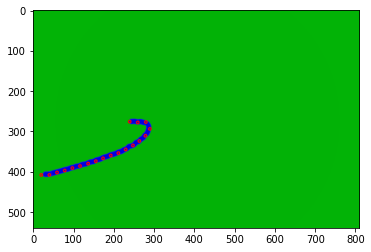

---- optimize translation ----
tensor([ 2.3912e+02,  2.6407e+02, -9.4758e-02,  4.9541e-02, -1.0107e+00,
        -2.1588e+00, -2.3976e+00, -2.5578e+00, -2.6466e+00, -2.6723e+00,
        -2.8432e+00, -2.7894e+00, -2.7805e+00, -2.8337e+00, -2.8363e+00,
        -2.8832e+00, -2.8379e+00, -2.9020e+00, -2.8095e+00, -3.1790e+00],
       device='cuda:0')
tensor(277.8826, device='cuda:0')
tensor([ 2.3914e+02,  2.6407e+02, -9.4758e-02,  4.9541e-02, -1.0107e+00,
        -2.1588e+00, -2.3976e+00, -2.5578e+00, -2.6466e+00, -2.6723e+00,
        -2.8432e+00, -2.7894e+00, -2.7805e+00, -2.8337e+00, -2.8363e+00,
        -2.8832e+00, -2.8379e+00, -2.9020e+00, -2.8095e+00, -3.1790e+00],
       device='cuda:0')
tensor(277.8860, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3912e+02,  2.6407e+02, -9.4758e-02,  4.9541e-02, -1.0107e+00,
        -2.1588e+00, -2.3976e+00, -2.5578e+00, -2.6466e+00, -2.6723e+00,
        -2.8432e+00, -2.7894e+00, -2.7805e+00, -2.8337e+00, -2.8363e+00,
        -2.8832e+00,

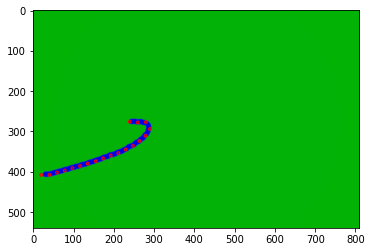

---- optimize translation ----
tensor([ 2.3913e+02,  2.6407e+02, -9.4683e-02,  4.9511e-02, -1.0122e+00,
        -2.1589e+00, -2.3971e+00, -2.5561e+00, -2.6516e+00, -2.6812e+00,
        -2.8263e+00, -2.7920e+00, -2.7897e+00, -2.8244e+00, -2.8445e+00,
        -2.8732e+00, -2.8536e+00, -2.8871e+00, -2.8140e+00, -3.1822e+00],
       device='cuda:0')
tensor(277.8547, device='cuda:0')
tensor([ 2.3913e+02,  2.6407e+02, -9.4683e-02,  4.9511e-02, -1.0122e+00,
        -2.1589e+00, -2.3971e+00, -2.5561e+00, -2.6516e+00, -2.6812e+00,
        -2.8263e+00, -2.7920e+00, -2.7897e+00, -2.8244e+00, -2.8445e+00,
        -2.8732e+00, -2.8536e+00, -2.8871e+00, -2.8140e+00, -3.1822e+00],
       device='cuda:0')
tensor(277.8548, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3913e+02,  2.6407e+02, -9.4683e-02,  4.9511e-02, -1.0122e+00,
        -2.1589e+00, -2.3971e+00, -2.5561e+00, -2.6516e+00, -2.6812e+00,
        -2.8263e+00, -2.7920e+00, -2.7897e+00, -2.8244e+00, -2.8445e+00,
        -2.8732e+00,

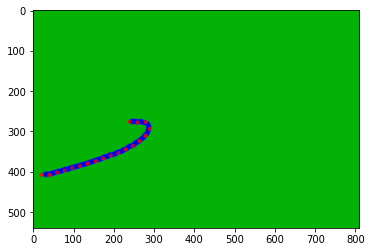

---- optimize translation ----
tensor([ 2.3913e+02,  2.6407e+02, -9.4746e-02,  4.9584e-02, -1.0117e+00,
        -2.1587e+00, -2.3974e+00, -2.5549e+00, -2.6586e+00, -2.6724e+00,
        -2.8260e+00, -2.7965e+00, -2.7856e+00, -2.8321e+00, -2.8351e+00,
        -2.8804e+00, -2.8450e+00, -2.8967e+00, -2.8087e+00, -3.1834e+00],
       device='cuda:0')
tensor(277.4525, device='cuda:0')
tensor([ 2.3912e+02,  2.6407e+02, -9.4746e-02,  4.9584e-02, -1.0117e+00,
        -2.1587e+00, -2.3974e+00, -2.5549e+00, -2.6586e+00, -2.6724e+00,
        -2.8260e+00, -2.7965e+00, -2.7856e+00, -2.8321e+00, -2.8351e+00,
        -2.8804e+00, -2.8450e+00, -2.8967e+00, -2.8087e+00, -3.1834e+00],
       device='cuda:0')
tensor(277.4520, device='cuda:0')
tensor([ 2.3912e+02,  2.6407e+02, -9.4746e-02,  4.9584e-02, -1.0117e+00,
        -2.1587e+00, -2.3974e+00, -2.5549e+00, -2.6586e+00, -2.6724e+00,
        -2.8260e+00, -2.7965e+00, -2.7856e+00, -2.8321e+00, -2.8351e+00,
        -2.8804e+00, -2.8450e+00, -2.8967e+00, -

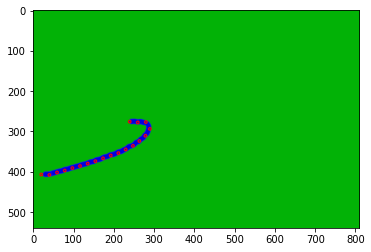

---- optimize translation ----
tensor([ 2.3913e+02,  2.6407e+02, -9.4839e-02,  4.9873e-02, -1.0128e+00,
        -2.1579e+00, -2.4004e+00, -2.5537e+00, -2.6571e+00, -2.6738e+00,
        -2.8316e+00, -2.7837e+00, -2.7995e+00, -2.8220e+00, -2.8439e+00,
        -2.8715e+00, -2.8530e+00, -2.8867e+00, -2.8125e+00, -3.1874e+00],
       device='cuda:0')
tensor(278.1915, device='cuda:0')
tensor([ 2.3912e+02,  2.6408e+02, -9.4839e-02,  4.9873e-02, -1.0128e+00,
        -2.1579e+00, -2.4004e+00, -2.5537e+00, -2.6571e+00, -2.6738e+00,
        -2.8316e+00, -2.7837e+00, -2.7995e+00, -2.8220e+00, -2.8439e+00,
        -2.8715e+00, -2.8530e+00, -2.8867e+00, -2.8125e+00, -3.1874e+00],
       device='cuda:0')
tensor(278.1910, device='cuda:0')
tensor([ 2.3913e+02,  2.6408e+02, -9.4839e-02,  4.9873e-02, -1.0128e+00,
        -2.1579e+00, -2.4004e+00, -2.5537e+00, -2.6571e+00, -2.6738e+00,
        -2.8316e+00, -2.7837e+00, -2.7995e+00, -2.8220e+00, -2.8439e+00,
        -2.8715e+00, -2.8530e+00, -2.8867e+00, -

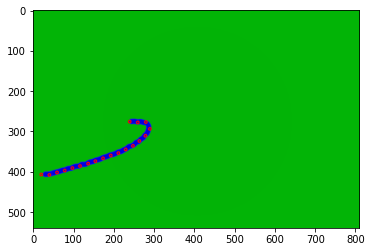

---- optimize translation ----
tensor([ 2.3913e+02,  2.6407e+02, -9.2178e-02,  4.6429e-02, -1.0120e+00,
        -2.1600e+00, -2.3971e+00, -2.5571e+00, -2.6574e+00, -2.6724e+00,
        -2.8282e+00, -2.7912e+00, -2.8029e+00, -2.8015e+00, -2.8574e+00,
        -2.8875e+00, -2.8257e+00, -2.9045e+00, -2.8044e+00, -3.1886e+00],
       device='cuda:0')
tensor(277.7239, device='cuda:0')
tensor([ 2.3914e+02,  2.6406e+02, -9.2178e-02,  4.6429e-02, -1.0120e+00,
        -2.1600e+00, -2.3971e+00, -2.5571e+00, -2.6574e+00, -2.6724e+00,
        -2.8282e+00, -2.7912e+00, -2.8029e+00, -2.8015e+00, -2.8574e+00,
        -2.8875e+00, -2.8257e+00, -2.9045e+00, -2.8044e+00, -3.1886e+00],
       device='cuda:0')
tensor(277.7285, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3913e+02,  2.6407e+02, -9.2178e-02,  4.6429e-02, -1.0120e+00,
        -2.1600e+00, -2.3971e+00, -2.5571e+00, -2.6574e+00, -2.6724e+00,
        -2.8282e+00, -2.7912e+00, -2.8029e+00, -2.8015e+00, -2.8574e+00,
        -2.8875e+00,

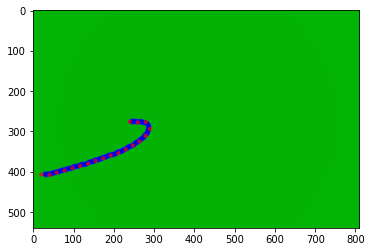

---- optimize translation ----
tensor([ 2.3918e+02,  2.6406e+02, -9.1648e-02,  4.5874e-02, -1.0170e+00,
        -2.1611e+00, -2.3965e+00, -2.5625e+00, -2.6522e+00, -2.6860e+00,
        -2.8125e+00, -2.7949e+00, -2.8139e+00, -2.7812e+00, -2.8783e+00,
        -2.8739e+00, -2.8334e+00, -2.8987e+00, -2.8054e+00, -3.1927e+00],
       device='cuda:0')
tensor(277.8318, device='cuda:0')
tensor([ 2.3917e+02,  2.6406e+02, -9.1648e-02,  4.5874e-02, -1.0170e+00,
        -2.1611e+00, -2.3965e+00, -2.5625e+00, -2.6522e+00, -2.6860e+00,
        -2.8125e+00, -2.7949e+00, -2.8139e+00, -2.7812e+00, -2.8783e+00,
        -2.8739e+00, -2.8334e+00, -2.8987e+00, -2.8054e+00, -3.1927e+00],
       device='cuda:0')
tensor(277.8320, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3918e+02,  2.6406e+02, -9.1648e-02,  4.5874e-02, -1.0170e+00,
        -2.1611e+00, -2.3965e+00, -2.5625e+00, -2.6522e+00, -2.6860e+00,
        -2.8125e+00, -2.7949e+00, -2.8139e+00, -2.7812e+00, -2.8783e+00,
        -2.8739e+00,

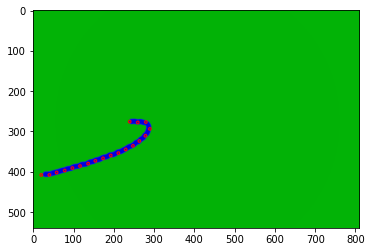

---- optimize translation ----
tensor([ 2.3915e+02,  2.6407e+02, -9.4978e-02,  5.0380e-02, -1.0153e+00,
        -2.1564e+00, -2.4037e+00, -2.5515e+00, -2.6676e+00, -2.6778e+00,
        -2.8075e+00, -2.8051e+00, -2.8003e+00, -2.7946e+00, -2.8672e+00,
        -2.8775e+00, -2.8354e+00, -2.8943e+00, -2.8118e+00, -3.1832e+00],
       device='cuda:0')
tensor(276.6848, device='cuda:0')
tensor([ 2.3913e+02,  2.6408e+02, -9.4978e-02,  5.0380e-02, -1.0153e+00,
        -2.1564e+00, -2.4037e+00, -2.5515e+00, -2.6676e+00, -2.6778e+00,
        -2.8075e+00, -2.8051e+00, -2.8003e+00, -2.7946e+00, -2.8672e+00,
        -2.8775e+00, -2.8354e+00, -2.8943e+00, -2.8118e+00, -3.1832e+00],
       device='cuda:0')
tensor(276.6774, device='cuda:0')
tensor([ 2.3913e+02,  2.6407e+02, -9.4978e-02,  5.0380e-02, -1.0153e+00,
        -2.1564e+00, -2.4037e+00, -2.5515e+00, -2.6676e+00, -2.6778e+00,
        -2.8075e+00, -2.8051e+00, -2.8003e+00, -2.7946e+00, -2.8672e+00,
        -2.8775e+00, -2.8354e+00, -2.8943e+00, -

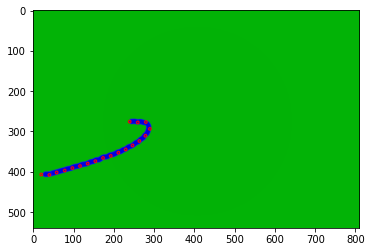

---- optimize translation ----
tensor([ 2.3913e+02,  2.6407e+02, -9.4863e-02,  4.9847e-02, -1.0124e+00,
        -2.1581e+00, -2.4037e+00, -2.5634e+00, -2.6486e+00, -2.7055e+00,
        -2.7645e+00, -2.8497e+00, -2.7678e+00, -2.8065e+00, -2.8704e+00,
        -2.8683e+00, -2.8352e+00, -2.9008e+00, -2.8054e+00, -3.1902e+00],
       device='cuda:0')
tensor(276.5356, device='cuda:0')
tensor([ 2.3916e+02,  2.6407e+02, -9.4863e-02,  4.9847e-02, -1.0124e+00,
        -2.1581e+00, -2.4037e+00, -2.5634e+00, -2.6486e+00, -2.7055e+00,
        -2.7645e+00, -2.8497e+00, -2.7678e+00, -2.8065e+00, -2.8704e+00,
        -2.8683e+00, -2.8352e+00, -2.9008e+00, -2.8054e+00, -3.1902e+00],
       device='cuda:0')
tensor(276.5447, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3913e+02,  2.6407e+02, -9.4863e-02,  4.9847e-02, -1.0124e+00,
        -2.1581e+00, -2.4037e+00, -2.5634e+00, -2.6486e+00, -2.7055e+00,
        -2.7645e+00, -2.8497e+00, -2.7678e+00, -2.8065e+00, -2.8704e+00,
        -2.8683e+00,

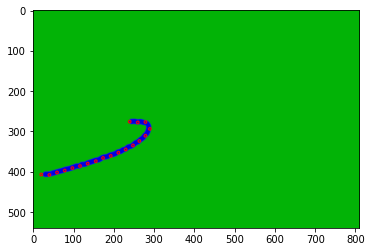

---- optimize translation ----
tensor([ 2.3911e+02,  2.6408e+02, -9.5309e-02,  5.0518e-02, -1.0110e+00,
        -2.1626e+00, -2.4000e+00, -2.5588e+00, -2.6589e+00, -2.7082e+00,
        -2.7419e+00, -2.8738e+00, -2.7413e+00, -2.8502e+00, -2.8247e+00,
        -2.8891e+00, -2.8312e+00, -2.9047e+00, -2.7972e+00, -3.1979e+00],
       device='cuda:0')
tensor(276.9273, device='cuda:0')
tensor([ 2.3905e+02,  2.6409e+02, -9.5309e-02,  5.0518e-02, -1.0110e+00,
        -2.1626e+00, -2.4000e+00, -2.5588e+00, -2.6589e+00, -2.7082e+00,
        -2.7419e+00, -2.8738e+00, -2.7413e+00, -2.8502e+00, -2.8247e+00,
        -2.8891e+00, -2.8312e+00, -2.9047e+00, -2.7972e+00, -3.1979e+00],
       device='cuda:0')
tensor(276.9273, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3911e+02,  2.6408e+02, -9.5309e-02,  5.0518e-02, -1.0110e+00,
        -2.1626e+00, -2.4000e+00, -2.5588e+00, -2.6589e+00, -2.7082e+00,
        -2.7419e+00, -2.8738e+00, -2.7413e+00, -2.8502e+00, -2.8247e+00,
        -2.8891e+00,

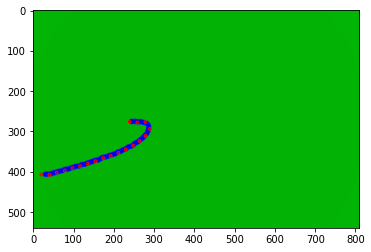

---- optimize translation ----
tensor([ 2.3905e+02,  2.6407e+02, -9.4144e-02,  4.7447e-02, -1.0059e+00,
        -2.1647e+00, -2.3987e+00, -2.5587e+00, -2.6615e+00, -2.7053e+00,
        -2.7434e+00, -2.8699e+00, -2.7483e+00, -2.8437e+00, -2.8292e+00,
        -2.8827e+00, -2.8412e+00, -2.9007e+00, -2.7944e+00, -3.1989e+00],
       device='cuda:0')
tensor(276.9942, device='cuda:0')
tensor([ 2.3908e+02,  2.6407e+02, -9.4144e-02,  4.7447e-02, -1.0059e+00,
        -2.1647e+00, -2.3987e+00, -2.5587e+00, -2.6615e+00, -2.7053e+00,
        -2.7434e+00, -2.8699e+00, -2.7483e+00, -2.8437e+00, -2.8292e+00,
        -2.8827e+00, -2.8412e+00, -2.9007e+00, -2.7944e+00, -3.1989e+00],
       device='cuda:0')
tensor(276.9972, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3905e+02,  2.6407e+02, -9.4144e-02,  4.7447e-02, -1.0059e+00,
        -2.1647e+00, -2.3987e+00, -2.5587e+00, -2.6615e+00, -2.7053e+00,
        -2.7434e+00, -2.8699e+00, -2.7483e+00, -2.8437e+00, -2.8292e+00,
        -2.8827e+00,

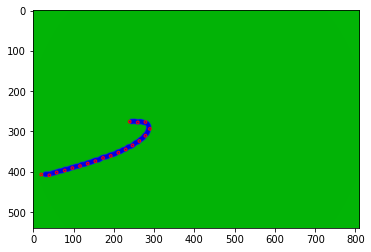

---- optimize translation ----
tensor([ 2.3910e+02,  2.6407e+02, -9.3769e-02,  4.7237e-02, -1.0105e+00,
        -2.1650e+00, -2.4000e+00, -2.5578e+00, -2.6637e+00, -2.7031e+00,
        -2.7546e+00, -2.8537e+00, -2.7568e+00, -2.8423e+00, -2.8330e+00,
        -2.8760e+00, -2.8398e+00, -2.9079e+00, -2.7901e+00, -3.2050e+00],
       device='cuda:0')
tensor(276.5653, device='cuda:0')
tensor([ 2.3916e+02,  2.6406e+02, -9.3769e-02,  4.7237e-02, -1.0105e+00,
        -2.1650e+00, -2.4000e+00, -2.5578e+00, -2.6637e+00, -2.7031e+00,
        -2.7546e+00, -2.8537e+00, -2.7568e+00, -2.8423e+00, -2.8330e+00,
        -2.8760e+00, -2.8398e+00, -2.9079e+00, -2.7901e+00, -3.2050e+00],
       device='cuda:0')
tensor(276.5921, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3910e+02,  2.6407e+02, -9.3769e-02,  4.7237e-02, -1.0105e+00,
        -2.1650e+00, -2.4000e+00, -2.5578e+00, -2.6637e+00, -2.7031e+00,
        -2.7546e+00, -2.8537e+00, -2.7568e+00, -2.8423e+00, -2.8330e+00,
        -2.8760e+00,

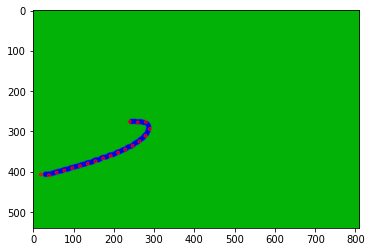

---- optimize translation ----
tensor([ 2.3923e+02,  2.6406e+02, -9.3803e-02,  4.8957e-02, -1.0305e+00,
        -2.1612e+00, -2.4056e+00, -2.5598e+00, -2.6675e+00, -2.7030e+00,
        -2.7613e+00, -2.8351e+00, -2.7767e+00, -2.8284e+00, -2.8383e+00,
        -2.8712e+00, -2.8500e+00, -2.8992e+00, -2.7967e+00, -3.2020e+00],
       device='cuda:0')
tensor(276.7346, device='cuda:0')
tensor([ 2.3926e+02,  2.6406e+02, -9.3803e-02,  4.8957e-02, -1.0305e+00,
        -2.1612e+00, -2.4056e+00, -2.5598e+00, -2.6675e+00, -2.7030e+00,
        -2.7613e+00, -2.8351e+00, -2.7767e+00, -2.8284e+00, -2.8383e+00,
        -2.8712e+00, -2.8500e+00, -2.8992e+00, -2.7967e+00, -3.2020e+00],
       device='cuda:0')
tensor(276.7389, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3923e+02,  2.6406e+02, -9.3803e-02,  4.8957e-02, -1.0305e+00,
        -2.1612e+00, -2.4056e+00, -2.5598e+00, -2.6675e+00, -2.7030e+00,
        -2.7613e+00, -2.8351e+00, -2.7767e+00, -2.8284e+00, -2.8383e+00,
        -2.8712e+00,

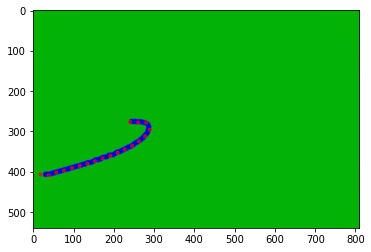

---- optimize translation ----
tensor([ 2.4010e+02,  2.6391e+02, -8.0504e-02,  2.5795e-02, -1.1029e+00,
        -2.1826e+00, -2.4211e+00, -2.5615e+00, -2.6726e+00, -2.7139e+00,
        -2.7536e+00, -2.8399e+00, -2.7731e+00, -2.8437e+00, -2.8228e+00,
        -2.8801e+00, -2.8476e+00, -2.8937e+00, -2.7993e+00, -3.2531e+00],
       device='cuda:0')
tensor(278.5079, device='cuda:0')
tensor([ 2.3997e+02,  2.6394e+02, -8.0504e-02,  2.5795e-02, -1.1029e+00,
        -2.1826e+00, -2.4211e+00, -2.5615e+00, -2.6726e+00, -2.7139e+00,
        -2.7536e+00, -2.8399e+00, -2.7731e+00, -2.8437e+00, -2.8228e+00,
        -2.8801e+00, -2.8476e+00, -2.8937e+00, -2.7993e+00, -3.2531e+00],
       device='cuda:0')
tensor(278.5200, device='cuda:0')
---- optimize rotation ----
tensor([ 2.4010e+02,  2.6391e+02, -8.0504e-02,  2.5795e-02, -1.1029e+00,
        -2.1826e+00, -2.4211e+00, -2.5615e+00, -2.6726e+00, -2.7139e+00,
        -2.7536e+00, -2.8399e+00, -2.7731e+00, -2.8437e+00, -2.8228e+00,
        -2.8801e+00,

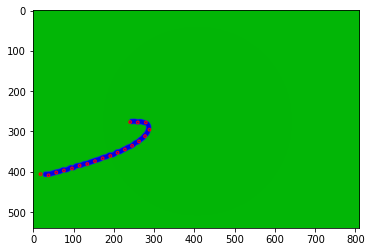

---- optimize translation ----
tensor([ 2.4007e+02,  2.6393e+02, -8.3722e-02,  2.7981e-02, -1.1055e+00,
        -2.1859e+00, -2.4158e+00, -2.5725e+00, -2.6624e+00, -2.7127e+00,
        -2.7623e+00, -2.8240e+00, -2.8026e+00, -2.7931e+00, -2.8989e+00,
        -2.8158e+00, -2.8566e+00, -2.9079e+00, -2.7870e+00, -3.2784e+00],
       device='cuda:0')
tensor(277.5226, device='cuda:0')
tensor([ 2.4004e+02,  2.6394e+02, -8.3722e-02,  2.7981e-02, -1.1055e+00,
        -2.1859e+00, -2.4158e+00, -2.5725e+00, -2.6624e+00, -2.7127e+00,
        -2.7623e+00, -2.8240e+00, -2.8026e+00, -2.7931e+00, -2.8989e+00,
        -2.8158e+00, -2.8566e+00, -2.9079e+00, -2.7870e+00, -3.2784e+00],
       device='cuda:0')
tensor(277.5126, device='cuda:0')
tensor([ 2.4004e+02,  2.6394e+02, -8.3722e-02,  2.7981e-02, -1.1055e+00,
        -2.1859e+00, -2.4158e+00, -2.5725e+00, -2.6624e+00, -2.7127e+00,
        -2.7623e+00, -2.8240e+00, -2.8026e+00, -2.7931e+00, -2.8989e+00,
        -2.8158e+00, -2.8566e+00, -2.9079e+00, -

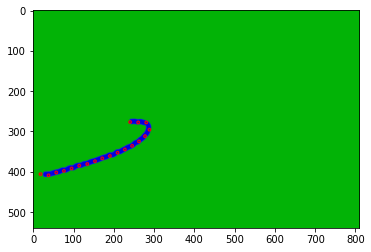

---- optimize translation ----
tensor([ 2.4009e+02,  2.6393e+02, -8.3392e-02,  2.4884e-02, -1.1142e+00,
        -2.1892e+00, -2.4202e+00, -2.5697e+00, -2.6619e+00, -2.7182e+00,
        -2.7572e+00, -2.8288e+00, -2.7958e+00, -2.8031e+00, -2.8987e+00,
        -2.8137e+00, -2.8494e+00, -2.9081e+00, -2.7871e+00, -3.3048e+00],
       device='cuda:0')
tensor(278.1354, device='cuda:0')
tensor([ 2.4008e+02,  2.6393e+02, -8.3392e-02,  2.4884e-02, -1.1142e+00,
        -2.1892e+00, -2.4202e+00, -2.5697e+00, -2.6619e+00, -2.7182e+00,
        -2.7572e+00, -2.8288e+00, -2.7958e+00, -2.8031e+00, -2.8987e+00,
        -2.8137e+00, -2.8494e+00, -2.9081e+00, -2.7871e+00, -3.3048e+00],
       device='cuda:0')
tensor(278.1339, device='cuda:0')
tensor([ 2.4008e+02,  2.6393e+02, -8.3392e-02,  2.4884e-02, -1.1142e+00,
        -2.1892e+00, -2.4202e+00, -2.5697e+00, -2.6619e+00, -2.7182e+00,
        -2.7572e+00, -2.8288e+00, -2.7958e+00, -2.8031e+00, -2.8987e+00,
        -2.8137e+00, -2.8494e+00, -2.9081e+00, -

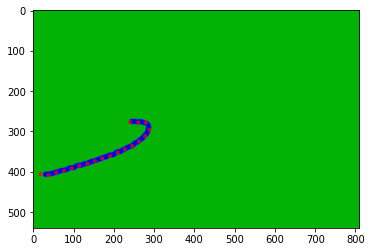

---- optimize translation ----
tensor([ 2.4007e+02,  2.6393e+02, -8.3532e-02,  2.5024e-02, -1.1144e+00,
        -2.1912e+00, -2.4199e+00, -2.5683e+00, -2.6603e+00, -2.7212e+00,
        -2.7501e+00, -2.8379e+00, -2.7861e+00, -2.8136e+00, -2.8907e+00,
        -2.8249e+00, -2.8326e+00, -2.9240e+00, -2.7821e+00, -3.2923e+00],
       device='cuda:0')
tensor(277.4518, device='cuda:0')
tensor([ 2.4008e+02,  2.6393e+02, -8.3532e-02,  2.5024e-02, -1.1144e+00,
        -2.1912e+00, -2.4199e+00, -2.5683e+00, -2.6603e+00, -2.7212e+00,
        -2.7501e+00, -2.8379e+00, -2.7861e+00, -2.8136e+00, -2.8907e+00,
        -2.8249e+00, -2.8326e+00, -2.9240e+00, -2.7821e+00, -3.2923e+00],
       device='cuda:0')
tensor(277.4518, device='cuda:0')
---- optimize rotation ----
tensor([ 2.4007e+02,  2.6393e+02, -8.3532e-02,  2.5024e-02, -1.1144e+00,
        -2.1912e+00, -2.4199e+00, -2.5683e+00, -2.6603e+00, -2.7212e+00,
        -2.7501e+00, -2.8379e+00, -2.7861e+00, -2.8136e+00, -2.8907e+00,
        -2.8249e+00,

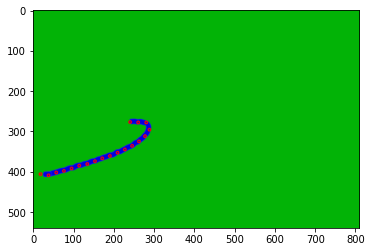

---- optimize translation ----
tensor([ 2.4008e+02,  2.6394e+02, -8.4356e-02,  2.7040e-02, -1.1170e+00,
        -2.1886e+00, -2.4253e+00, -2.5601e+00, -2.6637e+00, -2.7263e+00,
        -2.7365e+00, -2.8480e+00, -2.7871e+00, -2.8086e+00, -2.8991e+00,
        -2.8126e+00, -2.8459e+00, -2.9096e+00, -2.7941e+00, -3.2844e+00],
       device='cuda:0')
tensor(277.2144, device='cuda:0')
tensor([ 2.4005e+02,  2.6394e+02, -8.4356e-02,  2.7040e-02, -1.1170e+00,
        -2.1886e+00, -2.4253e+00, -2.5601e+00, -2.6637e+00, -2.7263e+00,
        -2.7365e+00, -2.8480e+00, -2.7871e+00, -2.8086e+00, -2.8991e+00,
        -2.8126e+00, -2.8459e+00, -2.9096e+00, -2.7941e+00, -3.2844e+00],
       device='cuda:0')
tensor(277.2137, device='cuda:0')
tensor([ 2.4006e+02,  2.6394e+02, -8.4356e-02,  2.7040e-02, -1.1170e+00,
        -2.1886e+00, -2.4253e+00, -2.5601e+00, -2.6637e+00, -2.7263e+00,
        -2.7365e+00, -2.8480e+00, -2.7871e+00, -2.8086e+00, -2.8991e+00,
        -2.8126e+00, -2.8459e+00, -2.9096e+00, -

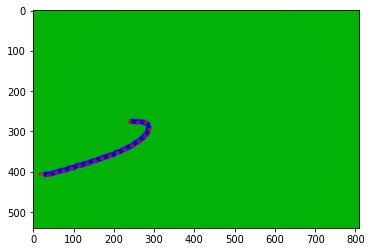

---- optimize translation ----
tensor([ 2.4008e+02,  2.6394e+02, -8.4882e-02,  2.8132e-02, -1.1170e+00,
        -2.1889e+00, -2.4234e+00, -2.5621e+00, -2.6596e+00, -2.7338e+00,
        -2.7346e+00, -2.8460e+00, -2.7923e+00, -2.7994e+00, -2.9026e+00,
        -2.8114e+00, -2.8483e+00, -2.9070e+00, -2.7962e+00, -3.2817e+00],
       device='cuda:0')
tensor(278.2618, device='cuda:0')
tensor([ 2.4006e+02,  2.6394e+02, -8.4882e-02,  2.8132e-02, -1.1170e+00,
        -2.1889e+00, -2.4234e+00, -2.5621e+00, -2.6596e+00, -2.7338e+00,
        -2.7346e+00, -2.8460e+00, -2.7923e+00, -2.7994e+00, -2.9026e+00,
        -2.8114e+00, -2.8483e+00, -2.9070e+00, -2.7962e+00, -3.2817e+00],
       device='cuda:0')
tensor(278.2619, device='cuda:0')
---- optimize rotation ----
tensor([ 2.4008e+02,  2.6394e+02, -8.4882e-02,  2.8132e-02, -1.1170e+00,
        -2.1889e+00, -2.4234e+00, -2.5621e+00, -2.6596e+00, -2.7338e+00,
        -2.7346e+00, -2.8460e+00, -2.7923e+00, -2.7994e+00, -2.9026e+00,
        -2.8114e+00,

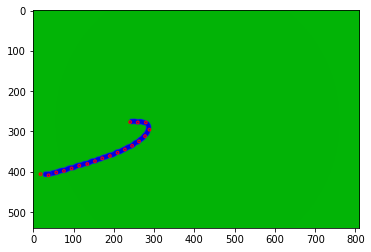

---- optimize translation ----
tensor([ 2.4006e+02,  2.6394e+02, -8.4968e-02,  2.8209e-02, -1.1146e+00,
        -2.1948e+00, -2.4155e+00, -2.5657e+00, -2.6596e+00, -2.7281e+00,
        -2.7375e+00, -2.8480e+00, -2.7896e+00, -2.8026e+00, -2.8991e+00,
        -2.8162e+00, -2.8416e+00, -2.9150e+00, -2.7897e+00, -3.2943e+00],
       device='cuda:0')
tensor(278.4859, device='cuda:0')
tensor([ 2.4009e+02,  2.6393e+02, -8.4968e-02,  2.8209e-02, -1.1146e+00,
        -2.1948e+00, -2.4155e+00, -2.5657e+00, -2.6596e+00, -2.7281e+00,
        -2.7375e+00, -2.8480e+00, -2.7896e+00, -2.8026e+00, -2.8991e+00,
        -2.8162e+00, -2.8416e+00, -2.9150e+00, -2.7897e+00, -3.2943e+00],
       device='cuda:0')
tensor(278.4930, device='cuda:0')
---- optimize rotation ----
tensor([ 2.4006e+02,  2.6394e+02, -8.4968e-02,  2.8209e-02, -1.1146e+00,
        -2.1948e+00, -2.4155e+00, -2.5657e+00, -2.6596e+00, -2.7281e+00,
        -2.7375e+00, -2.8480e+00, -2.7896e+00, -2.8026e+00, -2.8991e+00,
        -2.8162e+00,

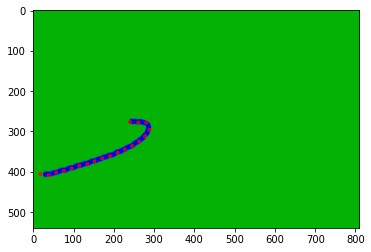

---- optimize translation ----
tensor([ 2.4010e+02,  2.6393e+02, -8.3053e-02,  2.3736e-02, -1.1211e+00,
        -2.1962e+00, -2.4181e+00, -2.5664e+00, -2.6614e+00, -2.7272e+00,
        -2.7420e+00, -2.8399e+00, -2.7928e+00, -2.8046e+00, -2.8933e+00,
        -2.8213e+00, -2.8483e+00, -2.9005e+00, -2.8029e+00, -3.2902e+00],
       device='cuda:0')
tensor(279.1190, device='cuda:0')
tensor([ 2.3997e+02,  2.6394e+02, -8.3053e-02,  2.3736e-02, -1.1211e+00,
        -2.1962e+00, -2.4181e+00, -2.5664e+00, -2.6614e+00, -2.7272e+00,
        -2.7420e+00, -2.8399e+00, -2.7928e+00, -2.8046e+00, -2.8933e+00,
        -2.8213e+00, -2.8483e+00, -2.9005e+00, -2.8029e+00, -3.2902e+00],
       device='cuda:0')
tensor(279.1327, device='cuda:0')
---- optimize rotation ----
tensor([ 2.4010e+02,  2.6393e+02, -8.3053e-02,  2.3736e-02, -1.1211e+00,
        -2.1962e+00, -2.4181e+00, -2.5664e+00, -2.6614e+00, -2.7272e+00,
        -2.7420e+00, -2.8399e+00, -2.7928e+00, -2.8046e+00, -2.8933e+00,
        -2.8213e+00,

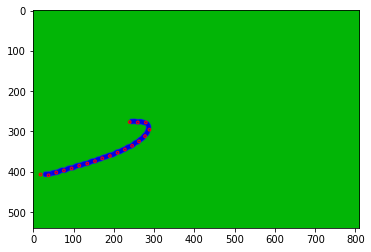

---- optimize translation ----
tensor([ 2.3983e+02,  2.6396e+02, -8.4788e-02,  2.7037e-02, -1.1022e+00,
        -2.1945e+00, -2.4120e+00, -2.5678e+00, -2.6625e+00, -2.7216e+00,
        -2.7439e+00, -2.8382e+00, -2.7942e+00, -2.8073e+00, -2.8869e+00,
        -2.8255e+00, -2.8500e+00, -2.8880e+00, -2.8205e+00, -3.2479e+00],
       device='cuda:0')
tensor(278.1249, device='cuda:0')
tensor([ 2.3954e+02,  2.6401e+02, -8.4788e-02,  2.7037e-02, -1.1022e+00,
        -2.1945e+00, -2.4120e+00, -2.5678e+00, -2.6625e+00, -2.7216e+00,
        -2.7439e+00, -2.8382e+00, -2.7942e+00, -2.8073e+00, -2.8869e+00,
        -2.8255e+00, -2.8500e+00, -2.8880e+00, -2.8205e+00, -3.2479e+00],
       device='cuda:0')
tensor(278.2582, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3983e+02,  2.6396e+02, -8.4788e-02,  2.7037e-02, -1.1022e+00,
        -2.1945e+00, -2.4120e+00, -2.5678e+00, -2.6625e+00, -2.7216e+00,
        -2.7439e+00, -2.8382e+00, -2.7942e+00, -2.8073e+00, -2.8869e+00,
        -2.8255e+00,

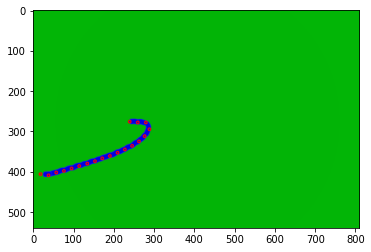

---- optimize translation ----
tensor([ 2.3943e+02,  2.6402e+02, -8.9719e-02,  2.8530e-02, -1.0879e+00,
        -2.1919e+00, -2.4096e+00, -2.5594e+00, -2.6679e+00, -2.7191e+00,
        -2.7456e+00, -2.8331e+00, -2.7958e+00, -2.8165e+00, -2.8748e+00,
        -2.8330e+00, -2.8450e+00, -2.8979e+00, -2.7992e+00, -3.2879e+00],
       device='cuda:0')
tensor(277.3378, device='cuda:0')
tensor([ 2.3932e+02,  2.6404e+02, -8.9719e-02,  2.8530e-02, -1.0879e+00,
        -2.1919e+00, -2.4096e+00, -2.5594e+00, -2.6679e+00, -2.7191e+00,
        -2.7456e+00, -2.8331e+00, -2.7958e+00, -2.8165e+00, -2.8748e+00,
        -2.8330e+00, -2.8450e+00, -2.8979e+00, -2.7992e+00, -3.2879e+00],
       device='cuda:0')
tensor(277.3170, device='cuda:0')
tensor([ 2.3930e+02,  2.6403e+02, -8.9719e-02,  2.8530e-02, -1.0879e+00,
        -2.1919e+00, -2.4096e+00, -2.5594e+00, -2.6679e+00, -2.7191e+00,
        -2.7456e+00, -2.8331e+00, -2.7958e+00, -2.8165e+00, -2.8748e+00,
        -2.8330e+00, -2.8450e+00, -2.8979e+00, -

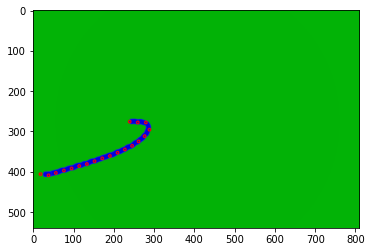

---- optimize translation ----
tensor([ 2.3946e+02,  2.6401e+02, -8.8732e-02,  2.6823e-02, -1.1046e+00,
        -2.1937e+00, -2.4169e+00, -2.5506e+00, -2.6726e+00, -2.7197e+00,
        -2.7479e+00, -2.8260e+00, -2.8090e+00, -2.8007e+00, -2.8913e+00,
        -2.8165e+00, -2.8598e+00, -2.8859e+00, -2.8059e+00, -3.3130e+00],
       device='cuda:0')
tensor(276.5502, device='cuda:0')
tensor([ 2.3942e+02,  2.6402e+02, -8.8732e-02,  2.6823e-02, -1.1046e+00,
        -2.1937e+00, -2.4169e+00, -2.5506e+00, -2.6726e+00, -2.7197e+00,
        -2.7479e+00, -2.8260e+00, -2.8090e+00, -2.8007e+00, -2.8913e+00,
        -2.8165e+00, -2.8598e+00, -2.8859e+00, -2.8059e+00, -3.3130e+00],
       device='cuda:0')
tensor(276.5416, device='cuda:0')
tensor([ 2.3944e+02,  2.6401e+02, -8.8732e-02,  2.6823e-02, -1.1046e+00,
        -2.1937e+00, -2.4169e+00, -2.5506e+00, -2.6726e+00, -2.7197e+00,
        -2.7479e+00, -2.8260e+00, -2.8090e+00, -2.8007e+00, -2.8913e+00,
        -2.8165e+00, -2.8598e+00, -2.8859e+00, -

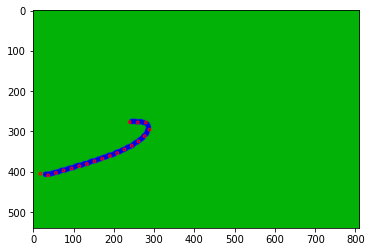

---- optimize translation ----
tensor([ 2.3965e+02,  2.6398e+02, -8.6344e-02,  2.2092e-02, -1.1265e+00,
        -2.1953e+00, -2.4235e+00, -2.5492e+00, -2.6807e+00, -2.7156e+00,
        -2.7562e+00, -2.8122e+00, -2.8208e+00, -2.7872e+00, -2.9038e+00,
        -2.8038e+00, -2.8784e+00, -2.8784e+00, -2.7963e+00, -3.3532e+00],
       device='cuda:0')
tensor(277.6781, device='cuda:0')
tensor([ 2.3960e+02,  2.6399e+02, -8.6344e-02,  2.2092e-02, -1.1265e+00,
        -2.1953e+00, -2.4235e+00, -2.5492e+00, -2.6807e+00, -2.7156e+00,
        -2.7562e+00, -2.8122e+00, -2.8208e+00, -2.7872e+00, -2.9038e+00,
        -2.8038e+00, -2.8784e+00, -2.8784e+00, -2.7963e+00, -3.3532e+00],
       device='cuda:0')
tensor(277.6588, device='cuda:0')
tensor([ 2.3960e+02,  2.6399e+02, -8.6344e-02,  2.2092e-02, -1.1265e+00,
        -2.1953e+00, -2.4235e+00, -2.5492e+00, -2.6807e+00, -2.7156e+00,
        -2.7562e+00, -2.8122e+00, -2.8208e+00, -2.7872e+00, -2.9038e+00,
        -2.8038e+00, -2.8784e+00, -2.8784e+00, -

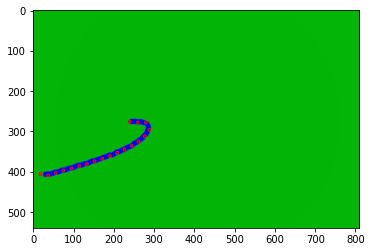

---- optimize translation ----
tensor([ 2.3947e+02,  2.6401e+02, -8.7776e-02,  2.4724e-02, -1.1144e+00,
        -2.1989e+00, -2.4144e+00, -2.5584e+00, -2.6741e+00, -2.7245e+00,
        -2.7494e+00, -2.8057e+00, -2.8241e+00, -2.7880e+00, -2.8995e+00,
        -2.8061e+00, -2.8740e+00, -2.8760e+00, -2.8088e+00, -3.3212e+00],
       device='cuda:0')
tensor(276.5308, device='cuda:0')
tensor([ 2.3954e+02,  2.6401e+02, -8.7776e-02,  2.4724e-02, -1.1144e+00,
        -2.1989e+00, -2.4144e+00, -2.5584e+00, -2.6741e+00, -2.7245e+00,
        -2.7494e+00, -2.8057e+00, -2.8241e+00, -2.7880e+00, -2.8995e+00,
        -2.8061e+00, -2.8740e+00, -2.8760e+00, -2.8088e+00, -3.3212e+00],
       device='cuda:0')
tensor(276.5668, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3947e+02,  2.6401e+02, -8.7776e-02,  2.4724e-02, -1.1144e+00,
        -2.1989e+00, -2.4144e+00, -2.5584e+00, -2.6741e+00, -2.7245e+00,
        -2.7494e+00, -2.8057e+00, -2.8241e+00, -2.7880e+00, -2.8995e+00,
        -2.8061e+00,

tensor([ 2.4064e+02,  2.6382e+02, -7.2682e-02, -1.4639e-02, -1.2251e+00,
        -2.2231e+00, -2.4459e+00, -2.5496e+00, -2.6909e+00, -2.7119e+00,
        -2.7712e+00, -2.7902e+00, -2.8377e+00, -2.7785e+00, -2.9128e+00,
        -2.7969e+00, -2.8792e+00, -2.8833e+00, -2.7791e+00, -3.5428e+00],
       device='cuda:0')
tensor(276.4197, device='cuda:0')
tensor([ 2.4064e+02,  2.6382e+02, -7.2670e-02, -1.4643e-02, -1.2252e+00,
        -2.2230e+00, -2.4460e+00, -2.5495e+00, -2.6909e+00, -2.7119e+00,
        -2.7713e+00, -2.7901e+00, -2.8377e+00, -2.7785e+00, -2.9128e+00,
        -2.7970e+00, -2.8791e+00, -2.8835e+00, -2.7787e+00, -3.5441e+00],
       device='cuda:0')
tensor(276.4196, device='cuda:0')
tensor([ 2.4064e+02,  2.6382e+02, -7.2638e-02, -1.4719e-02, -1.2254e+00,
        -2.2230e+00, -2.4460e+00, -2.5496e+00, -2.6909e+00, -2.7119e+00,
        -2.7713e+00, -2.7901e+00, -2.8377e+00, -2.7785e+00, -2.9127e+00,
        -2.7970e+00, -2.8790e+00, -2.8836e+00, -2.7784e+00, -3.5450e+00],
     

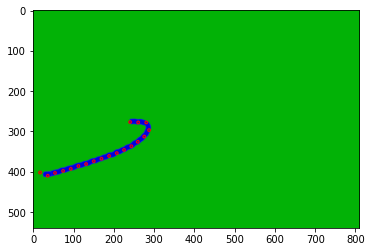

---- optimize translation ----
tensor([ 2.4064e+02,  2.6382e+02, -7.2670e-02, -1.4643e-02, -1.2252e+00,
        -2.2230e+00, -2.4460e+00, -2.5495e+00, -2.6909e+00, -2.7119e+00,
        -2.7713e+00, -2.7901e+00, -2.8377e+00, -2.7785e+00, -2.9128e+00,
        -2.7970e+00, -2.8791e+00, -2.8835e+00, -2.7787e+00, -3.5441e+00],
       device='cuda:0')
tensor(276.1749, device='cuda:0')
tensor([ 2.4067e+02,  2.6381e+02, -7.2670e-02, -1.4643e-02, -1.2252e+00,
        -2.2230e+00, -2.4460e+00, -2.5495e+00, -2.6909e+00, -2.7119e+00,
        -2.7713e+00, -2.7901e+00, -2.8377e+00, -2.7785e+00, -2.9128e+00,
        -2.7970e+00, -2.8791e+00, -2.8835e+00, -2.7787e+00, -3.5441e+00],
       device='cuda:0')
tensor(276.1865, device='cuda:0')
---- optimize rotation ----
tensor([ 2.4064e+02,  2.6382e+02, -7.2670e-02, -1.4643e-02, -1.2252e+00,
        -2.2230e+00, -2.4460e+00, -2.5495e+00, -2.6909e+00, -2.7119e+00,
        -2.7713e+00, -2.7901e+00, -2.8377e+00, -2.7785e+00, -2.9128e+00,
        -2.7970e+00,

tensor([ 2.4195e+02,  2.6361e+02, -4.9719e-02, -8.4001e-02, -1.3532e+00,
        -2.2491e+00, -2.4635e+00, -2.5576e+00, -2.7065e+00, -2.7065e+00,
        -2.7882e+00, -2.7785e+00, -2.8482e+00, -2.7814e+00, -2.9035e+00,
        -2.8168e+00, -2.8600e+00, -2.9012e+00, -2.7340e+00, -3.9344e+00],
       device='cuda:0')
tensor(276.0550, device='cuda:0')
tensor([ 2.4198e+02,  2.6361e+02, -4.9306e-02, -8.5563e-02, -1.3557e+00,
        -2.2496e+00, -2.4637e+00, -2.5580e+00, -2.7066e+00, -2.7066e+00,
        -2.7883e+00, -2.7787e+00, -2.8480e+00, -2.7818e+00, -2.9032e+00,
        -2.8170e+00, -2.8600e+00, -2.9013e+00, -2.7332e+00, -3.9451e+00],
       device='cuda:0')
tensor(276.0540, device='cuda:0')
tensor([ 2.4199e+02,  2.6360e+02, -4.9018e-02, -8.6532e-02, -1.3574e+00,
        -2.2497e+00, -2.4641e+00, -2.5581e+00, -2.7066e+00, -2.7065e+00,
        -2.7884e+00, -2.7787e+00, -2.8479e+00, -2.7820e+00, -2.9030e+00,
        -2.8172e+00, -2.8599e+00, -2.9014e+00, -2.7325e+00, -3.9532e+00],
     

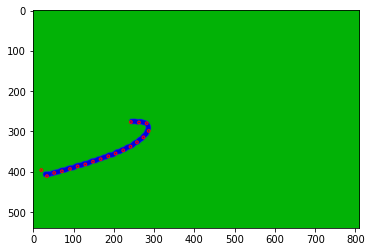

---- optimize translation ----
tensor([ 2.4206e+02,  2.6359e+02, -4.7087e-02, -9.2988e-02, -1.3648e+00,
        -2.2512e+00, -2.4660e+00, -2.5587e+00, -2.7075e+00, -2.7061e+00,
        -2.7895e+00, -2.7785e+00, -2.8478e+00, -2.7829e+00, -2.9023e+00,
        -2.8177e+00, -2.8597e+00, -2.9017e+00, -2.7300e+00, -3.9884e+00],
       device='cuda:0')
tensor(276.1920, device='cuda:0')
tensor([ 2.4201e+02,  2.6359e+02, -4.7087e-02, -9.2988e-02, -1.3648e+00,
        -2.2512e+00, -2.4660e+00, -2.5587e+00, -2.7075e+00, -2.7061e+00,
        -2.7895e+00, -2.7785e+00, -2.8478e+00, -2.7829e+00, -2.9023e+00,
        -2.8177e+00, -2.8597e+00, -2.9017e+00, -2.7300e+00, -3.9884e+00],
       device='cuda:0')
tensor(276.1936, device='cuda:0')
---- optimize rotation ----
tensor([ 2.4206e+02,  2.6359e+02, -4.7087e-02, -9.2988e-02, -1.3648e+00,
        -2.2512e+00, -2.4660e+00, -2.5587e+00, -2.7075e+00, -2.7061e+00,
        -2.7895e+00, -2.7785e+00, -2.8478e+00, -2.7829e+00, -2.9023e+00,
        -2.8177e+00,

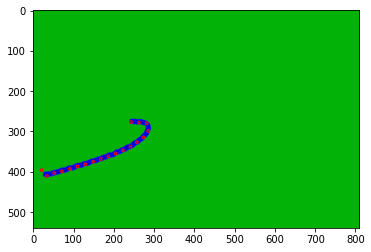

---- optimize translation ----
tensor([ 2.4205e+02,  2.6358e+02, -4.6047e-02, -9.5998e-02, -1.3670e+00,
        -2.2509e+00, -2.4693e+00, -2.5563e+00, -2.7085e+00, -2.7053e+00,
        -2.7896e+00, -2.7814e+00, -2.8423e+00, -2.7899e+00, -2.8920e+00,
        -2.8299e+00, -2.8513e+00, -2.9095e+00, -2.7231e+00, -4.0072e+00],
       device='cuda:0')
tensor(275.8028, device='cuda:0')
tensor([ 2.4203e+02,  2.6359e+02, -4.6047e-02, -9.5998e-02, -1.3670e+00,
        -2.2509e+00, -2.4693e+00, -2.5563e+00, -2.7085e+00, -2.7053e+00,
        -2.7896e+00, -2.7814e+00, -2.8423e+00, -2.7899e+00, -2.8920e+00,
        -2.8299e+00, -2.8513e+00, -2.9095e+00, -2.7231e+00, -4.0072e+00],
       device='cuda:0')
tensor(275.8034, device='cuda:0')
---- optimize rotation ----
tensor([ 2.4205e+02,  2.6358e+02, -4.6047e-02, -9.5998e-02, -1.3670e+00,
        -2.2509e+00, -2.4693e+00, -2.5563e+00, -2.7085e+00, -2.7053e+00,
        -2.7896e+00, -2.7814e+00, -2.8423e+00, -2.7899e+00, -2.8920e+00,
        -2.8299e+00,

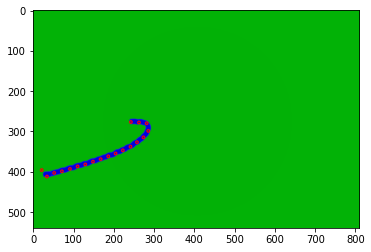

---- optimize translation ----
tensor([ 2.4204e+02,  2.6358e+02, -4.6181e-02, -9.5538e-02, -1.3664e+00,
        -2.2508e+00, -2.4693e+00, -2.5561e+00, -2.7086e+00, -2.7050e+00,
        -2.7902e+00, -2.7816e+00, -2.8431e+00, -2.7917e+00, -2.8857e+00,
        -2.8345e+00, -2.8457e+00, -2.9122e+00, -2.7236e+00, -4.0072e+00],
       device='cuda:0')
tensor(276.5244, device='cuda:0')
tensor([ 2.4203e+02,  2.6360e+02, -4.6181e-02, -9.5538e-02, -1.3664e+00,
        -2.2508e+00, -2.4693e+00, -2.5561e+00, -2.7086e+00, -2.7050e+00,
        -2.7902e+00, -2.7816e+00, -2.8431e+00, -2.7917e+00, -2.8857e+00,
        -2.8345e+00, -2.8457e+00, -2.9122e+00, -2.7236e+00, -4.0072e+00],
       device='cuda:0')
tensor(276.5253, device='cuda:0')
---- optimize rotation ----
tensor([ 2.4204e+02,  2.6358e+02, -4.6181e-02, -9.5538e-02, -1.3664e+00,
        -2.2508e+00, -2.4693e+00, -2.5561e+00, -2.7086e+00, -2.7050e+00,
        -2.7902e+00, -2.7816e+00, -2.8431e+00, -2.7917e+00, -2.8857e+00,
        -2.8345e+00,

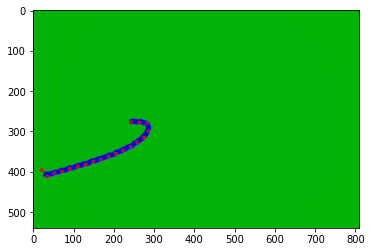

---- optimize translation ----
tensor([ 2.4204e+02,  2.6360e+02, -4.9011e-02, -9.2275e-02, -1.3672e+00,
        -2.2500e+00, -2.4685e+00, -2.5563e+00, -2.7086e+00, -2.7047e+00,
        -2.7912e+00, -2.7788e+00, -2.8478e+00, -2.7869e+00, -2.8890e+00,
        -2.8381e+00, -2.8347e+00, -2.9255e+00, -2.7140e+00, -4.0004e+00],
       device='cuda:0')
tensor(276.6682, device='cuda:0')
tensor([ 2.4205e+02,  2.6359e+02, -4.9011e-02, -9.2275e-02, -1.3672e+00,
        -2.2500e+00, -2.4685e+00, -2.5563e+00, -2.7086e+00, -2.7047e+00,
        -2.7912e+00, -2.7788e+00, -2.8478e+00, -2.7869e+00, -2.8890e+00,
        -2.8381e+00, -2.8347e+00, -2.9255e+00, -2.7140e+00, -4.0004e+00],
       device='cuda:0')
tensor(276.6702, device='cuda:0')
---- optimize rotation ----
tensor([ 2.4204e+02,  2.6360e+02, -4.9011e-02, -9.2275e-02, -1.3672e+00,
        -2.2500e+00, -2.4685e+00, -2.5563e+00, -2.7086e+00, -2.7047e+00,
        -2.7912e+00, -2.7788e+00, -2.8478e+00, -2.7869e+00, -2.8890e+00,
        -2.8381e+00,

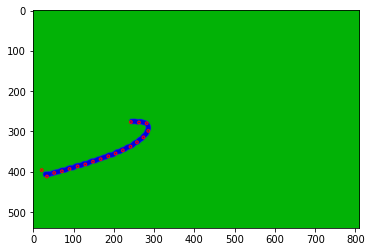

---- optimize translation ----
tensor([ 2.4205e+02,  2.6358e+02, -4.6125e-02, -9.5808e-02, -1.3668e+00,
        -2.2509e+00, -2.4692e+00, -2.5566e+00, -2.7074e+00, -2.7086e+00,
        -2.7885e+00, -2.7816e+00, -2.8438e+00, -2.7885e+00, -2.8898e+00,
        -2.8332e+00, -2.8350e+00, -2.9297e+00, -2.7108e+00, -4.0047e+00],
       device='cuda:0')
tensor(276.7250, device='cuda:0')
tensor([ 2.4206e+02,  2.6360e+02, -4.6125e-02, -9.5808e-02, -1.3668e+00,
        -2.2509e+00, -2.4692e+00, -2.5566e+00, -2.7074e+00, -2.7086e+00,
        -2.7885e+00, -2.7816e+00, -2.8438e+00, -2.7885e+00, -2.8898e+00,
        -2.8332e+00, -2.8350e+00, -2.9297e+00, -2.7108e+00, -4.0047e+00],
       device='cuda:0')
tensor(276.7250, device='cuda:0')
tensor([ 2.4205e+02,  2.6359e+02, -4.6125e-02, -9.5808e-02, -1.3668e+00,
        -2.2509e+00, -2.4692e+00, -2.5566e+00, -2.7074e+00, -2.7086e+00,
        -2.7885e+00, -2.7816e+00, -2.8438e+00, -2.7885e+00, -2.8898e+00,
        -2.8332e+00, -2.8350e+00, -2.9297e+00, -

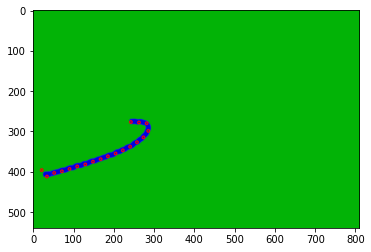

---- optimize translation ----
tensor([ 2.4209e+02,  2.6359e+02, -4.8005e-02, -9.5928e-02, -1.3733e+00,
        -2.2506e+00, -2.4691e+00, -2.5579e+00, -2.7067e+00, -2.7084e+00,
        -2.7880e+00, -2.7868e+00, -2.8370e+00, -2.7920e+00, -2.8940e+00,
        -2.8301e+00, -2.8399e+00, -2.9224e+00, -2.7152e+00, -4.0225e+00],
       device='cuda:0')
tensor(276.5286, device='cuda:0')
tensor([ 2.4209e+02,  2.6358e+02, -4.8005e-02, -9.5928e-02, -1.3733e+00,
        -2.2506e+00, -2.4691e+00, -2.5579e+00, -2.7067e+00, -2.7084e+00,
        -2.7880e+00, -2.7868e+00, -2.8370e+00, -2.7920e+00, -2.8940e+00,
        -2.8301e+00, -2.8399e+00, -2.9224e+00, -2.7152e+00, -4.0225e+00],
       device='cuda:0')
tensor(276.5292, device='cuda:0')
---- optimize rotation ----
tensor([ 2.4209e+02,  2.6359e+02, -4.8005e-02, -9.5928e-02, -1.3733e+00,
        -2.2506e+00, -2.4691e+00, -2.5579e+00, -2.7067e+00, -2.7084e+00,
        -2.7880e+00, -2.7868e+00, -2.8370e+00, -2.7920e+00, -2.8940e+00,
        -2.8301e+00,

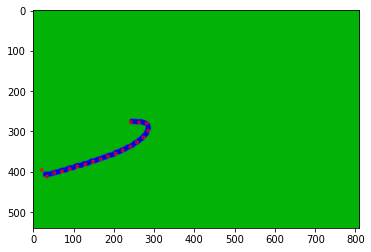

---- optimize translation ----
tensor([ 2.4209e+02,  2.6358e+02, -4.5316e-02, -9.8619e-02, -1.3711e+00,
        -2.2520e+00, -2.4673e+00, -2.5603e+00, -2.7031e+00, -2.7134e+00,
        -2.7808e+00, -2.7893e+00, -2.8472e+00, -2.7816e+00, -2.8947e+00,
        -2.8338e+00, -2.8371e+00, -2.9247e+00, -2.7113e+00, -4.0202e+00],
       device='cuda:0')
tensor(276.8252, device='cuda:0')
tensor([ 2.4210e+02,  2.6359e+02, -4.5316e-02, -9.8619e-02, -1.3711e+00,
        -2.2520e+00, -2.4673e+00, -2.5603e+00, -2.7031e+00, -2.7134e+00,
        -2.7808e+00, -2.7893e+00, -2.8472e+00, -2.7816e+00, -2.8947e+00,
        -2.8338e+00, -2.8371e+00, -2.9247e+00, -2.7113e+00, -4.0202e+00],
       device='cuda:0')
tensor(276.8238, device='cuda:0')
tensor([ 2.4209e+02,  2.6359e+02, -4.5316e-02, -9.8619e-02, -1.3711e+00,
        -2.2520e+00, -2.4673e+00, -2.5603e+00, -2.7031e+00, -2.7134e+00,
        -2.7808e+00, -2.7893e+00, -2.8472e+00, -2.7816e+00, -2.8947e+00,
        -2.8338e+00, -2.8371e+00, -2.9247e+00, -

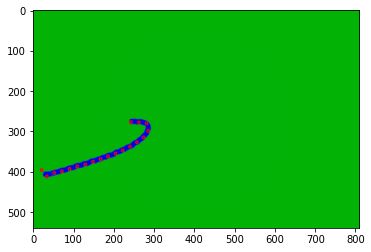

---- optimize translation ----
tensor([ 2.4210e+02,  2.6359e+02, -4.7768e-02, -9.6721e-02, -1.3740e+00,
        -2.2517e+00, -2.4664e+00, -2.5643e+00, -2.7036e+00, -2.7124e+00,
        -2.7833e+00, -2.7822e+00, -2.8540e+00, -2.7742e+00, -2.9020e+00,
        -2.8279e+00, -2.8379e+00, -2.9248e+00, -2.7134e+00, -4.0233e+00],
       device='cuda:0')
tensor(274.9015, device='cuda:0')
tensor([ 2.4208e+02,  2.6359e+02, -4.7768e-02, -9.6721e-02, -1.3740e+00,
        -2.2517e+00, -2.4664e+00, -2.5643e+00, -2.7036e+00, -2.7124e+00,
        -2.7833e+00, -2.7822e+00, -2.8540e+00, -2.7742e+00, -2.9020e+00,
        -2.8279e+00, -2.8379e+00, -2.9248e+00, -2.7134e+00, -4.0233e+00],
       device='cuda:0')
tensor(274.9012, device='cuda:0')
tensor([ 2.4211e+02,  2.6358e+02, -4.7768e-02, -9.6721e-02, -1.3740e+00,
        -2.2517e+00, -2.4664e+00, -2.5643e+00, -2.7036e+00, -2.7124e+00,
        -2.7833e+00, -2.7822e+00, -2.8540e+00, -2.7742e+00, -2.9020e+00,
        -2.8279e+00, -2.8379e+00, -2.9248e+00, -

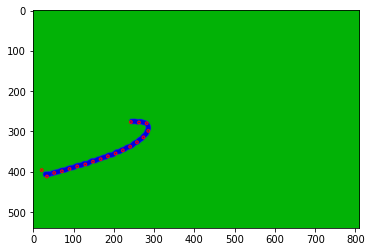

---- optimize translation ----
tensor([ 2.4209e+02,  2.6358e+02, -4.6126e-02, -9.6238e-02, -1.3747e+00,
        -2.2522e+00, -2.4681e+00, -2.5556e+00, -2.7155e+00, -2.7027e+00,
        -2.7863e+00, -2.7824e+00, -2.8530e+00, -2.7723e+00, -2.9086e+00,
        -2.8197e+00, -2.8456e+00, -2.9183e+00, -2.7193e+00, -4.0179e+00],
       device='cuda:0')
tensor(275.8560, device='cuda:0')
tensor([ 2.4183e+02,  2.6361e+02, -4.6126e-02, -9.6238e-02, -1.3747e+00,
        -2.2522e+00, -2.4681e+00, -2.5556e+00, -2.7155e+00, -2.7027e+00,
        -2.7863e+00, -2.7824e+00, -2.8530e+00, -2.7723e+00, -2.9086e+00,
        -2.8197e+00, -2.8456e+00, -2.9183e+00, -2.7193e+00, -4.0179e+00],
       device='cuda:0')
tensor(275.8013, device='cuda:0')
tensor([ 2.4197e+02,  2.6359e+02, -4.6126e-02, -9.6238e-02, -1.3747e+00,
        -2.2522e+00, -2.4681e+00, -2.5556e+00, -2.7155e+00, -2.7027e+00,
        -2.7863e+00, -2.7824e+00, -2.8530e+00, -2.7723e+00, -2.9086e+00,
        -2.8197e+00, -2.8456e+00, -2.9183e+00, -

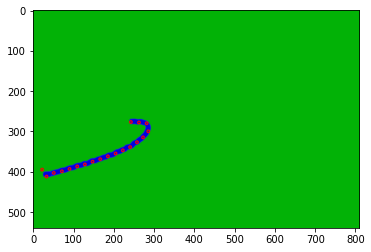

---- optimize translation ----
tensor([ 2.4204e+02,  2.6358e+02, -4.5458e-02, -1.0372e-01, -1.3889e+00,
        -2.2600e+00, -2.4681e+00, -2.5575e+00, -2.7154e+00, -2.6983e+00,
        -2.7886e+00, -2.7799e+00, -2.8531e+00, -2.7711e+00, -2.9103e+00,
        -2.8178e+00, -2.8511e+00, -2.9133e+00, -2.7188e+00, -4.1069e+00],
       device='cuda:0')
tensor(275.3869, device='cuda:0')
tensor([ 2.4158e+02,  2.6361e+02, -4.5458e-02, -1.0372e-01, -1.3889e+00,
        -2.2600e+00, -2.4681e+00, -2.5575e+00, -2.7154e+00, -2.6983e+00,
        -2.7886e+00, -2.7799e+00, -2.8531e+00, -2.7711e+00, -2.9103e+00,
        -2.8178e+00, -2.8511e+00, -2.9133e+00, -2.7188e+00, -4.1069e+00],
       device='cuda:0')
tensor(275.2988, device='cuda:0')
tensor([ 2.4184e+02,  2.6359e+02, -4.5458e-02, -1.0372e-01, -1.3889e+00,
        -2.2600e+00, -2.4681e+00, -2.5575e+00, -2.7154e+00, -2.6983e+00,
        -2.7886e+00, -2.7799e+00, -2.8531e+00, -2.7711e+00, -2.9103e+00,
        -2.8178e+00, -2.8511e+00, -2.9133e+00, -

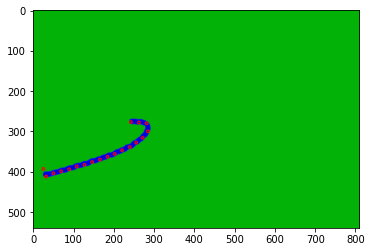

---- optimize translation ----
tensor([ 2.4216e+02,  2.6353e+02, -3.7053e-02, -1.3592e-01, -1.4540e+00,
        -2.2621e+00, -2.4658e+00, -2.5623e+00, -2.7194e+00, -2.6950e+00,
        -2.8005e+00, -2.7761e+00, -2.8529e+00, -2.7792e+00, -2.9045e+00,
        -2.8211e+00, -2.8490e+00, -2.9126e+00, -2.7206e+00, -4.3767e+00],
       device='cuda:0')
tensor(281.3832, device='cuda:0')
tensor([ 2.3724e+02,  2.6406e+02, -3.7053e-02, -1.3592e-01, -1.4540e+00,
        -2.2621e+00, -2.4658e+00, -2.5623e+00, -2.7194e+00, -2.6950e+00,
        -2.8005e+00, -2.7761e+00, -2.8529e+00, -2.7792e+00, -2.9045e+00,
        -2.8211e+00, -2.8490e+00, -2.9126e+00, -2.7206e+00, -4.3767e+00],
       device='cuda:0')
tensor(299.4071, device='cuda:0')
---- optimize rotation ----
tensor([ 2.4216e+02,  2.6353e+02, -3.7053e-02, -1.3592e-01, -1.4540e+00,
        -2.2621e+00, -2.4658e+00, -2.5623e+00, -2.7194e+00, -2.6950e+00,
        -2.8005e+00, -2.7761e+00, -2.8529e+00, -2.7792e+00, -2.9045e+00,
        -2.8211e+00,

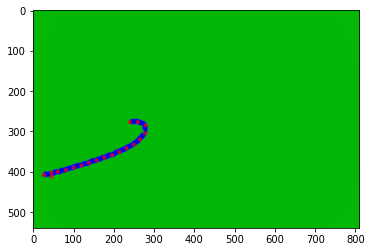

---- optimize translation ----
tensor([ 2.3991e+02,  2.6307e+02,  3.4685e-02, -4.1909e-01, -1.5879e+00,
        -2.3019e+00, -2.4206e+00, -2.6538e+00, -2.7105e+00, -2.7049e+00,
        -2.8322e+00, -2.7828e+00, -2.8281e+00, -2.8248e+00, -2.8898e+00,
        -2.8023e+00, -2.9545e+00, -2.4969e+00, -3.3454e+00, -5.9715e+00],
       device='cuda:0')
tensor(263.4026, device='cuda:0')
tensor([ 2.3803e+02,  2.6212e+02,  3.4685e-02, -4.1909e-01, -1.5879e+00,
        -2.3019e+00, -2.4206e+00, -2.6538e+00, -2.7105e+00, -2.7049e+00,
        -2.8322e+00, -2.7828e+00, -2.8281e+00, -2.8248e+00, -2.8898e+00,
        -2.8023e+00, -2.9545e+00, -2.4969e+00, -3.3454e+00, -5.9715e+00],
       device='cuda:0')
tensor(264.0422, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3991e+02,  2.6307e+02,  3.4685e-02, -4.1909e-01, -1.5879e+00,
        -2.3019e+00, -2.4206e+00, -2.6538e+00, -2.7105e+00, -2.7049e+00,
        -2.8322e+00, -2.7828e+00, -2.8281e+00, -2.8248e+00, -2.8898e+00,
        -2.8023e+00,

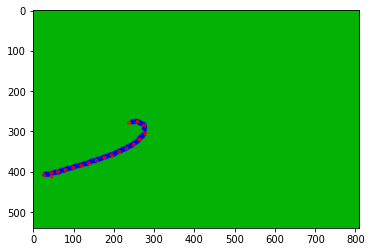

---- optimize translation ----
tensor([ 2.3829e+02,  2.6134e+02,  1.5052e-01, -4.6323e-01, -1.4951e+00,
        -2.3169e+00, -2.4059e+00, -2.6579e+00, -2.7047e+00, -2.7081e+00,
        -2.8343e+00, -2.7825e+00, -2.8293e+00, -2.8268e+00, -2.8820e+00,
        -2.8150e+00, -2.9369e+00, -2.4912e+00, -3.3862e+00, -5.9864e+00],
       device='cuda:0')
tensor(260.9382, device='cuda:0')
tensor([ 2.3803e+02,  2.6076e+02,  1.5052e-01, -4.6323e-01, -1.4951e+00,
        -2.3169e+00, -2.4059e+00, -2.6579e+00, -2.7047e+00, -2.7081e+00,
        -2.8343e+00, -2.7825e+00, -2.8293e+00, -2.8268e+00, -2.8820e+00,
        -2.8150e+00, -2.9369e+00, -2.4912e+00, -3.3862e+00, -5.9864e+00],
       device='cuda:0')
tensor(262.5072, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3829e+02,  2.6134e+02,  1.5052e-01, -4.6323e-01, -1.4951e+00,
        -2.3169e+00, -2.4059e+00, -2.6579e+00, -2.7047e+00, -2.7081e+00,
        -2.8343e+00, -2.7825e+00, -2.8293e+00, -2.8268e+00, -2.8820e+00,
        -2.8150e+00,

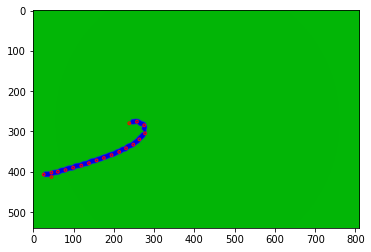

---- optimize translation ----
tensor([ 2.3822e+02,  2.6048e+02,  2.0804e-01, -4.9514e-01, -1.4687e+00,
        -2.3351e+00, -2.3991e+00, -2.6860e+00, -2.6624e+00, -2.7395e+00,
        -2.8051e+00, -2.8004e+00, -2.8221e+00, -2.8269e+00, -2.8848e+00,
        -2.8149e+00, -2.9414e+00, -2.4738e+00, -3.4099e+00, -5.9946e+00],
       device='cuda:0')
tensor(261.5984, device='cuda:0')
tensor([ 2.3814e+02,  2.6045e+02,  2.0804e-01, -4.9514e-01, -1.4687e+00,
        -2.3351e+00, -2.3991e+00, -2.6860e+00, -2.6624e+00, -2.7395e+00,
        -2.8051e+00, -2.8004e+00, -2.8221e+00, -2.8269e+00, -2.8848e+00,
        -2.8149e+00, -2.9414e+00, -2.4738e+00, -3.4099e+00, -5.9946e+00],
       device='cuda:0')
tensor(261.5972, device='cuda:0')
tensor([ 2.3818e+02,  2.6046e+02,  2.0804e-01, -4.9514e-01, -1.4687e+00,
        -2.3351e+00, -2.3991e+00, -2.6860e+00, -2.6624e+00, -2.7395e+00,
        -2.8051e+00, -2.8004e+00, -2.8221e+00, -2.8269e+00, -2.8848e+00,
        -2.8149e+00, -2.9414e+00, -2.4738e+00, -

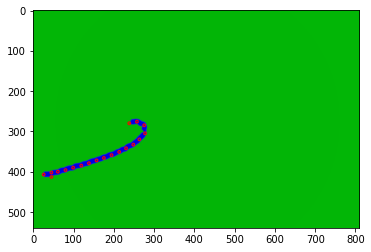

---- optimize translation ----
tensor([ 2.3807e+02,  2.6039e+02,  2.1410e-01, -4.9363e-01, -1.4563e+00,
        -2.3364e+00, -2.3997e+00, -2.6862e+00, -2.6563e+00, -2.7432e+00,
        -2.8060e+00, -2.7947e+00, -2.8298e+00, -2.8193e+00, -2.8906e+00,
        -2.8108e+00, -2.9388e+00, -2.4747e+00, -3.4089e+00, -5.9878e+00],
       device='cuda:0')
tensor(260.4218, device='cuda:0')
tensor([ 2.3800e+02,  2.6035e+02,  2.1410e-01, -4.9363e-01, -1.4563e+00,
        -2.3364e+00, -2.3997e+00, -2.6862e+00, -2.6563e+00, -2.7432e+00,
        -2.8060e+00, -2.7947e+00, -2.8298e+00, -2.8193e+00, -2.8906e+00,
        -2.8108e+00, -2.9388e+00, -2.4747e+00, -3.4089e+00, -5.9878e+00],
       device='cuda:0')
tensor(260.4275, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3807e+02,  2.6039e+02,  2.1410e-01, -4.9363e-01, -1.4563e+00,
        -2.3364e+00, -2.3997e+00, -2.6862e+00, -2.6563e+00, -2.7432e+00,
        -2.8060e+00, -2.7947e+00, -2.8298e+00, -2.8193e+00, -2.8906e+00,
        -2.8108e+00,

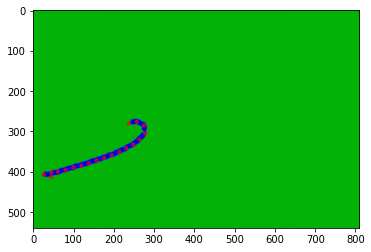

---- optimize translation ----
tensor([ 2.3800e+02,  2.6035e+02,  2.1379e-01, -4.8926e-01, -1.4567e+00,
        -2.3320e+00, -2.4059e+00, -2.6798e+00, -2.6643e+00, -2.7402e+00,
        -2.8036e+00, -2.8001e+00, -2.8206e+00, -2.8293e+00, -2.8808e+00,
        -2.8174e+00, -2.9349e+00, -2.4747e+00, -3.4151e+00, -5.9917e+00],
       device='cuda:0')
tensor(261.7957, device='cuda:0')
tensor([ 2.3811e+02,  2.6040e+02,  2.1379e-01, -4.8926e-01, -1.4567e+00,
        -2.3320e+00, -2.4059e+00, -2.6798e+00, -2.6643e+00, -2.7402e+00,
        -2.8036e+00, -2.8001e+00, -2.8206e+00, -2.8293e+00, -2.8808e+00,
        -2.8174e+00, -2.9349e+00, -2.4747e+00, -3.4151e+00, -5.9917e+00],
       device='cuda:0')
tensor(261.8109, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3800e+02,  2.6035e+02,  2.1379e-01, -4.8926e-01, -1.4567e+00,
        -2.3320e+00, -2.4059e+00, -2.6798e+00, -2.6643e+00, -2.7402e+00,
        -2.8036e+00, -2.8001e+00, -2.8206e+00, -2.8293e+00, -2.8808e+00,
        -2.8174e+00,

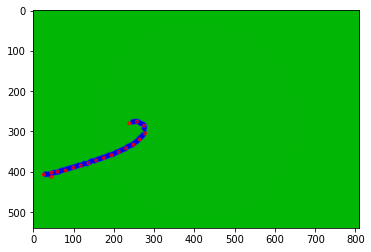

---- optimize translation ----
tensor([ 2.3832e+02,  2.6055e+02,  2.0108e-01, -5.0064e-01, -1.4849e+00,
        -2.3313e+00, -2.4134e+00, -2.6794e+00, -2.6709e+00, -2.7400e+00,
        -2.7997e+00, -2.8108e+00, -2.8066e+00, -2.8485e+00, -2.8667e+00,
        -2.8133e+00, -2.9484e+00, -2.4554e+00, -3.4341e+00, -6.0020e+00],
       device='cuda:0')
tensor(260.3133, device='cuda:0')
tensor([ 2.3829e+02,  2.6055e+02,  2.0108e-01, -5.0064e-01, -1.4849e+00,
        -2.3313e+00, -2.4134e+00, -2.6794e+00, -2.6709e+00, -2.7400e+00,
        -2.7997e+00, -2.8108e+00, -2.8066e+00, -2.8485e+00, -2.8667e+00,
        -2.8133e+00, -2.9484e+00, -2.4554e+00, -3.4341e+00, -6.0020e+00],
       device='cuda:0')
tensor(260.3112, device='cuda:0')
tensor([ 2.3829e+02,  2.6055e+02,  2.0108e-01, -5.0064e-01, -1.4849e+00,
        -2.3313e+00, -2.4134e+00, -2.6794e+00, -2.6709e+00, -2.7400e+00,
        -2.7997e+00, -2.8108e+00, -2.8066e+00, -2.8485e+00, -2.8667e+00,
        -2.8133e+00, -2.9484e+00, -2.4554e+00, -

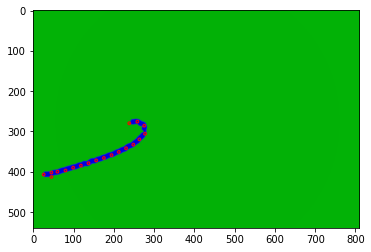

---- optimize translation ----
tensor([ 2.3849e+02,  2.6066e+02,  1.9346e-01, -5.1008e-01, -1.4976e+00,
        -2.3370e+00, -2.4178e+00, -2.6756e+00, -2.6734e+00, -2.7384e+00,
        -2.8040e+00, -2.8163e+00, -2.7828e+00, -2.8741e+00, -2.8567e+00,
        -2.8120e+00, -2.9559e+00, -2.4394e+00, -3.4481e+00, -6.0034e+00],
       device='cuda:0')
tensor(261.6436, device='cuda:0')
tensor([ 2.3860e+02,  2.6069e+02,  1.9346e-01, -5.1008e-01, -1.4976e+00,
        -2.3370e+00, -2.4178e+00, -2.6756e+00, -2.6734e+00, -2.7384e+00,
        -2.8040e+00, -2.8163e+00, -2.7828e+00, -2.8741e+00, -2.8567e+00,
        -2.8120e+00, -2.9559e+00, -2.4394e+00, -3.4481e+00, -6.0034e+00],
       device='cuda:0')
tensor(261.6601, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3849e+02,  2.6066e+02,  1.9346e-01, -5.1008e-01, -1.4976e+00,
        -2.3370e+00, -2.4178e+00, -2.6756e+00, -2.6734e+00, -2.7384e+00,
        -2.8040e+00, -2.8163e+00, -2.7828e+00, -2.8741e+00, -2.8567e+00,
        -2.8120e+00,

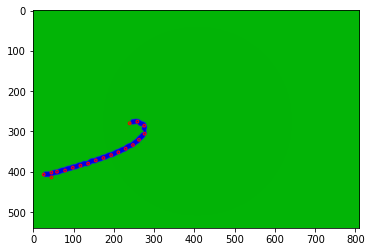

---- optimize translation ----
tensor([ 2.3902e+02,  2.6094e+02,  1.7472e-01, -5.3183e-01, -1.5372e+00,
        -2.3388e+00, -2.4331e+00, -2.6671e+00, -2.6882e+00, -2.7312e+00,
        -2.8045e+00, -2.8225e+00, -2.7751e+00, -2.8831e+00, -2.8498e+00,
        -2.8172e+00, -2.9555e+00, -2.4004e+00, -3.4881e+00, -6.0282e+00],
       device='cuda:0')
tensor(260.6445, device='cuda:0')
tensor([ 2.3909e+02,  2.6097e+02,  1.7472e-01, -5.3183e-01, -1.5372e+00,
        -2.3388e+00, -2.4331e+00, -2.6671e+00, -2.6882e+00, -2.7312e+00,
        -2.8045e+00, -2.8225e+00, -2.7751e+00, -2.8831e+00, -2.8498e+00,
        -2.8172e+00, -2.9555e+00, -2.4004e+00, -3.4881e+00, -6.0282e+00],
       device='cuda:0')
tensor(260.6571, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3902e+02,  2.6094e+02,  1.7472e-01, -5.3183e-01, -1.5372e+00,
        -2.3388e+00, -2.4331e+00, -2.6671e+00, -2.6882e+00, -2.7312e+00,
        -2.8045e+00, -2.8225e+00, -2.7751e+00, -2.8831e+00, -2.8498e+00,
        -2.8172e+00,

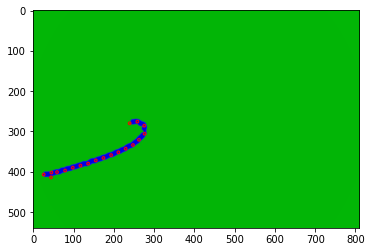

---- optimize translation ----
tensor([ 2.3906e+02,  2.6095e+02,  1.7453e-01, -5.3509e-01, -1.5369e+00,
        -2.3468e+00, -2.4246e+00, -2.6745e+00, -2.6764e+00, -2.7468e+00,
        -2.7923e+00, -2.8259e+00, -2.7779e+00, -2.8800e+00, -2.8522e+00,
        -2.8193e+00, -2.9515e+00, -2.4026e+00, -3.4839e+00, -6.0293e+00],
       device='cuda:0')
tensor(259.4025, device='cuda:0')
tensor([ 2.3890e+02,  2.6091e+02,  1.7453e-01, -5.3509e-01, -1.5369e+00,
        -2.3468e+00, -2.4246e+00, -2.6745e+00, -2.6764e+00, -2.7468e+00,
        -2.7923e+00, -2.8259e+00, -2.7779e+00, -2.8800e+00, -2.8522e+00,
        -2.8193e+00, -2.9515e+00, -2.4026e+00, -3.4839e+00, -6.0293e+00],
       device='cuda:0')
tensor(259.3882, device='cuda:0')
tensor([ 2.3896e+02,  2.6093e+02,  1.7453e-01, -5.3509e-01, -1.5369e+00,
        -2.3468e+00, -2.4246e+00, -2.6745e+00, -2.6764e+00, -2.7468e+00,
        -2.7923e+00, -2.8259e+00, -2.7779e+00, -2.8800e+00, -2.8522e+00,
        -2.8193e+00, -2.9515e+00, -2.4026e+00, -

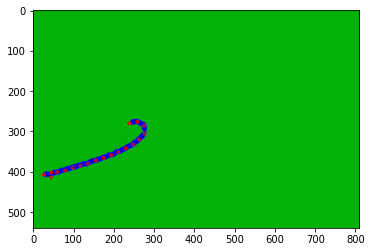

---- optimize translation ----
tensor([ 2.3893e+02,  2.6092e+02,  1.7502e-01, -5.2817e-01, -1.5350e+00,
        -2.3476e+00, -2.4297e+00, -2.6758e+00, -2.6685e+00, -2.7387e+00,
        -2.8054e+00, -2.8162e+00, -2.7798e+00, -2.8764e+00, -2.8549e+00,
        -2.8197e+00, -2.9446e+00, -2.4081e+00, -3.4924e+00, -6.0359e+00],
       device='cuda:0')
tensor(259.9518, device='cuda:0')
tensor([ 2.3897e+02,  2.6093e+02,  1.7502e-01, -5.2817e-01, -1.5350e+00,
        -2.3476e+00, -2.4297e+00, -2.6758e+00, -2.6685e+00, -2.7387e+00,
        -2.8054e+00, -2.8162e+00, -2.7798e+00, -2.8764e+00, -2.8549e+00,
        -2.8197e+00, -2.9446e+00, -2.4081e+00, -3.4924e+00, -6.0359e+00],
       device='cuda:0')
tensor(259.9643, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3893e+02,  2.6092e+02,  1.7502e-01, -5.2817e-01, -1.5350e+00,
        -2.3476e+00, -2.4297e+00, -2.6758e+00, -2.6685e+00, -2.7387e+00,
        -2.8054e+00, -2.8162e+00, -2.7798e+00, -2.8764e+00, -2.8549e+00,
        -2.8197e+00,

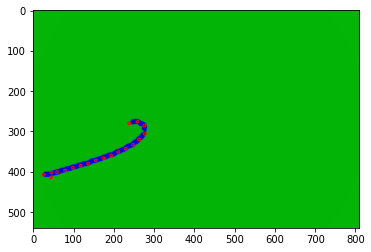

---- optimize translation ----
tensor([ 2.3899e+02,  2.6095e+02,  1.7290e-01, -5.2694e-01, -1.5419e+00,
        -2.3530e+00, -2.4429e+00, -2.6530e+00, -2.6840e+00, -2.7219e+00,
        -2.8171e+00, -2.8103e+00, -2.7778e+00, -2.8807e+00, -2.8517e+00,
        -2.8190e+00, -2.9523e+00, -2.3929e+00, -3.4957e+00, -6.0287e+00],
       device='cuda:0')
tensor(260.0338, device='cuda:0')
tensor([ 2.3892e+02,  2.6094e+02,  1.7290e-01, -5.2694e-01, -1.5419e+00,
        -2.3530e+00, -2.4429e+00, -2.6530e+00, -2.6840e+00, -2.7219e+00,
        -2.8171e+00, -2.8103e+00, -2.7778e+00, -2.8807e+00, -2.8517e+00,
        -2.8190e+00, -2.9523e+00, -2.3929e+00, -3.4957e+00, -6.0287e+00],
       device='cuda:0')
tensor(260.0276, device='cuda:0')
tensor([ 2.3895e+02,  2.6095e+02,  1.7290e-01, -5.2694e-01, -1.5419e+00,
        -2.3530e+00, -2.4429e+00, -2.6530e+00, -2.6840e+00, -2.7219e+00,
        -2.8171e+00, -2.8103e+00, -2.7778e+00, -2.8807e+00, -2.8517e+00,
        -2.8190e+00, -2.9523e+00, -2.3929e+00, -

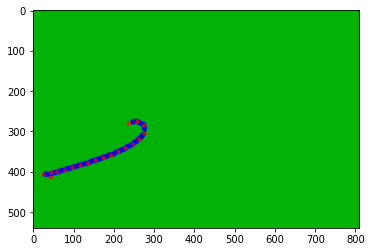

---- optimize translation ----
tensor([ 2.3886e+02,  2.6092e+02,  1.7378e-01, -5.1674e-01, -1.5435e+00,
        -2.3459e+00, -2.4434e+00, -2.6676e+00, -2.6639e+00, -2.7233e+00,
        -2.8198e+00, -2.8069e+00, -2.7924e+00, -2.8630e+00, -2.8576e+00,
        -2.8148e+00, -2.9560e+00, -2.3938e+00, -3.4969e+00, -6.0332e+00],
       device='cuda:0')
tensor(260.6846, device='cuda:0')
tensor([ 2.3883e+02,  2.6092e+02,  1.7378e-01, -5.1674e-01, -1.5435e+00,
        -2.3459e+00, -2.4434e+00, -2.6676e+00, -2.6639e+00, -2.7233e+00,
        -2.8198e+00, -2.8069e+00, -2.7924e+00, -2.8630e+00, -2.8576e+00,
        -2.8148e+00, -2.9560e+00, -2.3938e+00, -3.4969e+00, -6.0332e+00],
       device='cuda:0')
tensor(260.6768, device='cuda:0')
tensor([ 2.3883e+02,  2.6092e+02,  1.7378e-01, -5.1674e-01, -1.5435e+00,
        -2.3459e+00, -2.4434e+00, -2.6676e+00, -2.6639e+00, -2.7233e+00,
        -2.8198e+00, -2.8069e+00, -2.7924e+00, -2.8630e+00, -2.8576e+00,
        -2.8148e+00, -2.9560e+00, -2.3938e+00, -

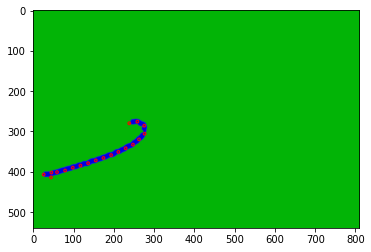

---- optimize translation ----
tensor([ 2.3885e+02,  2.6095e+02,  1.7084e-01, -5.1241e-01, -1.5519e+00,
        -2.3421e+00, -2.4451e+00, -2.6663e+00, -2.6703e+00, -2.7254e+00,
        -2.8052e+00, -2.8139e+00, -2.7868e+00, -2.8687e+00, -2.8594e+00,
        -2.8153e+00, -2.9543e+00, -2.3883e+00, -3.4978e+00, -6.0292e+00],
       device='cuda:0')
tensor(259.5357, device='cuda:0')
tensor([ 2.3888e+02,  2.6096e+02,  1.7084e-01, -5.1241e-01, -1.5519e+00,
        -2.3421e+00, -2.4451e+00, -2.6663e+00, -2.6703e+00, -2.7254e+00,
        -2.8052e+00, -2.8139e+00, -2.7868e+00, -2.8687e+00, -2.8594e+00,
        -2.8153e+00, -2.9543e+00, -2.3883e+00, -3.4978e+00, -6.0292e+00],
       device='cuda:0')
tensor(259.5367, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3885e+02,  2.6095e+02,  1.7084e-01, -5.1241e-01, -1.5519e+00,
        -2.3421e+00, -2.4451e+00, -2.6663e+00, -2.6703e+00, -2.7254e+00,
        -2.8052e+00, -2.8139e+00, -2.7868e+00, -2.8687e+00, -2.8594e+00,
        -2.8153e+00,

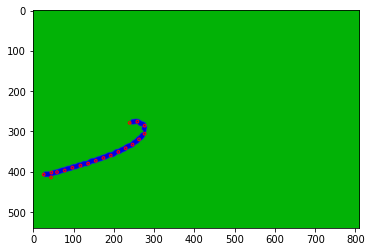

---- optimize translation ----
tensor([ 2.3903e+02,  2.6103e+02,  1.6561e-01, -5.2250e-01, -1.5626e+00,
        -2.3424e+00, -2.4569e+00, -2.6567e+00, -2.6764e+00, -2.7254e+00,
        -2.8075e+00, -2.8133e+00, -2.7844e+00, -2.8719e+00, -2.8610e+00,
        -2.8078e+00, -2.9597e+00, -2.3809e+00, -3.5133e+00, -6.0399e+00],
       device='cuda:0')
tensor(260.4518, device='cuda:0')
tensor([ 2.3904e+02,  2.6105e+02,  1.6561e-01, -5.2250e-01, -1.5626e+00,
        -2.3424e+00, -2.4569e+00, -2.6567e+00, -2.6764e+00, -2.7254e+00,
        -2.8075e+00, -2.8133e+00, -2.7844e+00, -2.8719e+00, -2.8610e+00,
        -2.8078e+00, -2.9597e+00, -2.3809e+00, -3.5133e+00, -6.0399e+00],
       device='cuda:0')
tensor(260.4533, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3903e+02,  2.6103e+02,  1.6561e-01, -5.2250e-01, -1.5626e+00,
        -2.3424e+00, -2.4569e+00, -2.6567e+00, -2.6764e+00, -2.7254e+00,
        -2.8075e+00, -2.8133e+00, -2.7844e+00, -2.8719e+00, -2.8610e+00,
        -2.8078e+00,

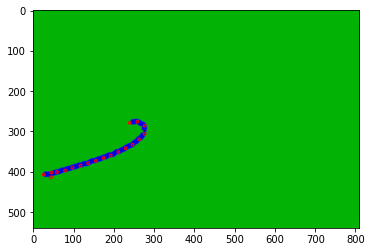

---- optimize translation ----
tensor([ 2.3902e+02,  2.6106e+02,  1.6289e-01, -5.1945e-01, -1.5635e+00,
        -2.3421e+00, -2.4561e+00, -2.6580e+00, -2.6764e+00, -2.7229e+00,
        -2.8094e+00, -2.8119e+00, -2.7870e+00, -2.8689e+00, -2.8609e+00,
        -2.8109e+00, -2.9532e+00, -2.3865e+00, -3.5145e+00, -6.0414e+00],
       device='cuda:0')
tensor(259.9683, device='cuda:0')
tensor([ 2.3919e+02,  2.6112e+02,  1.6289e-01, -5.1945e-01, -1.5635e+00,
        -2.3421e+00, -2.4561e+00, -2.6580e+00, -2.6764e+00, -2.7229e+00,
        -2.8094e+00, -2.8119e+00, -2.7870e+00, -2.8689e+00, -2.8609e+00,
        -2.8109e+00, -2.9532e+00, -2.3865e+00, -3.5145e+00, -6.0414e+00],
       device='cuda:0')
tensor(260.0238, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3902e+02,  2.6106e+02,  1.6289e-01, -5.1945e-01, -1.5635e+00,
        -2.3421e+00, -2.4561e+00, -2.6580e+00, -2.6764e+00, -2.7229e+00,
        -2.8094e+00, -2.8119e+00, -2.7870e+00, -2.8689e+00, -2.8609e+00,
        -2.8109e+00,

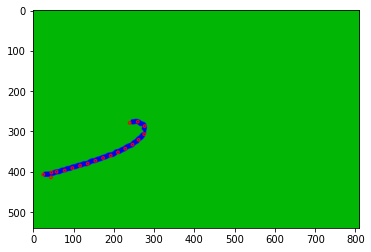

---- optimize translation ----
tensor([ 2.3943e+02,  2.6124e+02,  1.5054e-01, -5.3921e-01, -1.5967e+00,
        -2.3435e+00, -2.4612e+00, -2.6588e+00, -2.6788e+00, -2.7263e+00,
        -2.8063e+00, -2.8176e+00, -2.7819e+00, -2.8745e+00, -2.8593e+00,
        -2.8046e+00, -2.9764e+00, -2.3789e+00, -3.5061e+00, -6.0479e+00],
       device='cuda:0')
tensor(260.5110, device='cuda:0')
tensor([ 2.3952e+02,  2.6127e+02,  1.5054e-01, -5.3921e-01, -1.5967e+00,
        -2.3435e+00, -2.4612e+00, -2.6588e+00, -2.6788e+00, -2.7263e+00,
        -2.8063e+00, -2.8176e+00, -2.7819e+00, -2.8745e+00, -2.8593e+00,
        -2.8046e+00, -2.9764e+00, -2.3789e+00, -3.5061e+00, -6.0479e+00],
       device='cuda:0')
tensor(260.5216, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3943e+02,  2.6124e+02,  1.5054e-01, -5.3921e-01, -1.5967e+00,
        -2.3435e+00, -2.4612e+00, -2.6588e+00, -2.6788e+00, -2.7263e+00,
        -2.8063e+00, -2.8176e+00, -2.7819e+00, -2.8745e+00, -2.8593e+00,
        -2.8046e+00,

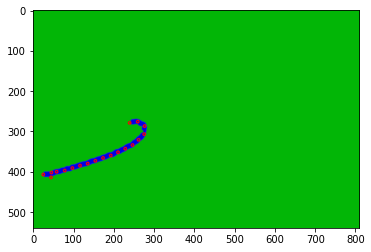

---- optimize translation ----
tensor([ 2.3975e+02,  2.6135e+02,  1.4258e-01, -5.5407e-01, -1.6156e+00,
        -2.3483e+00, -2.4638e+00, -2.6594e+00, -2.6811e+00, -2.7252e+00,
        -2.8078e+00, -2.8208e+00, -2.7849e+00, -2.8646e+00, -2.8588e+00,
        -2.8000e+00, -3.0110e+00, -2.3433e+00, -3.5130e+00, -6.0447e+00],
       device='cuda:0')
tensor(259.9263, device='cuda:0')
tensor([ 2.3955e+02,  2.6130e+02,  1.4258e-01, -5.5407e-01, -1.6156e+00,
        -2.3483e+00, -2.4638e+00, -2.6594e+00, -2.6811e+00, -2.7252e+00,
        -2.8078e+00, -2.8208e+00, -2.7849e+00, -2.8646e+00, -2.8588e+00,
        -2.8000e+00, -3.0110e+00, -2.3433e+00, -3.5130e+00, -6.0447e+00],
       device='cuda:0')
tensor(259.9842, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3975e+02,  2.6135e+02,  1.4258e-01, -5.5407e-01, -1.6156e+00,
        -2.3483e+00, -2.4638e+00, -2.6594e+00, -2.6811e+00, -2.7252e+00,
        -2.8078e+00, -2.8208e+00, -2.7849e+00, -2.8646e+00, -2.8588e+00,
        -2.8000e+00,

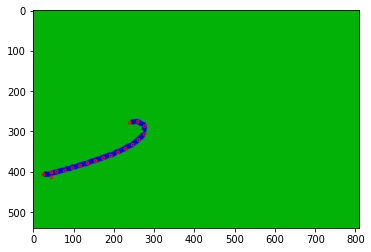

---- optimize translation ----
tensor([ 2.3941e+02,  2.6124e+02,  1.4980e-01, -5.4189e-01, -1.5917e+00,
        -2.3469e+00, -2.4626e+00, -2.6567e+00, -2.6806e+00, -2.7241e+00,
        -2.8118e+00, -2.8093e+00, -2.7991e+00, -2.8561e+00, -2.8569e+00,
        -2.8056e+00, -2.9972e+00, -2.3610e+00, -3.5069e+00, -6.0325e+00],
       device='cuda:0')
tensor(260.6141, device='cuda:0')
tensor([ 2.3940e+02,  2.6124e+02,  1.4980e-01, -5.4189e-01, -1.5917e+00,
        -2.3469e+00, -2.4626e+00, -2.6567e+00, -2.6806e+00, -2.7241e+00,
        -2.8118e+00, -2.8093e+00, -2.7991e+00, -2.8561e+00, -2.8569e+00,
        -2.8056e+00, -2.9972e+00, -2.3610e+00, -3.5069e+00, -6.0325e+00],
       device='cuda:0')
tensor(260.6154, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3941e+02,  2.6124e+02,  1.4980e-01, -5.4189e-01, -1.5917e+00,
        -2.3469e+00, -2.4626e+00, -2.6567e+00, -2.6806e+00, -2.7241e+00,
        -2.8118e+00, -2.8093e+00, -2.7991e+00, -2.8561e+00, -2.8569e+00,
        -2.8056e+00,

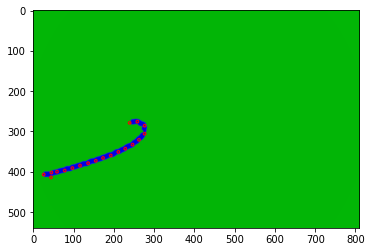

---- optimize translation ----
tensor([ 2.3915e+02,  2.6113e+02,  1.5779e-01, -5.2425e-01, -1.5759e+00,
        -2.3422e+00, -2.4568e+00, -2.6582e+00, -2.6784e+00, -2.7228e+00,
        -2.8169e+00, -2.7974e+00, -2.8104e+00, -2.8460e+00, -2.8556e+00,
        -2.8132e+00, -2.9937e+00, -2.3530e+00, -3.4980e+00, -6.0152e+00],
       device='cuda:0')
tensor(259.3677, device='cuda:0')
tensor([ 2.3912e+02,  2.6112e+02,  1.5779e-01, -5.2425e-01, -1.5759e+00,
        -2.3422e+00, -2.4568e+00, -2.6582e+00, -2.6784e+00, -2.7228e+00,
        -2.8169e+00, -2.7974e+00, -2.8104e+00, -2.8460e+00, -2.8556e+00,
        -2.8132e+00, -2.9937e+00, -2.3530e+00, -3.4980e+00, -6.0152e+00],
       device='cuda:0')
tensor(259.3693, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3915e+02,  2.6113e+02,  1.5779e-01, -5.2425e-01, -1.5759e+00,
        -2.3422e+00, -2.4568e+00, -2.6582e+00, -2.6784e+00, -2.7228e+00,
        -2.8169e+00, -2.7974e+00, -2.8104e+00, -2.8460e+00, -2.8556e+00,
        -2.8132e+00,

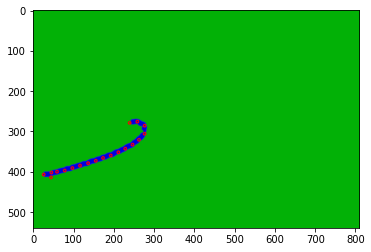

---- optimize translation ----
tensor([ 2.3913e+02,  2.6112e+02,  1.5826e-01, -5.2678e-01, -1.5718e+00,
        -2.3440e+00, -2.4578e+00, -2.6569e+00, -2.6767e+00, -2.7269e+00,
        -2.8138e+00, -2.8006e+00, -2.8104e+00, -2.8455e+00, -2.8547e+00,
        -2.8149e+00, -2.9882e+00, -2.3600e+00, -3.5052e+00, -6.0225e+00],
       device='cuda:0')
tensor(260.0733, device='cuda:0')
tensor([ 2.3903e+02,  2.6109e+02,  1.5826e-01, -5.2678e-01, -1.5718e+00,
        -2.3440e+00, -2.4578e+00, -2.6569e+00, -2.6767e+00, -2.7269e+00,
        -2.8138e+00, -2.8006e+00, -2.8104e+00, -2.8455e+00, -2.8547e+00,
        -2.8149e+00, -2.9882e+00, -2.3600e+00, -3.5052e+00, -6.0225e+00],
       device='cuda:0')
tensor(260.0419, device='cuda:0')
tensor([ 2.3902e+02,  2.6108e+02,  1.5826e-01, -5.2678e-01, -1.5718e+00,
        -2.3440e+00, -2.4578e+00, -2.6569e+00, -2.6767e+00, -2.7269e+00,
        -2.8138e+00, -2.8006e+00, -2.8104e+00, -2.8455e+00, -2.8547e+00,
        -2.8149e+00, -2.9882e+00, -2.3600e+00, -

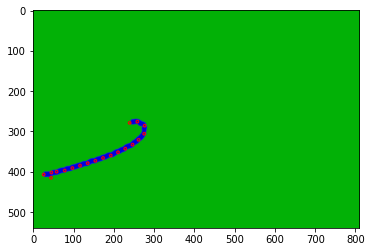

---- optimize translation ----
tensor([ 2.3913e+02,  2.6115e+02,  1.5510e-01, -5.2331e-01, -1.6104e+00,
        -2.3133e+00, -2.4682e+00, -2.6686e+00, -2.6744e+00, -2.7110e+00,
        -2.8314e+00, -2.7922e+00, -2.8177e+00, -2.8382e+00, -2.8551e+00,
        -2.8250e+00, -2.9776e+00, -2.3411e+00, -3.5382e+00, -6.0298e+00],
       device='cuda:0')
tensor(261.9608, device='cuda:0')
tensor([ 2.3881e+02,  2.6107e+02,  1.5510e-01, -5.2331e-01, -1.6104e+00,
        -2.3133e+00, -2.4682e+00, -2.6686e+00, -2.6744e+00, -2.7110e+00,
        -2.8314e+00, -2.7922e+00, -2.8177e+00, -2.8382e+00, -2.8551e+00,
        -2.8250e+00, -2.9776e+00, -2.3411e+00, -3.5382e+00, -6.0298e+00],
       device='cuda:0')
tensor(261.9376, device='cuda:0')
tensor([ 2.3892e+02,  2.6109e+02,  1.5510e-01, -5.2331e-01, -1.6104e+00,
        -2.3133e+00, -2.4682e+00, -2.6686e+00, -2.6744e+00, -2.7110e+00,
        -2.8314e+00, -2.7922e+00, -2.8177e+00, -2.8382e+00, -2.8551e+00,
        -2.8250e+00, -2.9776e+00, -2.3411e+00, -

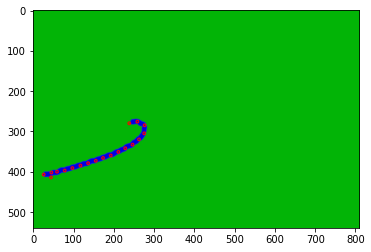

---- optimize translation ----
tensor([ 2.3846e+02,  2.6097e+02,  1.6225e-01, -4.6947e-01, -1.6004e+00,
        -2.2910e+00, -2.4657e+00, -2.6674e+00, -2.6551e+00, -2.7172e+00,
        -2.8306e+00, -2.7817e+00, -2.8299e+00, -2.8239e+00, -2.8655e+00,
        -2.8223e+00, -2.9689e+00, -2.3625e+00, -3.5123e+00, -6.0178e+00],
       device='cuda:0')
tensor(262.5156, device='cuda:0')
tensor([ 2.3843e+02,  2.6099e+02,  1.6225e-01, -4.6947e-01, -1.6004e+00,
        -2.2910e+00, -2.4657e+00, -2.6674e+00, -2.6551e+00, -2.7172e+00,
        -2.8306e+00, -2.7817e+00, -2.8299e+00, -2.8239e+00, -2.8655e+00,
        -2.8223e+00, -2.9689e+00, -2.3625e+00, -3.5123e+00, -6.0178e+00],
       device='cuda:0')
tensor(262.5023, device='cuda:0')
tensor([ 2.3838e+02,  2.6097e+02,  1.6225e-01, -4.6947e-01, -1.6004e+00,
        -2.2910e+00, -2.4657e+00, -2.6674e+00, -2.6551e+00, -2.7172e+00,
        -2.8306e+00, -2.7817e+00, -2.8299e+00, -2.8239e+00, -2.8655e+00,
        -2.8223e+00, -2.9689e+00, -2.3625e+00, -

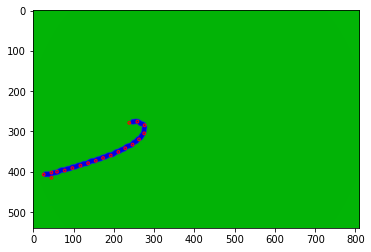

---- optimize translation ----
tensor([ 2.3839e+02,  2.6102e+02,  1.5605e-01, -4.5700e-01, -1.6157e+00,
        -2.2836e+00, -2.4672e+00, -2.6578e+00, -2.6653e+00, -2.7026e+00,
        -2.8383e+00, -2.7818e+00, -2.8323e+00, -2.8247e+00, -2.8594e+00,
        -2.8300e+00, -2.9642e+00, -2.3534e+00, -3.5151e+00, -6.0269e+00],
       device='cuda:0')
tensor(262.0106, device='cuda:0')
tensor([ 2.3841e+02,  2.6103e+02,  1.5605e-01, -4.5700e-01, -1.6157e+00,
        -2.2836e+00, -2.4672e+00, -2.6578e+00, -2.6653e+00, -2.7026e+00,
        -2.8383e+00, -2.7818e+00, -2.8323e+00, -2.8247e+00, -2.8594e+00,
        -2.8300e+00, -2.9642e+00, -2.3534e+00, -3.5151e+00, -6.0269e+00],
       device='cuda:0')
tensor(262.0122, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3839e+02,  2.6102e+02,  1.5605e-01, -4.5700e-01, -1.6157e+00,
        -2.2836e+00, -2.4672e+00, -2.6578e+00, -2.6653e+00, -2.7026e+00,
        -2.8383e+00, -2.7818e+00, -2.8323e+00, -2.8247e+00, -2.8594e+00,
        -2.8300e+00,

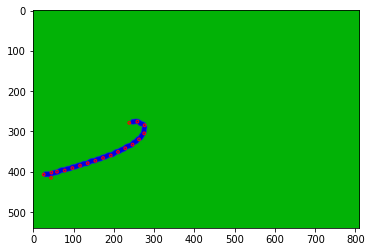

---- optimize translation ----
tensor([ 2.3843e+02,  2.6105e+02,  1.5380e-01, -4.6070e-01, -1.6191e+00,
        -2.2853e+00, -2.4740e+00, -2.6489e+00, -2.6715e+00, -2.7066e+00,
        -2.8297e+00, -2.7879e+00, -2.8231e+00, -2.8307e+00, -2.8641e+00,
        -2.8182e+00, -2.9719e+00, -2.3544e+00, -3.5188e+00, -6.0388e+00],
       device='cuda:0')
tensor(263.5218, device='cuda:0')
tensor([ 2.3854e+02,  2.6110e+02,  1.5380e-01, -4.6070e-01, -1.6191e+00,
        -2.2853e+00, -2.4740e+00, -2.6489e+00, -2.6715e+00, -2.7066e+00,
        -2.8297e+00, -2.7879e+00, -2.8231e+00, -2.8307e+00, -2.8641e+00,
        -2.8182e+00, -2.9719e+00, -2.3544e+00, -3.5188e+00, -6.0388e+00],
       device='cuda:0')
tensor(263.5472, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3843e+02,  2.6105e+02,  1.5380e-01, -4.6070e-01, -1.6191e+00,
        -2.2853e+00, -2.4740e+00, -2.6489e+00, -2.6715e+00, -2.7066e+00,
        -2.8297e+00, -2.7879e+00, -2.8231e+00, -2.8307e+00, -2.8641e+00,
        -2.8182e+00,

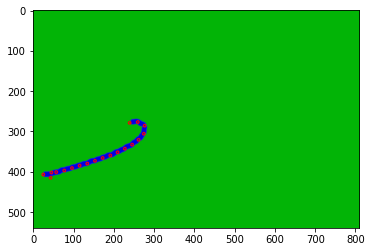

---- optimize translation ----
tensor([ 2.3941e+02,  2.6148e+02,  1.2393e-01, -5.1413e-01, -1.6816e+00,
        -2.3019e+00, -2.4774e+00, -2.6596e+00, -2.6752e+00, -2.7159e+00,
        -2.8213e+00, -2.7999e+00, -2.8077e+00, -2.8475e+00, -2.8467e+00,
        -2.8427e+00, -2.9379e+00, -2.3658e+00, -3.5824e+00, -6.0748e+00],
       device='cuda:0')
tensor(262.4240, device='cuda:0')
tensor([ 2.3942e+02,  2.6149e+02,  1.2393e-01, -5.1413e-01, -1.6816e+00,
        -2.3019e+00, -2.4774e+00, -2.6596e+00, -2.6752e+00, -2.7159e+00,
        -2.8213e+00, -2.7999e+00, -2.8077e+00, -2.8475e+00, -2.8467e+00,
        -2.8427e+00, -2.9379e+00, -2.3658e+00, -3.5824e+00, -6.0748e+00],
       device='cuda:0')
tensor(262.4264, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3941e+02,  2.6148e+02,  1.2393e-01, -5.1413e-01, -1.6816e+00,
        -2.3019e+00, -2.4774e+00, -2.6596e+00, -2.6752e+00, -2.7159e+00,
        -2.8213e+00, -2.7999e+00, -2.8077e+00, -2.8475e+00, -2.8467e+00,
        -2.8427e+00,

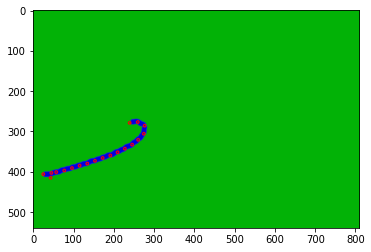

---- optimize translation ----
tensor([ 2.3945e+02,  2.6149e+02,  1.2356e-01, -5.1766e-01, -1.6833e+00,
        -2.3076e+00, -2.4744e+00, -2.6572e+00, -2.6821e+00, -2.7134e+00,
        -2.8187e+00, -2.8030e+00, -2.8068e+00, -2.8458e+00, -2.8527e+00,
        -2.8392e+00, -2.9341e+00, -2.3677e+00, -3.5886e+00, -6.0886e+00],
       device='cuda:0')
tensor(262.3750, device='cuda:0')
tensor([ 2.3946e+02,  2.6149e+02,  1.2356e-01, -5.1766e-01, -1.6833e+00,
        -2.3076e+00, -2.4744e+00, -2.6572e+00, -2.6821e+00, -2.7134e+00,
        -2.8187e+00, -2.8030e+00, -2.8068e+00, -2.8458e+00, -2.8527e+00,
        -2.8392e+00, -2.9341e+00, -2.3677e+00, -3.5886e+00, -6.0886e+00],
       device='cuda:0')
tensor(262.3759, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3945e+02,  2.6149e+02,  1.2356e-01, -5.1766e-01, -1.6833e+00,
        -2.3076e+00, -2.4744e+00, -2.6572e+00, -2.6821e+00, -2.7134e+00,
        -2.8187e+00, -2.8030e+00, -2.8068e+00, -2.8458e+00, -2.8527e+00,
        -2.8392e+00,

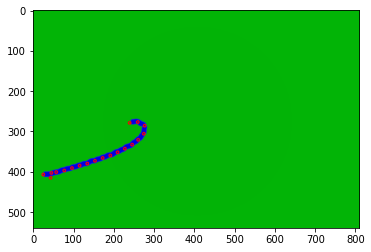

---- optimize translation ----
tensor([ 2.3945e+02,  2.6149e+02,  1.2383e-01, -5.1804e-01, -1.6829e+00,
        -2.3086e+00, -2.4747e+00, -2.6622e+00, -2.6743e+00, -2.7156e+00,
        -2.8241e+00, -2.7955e+00, -2.8083e+00, -2.8476e+00, -2.8502e+00,
        -2.8389e+00, -2.9372e+00, -2.3640e+00, -3.5851e+00, -6.0800e+00],
       device='cuda:0')
tensor(263.0919, device='cuda:0')
tensor([ 2.3943e+02,  2.6149e+02,  1.2383e-01, -5.1804e-01, -1.6829e+00,
        -2.3086e+00, -2.4747e+00, -2.6622e+00, -2.6743e+00, -2.7156e+00,
        -2.8241e+00, -2.7955e+00, -2.8083e+00, -2.8476e+00, -2.8502e+00,
        -2.8389e+00, -2.9372e+00, -2.3640e+00, -3.5851e+00, -6.0800e+00],
       device='cuda:0')
tensor(263.0806, device='cuda:0')
tensor([ 2.3944e+02,  2.6149e+02,  1.2383e-01, -5.1804e-01, -1.6829e+00,
        -2.3086e+00, -2.4747e+00, -2.6622e+00, -2.6743e+00, -2.7156e+00,
        -2.8241e+00, -2.7955e+00, -2.8083e+00, -2.8476e+00, -2.8502e+00,
        -2.8389e+00, -2.9372e+00, -2.3640e+00, -

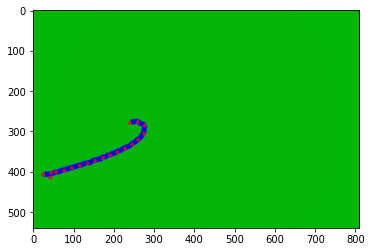

---- optimize translation ----
tensor([ 2.3950e+02,  2.6153e+02,  1.2080e-01, -5.1869e-01, -1.6910e+00,
        -2.3040e+00, -2.4867e+00, -2.6597e+00, -2.6763e+00, -2.7725e+00,
        -2.7495e+00, -2.8030e+00, -2.7886e+00, -2.8787e+00, -2.8474e+00,
        -2.8257e+00, -2.9540e+00, -2.3478e+00, -3.5913e+00, -6.0838e+00],
       device='cuda:0')
tensor(261.9761, device='cuda:0')
tensor([ 2.3947e+02,  2.6152e+02,  1.2080e-01, -5.1869e-01, -1.6910e+00,
        -2.3040e+00, -2.4867e+00, -2.6597e+00, -2.6763e+00, -2.7725e+00,
        -2.7495e+00, -2.8030e+00, -2.7886e+00, -2.8787e+00, -2.8474e+00,
        -2.8257e+00, -2.9540e+00, -2.3478e+00, -3.5913e+00, -6.0838e+00],
       device='cuda:0')
tensor(261.9743, device='cuda:0')
tensor([ 2.3950e+02,  2.6152e+02,  1.2080e-01, -5.1869e-01, -1.6910e+00,
        -2.3040e+00, -2.4867e+00, -2.6597e+00, -2.6763e+00, -2.7725e+00,
        -2.7495e+00, -2.8030e+00, -2.7886e+00, -2.8787e+00, -2.8474e+00,
        -2.8257e+00, -2.9540e+00, -2.3478e+00, -

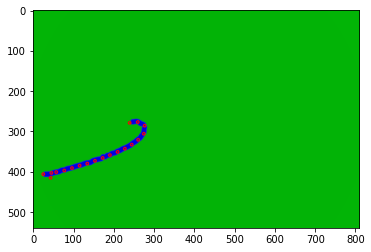

---- optimize translation ----
tensor([ 2.3946e+02,  2.6152e+02,  1.2143e-01, -5.1598e-01, -1.6884e+00,
        -2.3037e+00, -2.4974e+00, -2.6365e+00, -2.7111e+00, -2.7442e+00,
        -2.7564e+00, -2.8026e+00, -2.7875e+00, -2.8763e+00, -2.8493e+00,
        -2.8275e+00, -2.9471e+00, -2.3546e+00, -3.5944e+00, -6.0831e+00],
       device='cuda:0')
tensor(260.9494, device='cuda:0')
tensor([ 2.3946e+02,  2.6152e+02,  1.2143e-01, -5.1598e-01, -1.6884e+00,
        -2.3037e+00, -2.4974e+00, -2.6365e+00, -2.7111e+00, -2.7442e+00,
        -2.7564e+00, -2.8026e+00, -2.7875e+00, -2.8763e+00, -2.8493e+00,
        -2.8275e+00, -2.9471e+00, -2.3546e+00, -3.5944e+00, -6.0831e+00],
       device='cuda:0')
tensor(260.9487, device='cuda:0')
tensor([ 2.3946e+02,  2.6152e+02,  1.2143e-01, -5.1598e-01, -1.6884e+00,
        -2.3037e+00, -2.4974e+00, -2.6365e+00, -2.7111e+00, -2.7442e+00,
        -2.7564e+00, -2.8026e+00, -2.7875e+00, -2.8763e+00, -2.8493e+00,
        -2.8275e+00, -2.9471e+00, -2.3546e+00, -

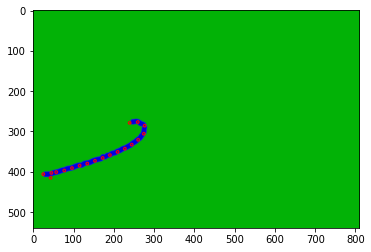

---- optimize translation ----
tensor([ 2.3949e+02,  2.6153e+02,  1.2054e-01, -5.1787e-01, -1.6912e+00,
        -2.3052e+00, -2.4996e+00, -2.6355e+00, -2.7123e+00, -2.7404e+00,
        -2.7594e+00, -2.7948e+00, -2.8002e+00, -2.8702e+00, -2.8433e+00,
        -2.8393e+00, -2.9366e+00, -2.3546e+00, -3.6023e+00, -6.0893e+00],
       device='cuda:0')
tensor(261.8673, device='cuda:0')
tensor([ 2.3950e+02,  2.6153e+02,  1.2054e-01, -5.1787e-01, -1.6912e+00,
        -2.3052e+00, -2.4996e+00, -2.6355e+00, -2.7123e+00, -2.7404e+00,
        -2.7594e+00, -2.7948e+00, -2.8002e+00, -2.8702e+00, -2.8433e+00,
        -2.8393e+00, -2.9366e+00, -2.3546e+00, -3.6023e+00, -6.0893e+00],
       device='cuda:0')
tensor(261.8672, device='cuda:0')
tensor([ 2.3950e+02,  2.6153e+02,  1.2054e-01, -5.1787e-01, -1.6912e+00,
        -2.3052e+00, -2.4996e+00, -2.6355e+00, -2.7123e+00, -2.7404e+00,
        -2.7594e+00, -2.7948e+00, -2.8002e+00, -2.8702e+00, -2.8433e+00,
        -2.8393e+00, -2.9366e+00, -2.3546e+00, -

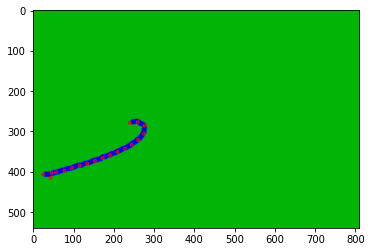

---- optimize translation ----
tensor([ 2.3947e+02,  2.6153e+02,  1.1952e-01, -5.1447e-01, -1.6940e+00,
        -2.2984e+00, -2.5061e+00, -2.6294e+00, -2.7160e+00, -2.7380e+00,
        -2.7626e+00, -2.7958e+00, -2.7970e+00, -2.8760e+00, -2.8325e+00,
        -2.8481e+00, -2.9407e+00, -2.3436e+00, -3.5932e+00, -6.0770e+00],
       device='cuda:0')
tensor(260.8344, device='cuda:0')
tensor([ 2.3950e+02,  2.6155e+02,  1.1952e-01, -5.1447e-01, -1.6940e+00,
        -2.2984e+00, -2.5061e+00, -2.6294e+00, -2.7160e+00, -2.7380e+00,
        -2.7626e+00, -2.7958e+00, -2.7970e+00, -2.8760e+00, -2.8325e+00,
        -2.8481e+00, -2.9407e+00, -2.3436e+00, -3.5932e+00, -6.0770e+00],
       device='cuda:0')
tensor(260.8348, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3947e+02,  2.6153e+02,  1.1952e-01, -5.1447e-01, -1.6940e+00,
        -2.2984e+00, -2.5061e+00, -2.6294e+00, -2.7160e+00, -2.7380e+00,
        -2.7626e+00, -2.7958e+00, -2.7970e+00, -2.8760e+00, -2.8325e+00,
        -2.8481e+00,

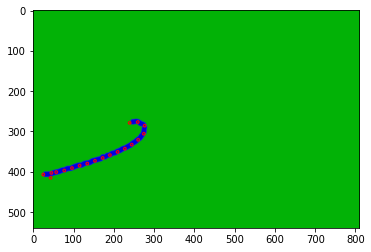

---- optimize translation ----
tensor([ 2.3949e+02,  2.6155e+02,  1.1803e-01, -5.1414e-01, -1.6918e+00,
        -2.3037e+00, -2.5034e+00, -2.6314e+00, -2.7141e+00, -2.7355e+00,
        -2.7701e+00, -2.7860e+00, -2.8010e+00, -2.8784e+00, -2.8273e+00,
        -2.8510e+00, -2.9393e+00, -2.3455e+00, -3.5944e+00, -6.0827e+00],
       device='cuda:0')
tensor(262.1525, device='cuda:0')
tensor([ 2.3945e+02,  2.6154e+02,  1.1803e-01, -5.1414e-01, -1.6918e+00,
        -2.3037e+00, -2.5034e+00, -2.6314e+00, -2.7141e+00, -2.7355e+00,
        -2.7701e+00, -2.7860e+00, -2.8010e+00, -2.8784e+00, -2.8273e+00,
        -2.8510e+00, -2.9393e+00, -2.3455e+00, -3.5944e+00, -6.0827e+00],
       device='cuda:0')
tensor(262.1518, device='cuda:0')
tensor([ 2.3946e+02,  2.6154e+02,  1.1803e-01, -5.1414e-01, -1.6918e+00,
        -2.3037e+00, -2.5034e+00, -2.6314e+00, -2.7141e+00, -2.7355e+00,
        -2.7701e+00, -2.7860e+00, -2.8010e+00, -2.8784e+00, -2.8273e+00,
        -2.8510e+00, -2.9393e+00, -2.3455e+00, -

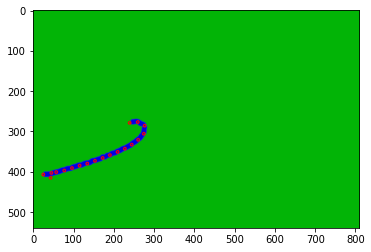

---- optimize translation ----
tensor([ 2.3946e+02,  2.6154e+02,  1.1867e-01, -5.1230e-01, -1.6953e+00,
        -2.2972e+00, -2.5069e+00, -2.6279e+00, -2.7175e+00, -2.7323e+00,
        -2.7735e+00, -2.7841e+00, -2.8022e+00, -2.8805e+00, -2.8298e+00,
        -2.8422e+00, -2.9435e+00, -2.3467e+00, -3.5919e+00, -6.0796e+00],
       device='cuda:0')
tensor(261.0057, device='cuda:0')
tensor([ 2.3950e+02,  2.6154e+02,  1.1867e-01, -5.1230e-01, -1.6953e+00,
        -2.2972e+00, -2.5069e+00, -2.6279e+00, -2.7175e+00, -2.7323e+00,
        -2.7735e+00, -2.7841e+00, -2.8022e+00, -2.8805e+00, -2.8298e+00,
        -2.8422e+00, -2.9435e+00, -2.3467e+00, -3.5919e+00, -6.0796e+00],
       device='cuda:0')
tensor(261.0100, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3946e+02,  2.6154e+02,  1.1867e-01, -5.1230e-01, -1.6953e+00,
        -2.2972e+00, -2.5069e+00, -2.6279e+00, -2.7175e+00, -2.7323e+00,
        -2.7735e+00, -2.7841e+00, -2.8022e+00, -2.8805e+00, -2.8298e+00,
        -2.8422e+00,

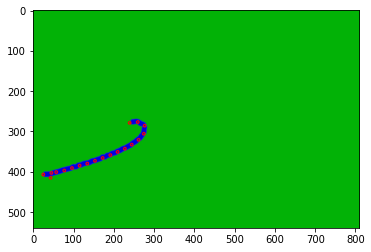

---- optimize translation ----
tensor([ 2.3945e+02,  2.6153e+02,  1.1993e-01, -5.0812e-01, -1.6932e+00,
        -2.2984e+00, -2.5020e+00, -2.6335e+00, -2.7138e+00, -2.7278e+00,
        -2.7852e+00, -2.7647e+00, -2.8318e+00, -2.8683e+00, -2.8178e+00,
        -2.8373e+00, -2.9648e+00, -2.3377e+00, -3.5830e+00, -6.0758e+00],
       device='cuda:0')
tensor(262.1187, device='cuda:0')
tensor([ 2.3940e+02,  2.6153e+02,  1.1993e-01, -5.0812e-01, -1.6932e+00,
        -2.2984e+00, -2.5020e+00, -2.6335e+00, -2.7138e+00, -2.7278e+00,
        -2.7852e+00, -2.7647e+00, -2.8318e+00, -2.8683e+00, -2.8178e+00,
        -2.8373e+00, -2.9648e+00, -2.3377e+00, -3.5830e+00, -6.0758e+00],
       device='cuda:0')
tensor(262.1181, device='cuda:0')
tensor([ 2.3941e+02,  2.6153e+02,  1.1993e-01, -5.0812e-01, -1.6932e+00,
        -2.2984e+00, -2.5020e+00, -2.6335e+00, -2.7138e+00, -2.7278e+00,
        -2.7852e+00, -2.7647e+00, -2.8318e+00, -2.8683e+00, -2.8178e+00,
        -2.8373e+00, -2.9648e+00, -2.3377e+00, -

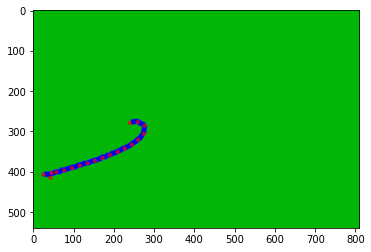

---- optimize translation ----
tensor([ 2.3950e+02,  2.6155e+02,  1.1788e-01, -5.1476e-01, -1.6979e+00,
        -2.3005e+00, -2.5043e+00, -2.6315e+00, -2.7146e+00, -2.7297e+00,
        -2.7835e+00, -2.7659e+00, -2.8373e+00, -2.8562e+00, -2.8347e+00,
        -2.8253e+00, -2.9563e+00, -2.3441e+00, -3.5953e+00, -6.0806e+00],
       device='cuda:0')
tensor(262.3105, device='cuda:0')
tensor([ 2.3943e+02,  2.6152e+02,  1.1788e-01, -5.1476e-01, -1.6979e+00,
        -2.3005e+00, -2.5043e+00, -2.6315e+00, -2.7146e+00, -2.7297e+00,
        -2.7835e+00, -2.7659e+00, -2.8373e+00, -2.8562e+00, -2.8347e+00,
        -2.8253e+00, -2.9563e+00, -2.3441e+00, -3.5953e+00, -6.0806e+00],
       device='cuda:0')
tensor(262.3235, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3950e+02,  2.6155e+02,  1.1788e-01, -5.1476e-01, -1.6979e+00,
        -2.3005e+00, -2.5043e+00, -2.6315e+00, -2.7146e+00, -2.7297e+00,
        -2.7835e+00, -2.7659e+00, -2.8373e+00, -2.8562e+00, -2.8347e+00,
        -2.8253e+00,

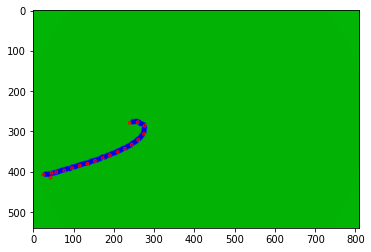

---- optimize translation ----
tensor([ 2.3943e+02,  2.6150e+02,  1.2257e-01, -5.0951e-01, -1.6914e+00,
        -2.3033e+00, -2.4967e+00, -2.6374e+00, -2.7116e+00, -2.7280e+00,
        -2.7820e+00, -2.7697e+00, -2.8275e+00, -2.8736e+00, -2.8243e+00,
        -2.8283e+00, -2.9456e+00, -2.3534e+00, -3.5963e+00, -6.0803e+00],
       device='cuda:0')
tensor(262.0748, device='cuda:0')
tensor([ 2.3939e+02,  2.6148e+02,  1.2257e-01, -5.0951e-01, -1.6914e+00,
        -2.3033e+00, -2.4967e+00, -2.6374e+00, -2.7116e+00, -2.7280e+00,
        -2.7820e+00, -2.7697e+00, -2.8275e+00, -2.8736e+00, -2.8243e+00,
        -2.8283e+00, -2.9456e+00, -2.3534e+00, -3.5963e+00, -6.0803e+00],
       device='cuda:0')
tensor(262.0758, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3943e+02,  2.6150e+02,  1.2257e-01, -5.0951e-01, -1.6914e+00,
        -2.3033e+00, -2.4967e+00, -2.6374e+00, -2.7116e+00, -2.7280e+00,
        -2.7820e+00, -2.7697e+00, -2.8275e+00, -2.8736e+00, -2.8243e+00,
        -2.8283e+00,

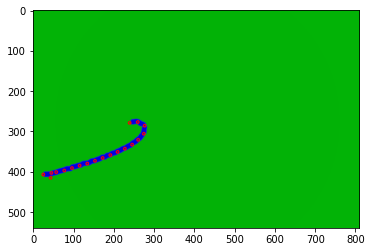

---- optimize translation ----
tensor([ 2.3938e+02,  2.6146e+02,  1.2588e-01, -5.0998e-01, -1.6849e+00,
        -2.3100e+00, -2.4917e+00, -2.6380e+00, -2.7110e+00, -2.7271e+00,
        -2.7826e+00, -2.7751e+00, -2.8238e+00, -2.8730e+00, -2.8277e+00,
        -2.8208e+00, -2.9560e+00, -2.3510e+00, -3.5861e+00, -6.0813e+00],
       device='cuda:0')
tensor(261.2376, device='cuda:0')
tensor([ 2.3942e+02,  2.6148e+02,  1.2588e-01, -5.0998e-01, -1.6849e+00,
        -2.3100e+00, -2.4917e+00, -2.6380e+00, -2.7110e+00, -2.7271e+00,
        -2.7826e+00, -2.7751e+00, -2.8238e+00, -2.8730e+00, -2.8277e+00,
        -2.8208e+00, -2.9560e+00, -2.3510e+00, -3.5861e+00, -6.0813e+00],
       device='cuda:0')
tensor(261.2392, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3938e+02,  2.6146e+02,  1.2588e-01, -5.0998e-01, -1.6849e+00,
        -2.3100e+00, -2.4917e+00, -2.6380e+00, -2.7110e+00, -2.7271e+00,
        -2.7826e+00, -2.7751e+00, -2.8238e+00, -2.8730e+00, -2.8277e+00,
        -2.8208e+00,

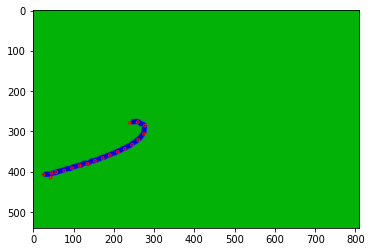

---- optimize translation ----
tensor([ 2.3942e+02,  2.6149e+02,  1.2375e-01, -5.0990e-01, -1.6870e+00,
        -2.3108e+00, -2.4910e+00, -2.6393e+00, -2.7099e+00, -2.7311e+00,
        -2.7797e+00, -2.7775e+00, -2.8192e+00, -2.8756e+00, -2.8231e+00,
        -2.8247e+00, -2.9566e+00, -2.3475e+00, -3.5851e+00, -6.0780e+00],
       device='cuda:0')
tensor(262.3335, device='cuda:0')
tensor([ 2.3938e+02,  2.6147e+02,  1.2375e-01, -5.0990e-01, -1.6870e+00,
        -2.3108e+00, -2.4910e+00, -2.6393e+00, -2.7099e+00, -2.7311e+00,
        -2.7797e+00, -2.7775e+00, -2.8192e+00, -2.8756e+00, -2.8231e+00,
        -2.8247e+00, -2.9566e+00, -2.3475e+00, -3.5851e+00, -6.0780e+00],
       device='cuda:0')
tensor(262.3336, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3942e+02,  2.6149e+02,  1.2375e-01, -5.0990e-01, -1.6870e+00,
        -2.3108e+00, -2.4910e+00, -2.6393e+00, -2.7099e+00, -2.7311e+00,
        -2.7797e+00, -2.7775e+00, -2.8192e+00, -2.8756e+00, -2.8231e+00,
        -2.8247e+00,

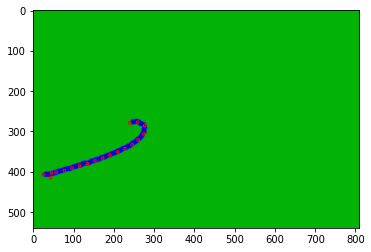

---- optimize translation ----
tensor([ 2.3935e+02,  2.6147e+02,  1.2478e-01, -5.0543e-01, -1.6882e+00,
        -2.3047e+00, -2.4921e+00, -2.6396e+00, -2.7074e+00, -2.7381e+00,
        -2.7610e+00, -2.8111e+00, -2.7826e+00, -2.9015e+00, -2.8006e+00,
        -2.8413e+00, -2.9507e+00, -2.3527e+00, -3.5839e+00, -6.0797e+00],
       device='cuda:0')
tensor(261.3448, device='cuda:0')
tensor([ 2.3931e+02,  2.6146e+02,  1.2478e-01, -5.0543e-01, -1.6882e+00,
        -2.3047e+00, -2.4921e+00, -2.6396e+00, -2.7074e+00, -2.7381e+00,
        -2.7610e+00, -2.8111e+00, -2.7826e+00, -2.9015e+00, -2.8006e+00,
        -2.8413e+00, -2.9507e+00, -2.3527e+00, -3.5839e+00, -6.0797e+00],
       device='cuda:0')
tensor(261.3467, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3935e+02,  2.6147e+02,  1.2478e-01, -5.0543e-01, -1.6882e+00,
        -2.3047e+00, -2.4921e+00, -2.6396e+00, -2.7074e+00, -2.7381e+00,
        -2.7610e+00, -2.8111e+00, -2.7826e+00, -2.9015e+00, -2.8006e+00,
        -2.8413e+00,

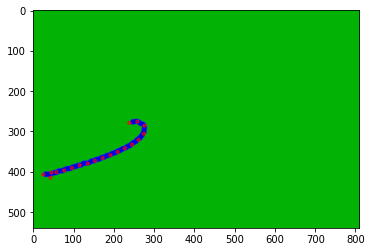

---- optimize translation ----
tensor([ 2.3895e+02,  2.6132e+02,  1.3438e-01, -4.8331e-01, -1.6645e+00,
        -2.2981e+00, -2.4905e+00, -2.6344e+00, -2.7078e+00, -2.7390e+00,
        -2.7568e+00, -2.8197e+00, -2.7708e+00, -2.9070e+00, -2.8045e+00,
        -2.8299e+00, -2.9617e+00, -2.3630e+00, -3.5530e+00, -6.0644e+00],
       device='cuda:0')
tensor(262.6687, device='cuda:0')
tensor([ 2.3883e+02,  2.6132e+02,  1.3438e-01, -4.8331e-01, -1.6645e+00,
        -2.2981e+00, -2.4905e+00, -2.6344e+00, -2.7078e+00, -2.7390e+00,
        -2.7568e+00, -2.8197e+00, -2.7708e+00, -2.9070e+00, -2.8045e+00,
        -2.8299e+00, -2.9617e+00, -2.3630e+00, -3.5530e+00, -6.0644e+00],
       device='cuda:0')
tensor(262.6973, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3895e+02,  2.6132e+02,  1.3438e-01, -4.8331e-01, -1.6645e+00,
        -2.2981e+00, -2.4905e+00, -2.6344e+00, -2.7078e+00, -2.7390e+00,
        -2.7568e+00, -2.8197e+00, -2.7708e+00, -2.9070e+00, -2.8045e+00,
        -2.8299e+00,

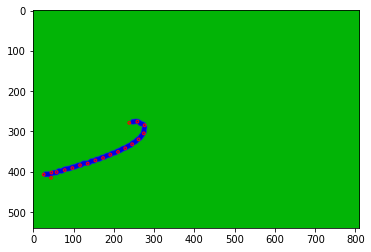

---- optimize translation ----
tensor([ 2.3834e+02,  2.6111e+02,  1.4618e-01, -4.4949e-01, -1.6287e+00,
        -2.2869e+00, -2.4911e+00, -2.6255e+00, -2.7059e+00, -2.7417e+00,
        -2.7516e+00, -2.8241e+00, -2.7632e+00, -2.9179e+00, -2.7845e+00,
        -2.8740e+00, -2.9030e+00, -2.3746e+00, -3.5621e+00, -6.0591e+00],
       device='cuda:0')
tensor(262.3734, device='cuda:0')
tensor([ 2.3834e+02,  2.6111e+02,  1.4618e-01, -4.4949e-01, -1.6287e+00,
        -2.2869e+00, -2.4911e+00, -2.6255e+00, -2.7059e+00, -2.7417e+00,
        -2.7516e+00, -2.8241e+00, -2.7632e+00, -2.9179e+00, -2.7845e+00,
        -2.8740e+00, -2.9030e+00, -2.3746e+00, -3.5621e+00, -6.0591e+00],
       device='cuda:0')
tensor(262.3737, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3834e+02,  2.6111e+02,  1.4618e-01, -4.4949e-01, -1.6287e+00,
        -2.2869e+00, -2.4911e+00, -2.6255e+00, -2.7059e+00, -2.7417e+00,
        -2.7516e+00, -2.8241e+00, -2.7632e+00, -2.9179e+00, -2.7845e+00,
        -2.8740e+00,

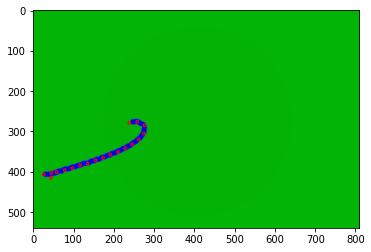

---- optimize translation ----
tensor([ 2.3838e+02,  2.6112e+02,  1.4590e-01, -4.5173e-01, -1.6309e+00,
        -2.2875e+00, -2.4913e+00, -2.6258e+00, -2.7062e+00, -2.7411e+00,
        -2.7532e+00, -2.8205e+00, -2.7672e+00, -2.9148e+00, -2.7883e+00,
        -2.8778e+00, -2.8985e+00, -2.3807e+00, -3.5533e+00, -6.0655e+00],
       device='cuda:0')
tensor(261.9464, device='cuda:0')
tensor([ 2.3845e+02,  2.6114e+02,  1.4590e-01, -4.5173e-01, -1.6309e+00,
        -2.2875e+00, -2.4913e+00, -2.6258e+00, -2.7062e+00, -2.7411e+00,
        -2.7532e+00, -2.8205e+00, -2.7672e+00, -2.9148e+00, -2.7883e+00,
        -2.8778e+00, -2.8985e+00, -2.3807e+00, -3.5533e+00, -6.0655e+00],
       device='cuda:0')
tensor(261.9592, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3838e+02,  2.6112e+02,  1.4590e-01, -4.5173e-01, -1.6309e+00,
        -2.2875e+00, -2.4913e+00, -2.6258e+00, -2.7062e+00, -2.7411e+00,
        -2.7532e+00, -2.8205e+00, -2.7672e+00, -2.9148e+00, -2.7883e+00,
        -2.8778e+00,

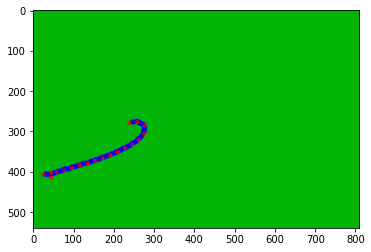

---- optimize translation ----
tensor([ 2.3882e+02,  2.6132e+02,  1.3338e-01, -4.7694e-01, -1.6587e+00,
        -2.2961e+00, -2.4929e+00, -2.6317e+00, -2.7055e+00, -2.7415e+00,
        -2.7566e+00, -2.8165e+00, -2.7781e+00, -2.9029e+00, -2.8008e+00,
        -2.8647e+00, -2.9157e+00, -2.3596e+00, -3.5658e+00, -6.0814e+00],
       device='cuda:0')
tensor(262.9457, device='cuda:0')
tensor([ 2.3875e+02,  2.6130e+02,  1.3338e-01, -4.7694e-01, -1.6587e+00,
        -2.2961e+00, -2.4929e+00, -2.6317e+00, -2.7055e+00, -2.7415e+00,
        -2.7566e+00, -2.8165e+00, -2.7781e+00, -2.9029e+00, -2.8008e+00,
        -2.8647e+00, -2.9157e+00, -2.3596e+00, -3.5658e+00, -6.0814e+00],
       device='cuda:0')
tensor(262.9574, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3882e+02,  2.6132e+02,  1.3338e-01, -4.7694e-01, -1.6587e+00,
        -2.2961e+00, -2.4929e+00, -2.6317e+00, -2.7055e+00, -2.7415e+00,
        -2.7566e+00, -2.8165e+00, -2.7781e+00, -2.9029e+00, -2.8008e+00,
        -2.8647e+00,

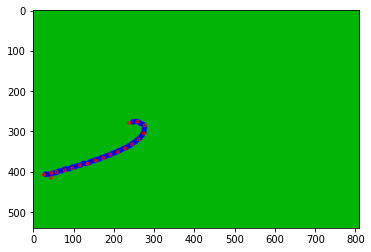

---- optimize translation ----
tensor([ 2.3844e+02,  2.6116e+02,  1.4365e-01, -4.5462e-01, -1.6348e+00,
        -2.2887e+00, -2.4910e+00, -2.6272e+00, -2.7048e+00, -2.7440e+00,
        -2.7470e+00, -2.8357e+00, -2.7502e+00, -2.9217e+00, -2.7892e+00,
        -2.8788e+00, -2.9021e+00, -2.3742e+00, -3.5500e+00, -6.0614e+00],
       device='cuda:0')
tensor(262.8345, device='cuda:0')
tensor([ 2.3851e+02,  2.6117e+02,  1.4365e-01, -4.5462e-01, -1.6348e+00,
        -2.2887e+00, -2.4910e+00, -2.6272e+00, -2.7048e+00, -2.7440e+00,
        -2.7470e+00, -2.8357e+00, -2.7502e+00, -2.9217e+00, -2.7892e+00,
        -2.8788e+00, -2.9021e+00, -2.3742e+00, -3.5500e+00, -6.0614e+00],
       device='cuda:0')
tensor(262.8431, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3844e+02,  2.6116e+02,  1.4365e-01, -4.5462e-01, -1.6348e+00,
        -2.2887e+00, -2.4910e+00, -2.6272e+00, -2.7048e+00, -2.7440e+00,
        -2.7470e+00, -2.8357e+00, -2.7502e+00, -2.9217e+00, -2.7892e+00,
        -2.8788e+00,

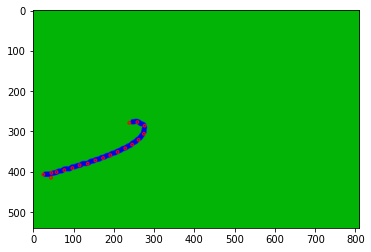

---- optimize translation ----
tensor([ 2.3871e+02,  2.6128e+02,  1.3550e-01, -4.6977e-01, -1.6523e+00,
        -2.2938e+00, -2.4926e+00, -2.6295e+00, -2.7081e+00, -2.7407e+00,
        -2.7497e+00, -2.8336e+00, -2.7532e+00, -2.9240e+00, -2.7816e+00,
        -2.8904e+00, -2.8842e+00, -2.3786e+00, -3.5719e+00, -6.0793e+00],
       device='cuda:0')
tensor(261.3693, device='cuda:0')
tensor([ 2.3878e+02,  2.6131e+02,  1.3550e-01, -4.6977e-01, -1.6523e+00,
        -2.2938e+00, -2.4926e+00, -2.6295e+00, -2.7081e+00, -2.7407e+00,
        -2.7497e+00, -2.8336e+00, -2.7532e+00, -2.9240e+00, -2.7816e+00,
        -2.8904e+00, -2.8842e+00, -2.3786e+00, -3.5719e+00, -6.0793e+00],
       device='cuda:0')
tensor(261.3752, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3871e+02,  2.6128e+02,  1.3550e-01, -4.6977e-01, -1.6523e+00,
        -2.2938e+00, -2.4926e+00, -2.6295e+00, -2.7081e+00, -2.7407e+00,
        -2.7497e+00, -2.8336e+00, -2.7532e+00, -2.9240e+00, -2.7816e+00,
        -2.8904e+00,

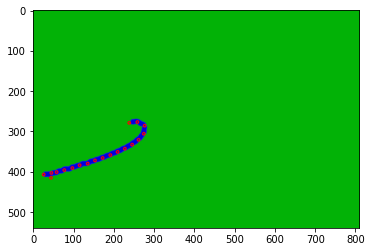

---- optimize translation ----
tensor([ 2.3894e+02,  2.6142e+02,  1.2469e-01, -4.7550e-01, -1.6728e+00,
        -2.2954e+00, -2.5014e+00, -2.6215e+00, -2.7057e+00, -2.7457e+00,
        -2.7490e+00, -2.8378e+00, -2.7335e+00, -2.9560e+00, -2.7561e+00,
        -2.9043e+00, -2.8833e+00, -2.3675e+00, -3.5826e+00, -6.0754e+00],
       device='cuda:0')
tensor(263.2851, device='cuda:0')
tensor([ 2.3890e+02,  2.6143e+02,  1.2469e-01, -4.7550e-01, -1.6728e+00,
        -2.2954e+00, -2.5014e+00, -2.6215e+00, -2.7057e+00, -2.7457e+00,
        -2.7490e+00, -2.8378e+00, -2.7335e+00, -2.9560e+00, -2.7561e+00,
        -2.9043e+00, -2.8833e+00, -2.3675e+00, -3.5826e+00, -6.0754e+00],
       device='cuda:0')
tensor(263.2698, device='cuda:0')
tensor([ 2.3891e+02,  2.6143e+02,  1.2469e-01, -4.7550e-01, -1.6728e+00,
        -2.2954e+00, -2.5014e+00, -2.6215e+00, -2.7057e+00, -2.7457e+00,
        -2.7490e+00, -2.8378e+00, -2.7335e+00, -2.9560e+00, -2.7561e+00,
        -2.9043e+00, -2.8833e+00, -2.3675e+00, -

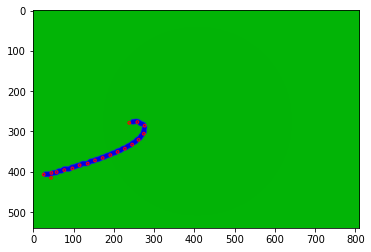

---- optimize translation ----
tensor([ 2.3895e+02,  2.6150e+02,  1.1676e-01, -4.6884e-01, -1.6876e+00,
        -2.2910e+00, -2.4993e+00, -2.6230e+00, -2.7102e+00, -2.7367e+00,
        -2.7540e+00, -2.8364e+00, -2.7304e+00, -2.9649e+00, -2.7423e+00,
        -2.9171e+00, -2.8747e+00, -2.3626e+00, -3.5947e+00, -6.0762e+00],
       device='cuda:0')
tensor(263.1460, device='cuda:0')
tensor([ 2.3903e+02,  2.6152e+02,  1.1676e-01, -4.6884e-01, -1.6876e+00,
        -2.2910e+00, -2.4993e+00, -2.6230e+00, -2.7102e+00, -2.7367e+00,
        -2.7540e+00, -2.8364e+00, -2.7304e+00, -2.9649e+00, -2.7423e+00,
        -2.9171e+00, -2.8747e+00, -2.3626e+00, -3.5947e+00, -6.0762e+00],
       device='cuda:0')
tensor(263.1674, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3895e+02,  2.6150e+02,  1.1676e-01, -4.6884e-01, -1.6876e+00,
        -2.2910e+00, -2.4993e+00, -2.6230e+00, -2.7102e+00, -2.7367e+00,
        -2.7540e+00, -2.8364e+00, -2.7304e+00, -2.9649e+00, -2.7423e+00,
        -2.9171e+00,

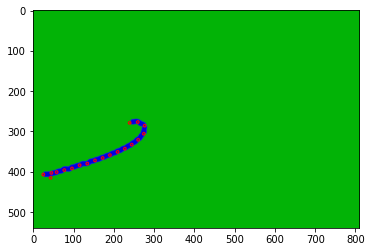

---- optimize translation ----
tensor([ 2.3915e+02,  2.6158e+02,  1.1016e-01, -4.7625e-01, -1.7093e+00,
        -2.2858e+00, -2.5067e+00, -2.6162e+00, -2.7141e+00, -2.7360e+00,
        -2.7546e+00, -2.8380e+00, -2.7337e+00, -2.9616e+00, -2.7379e+00,
        -2.9277e+00, -2.8638e+00, -2.3688e+00, -3.6047e+00, -6.0910e+00],
       device='cuda:0')
tensor(263.1684, device='cuda:0')
tensor([ 2.3910e+02,  2.6158e+02,  1.1016e-01, -4.7625e-01, -1.7093e+00,
        -2.2858e+00, -2.5067e+00, -2.6162e+00, -2.7141e+00, -2.7360e+00,
        -2.7546e+00, -2.8380e+00, -2.7337e+00, -2.9616e+00, -2.7379e+00,
        -2.9277e+00, -2.8638e+00, -2.3688e+00, -3.6047e+00, -6.0910e+00],
       device='cuda:0')
tensor(263.1665, device='cuda:0')
tensor([ 2.3919e+02,  2.6159e+02,  1.1016e-01, -4.7625e-01, -1.7093e+00,
        -2.2858e+00, -2.5067e+00, -2.6162e+00, -2.7141e+00, -2.7360e+00,
        -2.7546e+00, -2.8380e+00, -2.7337e+00, -2.9616e+00, -2.7379e+00,
        -2.9277e+00, -2.8638e+00, -2.3688e+00, -

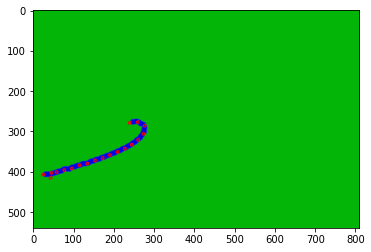

---- optimize translation ----
tensor([ 2.3920e+02,  2.6160e+02,  1.0905e-01, -4.7939e-01, -1.7139e+00,
        -2.2857e+00, -2.5066e+00, -2.6187e+00, -2.7175e+00, -2.7336e+00,
        -2.7556e+00, -2.8364e+00, -2.7311e+00, -2.9626e+00, -2.7391e+00,
        -2.9266e+00, -2.8666e+00, -2.3714e+00, -3.5914e+00, -6.0937e+00],
       device='cuda:0')
tensor(262.4453, device='cuda:0')
tensor([ 2.3915e+02,  2.6159e+02,  1.0905e-01, -4.7939e-01, -1.7139e+00,
        -2.2857e+00, -2.5066e+00, -2.6187e+00, -2.7175e+00, -2.7336e+00,
        -2.7556e+00, -2.8364e+00, -2.7311e+00, -2.9626e+00, -2.7391e+00,
        -2.9266e+00, -2.8666e+00, -2.3714e+00, -3.5914e+00, -6.0937e+00],
       device='cuda:0')
tensor(262.4470, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3920e+02,  2.6160e+02,  1.0905e-01, -4.7939e-01, -1.7139e+00,
        -2.2857e+00, -2.5066e+00, -2.6187e+00, -2.7175e+00, -2.7336e+00,
        -2.7556e+00, -2.8364e+00, -2.7311e+00, -2.9626e+00, -2.7391e+00,
        -2.9266e+00,

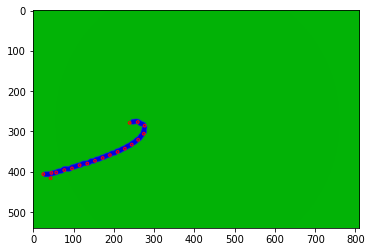

---- optimize translation ----
tensor([ 2.3919e+02,  2.6159e+02,  1.1017e-01, -4.8011e-01, -1.7115e+00,
        -2.2835e+00, -2.5197e+00, -2.6089e+00, -2.7117e+00, -2.7489e+00,
        -2.7561e+00, -2.8099e+00, -2.7819e+00, -2.9158e+00, -2.7516e+00,
        -2.9322e+00, -2.8556e+00, -2.3740e+00, -3.6111e+00, -6.1039e+00],
       device='cuda:0')
tensor(263.3755, device='cuda:0')
tensor([ 2.3901e+02,  2.6162e+02,  1.1017e-01, -4.8011e-01, -1.7115e+00,
        -2.2835e+00, -2.5197e+00, -2.6089e+00, -2.7117e+00, -2.7489e+00,
        -2.7561e+00, -2.8099e+00, -2.7819e+00, -2.9158e+00, -2.7516e+00,
        -2.9322e+00, -2.8556e+00, -2.3740e+00, -3.6111e+00, -6.1039e+00],
       device='cuda:0')
tensor(263.2207, device='cuda:0')
tensor([ 2.3910e+02,  2.6163e+02,  1.1017e-01, -4.8011e-01, -1.7115e+00,
        -2.2835e+00, -2.5197e+00, -2.6089e+00, -2.7117e+00, -2.7489e+00,
        -2.7561e+00, -2.8099e+00, -2.7819e+00, -2.9158e+00, -2.7516e+00,
        -2.9322e+00, -2.8556e+00, -2.3740e+00, -

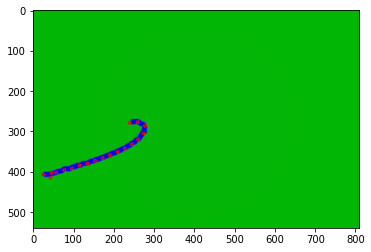

---- optimize translation ----
tensor([ 2.3913e+02,  2.6177e+02,  9.0722e-02, -4.4752e-01, -1.7323e+00,
        -2.2970e+00, -2.5097e+00, -2.5918e+00, -2.7073e+00, -2.7480e+00,
        -2.7553e+00, -2.8047e+00, -2.7937e+00, -2.9008e+00, -2.7623e+00,
        -2.9238e+00, -2.8628e+00, -2.3782e+00, -3.6009e+00, -6.1002e+00],
       device='cuda:0')
tensor(263.9014, device='cuda:0')
tensor([ 2.3899e+02,  2.6178e+02,  9.0722e-02, -4.4752e-01, -1.7323e+00,
        -2.2970e+00, -2.5097e+00, -2.5918e+00, -2.7073e+00, -2.7480e+00,
        -2.7553e+00, -2.8047e+00, -2.7937e+00, -2.9008e+00, -2.7623e+00,
        -2.9238e+00, -2.8628e+00, -2.3782e+00, -3.6009e+00, -6.1002e+00],
       device='cuda:0')
tensor(263.8479, device='cuda:0')
tensor([ 2.3903e+02,  2.6178e+02,  9.0722e-02, -4.4752e-01, -1.7323e+00,
        -2.2970e+00, -2.5097e+00, -2.5918e+00, -2.7073e+00, -2.7480e+00,
        -2.7553e+00, -2.8047e+00, -2.7937e+00, -2.9008e+00, -2.7623e+00,
        -2.9238e+00, -2.8628e+00, -2.3782e+00, -

tensor([ 2.3717e+02,  2.6073e+02,  1.6466e-01, -3.7485e-01, -1.5561e+00,
        -2.3770e+00, -2.4143e+00, -2.6025e+00, -2.6857e+00, -2.7508e+00,
        -2.7381e+00, -2.8170e+00, -2.7775e+00, -2.9076e+00, -2.7773e+00,
        -2.8759e+00, -2.9133e+00, -2.4157e+00, -3.4685e+00, -6.0253e+00],
       device='cuda:0')
tensor(263.3507, device='cuda:0')
tensor([ 2.3716e+02,  2.6073e+02,  1.6496e-01, -3.7446e-01, -1.5554e+00,
        -2.3769e+00, -2.4142e+00, -2.6025e+00, -2.6857e+00, -2.7508e+00,
        -2.7381e+00, -2.8171e+00, -2.7775e+00, -2.9076e+00, -2.7774e+00,
        -2.8758e+00, -2.9135e+00, -2.4157e+00, -3.4681e+00, -6.0249e+00],
       device='cuda:0')
tensor(263.3507, device='cuda:0')


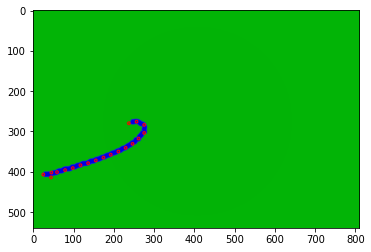

---- optimize translation ----
tensor([ 2.3717e+02,  2.6073e+02,  1.6466e-01, -3.7485e-01, -1.5561e+00,
        -2.3770e+00, -2.4143e+00, -2.6025e+00, -2.6857e+00, -2.7508e+00,
        -2.7381e+00, -2.8170e+00, -2.7775e+00, -2.9076e+00, -2.7773e+00,
        -2.8759e+00, -2.9133e+00, -2.4157e+00, -3.4685e+00, -6.0253e+00],
       device='cuda:0')
tensor(263.7679, device='cuda:0')
tensor([ 2.3717e+02,  2.6071e+02,  1.6466e-01, -3.7485e-01, -1.5561e+00,
        -2.3770e+00, -2.4143e+00, -2.6025e+00, -2.6857e+00, -2.7508e+00,
        -2.7381e+00, -2.8170e+00, -2.7775e+00, -2.9076e+00, -2.7773e+00,
        -2.8759e+00, -2.9133e+00, -2.4157e+00, -3.4685e+00, -6.0253e+00],
       device='cuda:0')
tensor(263.7779, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3717e+02,  2.6073e+02,  1.6466e-01, -3.7485e-01, -1.5561e+00,
        -2.3770e+00, -2.4143e+00, -2.6025e+00, -2.6857e+00, -2.7508e+00,
        -2.7381e+00, -2.8170e+00, -2.7775e+00, -2.9076e+00, -2.7773e+00,
        -2.8759e+00,

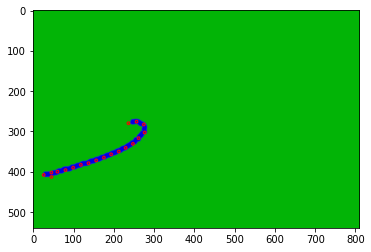

---- optimize translation ----
tensor([ 2.3659e+02,  2.6013e+02,  2.0825e-01, -3.7063e-01, -1.4845e+00,
        -2.4096e+00, -2.3745e+00, -2.6194e+00, -2.6680e+00, -2.7538e+00,
        -2.7456e+00, -2.8074e+00, -2.7769e+00, -2.9068e+00, -2.7779e+00,
        -2.8747e+00, -2.9179e+00, -2.4269e+00, -3.4238e+00, -6.0010e+00],
       device='cuda:0')
tensor(265.2364, device='cuda:0')
tensor([ 2.3673e+02,  2.6018e+02,  2.0825e-01, -3.7063e-01, -1.4845e+00,
        -2.4096e+00, -2.3745e+00, -2.6194e+00, -2.6680e+00, -2.7538e+00,
        -2.7456e+00, -2.8074e+00, -2.7769e+00, -2.9068e+00, -2.7779e+00,
        -2.8747e+00, -2.9179e+00, -2.4269e+00, -3.4238e+00, -6.0010e+00],
       device='cuda:0')
tensor(265.2817, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3659e+02,  2.6013e+02,  2.0825e-01, -3.7063e-01, -1.4845e+00,
        -2.4096e+00, -2.3745e+00, -2.6194e+00, -2.6680e+00, -2.7538e+00,
        -2.7456e+00, -2.8074e+00, -2.7769e+00, -2.9068e+00, -2.7779e+00,
        -2.8747e+00,

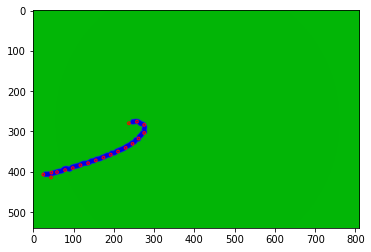

---- optimize translation ----
tensor([ 2.3735e+02,  2.6074e+02,  1.6687e-01, -3.9122e-01, -1.5622e+00,
        -2.3965e+00, -2.4066e+00, -2.6048e+00, -2.7052e+00, -2.7251e+00,
        -2.7539e+00, -2.8163e+00, -2.7607e+00, -2.9224e+00, -2.7539e+00,
        -2.9187e+00, -2.8650e+00, -2.4277e+00, -3.4983e+00, -6.0453e+00],
       device='cuda:0')
tensor(264.7849, device='cuda:0')
tensor([ 2.3737e+02,  2.6077e+02,  1.6687e-01, -3.9122e-01, -1.5622e+00,
        -2.3965e+00, -2.4066e+00, -2.6048e+00, -2.7052e+00, -2.7251e+00,
        -2.7539e+00, -2.8163e+00, -2.7607e+00, -2.9224e+00, -2.7539e+00,
        -2.9187e+00, -2.8650e+00, -2.4277e+00, -3.4983e+00, -6.0453e+00],
       device='cuda:0')
tensor(264.7830, device='cuda:0')
tensor([ 2.3739e+02,  2.6077e+02,  1.6687e-01, -3.9122e-01, -1.5622e+00,
        -2.3965e+00, -2.4066e+00, -2.6048e+00, -2.7052e+00, -2.7251e+00,
        -2.7539e+00, -2.8163e+00, -2.7607e+00, -2.9224e+00, -2.7539e+00,
        -2.9187e+00, -2.8650e+00, -2.4277e+00, -

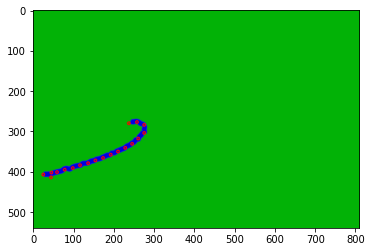

---- optimize translation ----
tensor([ 2.3757e+02,  2.6098e+02,  1.4805e-01, -3.9554e-01, -1.5864e+00,
        -2.3936e+00, -2.4133e+00, -2.6130e+00, -2.6995e+00, -2.7235e+00,
        -2.7535e+00, -2.8214e+00, -2.7686e+00, -2.9038e+00, -2.7513e+00,
        -2.9453e+00, -2.8380e+00, -2.4337e+00, -3.5263e+00, -6.0642e+00],
       device='cuda:0')
tensor(264.4418, device='cuda:0')
tensor([ 2.3756e+02,  2.6096e+02,  1.4805e-01, -3.9554e-01, -1.5864e+00,
        -2.3936e+00, -2.4133e+00, -2.6130e+00, -2.6995e+00, -2.7235e+00,
        -2.7535e+00, -2.8214e+00, -2.7686e+00, -2.9038e+00, -2.7513e+00,
        -2.9453e+00, -2.8380e+00, -2.4337e+00, -3.5263e+00, -6.0642e+00],
       device='cuda:0')
tensor(264.4551, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3757e+02,  2.6098e+02,  1.4805e-01, -3.9554e-01, -1.5864e+00,
        -2.3936e+00, -2.4133e+00, -2.6130e+00, -2.6995e+00, -2.7235e+00,
        -2.7535e+00, -2.8214e+00, -2.7686e+00, -2.9038e+00, -2.7513e+00,
        -2.9453e+00,

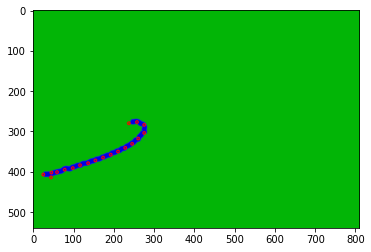

---- optimize translation ----
tensor([ 2.3755e+02,  2.6094e+02,  1.5226e-01, -3.9532e-01, -1.5831e+00,
        -2.3935e+00, -2.4172e+00, -2.6124e+00, -2.7025e+00, -2.7265e+00,
        -2.7475e+00, -2.8125e+00, -2.7737e+00, -2.9096e+00, -2.7420e+00,
        -2.9560e+00, -2.8298e+00, -2.4335e+00, -3.5196e+00, -6.0553e+00],
       device='cuda:0')
tensor(264.6201, device='cuda:0')
tensor([ 2.3748e+02,  2.6091e+02,  1.5226e-01, -3.9532e-01, -1.5831e+00,
        -2.3935e+00, -2.4172e+00, -2.6124e+00, -2.7025e+00, -2.7265e+00,
        -2.7475e+00, -2.8125e+00, -2.7737e+00, -2.9096e+00, -2.7420e+00,
        -2.9560e+00, -2.8298e+00, -2.4335e+00, -3.5196e+00, -6.0553e+00],
       device='cuda:0')
tensor(264.6212, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3755e+02,  2.6094e+02,  1.5226e-01, -3.9532e-01, -1.5831e+00,
        -2.3935e+00, -2.4172e+00, -2.6124e+00, -2.7025e+00, -2.7265e+00,
        -2.7475e+00, -2.8125e+00, -2.7737e+00, -2.9096e+00, -2.7420e+00,
        -2.9560e+00,

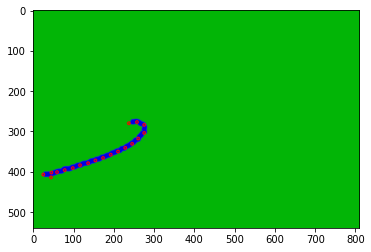

---- optimize translation ----
tensor([ 2.3759e+02,  2.6095e+02,  1.5177e-01, -3.9720e-01, -1.5858e+00,
        -2.3941e+00, -2.4146e+00, -2.6194e+00, -2.6988e+00, -2.7339e+00,
        -2.7315e+00, -2.8222e+00, -2.7846e+00, -2.8787e+00, -2.7840e+00,
        -2.8949e+00, -2.9027e+00, -2.4033e+00, -3.4988e+00, -6.0449e+00],
       device='cuda:0')
tensor(263.7825, device='cuda:0')
tensor([ 2.3752e+02,  2.6093e+02,  1.5177e-01, -3.9720e-01, -1.5858e+00,
        -2.3941e+00, -2.4146e+00, -2.6194e+00, -2.6988e+00, -2.7339e+00,
        -2.7315e+00, -2.8222e+00, -2.7846e+00, -2.8787e+00, -2.7840e+00,
        -2.8949e+00, -2.9027e+00, -2.4033e+00, -3.4988e+00, -6.0449e+00],
       device='cuda:0')
tensor(263.7821, device='cuda:0')
tensor([ 2.3758e+02,  2.6094e+02,  1.5177e-01, -3.9720e-01, -1.5858e+00,
        -2.3941e+00, -2.4146e+00, -2.6194e+00, -2.6988e+00, -2.7339e+00,
        -2.7315e+00, -2.8222e+00, -2.7846e+00, -2.8787e+00, -2.7840e+00,
        -2.8949e+00, -2.9027e+00, -2.4033e+00, -

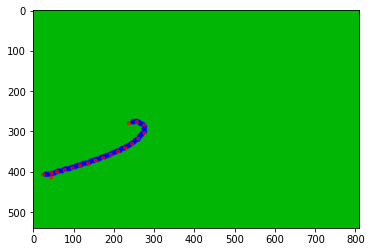

---- optimize translation ----
tensor([ 2.3758e+02,  2.6094e+02,  1.5199e-01, -3.9652e-01, -1.5849e+00,
        -2.3937e+00, -2.4178e+00, -2.6160e+00, -2.6996e+00, -2.7330e+00,
        -2.7334e+00, -2.8240e+00, -2.7756e+00, -2.8894e+00, -2.7875e+00,
        -2.8649e+00, -2.9476e+00, -2.3825e+00, -3.4752e+00, -6.0344e+00],
       device='cuda:0')
tensor(263.4917, device='cuda:0')
tensor([ 2.3756e+02,  2.6094e+02,  1.5199e-01, -3.9652e-01, -1.5849e+00,
        -2.3937e+00, -2.4178e+00, -2.6160e+00, -2.6996e+00, -2.7330e+00,
        -2.7334e+00, -2.8240e+00, -2.7756e+00, -2.8894e+00, -2.7875e+00,
        -2.8649e+00, -2.9476e+00, -2.3825e+00, -3.4752e+00, -6.0344e+00],
       device='cuda:0')
tensor(263.4914, device='cuda:0')
tensor([ 2.3756e+02,  2.6094e+02,  1.5199e-01, -3.9652e-01, -1.5849e+00,
        -2.3937e+00, -2.4178e+00, -2.6160e+00, -2.6996e+00, -2.7330e+00,
        -2.7334e+00, -2.8240e+00, -2.7756e+00, -2.8894e+00, -2.7875e+00,
        -2.8649e+00, -2.9476e+00, -2.3825e+00, -

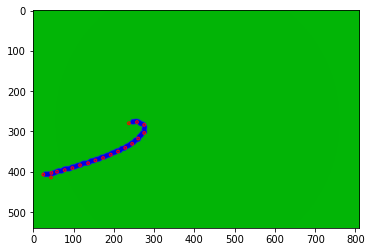

---- optimize translation ----
tensor([ 2.3757e+02,  2.6094e+02,  1.5183e-01, -3.9624e-01, -1.5851e+00,
        -2.3927e+00, -2.4208e+00, -2.6135e+00, -2.7001e+00, -2.7330e+00,
        -2.7332e+00, -2.8246e+00, -2.7737e+00, -2.8877e+00, -2.7961e+00,
        -2.8587e+00, -2.9537e+00, -2.3793e+00, -3.4713e+00, -6.0351e+00],
       device='cuda:0')
tensor(263.7816, device='cuda:0')
tensor([ 2.3741e+02,  2.6090e+02,  1.5183e-01, -3.9624e-01, -1.5851e+00,
        -2.3927e+00, -2.4208e+00, -2.6135e+00, -2.7001e+00, -2.7330e+00,
        -2.7332e+00, -2.8246e+00, -2.7737e+00, -2.8877e+00, -2.7961e+00,
        -2.8587e+00, -2.9537e+00, -2.3793e+00, -3.4713e+00, -6.0351e+00],
       device='cuda:0')
tensor(263.8380, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3757e+02,  2.6094e+02,  1.5183e-01, -3.9624e-01, -1.5851e+00,
        -2.3927e+00, -2.4208e+00, -2.6135e+00, -2.7001e+00, -2.7330e+00,
        -2.7332e+00, -2.8246e+00, -2.7737e+00, -2.8877e+00, -2.7961e+00,
        -2.8587e+00,

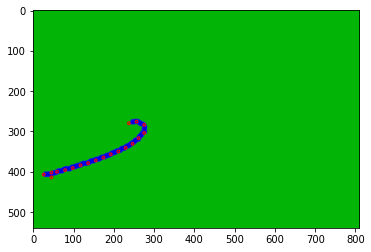

---- optimize translation ----
tensor([ 2.3717e+02,  2.6063e+02,  1.7321e-01, -3.8336e-01, -1.5445e+00,
        -2.3987e+00, -2.4090e+00, -2.6153e+00, -2.6940e+00, -2.7380e+00,
        -2.7274e+00, -2.8246e+00, -2.7759e+00, -2.8912e+00, -2.7870e+00,
        -2.8776e+00, -2.9211e+00, -2.3953e+00, -3.4679e+00, -6.0200e+00],
       device='cuda:0')
tensor(264.2803, device='cuda:0')
tensor([ 2.3715e+02,  2.6062e+02,  1.7321e-01, -3.8336e-01, -1.5445e+00,
        -2.3987e+00, -2.4090e+00, -2.6153e+00, -2.6940e+00, -2.7380e+00,
        -2.7274e+00, -2.8246e+00, -2.7759e+00, -2.8912e+00, -2.7870e+00,
        -2.8776e+00, -2.9211e+00, -2.3953e+00, -3.4679e+00, -6.0200e+00],
       device='cuda:0')
tensor(264.2822, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3717e+02,  2.6063e+02,  1.7321e-01, -3.8336e-01, -1.5445e+00,
        -2.3987e+00, -2.4090e+00, -2.6153e+00, -2.6940e+00, -2.7380e+00,
        -2.7274e+00, -2.8246e+00, -2.7759e+00, -2.8912e+00, -2.7870e+00,
        -2.8776e+00,

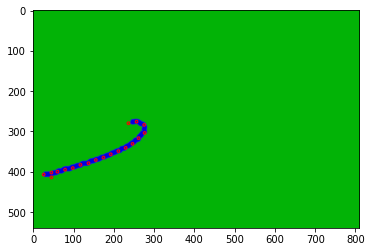

---- optimize translation ----
tensor([ 2.3695e+02,  2.6047e+02,  1.8431e-01, -3.7724e-01, -1.5224e+00,
        -2.4033e+00, -2.4024e+00, -2.6145e+00, -2.6917e+00, -2.7397e+00,
        -2.7274e+00, -2.8320e+00, -2.7559e+00, -2.9107e+00, -2.7597e+00,
        -2.9147e+00, -2.8878e+00, -2.4152e+00, -3.4602e+00, -6.0230e+00],
       device='cuda:0')
tensor(263.8768, device='cuda:0')
tensor([ 2.3702e+02,  2.6049e+02,  1.8431e-01, -3.7724e-01, -1.5224e+00,
        -2.4033e+00, -2.4024e+00, -2.6145e+00, -2.6917e+00, -2.7397e+00,
        -2.7274e+00, -2.8320e+00, -2.7559e+00, -2.9107e+00, -2.7597e+00,
        -2.9147e+00, -2.8878e+00, -2.4152e+00, -3.4602e+00, -6.0230e+00],
       device='cuda:0')
tensor(263.8894, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3695e+02,  2.6047e+02,  1.8431e-01, -3.7724e-01, -1.5224e+00,
        -2.4033e+00, -2.4024e+00, -2.6145e+00, -2.6917e+00, -2.7397e+00,
        -2.7274e+00, -2.8320e+00, -2.7559e+00, -2.9107e+00, -2.7597e+00,
        -2.9147e+00,

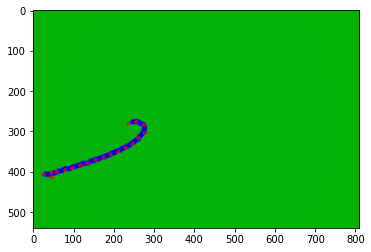

---- optimize translation ----
tensor([ 2.3713e+02,  2.6059e+02,  1.7650e-01, -3.8177e-01, -1.5384e+00,
        -2.4017e+00, -2.4037e+00, -2.6222e+00, -2.6861e+00, -2.7422e+00,
        -2.7253e+00, -2.8354e+00, -2.7611e+00, -2.8990e+00, -2.7761e+00,
        -2.8915e+00, -2.9141e+00, -2.3927e+00, -3.4683e+00, -6.0237e+00],
       device='cuda:0')
tensor(265.6972, device='cuda:0')
tensor([ 2.3714e+02,  2.6060e+02,  1.7650e-01, -3.8177e-01, -1.5384e+00,
        -2.4017e+00, -2.4037e+00, -2.6222e+00, -2.6861e+00, -2.7422e+00,
        -2.7253e+00, -2.8354e+00, -2.7611e+00, -2.8990e+00, -2.7761e+00,
        -2.8915e+00, -2.9141e+00, -2.3927e+00, -3.4683e+00, -6.0237e+00],
       device='cuda:0')
tensor(265.6975, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3713e+02,  2.6059e+02,  1.7650e-01, -3.8177e-01, -1.5384e+00,
        -2.4017e+00, -2.4037e+00, -2.6222e+00, -2.6861e+00, -2.7422e+00,
        -2.7253e+00, -2.8354e+00, -2.7611e+00, -2.8990e+00, -2.7761e+00,
        -2.8915e+00,

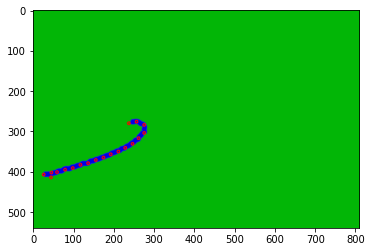

---- optimize translation ----
tensor([ 2.3722e+02,  2.6066e+02,  1.7180e-01, -3.8534e-01, -1.5493e+00,
        -2.3974e+00, -2.4119e+00, -2.6180e+00, -2.6835e+00, -2.7498e+00,
        -2.7240e+00, -2.8405e+00, -2.7458e+00, -2.9188e+00, -2.7570e+00,
        -2.9154e+00, -2.8807e+00, -2.4101e+00, -3.4792e+00, -6.0309e+00],
       device='cuda:0')
tensor(265.3293, device='cuda:0')
tensor([ 2.3716e+02,  2.6064e+02,  1.7180e-01, -3.8534e-01, -1.5493e+00,
        -2.3974e+00, -2.4119e+00, -2.6180e+00, -2.6835e+00, -2.7498e+00,
        -2.7240e+00, -2.8405e+00, -2.7458e+00, -2.9188e+00, -2.7570e+00,
        -2.9154e+00, -2.8807e+00, -2.4101e+00, -3.4792e+00, -6.0309e+00],
       device='cuda:0')
tensor(265.3362, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3722e+02,  2.6066e+02,  1.7180e-01, -3.8534e-01, -1.5493e+00,
        -2.3974e+00, -2.4119e+00, -2.6180e+00, -2.6835e+00, -2.7498e+00,
        -2.7240e+00, -2.8405e+00, -2.7458e+00, -2.9188e+00, -2.7570e+00,
        -2.9154e+00,

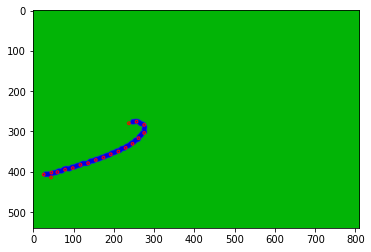

---- optimize translation ----
tensor([ 2.3715e+02,  2.6062e+02,  1.7431e-01, -3.8259e-01, -1.5421e+00,
        -2.3990e+00, -2.4093e+00, -2.6188e+00, -2.6813e+00, -2.7538e+00,
        -2.7198e+00, -2.8415e+00, -2.7421e+00, -2.9264e+00, -2.7468e+00,
        -2.9284e+00, -2.8682e+00, -2.4211e+00, -3.4741e+00, -6.0260e+00],
       device='cuda:0')
tensor(263.4164, device='cuda:0')
tensor([ 2.3720e+02,  2.6063e+02,  1.7431e-01, -3.8259e-01, -1.5421e+00,
        -2.3990e+00, -2.4093e+00, -2.6188e+00, -2.6813e+00, -2.7538e+00,
        -2.7198e+00, -2.8415e+00, -2.7421e+00, -2.9264e+00, -2.7468e+00,
        -2.9284e+00, -2.8682e+00, -2.4211e+00, -3.4741e+00, -6.0260e+00],
       device='cuda:0')
tensor(263.4199, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3715e+02,  2.6062e+02,  1.7431e-01, -3.8259e-01, -1.5421e+00,
        -2.3990e+00, -2.4093e+00, -2.6188e+00, -2.6813e+00, -2.7538e+00,
        -2.7198e+00, -2.8415e+00, -2.7421e+00, -2.9264e+00, -2.7468e+00,
        -2.9284e+00,

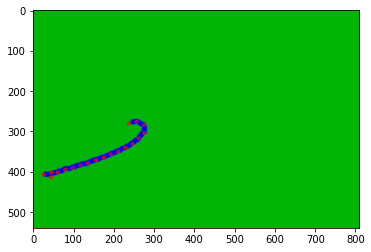

---- optimize translation ----
tensor([ 2.3720e+02,  2.6064e+02,  1.7294e-01, -3.8485e-01, -1.5468e+00,
        -2.3985e+00, -2.4101e+00, -2.6206e+00, -2.6791e+00, -2.7531e+00,
        -2.7206e+00, -2.8510e+00, -2.7311e+00, -2.9220e+00, -2.7592e+00,
        -2.9348e+00, -2.8482e+00, -2.4300e+00, -3.4818e+00, -6.0326e+00],
       device='cuda:0')
tensor(262.7842, device='cuda:0')
tensor([ 2.3717e+02,  2.6063e+02,  1.7294e-01, -3.8485e-01, -1.5468e+00,
        -2.3985e+00, -2.4101e+00, -2.6206e+00, -2.6791e+00, -2.7531e+00,
        -2.7206e+00, -2.8510e+00, -2.7311e+00, -2.9220e+00, -2.7592e+00,
        -2.9348e+00, -2.8482e+00, -2.4300e+00, -3.4818e+00, -6.0326e+00],
       device='cuda:0')
tensor(262.7851, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3720e+02,  2.6064e+02,  1.7294e-01, -3.8485e-01, -1.5468e+00,
        -2.3985e+00, -2.4101e+00, -2.6206e+00, -2.6791e+00, -2.7531e+00,
        -2.7206e+00, -2.8510e+00, -2.7311e+00, -2.9220e+00, -2.7592e+00,
        -2.9348e+00,

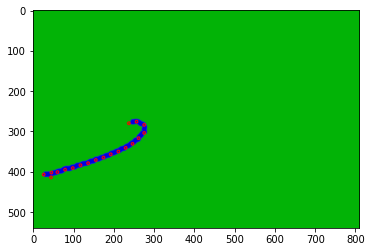

---- optimize translation ----
tensor([ 2.3718e+02,  2.6063e+02,  1.7329e-01, -3.8344e-01, -1.5447e+00,
        -2.3985e+00, -2.4098e+00, -2.6184e+00, -2.6830e+00, -2.7576e+00,
        -2.7204e+00, -2.8383e+00, -2.7353e+00, -2.9216e+00, -2.7610e+00,
        -2.9387e+00, -2.8445e+00, -2.4325e+00, -3.4839e+00, -6.0388e+00],
       device='cuda:0')
tensor(262.3577, device='cuda:0')
tensor([ 2.3717e+02,  2.6063e+02,  1.7329e-01, -3.8344e-01, -1.5447e+00,
        -2.3985e+00, -2.4098e+00, -2.6184e+00, -2.6830e+00, -2.7576e+00,
        -2.7204e+00, -2.8383e+00, -2.7353e+00, -2.9216e+00, -2.7610e+00,
        -2.9387e+00, -2.8445e+00, -2.4325e+00, -3.4839e+00, -6.0388e+00],
       device='cuda:0')
tensor(262.3578, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3718e+02,  2.6063e+02,  1.7329e-01, -3.8344e-01, -1.5447e+00,
        -2.3985e+00, -2.4098e+00, -2.6184e+00, -2.6830e+00, -2.7576e+00,
        -2.7204e+00, -2.8383e+00, -2.7353e+00, -2.9216e+00, -2.7610e+00,
        -2.9387e+00,

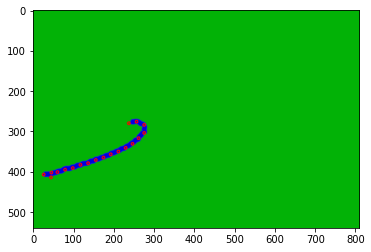

---- optimize translation ----
tensor([ 2.3717e+02,  2.6063e+02,  1.7363e-01, -3.8327e-01, -1.5440e+00,
        -2.3985e+00, -2.4101e+00, -2.6171e+00, -2.6828e+00, -2.7600e+00,
        -2.7173e+00, -2.8452e+00, -2.7256e+00, -2.9285e+00, -2.7604e+00,
        -2.9336e+00, -2.8474e+00, -2.4338e+00, -3.4817e+00, -6.0374e+00],
       device='cuda:0')
tensor(263.7765, device='cuda:0')
tensor([ 2.3724e+02,  2.6065e+02,  1.7363e-01, -3.8327e-01, -1.5440e+00,
        -2.3985e+00, -2.4101e+00, -2.6171e+00, -2.6828e+00, -2.7600e+00,
        -2.7173e+00, -2.8452e+00, -2.7256e+00, -2.9285e+00, -2.7604e+00,
        -2.9336e+00, -2.8474e+00, -2.4338e+00, -3.4817e+00, -6.0374e+00],
       device='cuda:0')
tensor(263.7839, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3717e+02,  2.6063e+02,  1.7363e-01, -3.8327e-01, -1.5440e+00,
        -2.3985e+00, -2.4101e+00, -2.6171e+00, -2.6828e+00, -2.7600e+00,
        -2.7173e+00, -2.8452e+00, -2.7256e+00, -2.9285e+00, -2.7604e+00,
        -2.9336e+00,

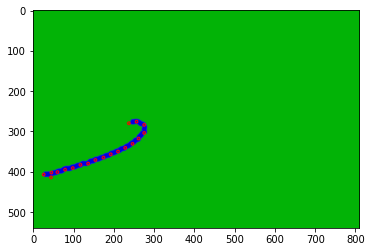

---- optimize translation ----
tensor([ 2.3726e+02,  2.6070e+02,  1.6836e-01, -3.8574e-01, -1.5559e+00,
        -2.3935e+00, -2.4189e+00, -2.6109e+00, -2.6890e+00, -2.7576e+00,
        -2.7122e+00, -2.8652e+00, -2.6986e+00, -2.9495e+00, -2.7471e+00,
        -2.9400e+00, -2.8460e+00, -2.4320e+00, -3.4830e+00, -6.0373e+00],
       device='cuda:0')
tensor(264.4513, device='cuda:0')
tensor([ 2.3727e+02,  2.6071e+02,  1.6836e-01, -3.8574e-01, -1.5559e+00,
        -2.3935e+00, -2.4189e+00, -2.6109e+00, -2.6890e+00, -2.7576e+00,
        -2.7122e+00, -2.8652e+00, -2.6986e+00, -2.9495e+00, -2.7471e+00,
        -2.9400e+00, -2.8460e+00, -2.4320e+00, -3.4830e+00, -6.0373e+00],
       device='cuda:0')
tensor(264.4510, device='cuda:0')
tensor([ 2.3726e+02,  2.6071e+02,  1.6836e-01, -3.8574e-01, -1.5559e+00,
        -2.3935e+00, -2.4189e+00, -2.6109e+00, -2.6890e+00, -2.7576e+00,
        -2.7122e+00, -2.8652e+00, -2.6986e+00, -2.9495e+00, -2.7471e+00,
        -2.9400e+00, -2.8460e+00, -2.4320e+00, -

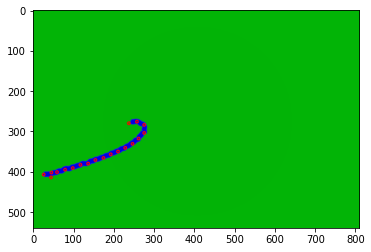

---- optimize translation ----
tensor([ 2.3734e+02,  2.6075e+02,  1.6575e-01, -3.8966e-01, -1.5634e+00,
        -2.3929e+00, -2.4188e+00, -2.6134e+00, -2.6886e+00, -2.7596e+00,
        -2.7069e+00, -2.8761e+00, -2.6857e+00, -2.9644e+00, -2.7462e+00,
        -2.9179e+00, -2.8669e+00, -2.4191e+00, -3.4878e+00, -6.0326e+00],
       device='cuda:0')
tensor(264.4864, device='cuda:0')
tensor([ 2.3741e+02,  2.6077e+02,  1.6575e-01, -3.8966e-01, -1.5634e+00,
        -2.3929e+00, -2.4188e+00, -2.6134e+00, -2.6886e+00, -2.7596e+00,
        -2.7069e+00, -2.8761e+00, -2.6857e+00, -2.9644e+00, -2.7462e+00,
        -2.9179e+00, -2.8669e+00, -2.4191e+00, -3.4878e+00, -6.0326e+00],
       device='cuda:0')
tensor(264.4959, device='cuda:0')
---- optimize rotation ----
tensor([ 2.3734e+02,  2.6075e+02,  1.6575e-01, -3.8966e-01, -1.5634e+00,
        -2.3929e+00, -2.4188e+00, -2.6134e+00, -2.6886e+00, -2.7596e+00,
        -2.7069e+00, -2.8761e+00, -2.6857e+00, -2.9644e+00, -2.7462e+00,
        -2.9179e+00,

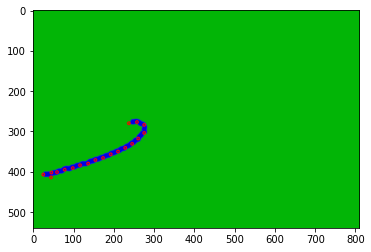

In [10]:
# simple rope tracking
H = 540
W = 810
simple_tracker = tracker(H, W, cuda=True)
q = torch.zeros((20,))
q[0] = 40
simple_tracker.set_init(q)
data_path = "/home/yixuan/dart_deformable/data/rope_simple/"
for i in range(251):
    rgb_np = exr_to_np(data_path+"rgb_"+'{0:03d}'.format(i)+".exr")
    mask = rgb_np[:, :, 2] > 100
    simple_tracker.set_obs(torch.tensor(mask), rgb_np)
    simple_tracker.gauss_step()
    simple_tracker.vis(save_dir="/home/yixuan/dart_deformable/result/rope_simple/", idx=i)

In [259]:
H = 540
W = 810
simple_tracker = tracker(H, W, cuda=True)

In [263]:
q = torch.zeros((10,)).cuda()
mask = torch.zeros((H, W), dtype=bool)
mask[200:205, 200:300] = True
simple_tracker.set_obs(mask)
simple_tracker.set_init(q)
J=jacobian(simple_tracker.dist_fn, q)
dist=simple_tracker.dist_fn(q)

In [264]:
torch.mm(J.t(), dist.unsqueeze(1))

tensor([[  -84750.],
        [ -168500.],
        [-1685000.],
        [-1685000.],
        [-1685000.],
        [-1685000.],
        [-1685000.],
        [-1685000.],
        [-1685000.],
        [-1685000.]], device='cuda:0')

In [265]:
simple_tracker.step()

---- optimize translation ----
loss: tensor(71567256., grad_fn=<SumBackward0>)
tensor([ 169.5000,  337.0000, 3370.0002, 3370.0002, 3370.0002, 3370.0002,
        3370.0002, 3370.0002, 3370.0002, 3370.0002], device='cuda:0')
tensor([ -169500.,  -337000., -3370000., -3370000., -3370000., -3370000.,
        -3370000., -3370000., -3370000., -3370000.], device='cuda:0')


KeyboardInterrupt: Interrupted by user

In [228]:
mask = torch.zeros((H, W), dtype=bool)
mask[200:205, 200:300] = True
N = mask.nonzero().shape[0]
n = 100
rand_idx = np.random.choice(N, n)
sub = torch.zeros_like(mask)
print(mask.nonzero()[rand_idx])
sub[mask.nonzero()[rand_idx][:, 0], mask.nonzero()[rand_idx][:, 1]] = True

tensor([[200, 238],
        [201, 296],
        [203, 244],
        [201, 293],
        [203, 231],
        [203, 219],
        [202, 209],
        [204, 284],
        [202, 238],
        [200, 208],
        [201, 209],
        [204, 210],
        [202, 243],
        [204, 221],
        [200, 208],
        [204, 289],
        [203, 209],
        [201, 263],
        [203, 265],
        [201, 250],
        [204, 232],
        [201, 228],
        [202, 243],
        [204, 200],
        [200, 226],
        [201, 270],
        [203, 202],
        [203, 275],
        [201, 213],
        [200, 220],
        [201, 239],
        [203, 259],
        [200, 243],
        [203, 268],
        [200, 257],
        [204, 282],
        [200, 229],
        [202, 270],
        [203, 235],
        [201, 289],
        [200, 284],
        [203, 281],
        [204, 275],
        [201, 222],
        [201, 290],
        [200, 229],
        [200, 288],
        [201, 200],
        [200, 287],
        [201, 297],


In [229]:
sub.sum()

tensor(91)

In [204]:
sub.nonzero()

tensor([[200,   0],
        [200,   1],
        [200,   2],
        ...,
        [299, 807],
        [299, 808],
        [299, 809]])

In [206]:
mask.nonzero()[rand_idx[:, 0], rand_idx[:, 1]]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [212]:
torch.index_select(mask, 0, mask.nonzero()[rand_idx][:, 0]).shape

torch.Size([100, 810])

In [210]:
rand_idx

array([445, 416, 425, 157, 350, 461, 222, 250, 463, 320,   9,  81, 119,
       440, 493,  56,  49, 140, 384, 204, 333, 285, 158, 115, 299, 255,
        20, 240, 231, 372,  29, 188, 324, 376, 230, 184, 361,  37, 181,
       434, 351, 414, 191, 339, 182,   8, 342, 284, 336, 104, 262,   0,
       327, 285, 476, 184,  72, 162,  81, 243, 455, 202, 316, 332,  11,
       156,  68, 370,  22, 242, 371,   1, 349, 456, 499, 126,   7,  81,
       184, 295, 150, 371,  57, 365,  29, 281, 451, 417, 170, 400, 402,
       373,  42, 242, 110, 410, 215, 466, 363, 271])

In [214]:
sub[[1, 2], [2, 2]]

tensor([False, False])